# Projekt Zaliczeniowy Modelowanie w Naukach o Ziemi

Projekt jest na ocenę. Rezultatem ma być kompletne sprawozdanie. Sprawozdania w formacie pdf przesyłamy w terminie do ostatniego dnia semestru.

Dane do projektu: `plik daily_ice_edge.csv`.

### Krok 0

1. Po przemyśleniu układu danych narysować kontur przedstawiający minimalny zasięg lodu w analizowanym okresie dla wszystkich kątów. 

  a. Przemyśleć układ danych
  
  b. Narysować kontur przedstawiający minimalny zasięg lodu w analizowanym okresie dla wszystkich kątów

Warto zapoznać się z kształtem Antarktydy.   

### Krok 1
  
1. Dla wszystkich kątów (dla każdego z osobna) znaleźć model matematyczny zasięgu lodu w funkcji czasu. 

  a. Zbudować model matematyczny dla każdej kolumny w oparciu o funkcji trygonometryczne (sinusoidalna cykliczność; można o to zapytać).

Uwaga na próbkowanie w czasie oraz na fakt, że czasami lodu morskiego dla danego kąta może nie być. 

### Krok 2
  
1. Stworzyć animację przedstawiającą zmianę w czasie zarówno rzeczywistego jak i wymodelowane.

### Krok 3
 
1. Zaproponować i *w miarę możliwości* obliczyć model zasięgu lodu biorący pod uwagę wszystkie dane na raz (`f(Lat, Lon, t)`).

  a. Przekonać, że świta nam w głowie jakaś idea.

## Wskazówki 

Można zbudować model bazując na sinusach i cosinusach dla każdego kierunku z osobna. Po powtórzeniu dla wszystkich azymutów pojawi się macierz, którą animujemy.

Po narysowaniu minimalnego zasięgu lodu w układzie biegunowym otrzymamy minimalny zasięg lodu przypominający kształt Antarktydy. Uzyskujemy to poprzez znalezienie minimalnej wartości w każdej kolumnie i narysowanie tego w układzie biegunowym.


In [47]:
# install.packages("ggplot2") # nolint: commented_code_linter.
# install.packages("animation") # nolint: commented_code_linter.
# install.packages("tidyverse") # nolint: commented_code_linter.
# install.packages("lubridate") # nolint: commented_code_linter.
# install.packages("minpack.lm") # nolint: commented_code_linter.
library(ggplot2)
library(animation)
library(tidyverse)
library(lubridate)
library(minpack.lm)


## Dane do projektu

Plik `daily_ice_edge.csv` zawiera informację o zasięgu lodu morskiego wokół Antarktydy dla wszystkich długości geograficznych - w formacie długość-szerokość - na przestrzeni wielu lat. Dane są zapisane w formie macierzy, gdzie wiersze odpowiadają szerokości geograficznej, a kolumny długości geograficznej.

In [48]:
path <- "./data/daily_ice_edge.csv"
daily_ice_edge <- read.csv(path)
# 1591 wiersz -> zaczynają się dane codzienne


In [49]:
# View(daily_ice_edge) # nolint: commented_code_linter.
# View(daily_open_water) # nolint: commented_code_linter.

## Minimalny zasięg lodu na Antarktydzie

Kontur przedstawiający minimalny zasięg lodu w analizowanym okresie dla wszystkich kątów

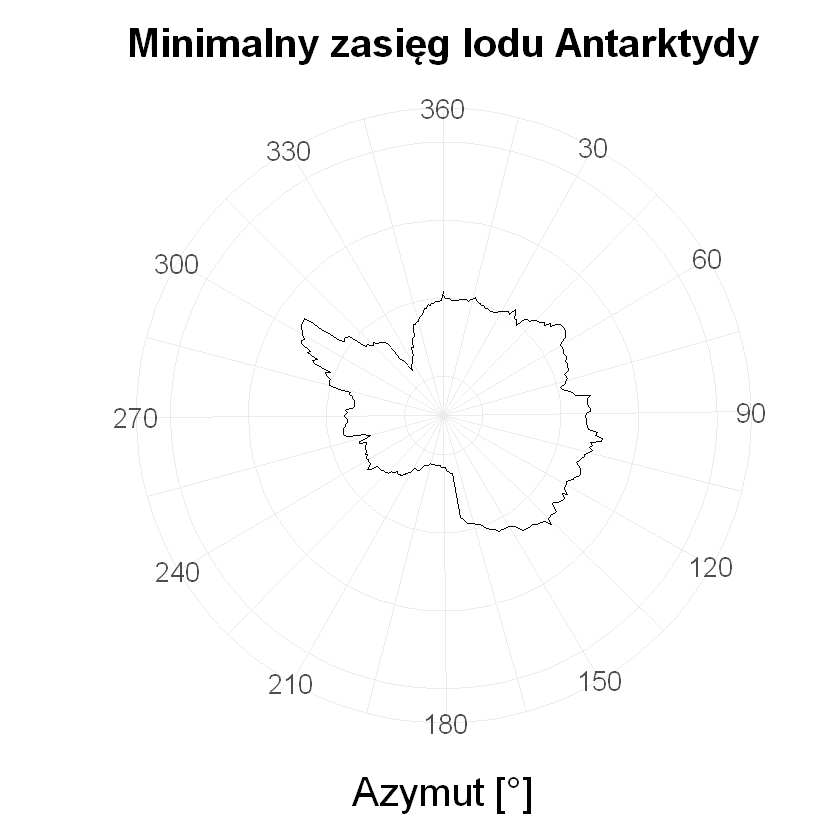

In [50]:
ice_edge_colnum <- length(colnames(daily_ice_edge))

ice_edge_min <- c()
open_water_min <- c()

for (i in 2:(ice_edge_colnum - 1)) {
  ice_edge_min[i - 1] <- min(daily_ice_edge[, i], na.rm = TRUE)
}
ice_edge_min <- as.data.frame(ice_edge_min)

ggplot(
  data = ice_edge_min, aes(x = seq_along(ice_edge_min), y = ice_edge_min)
) +
  geom_line() +
  coord_polar() +
  theme_minimal() +
  ylim(-85, -50) +
  labs(
    title = "Minimalny zasięg lodu Antarktydy",
    x = "Azymut [°]", y = ""
  ) +
  scale_x_continuous(breaks = seq(0, 360, 30)) +
  theme(
    axis.text.x = element_text(size = 16),
    axis.text.y = element_blank(),
    axis.title = element_text(size = 24),
    plot.title = element_text(size = 24, face = "bold", hjust = 0.5),
    plot.margin = unit(c(16, 16, 16, 16), "pt")
  )

In [51]:
step <- 500

sequence <- seq(from = 1, to = nrow(daily_ice_edge), by = step)

saveGIF(
  for (i in sequence) {
    day1 <- t(daily_ice_edge[i, ])

    start_index <- 2
    end_index <- 361

    angles <- c()
    for (j in seq(start_index, end_index, 1)) angles[j] <- day1[j]

    angles <- as.data.frame(angles)
    values <- as.numeric(angles[2:361, ])
    angles <- as.numeric(seq(start_index, end_index, 1))

    df <- data.frame(angles = angles, values = values)
    plt <- ggplot(data = df, aes(x = angles, y = values)) +
      geom_line() +
      coord_polar() +
      theme_minimal() +
      ylim(-85, -50) +
      labs(
        title = paste("Zasięg lodu na Antarktydzie dnia ",
        format(daily_ice_edge$Date[i])),
        x = "Azymut [°]", y = ""
      ) +
      scale_x_continuous(breaks = seq(0, 360, 30)) +
      theme(
        axis.text.x = element_text(size = 16),
        axis.text.y = element_blank(),
        axis.title = element_text(size = 24),
        plot.title = element_text(size = 32, face = "bold", hjust = 0.5),
        plot.margin = unit(c(16, 16, 16, 16), "pt")
      )
    print(plt)
  },
  movie.name = "animation.gif", interval = 0.2,
  ani.width = 800, ani.height = 800
)

Output at: animation.gif



[1] TRUE

In [ ]:
data <- read.csv(path)
data$Date <- dmy(data$Date) # Konwersja na typ danych daty
data$Days <- as.numeric(
  data$Date - min(data$Date)
) # Obliczenie liczby dni od początku pomiarów

sine_model <- function(x, A, B, C, D) { # nolint: object_name_linter.
  A * sin(B * x + C) + D
}
# A - amplituda
# B - częstotliwość
# C - przesunięcie fazowe
# D - przesunięcie pionowe
model_params <- list()

# Obliczenie parametrów modelu dla każdej szerokości geograficznej
for (i in seq(2, 362, 1)) {
  col <- names(data)[i]
  day <- data$Days
  ice_extent <- data[[col]]

  init_params <- list(
    A = 1,
    B = 2 * pi / 365.25,
    C = 0,
    D = mean(ice_extent, na.rm = TRUE)
  )

  fit <- nlsLM(
    ice_extent ~ sine_model(day, A, B, C, D),
    start = init_params,
    control = nls.lm.control(maxiter = 1024)
  )

  model_params[[col]] <- coef(fit)
}


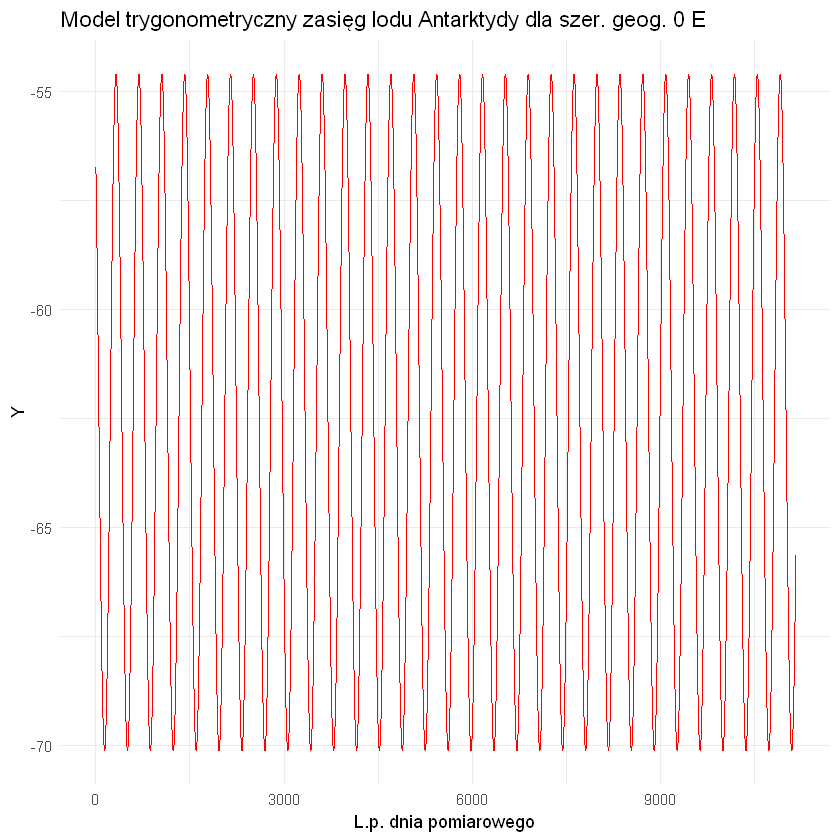

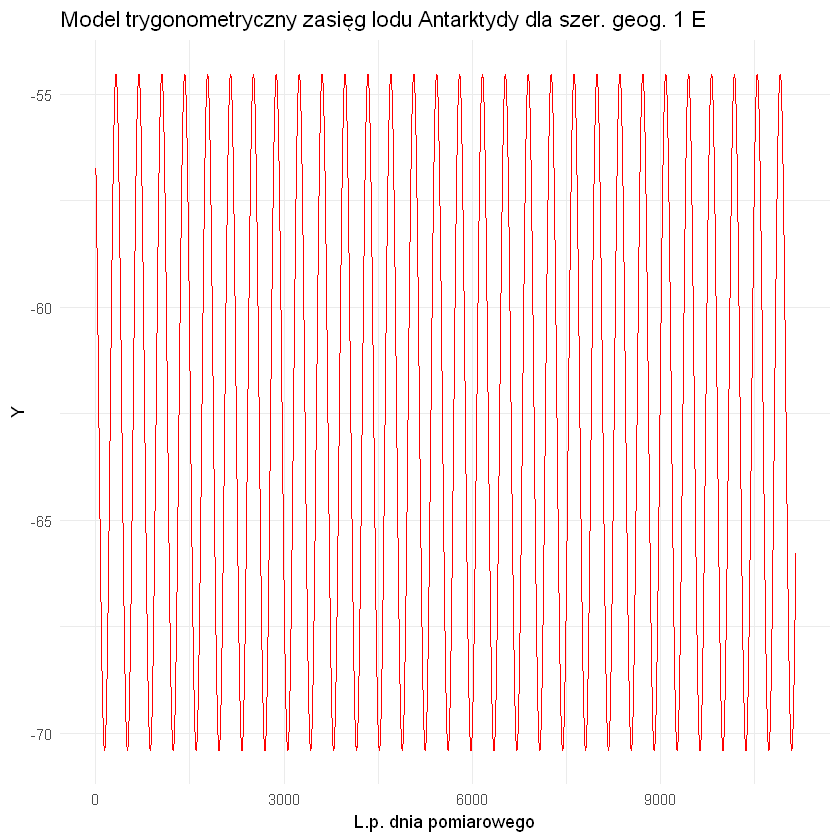

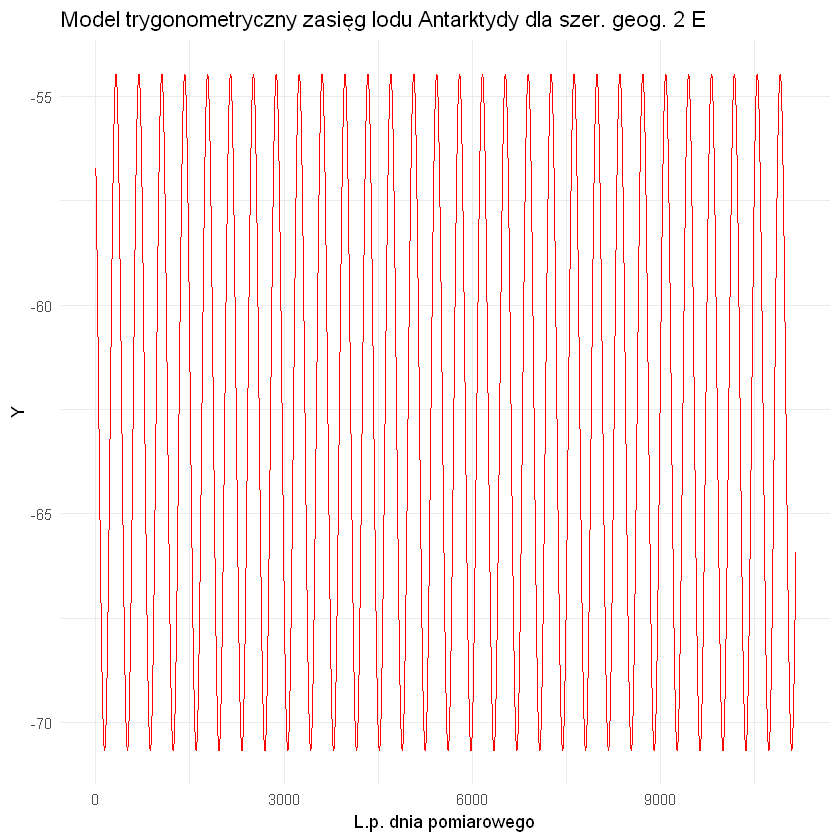

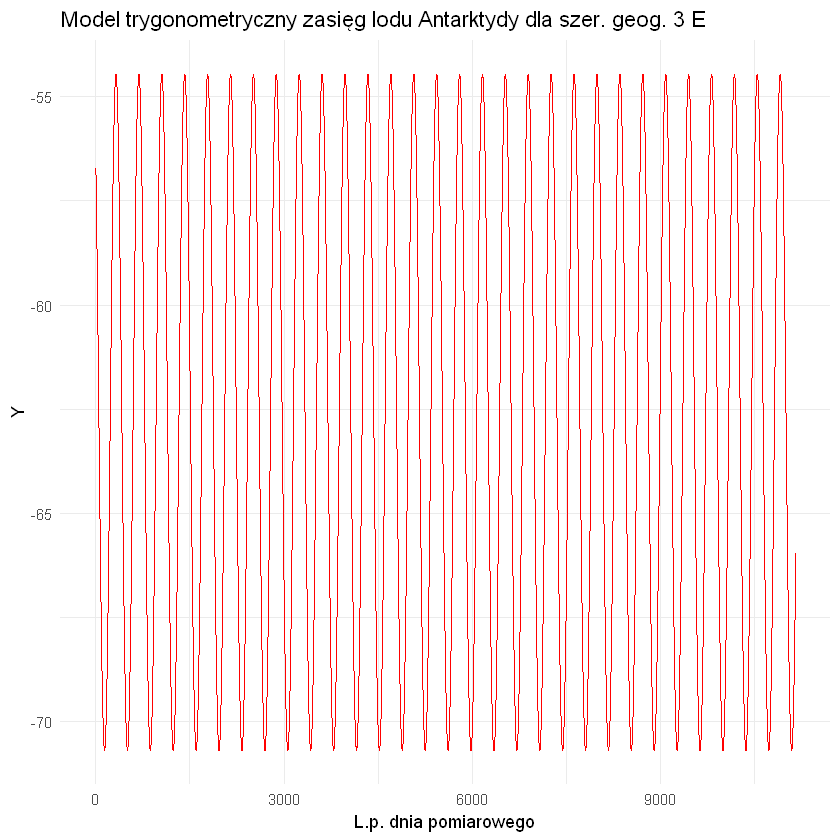

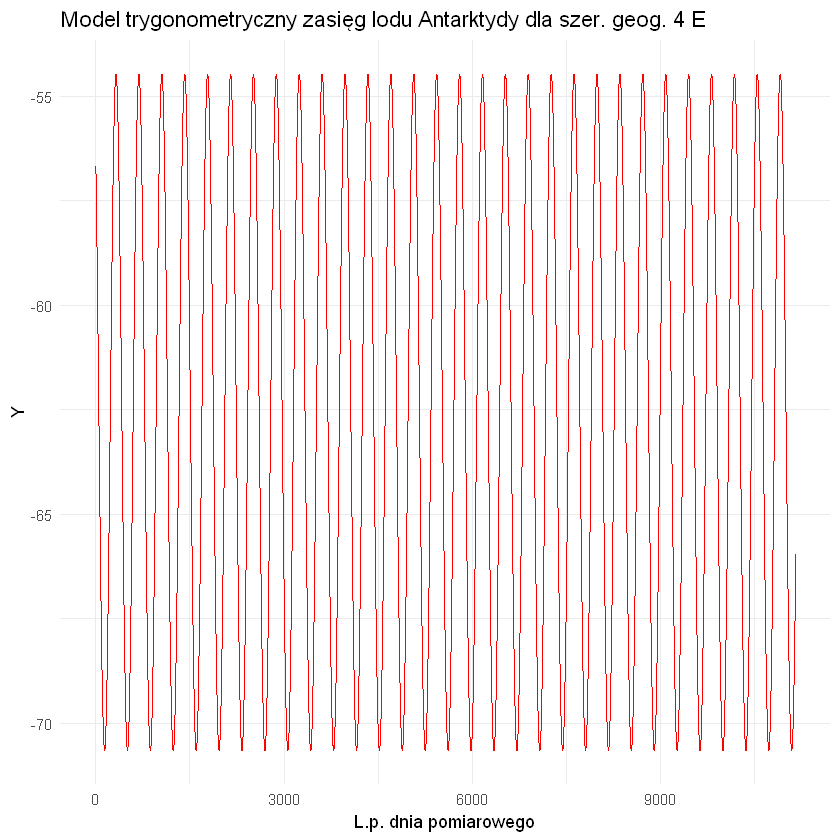

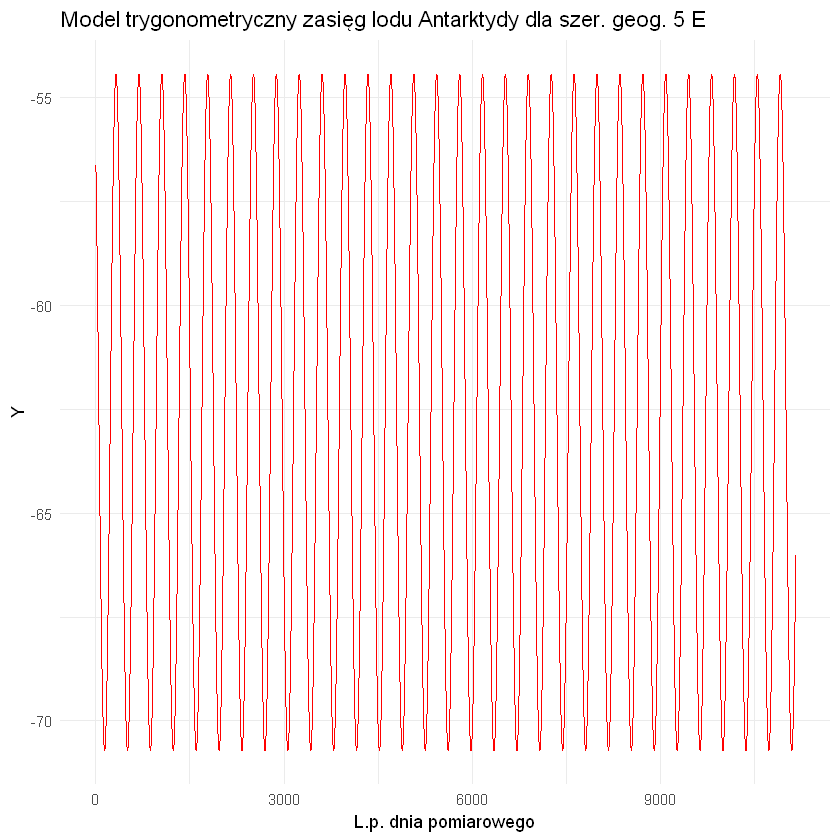

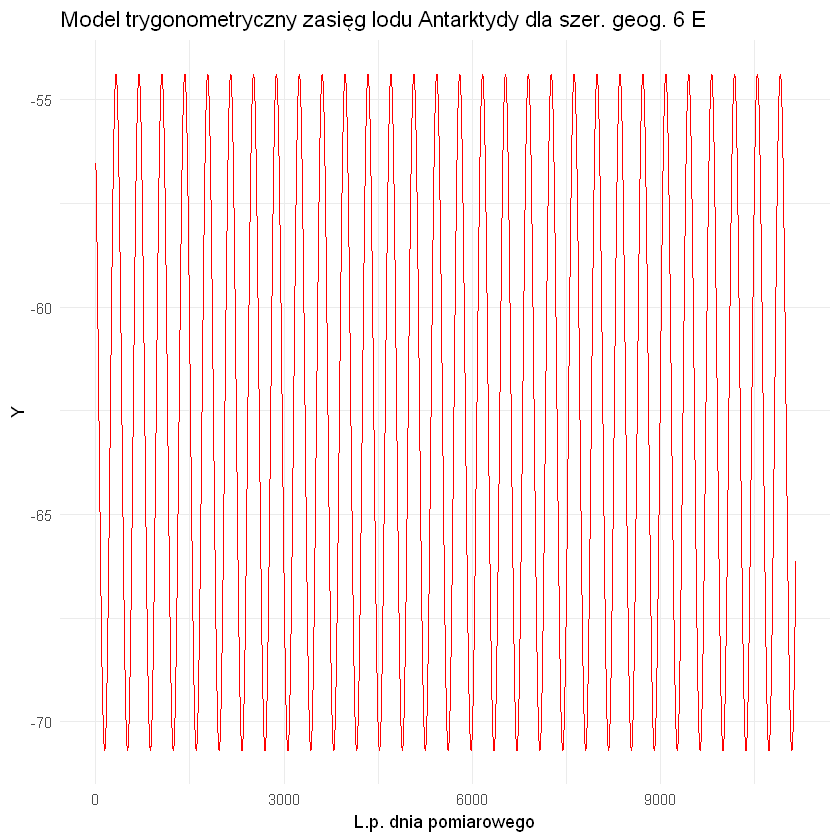

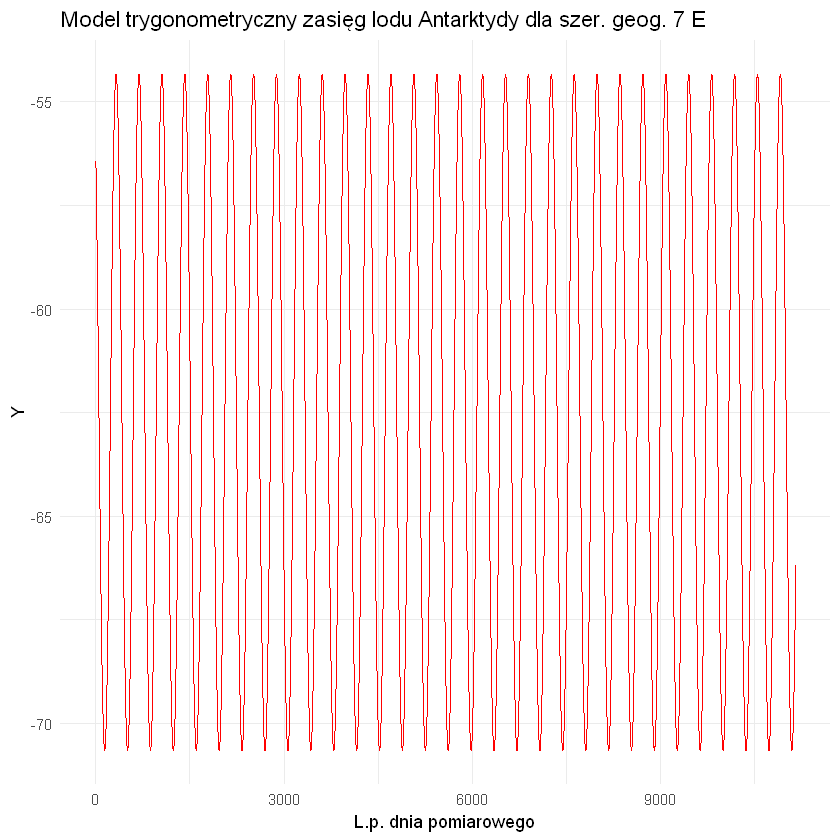

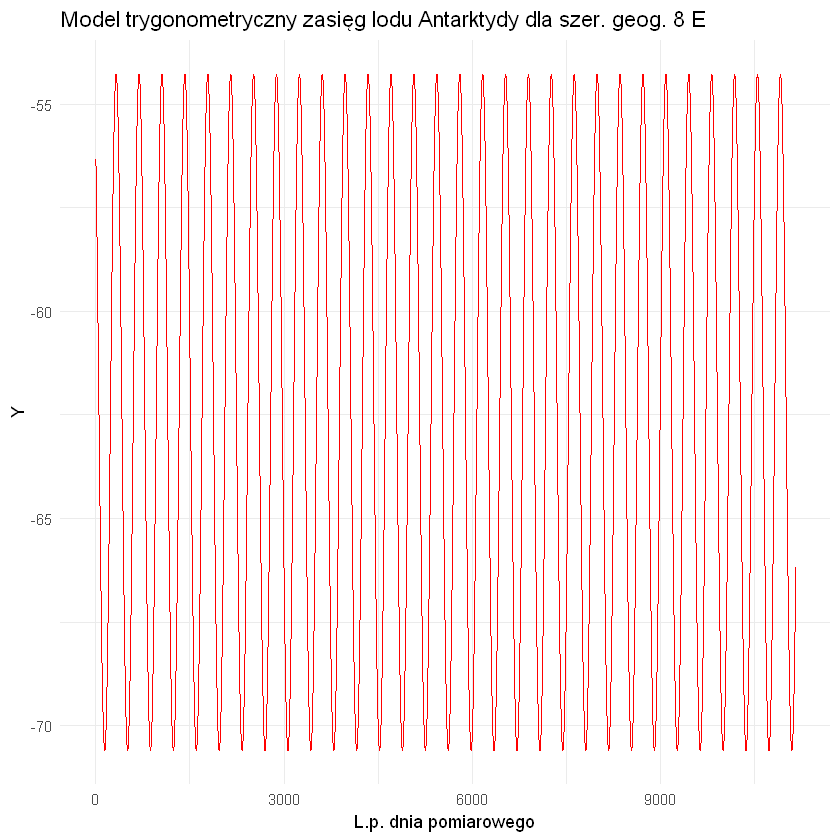

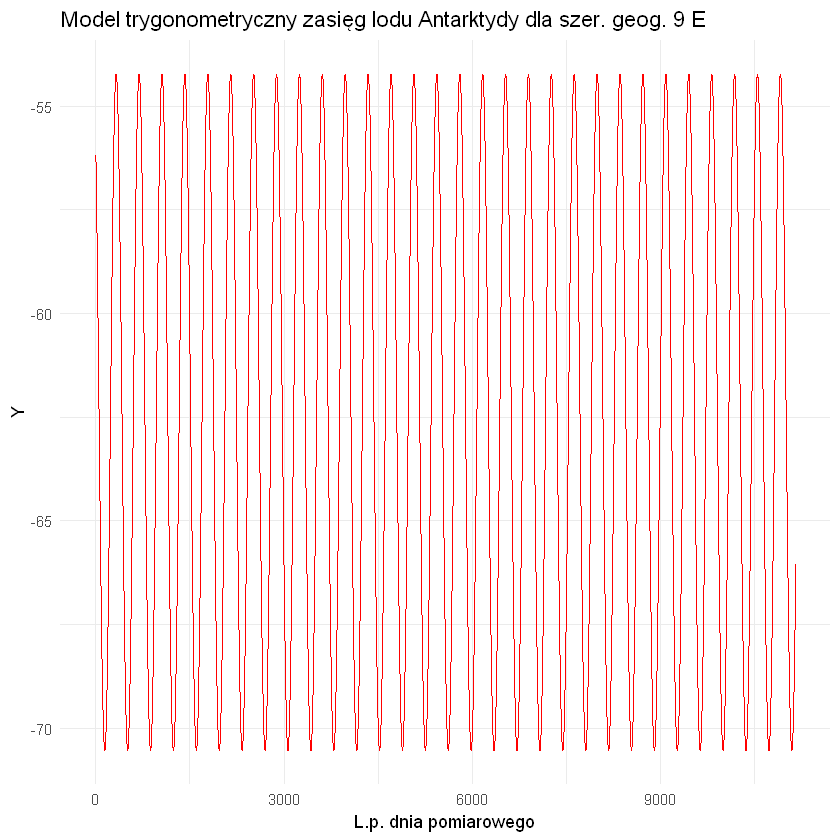

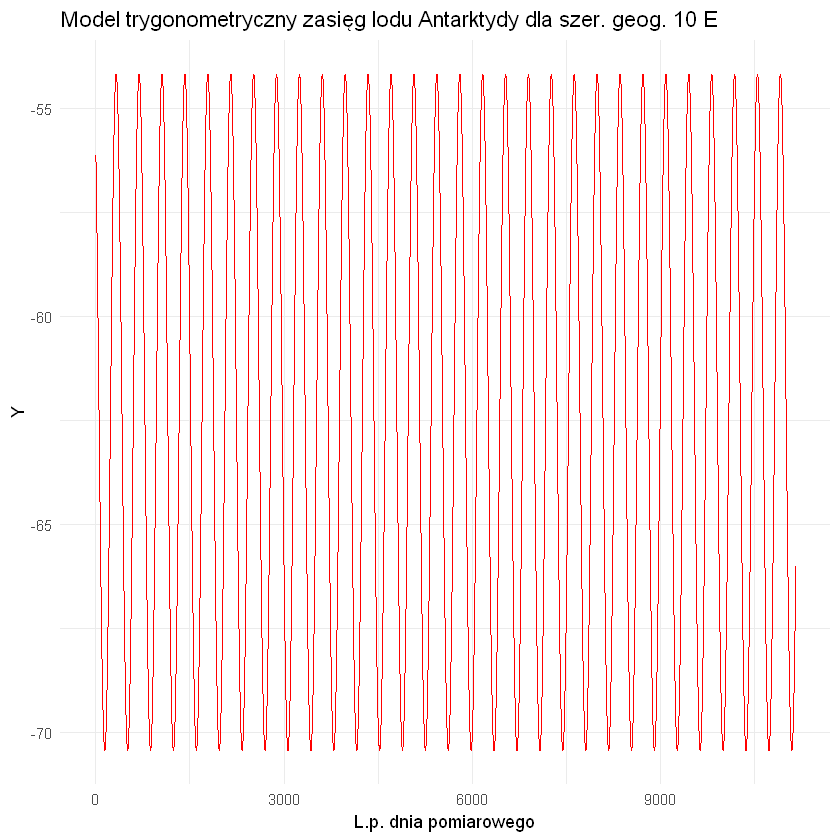

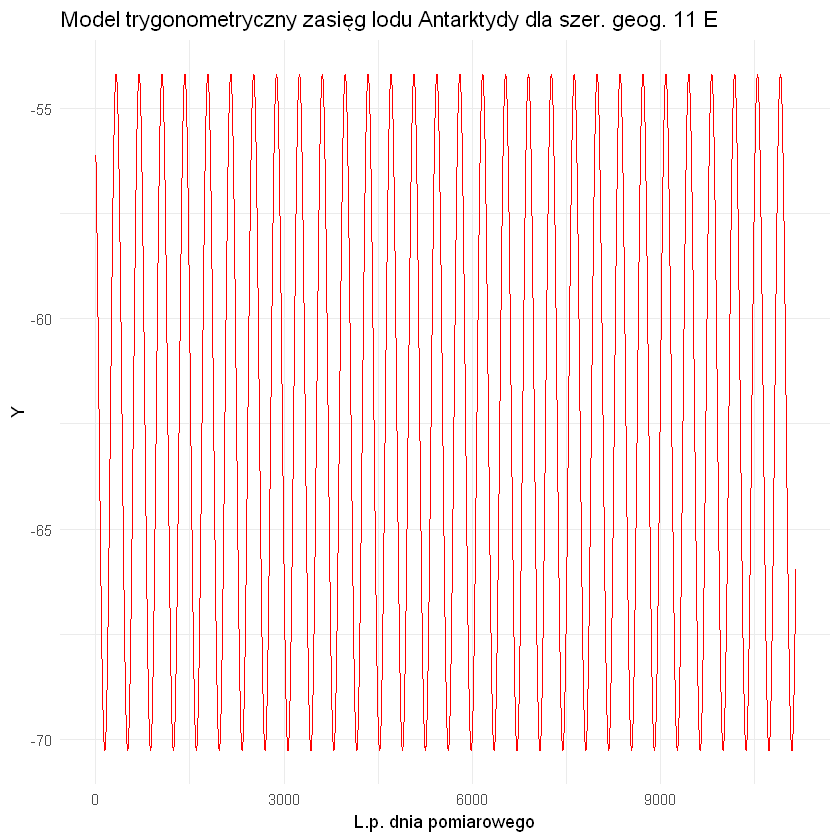

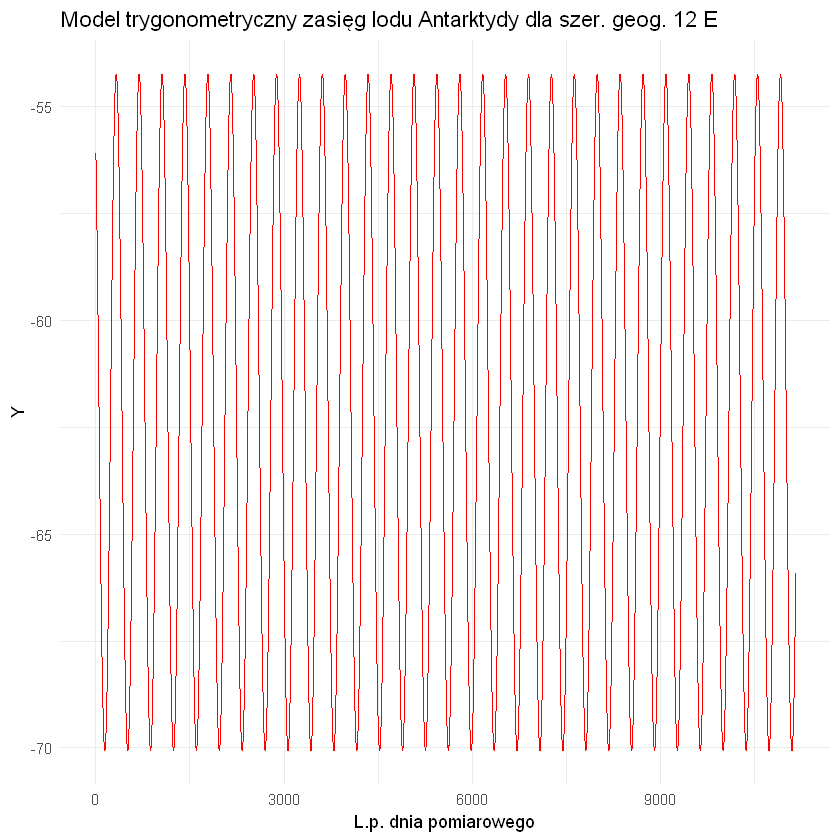

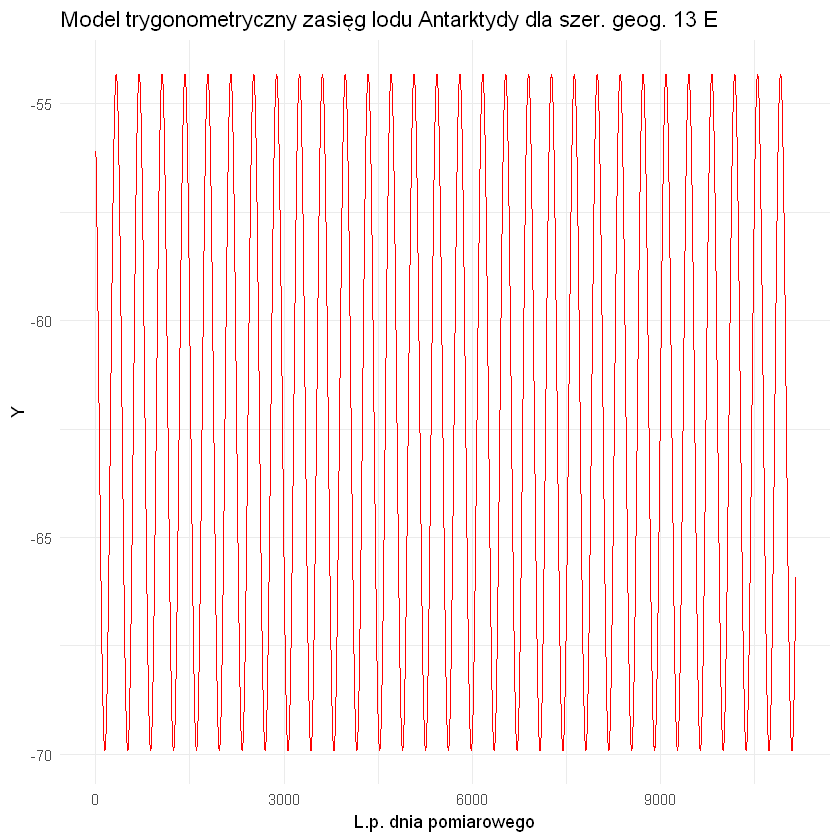

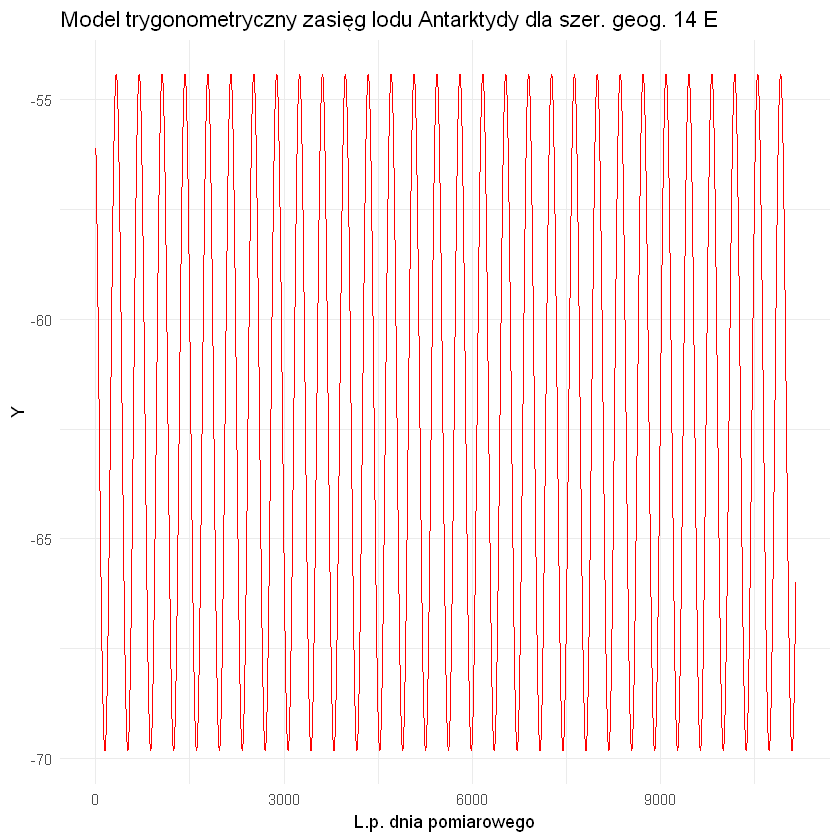

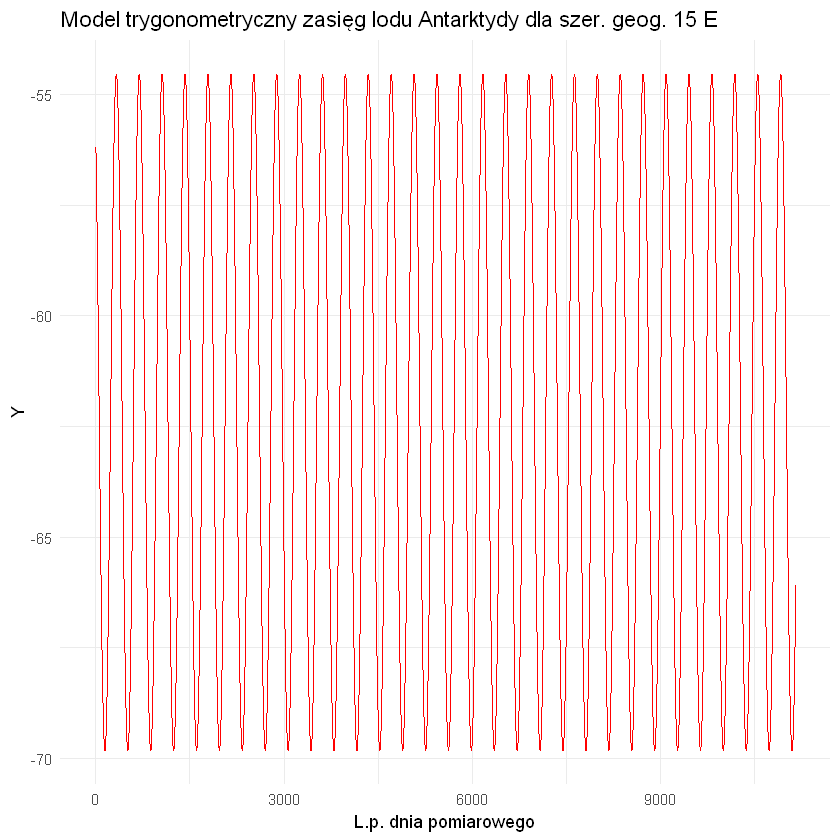

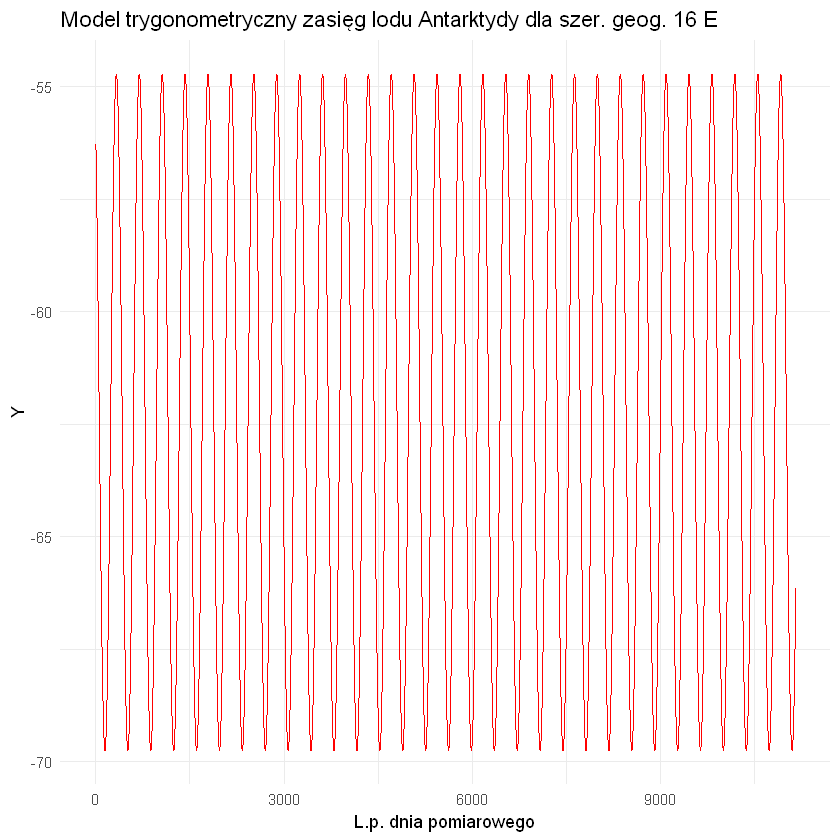

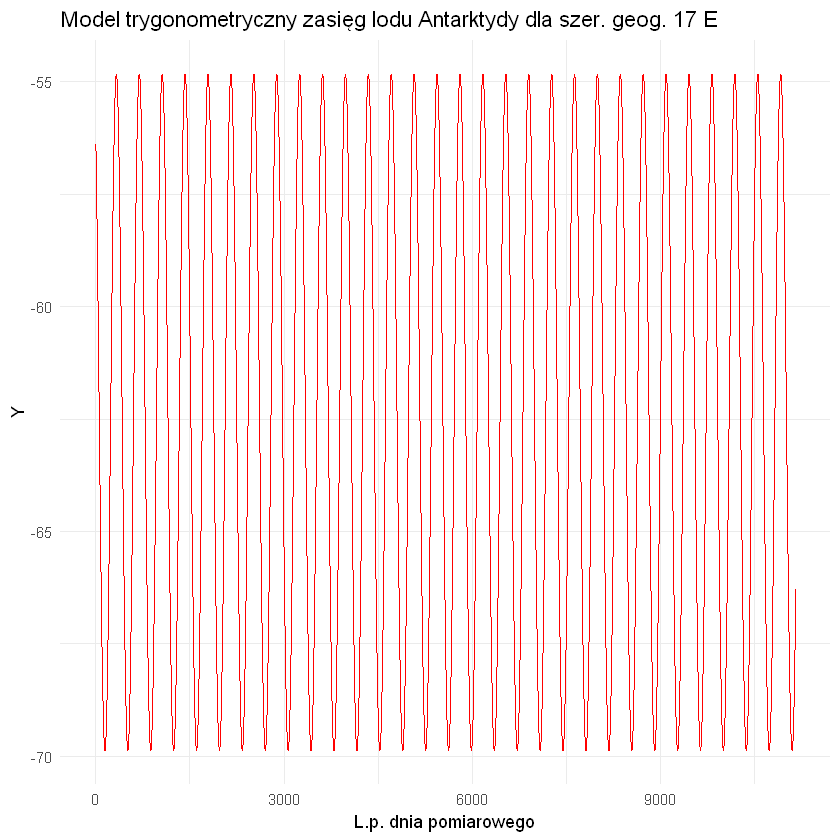

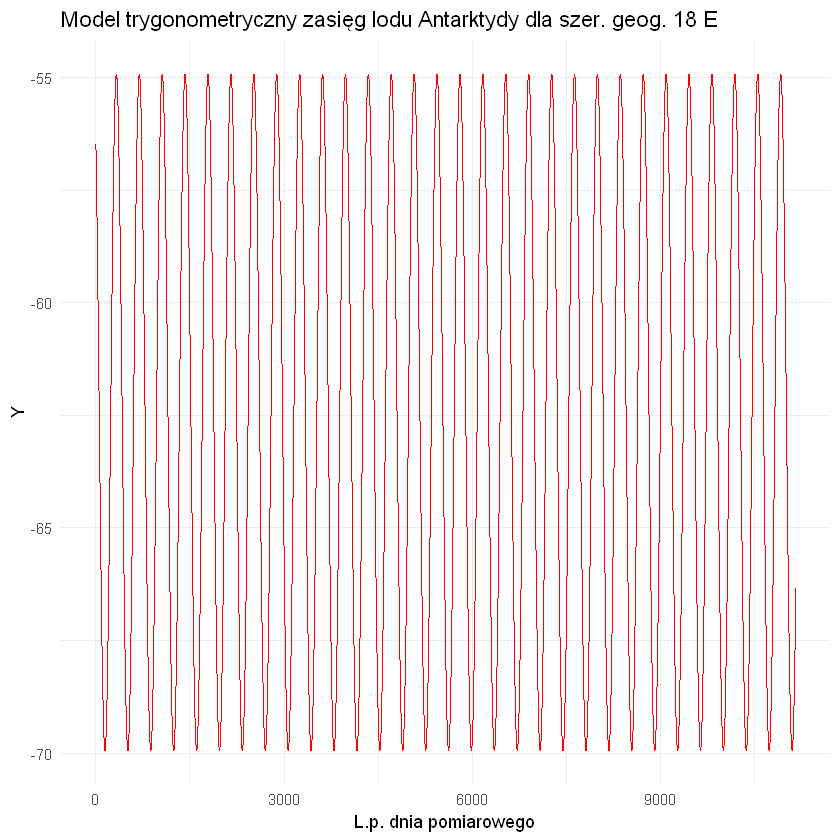

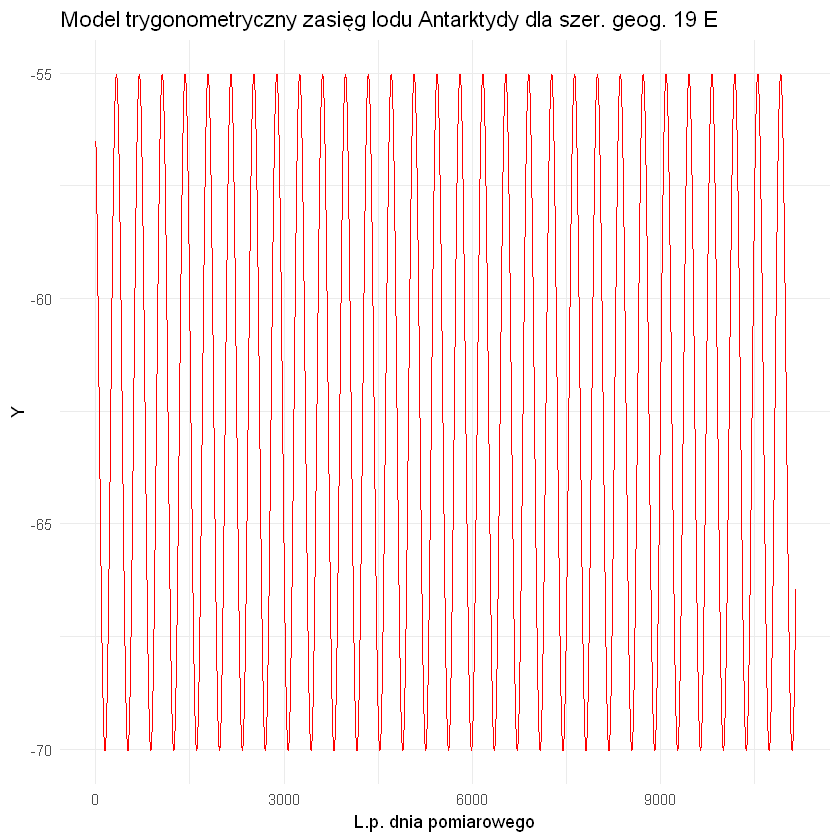

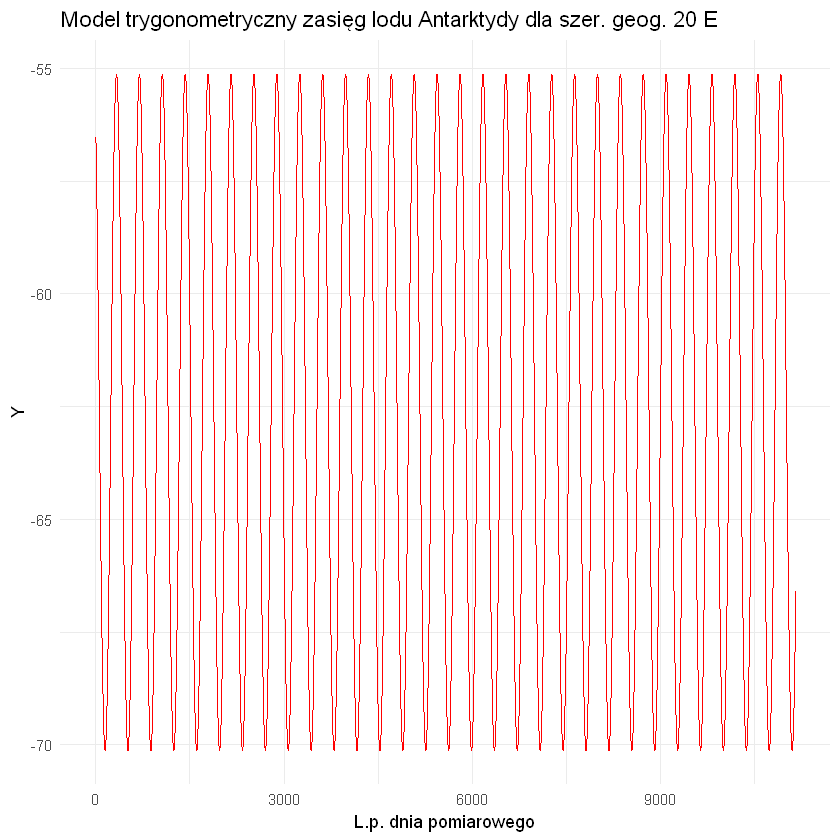

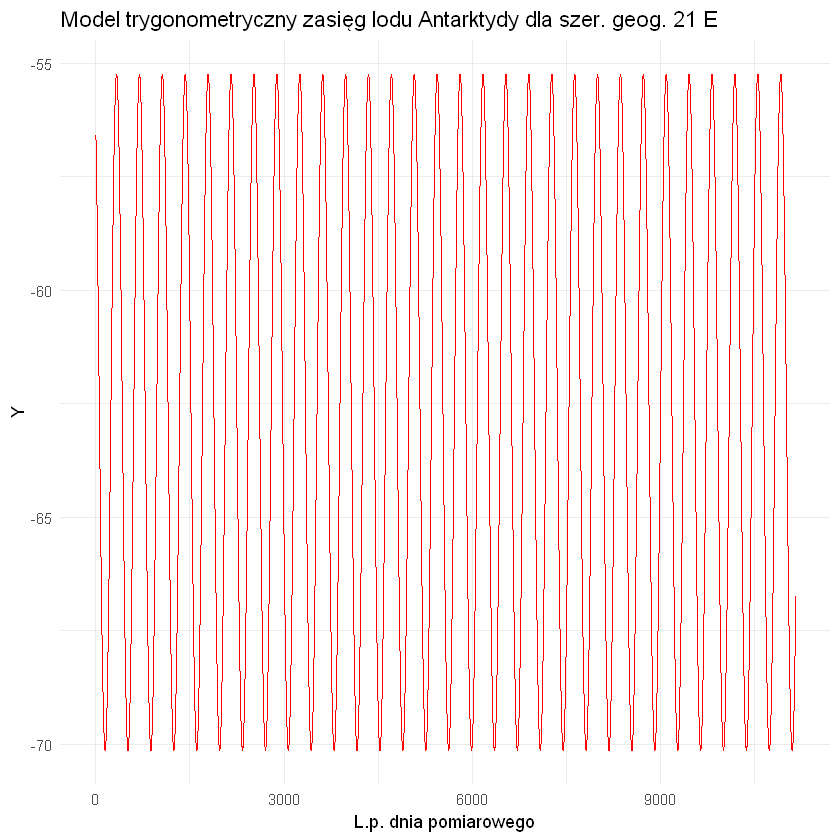

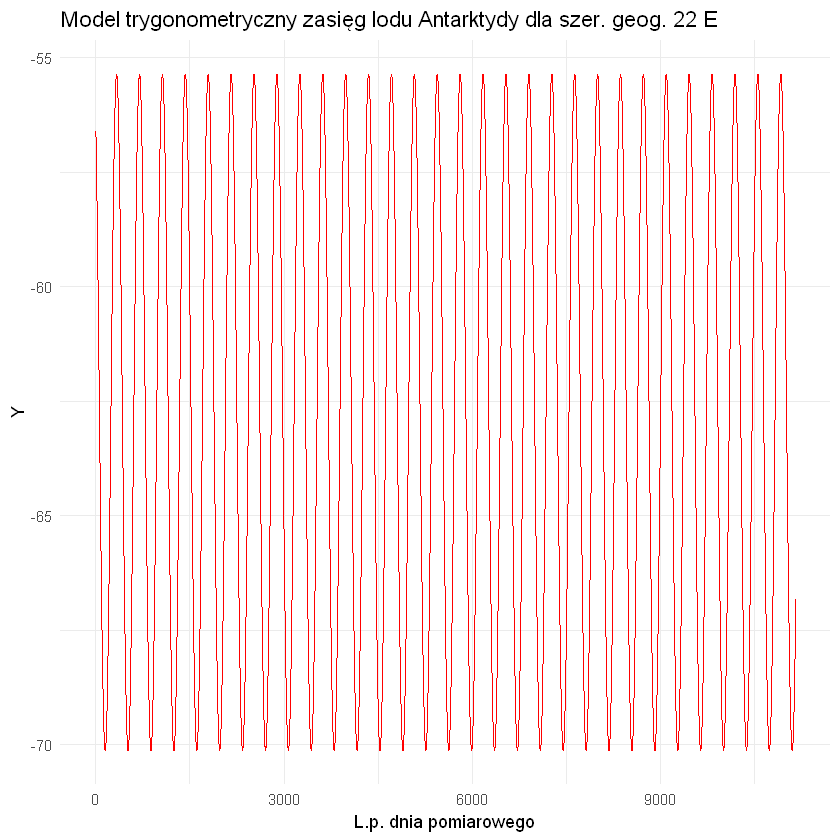

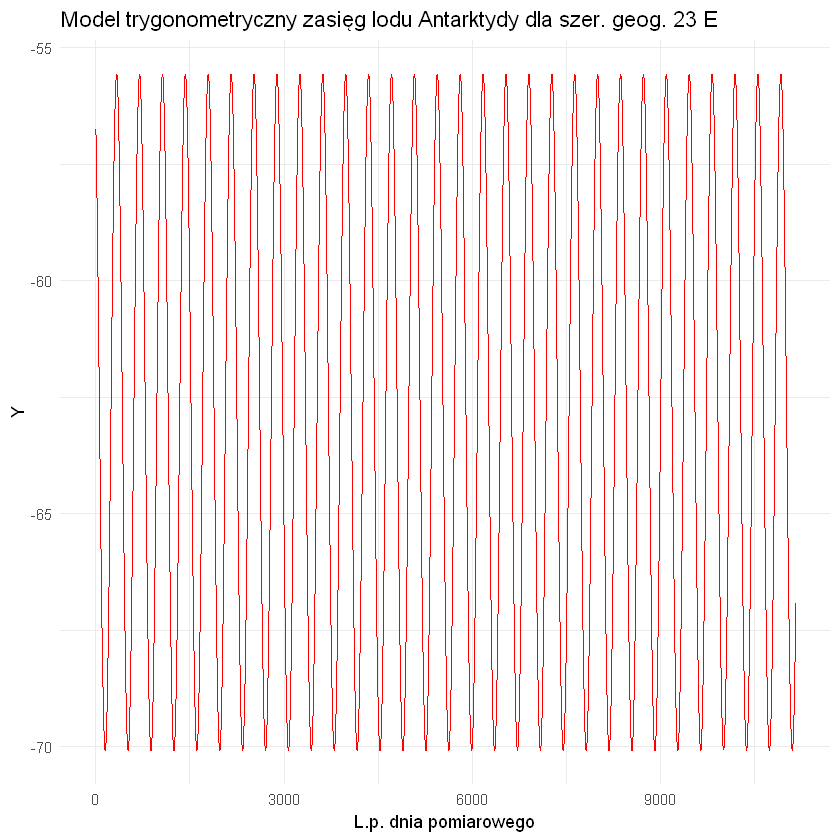

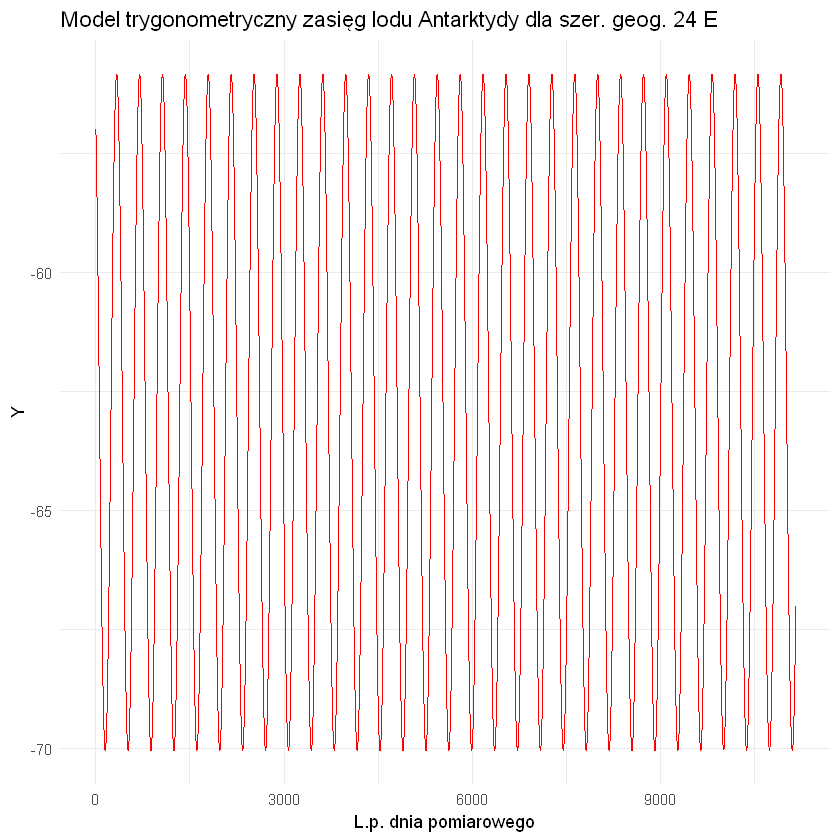

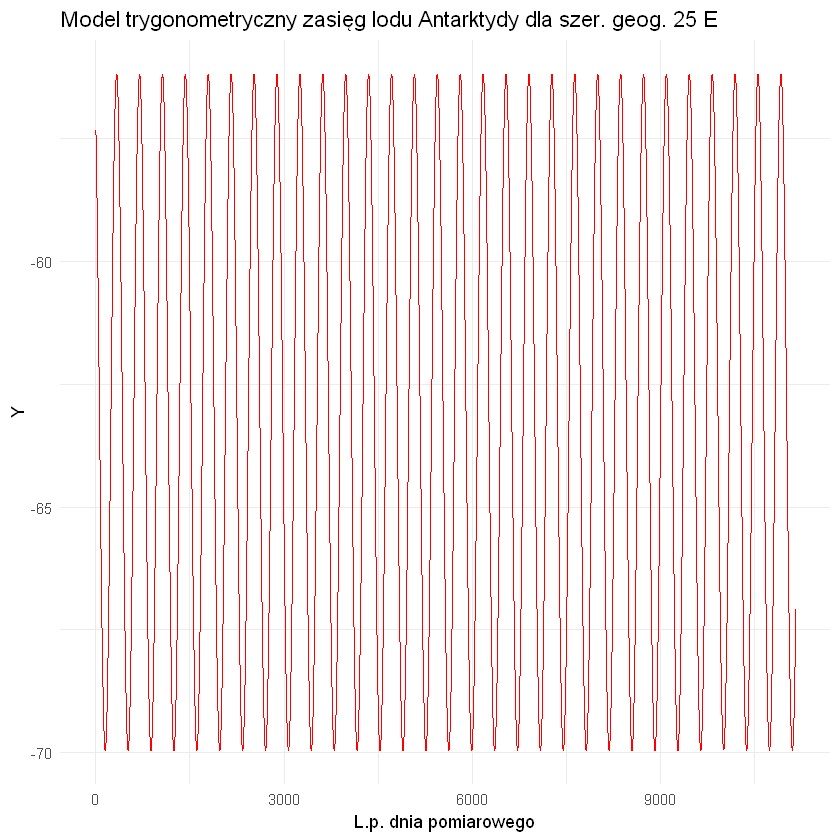

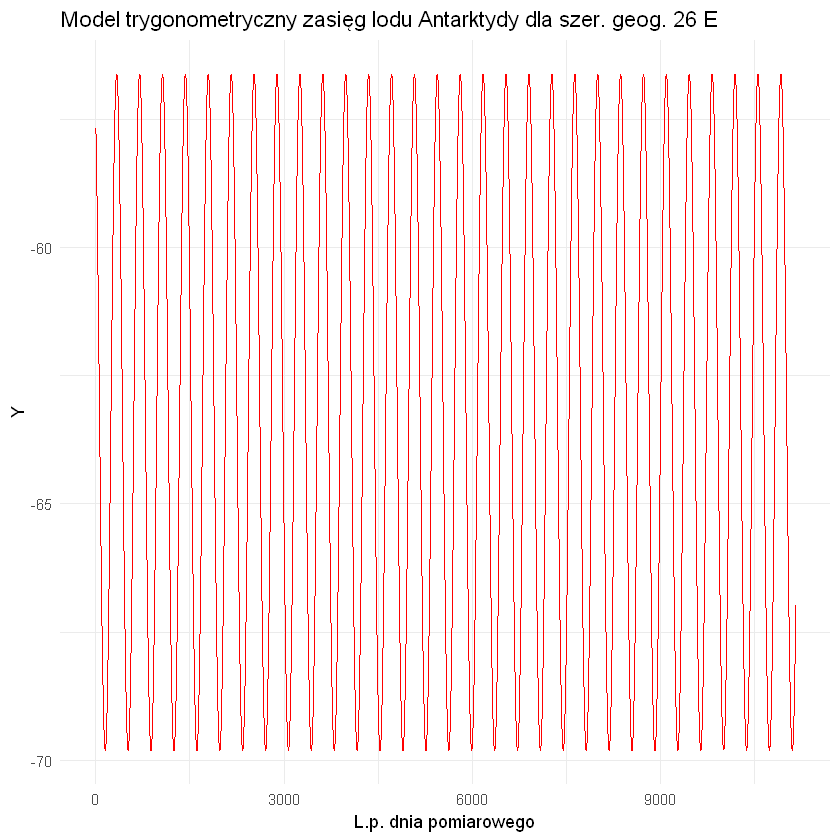

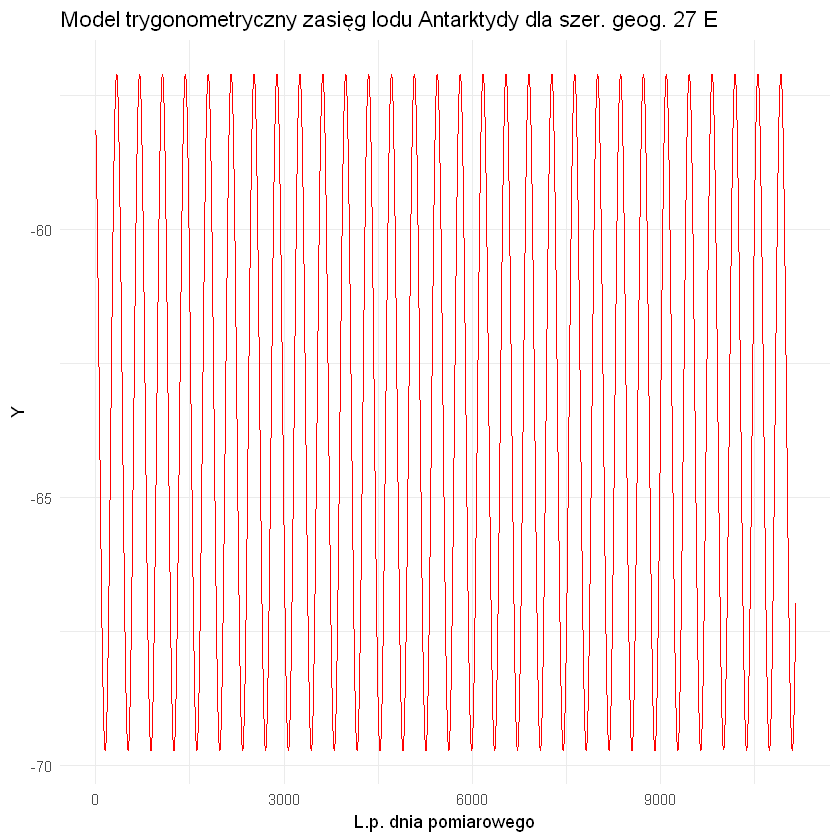

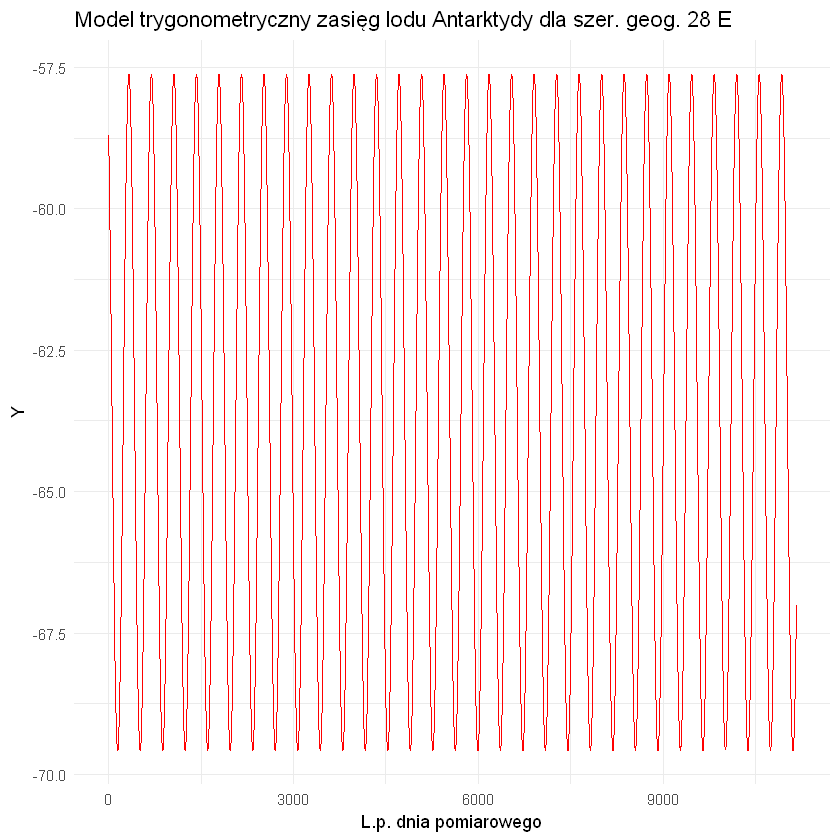

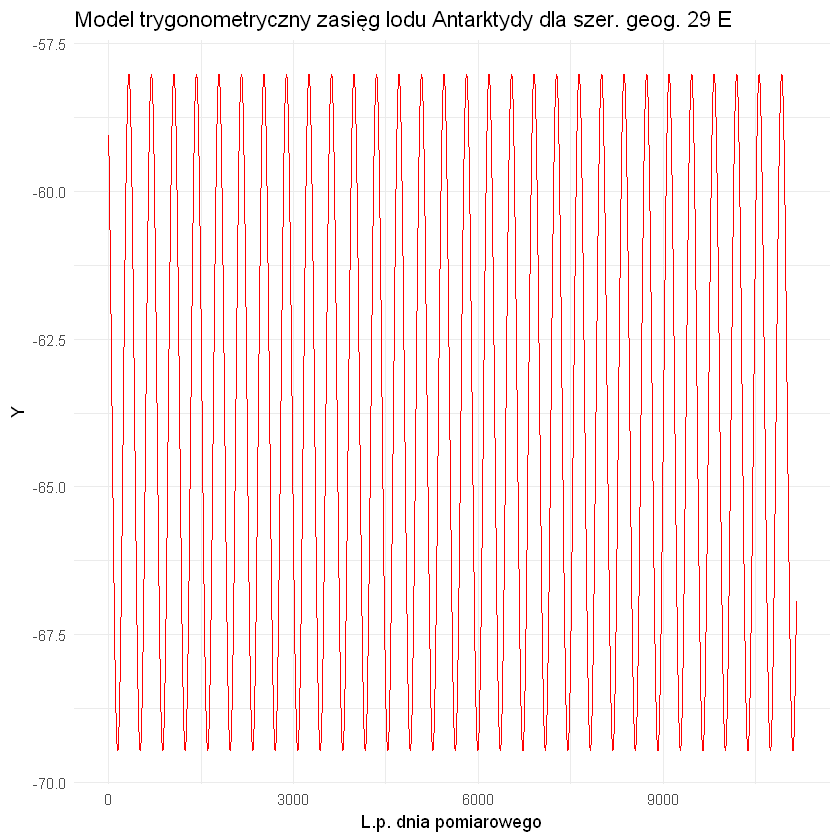

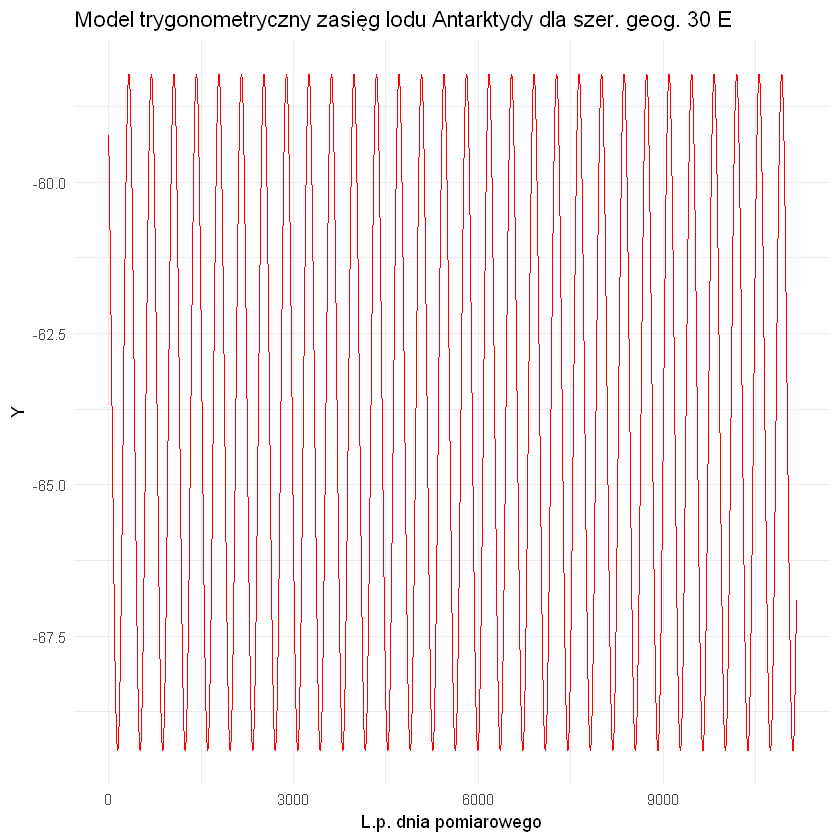

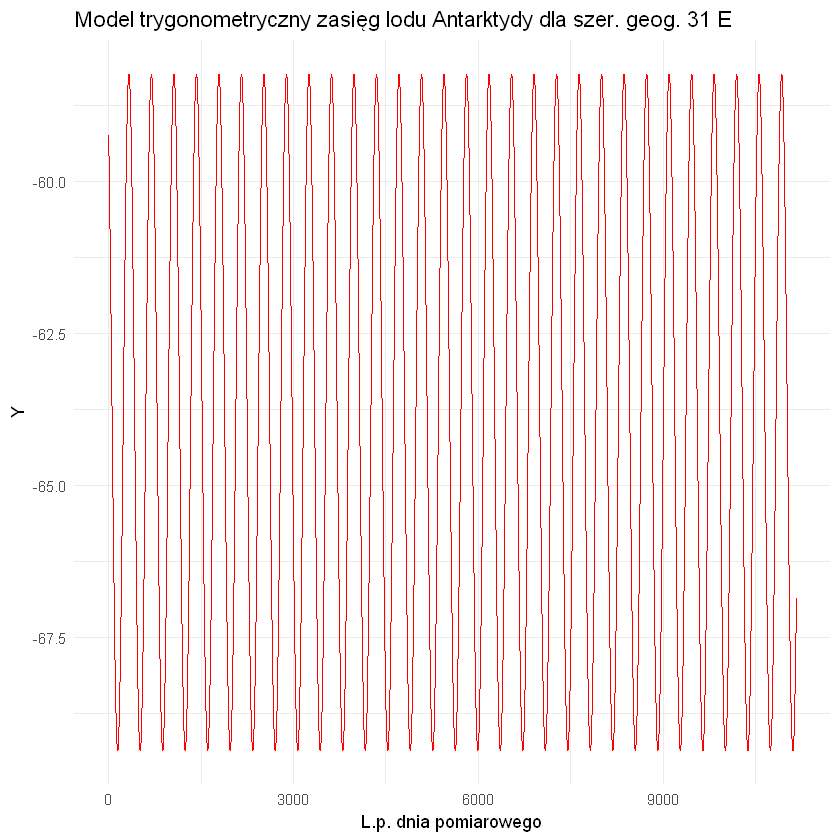

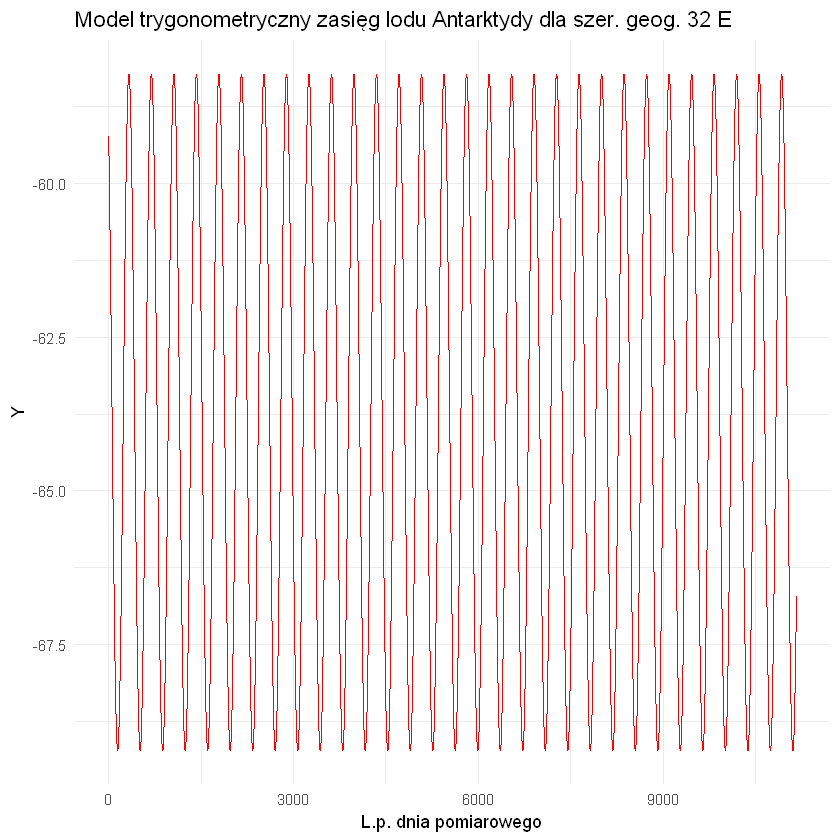

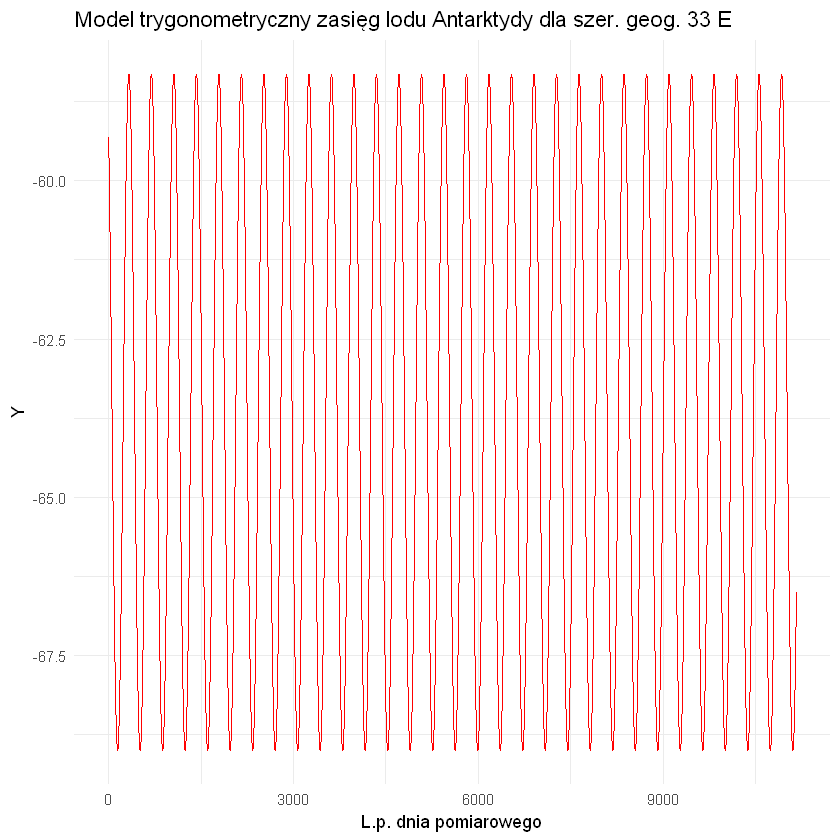

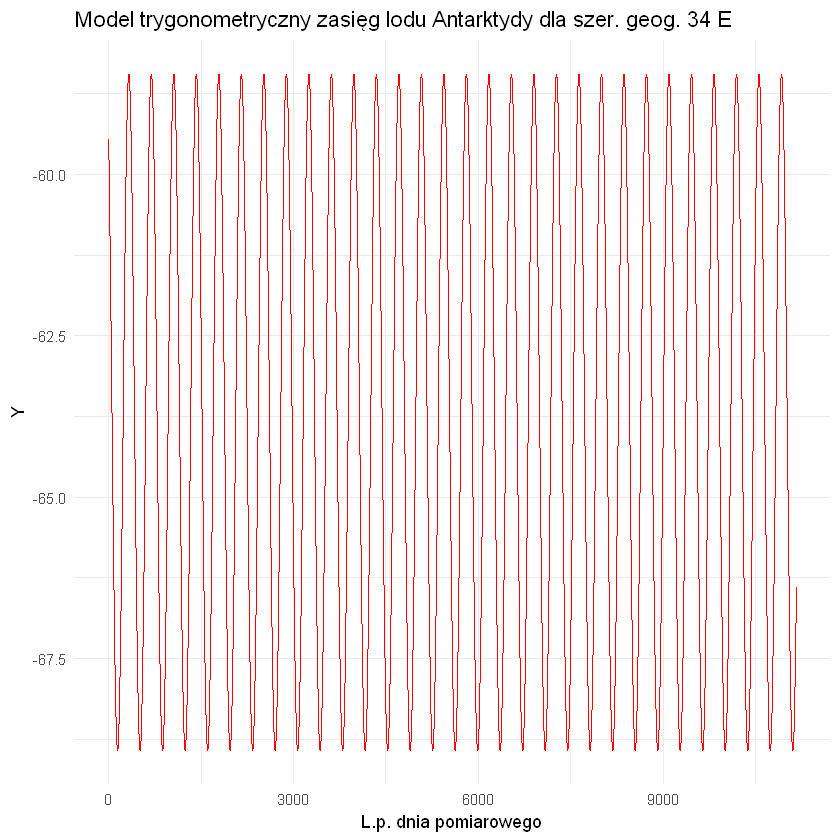

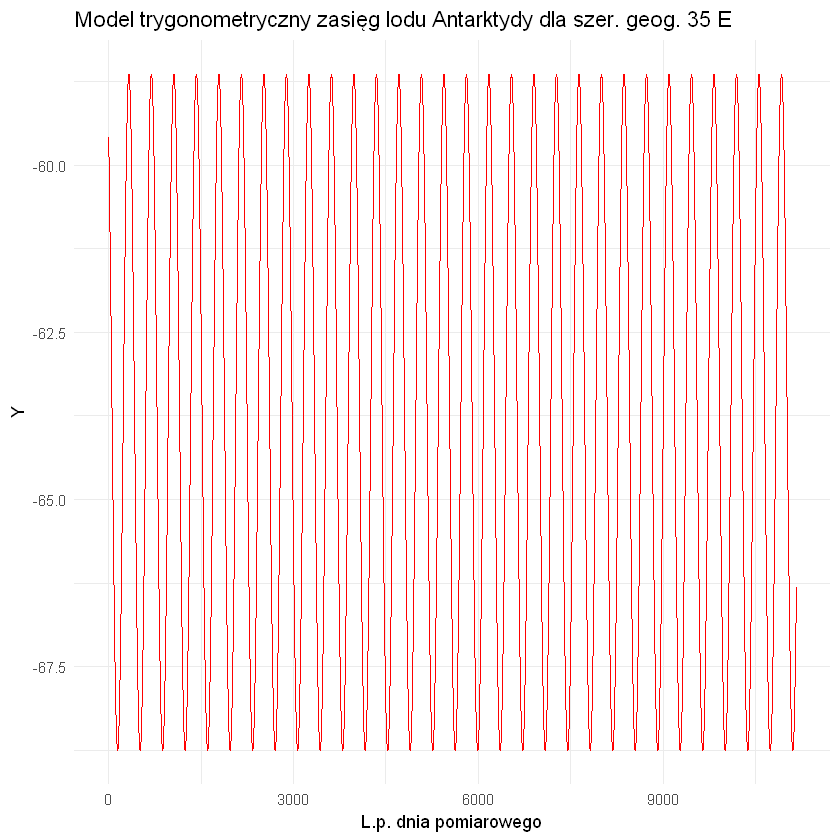

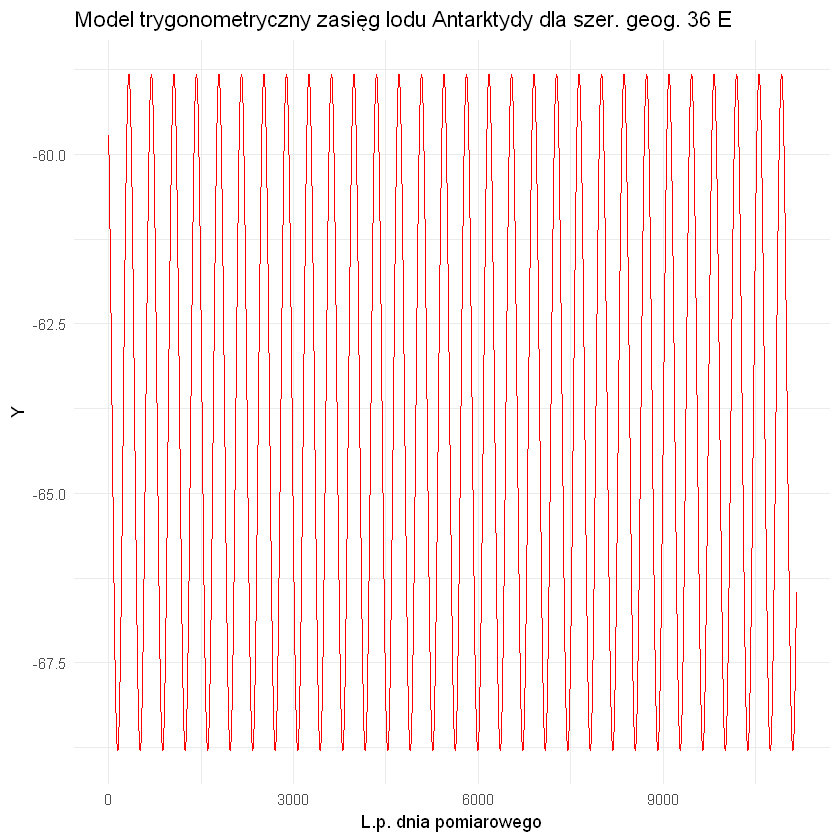

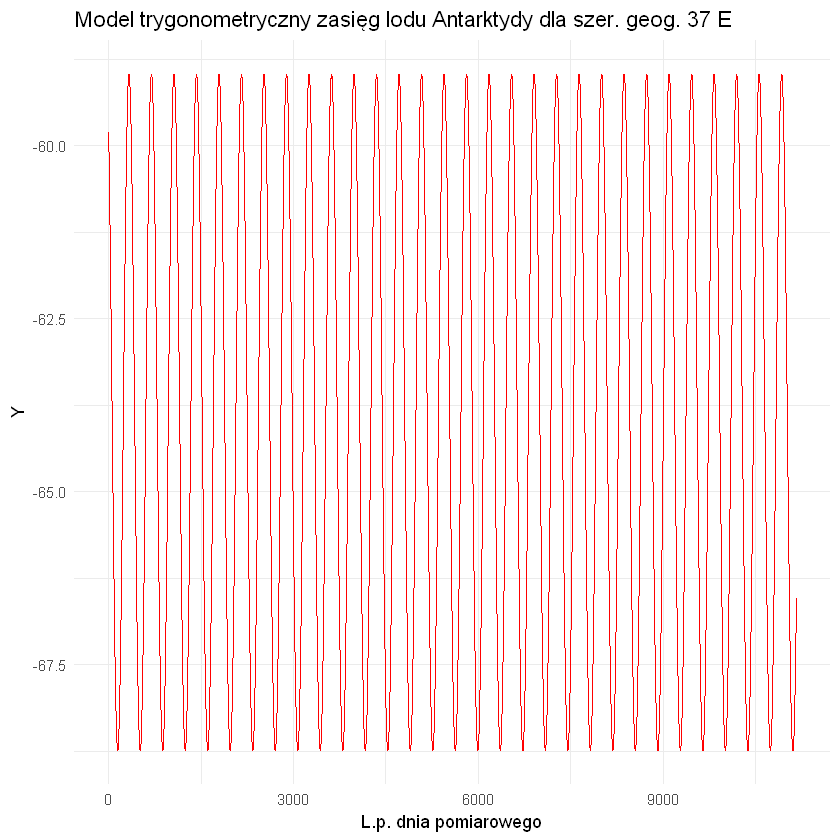

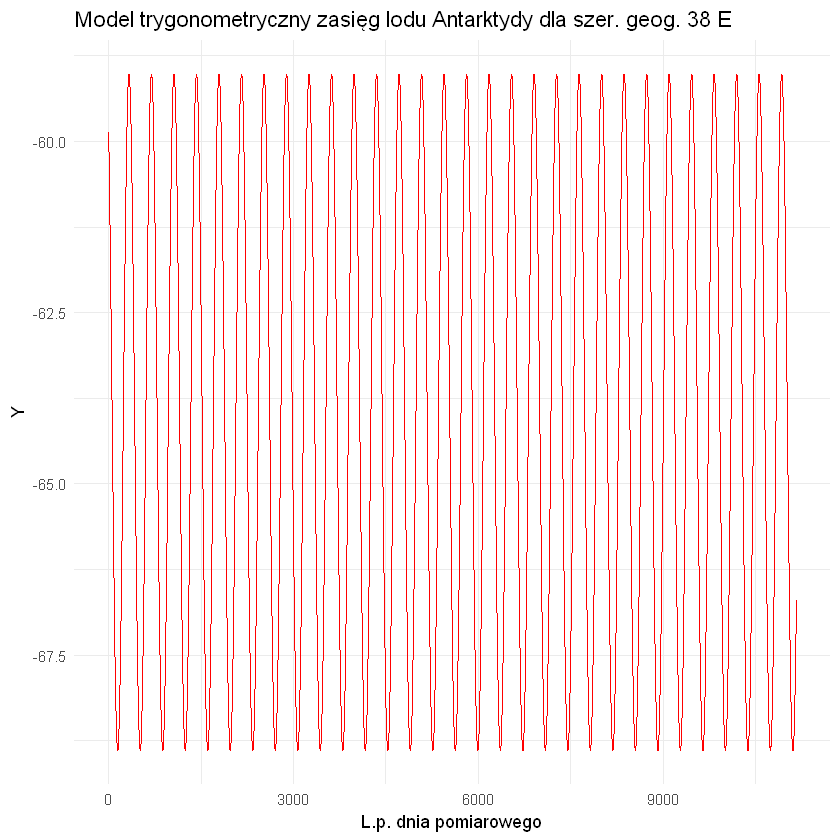

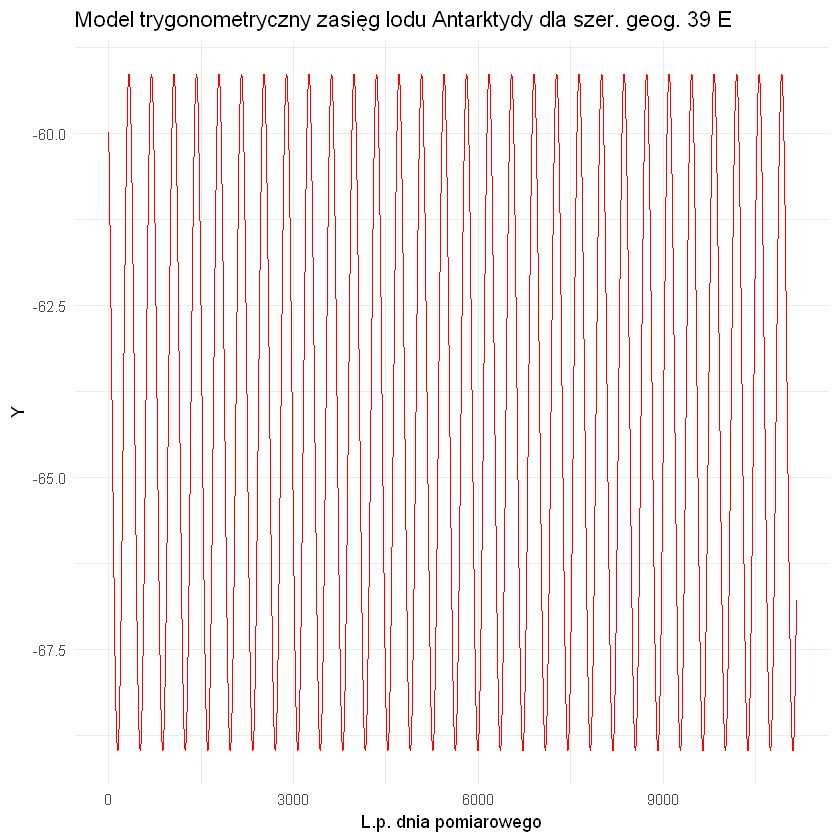

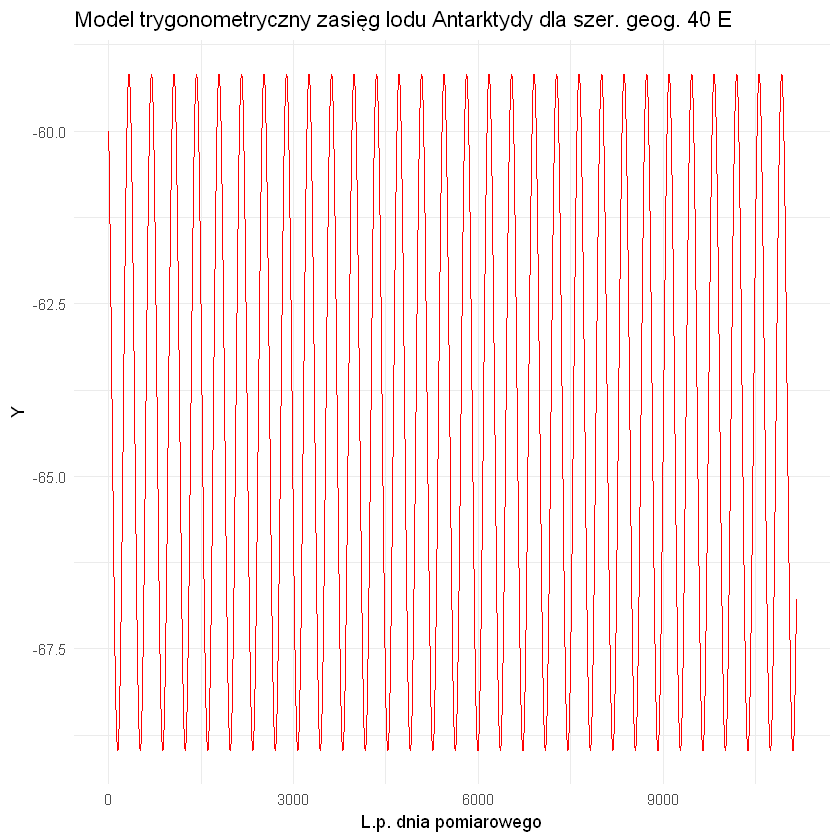

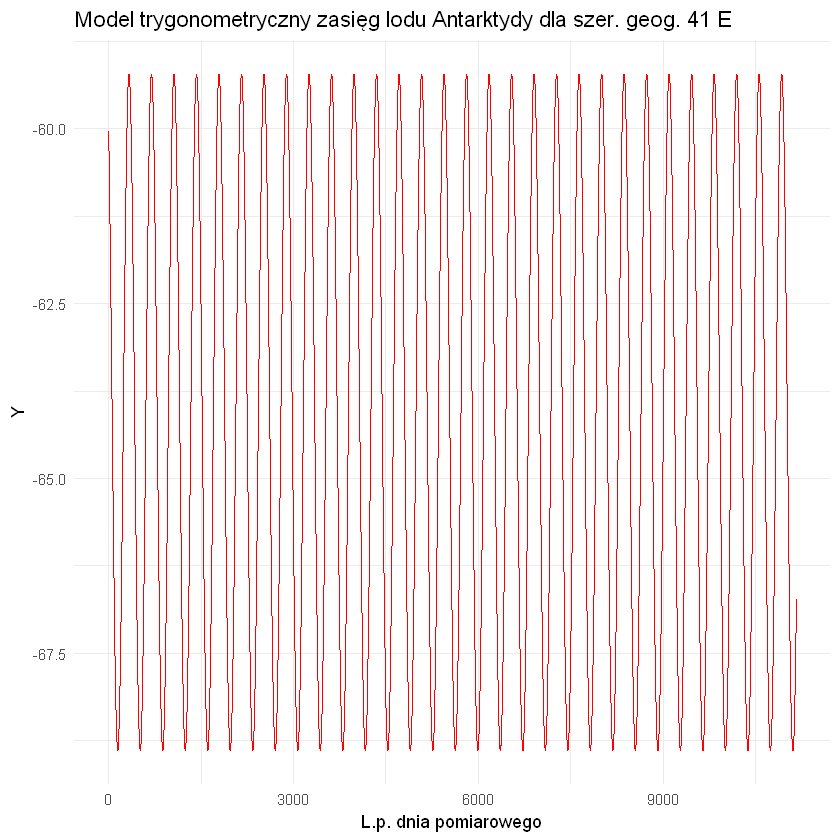

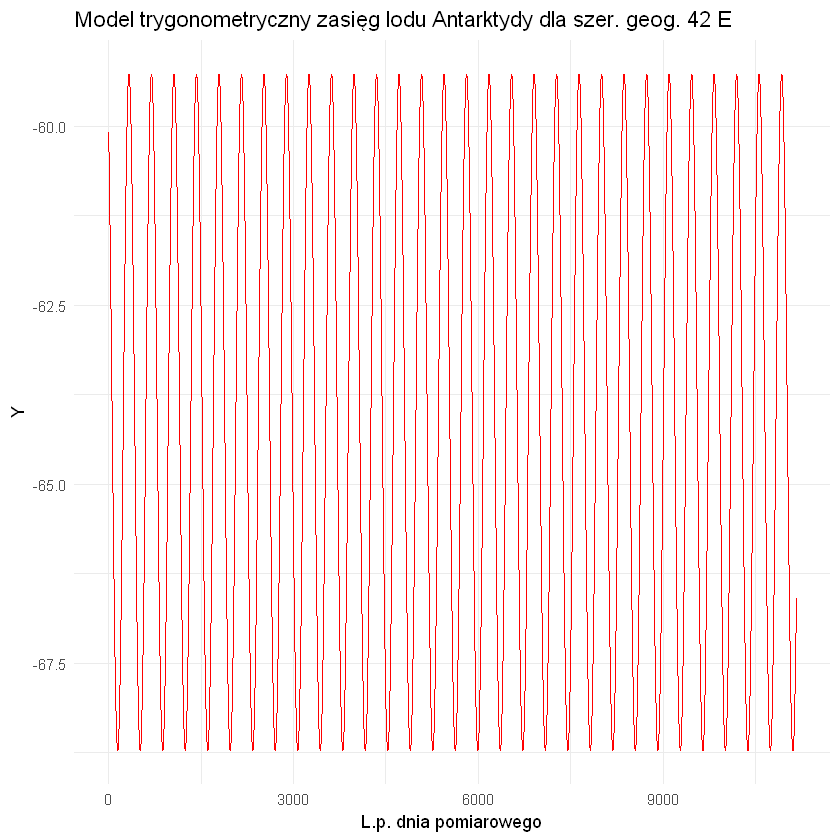

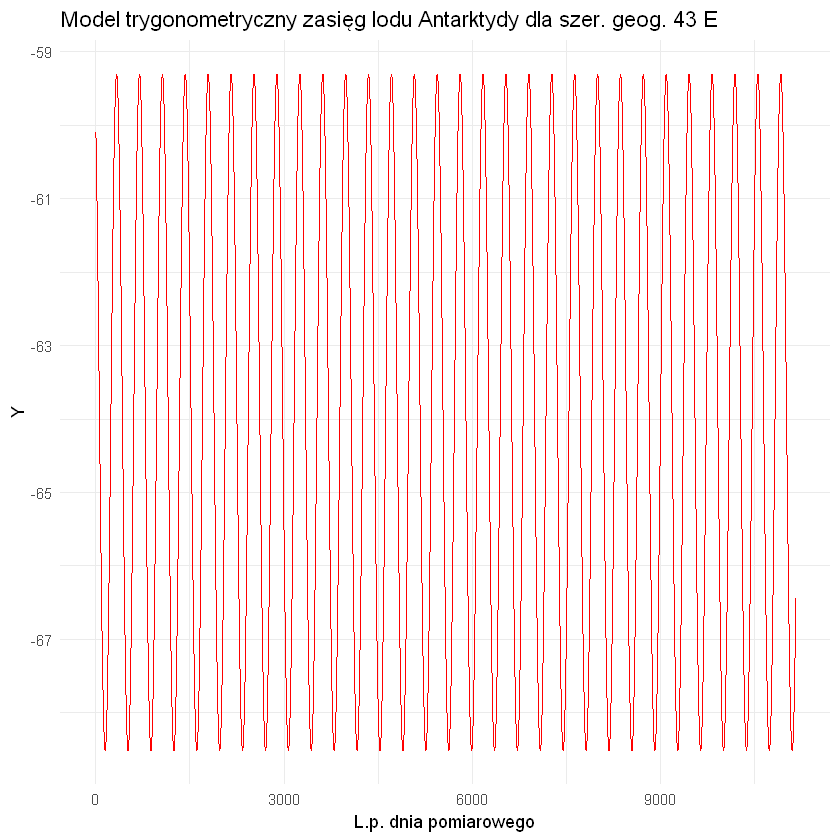

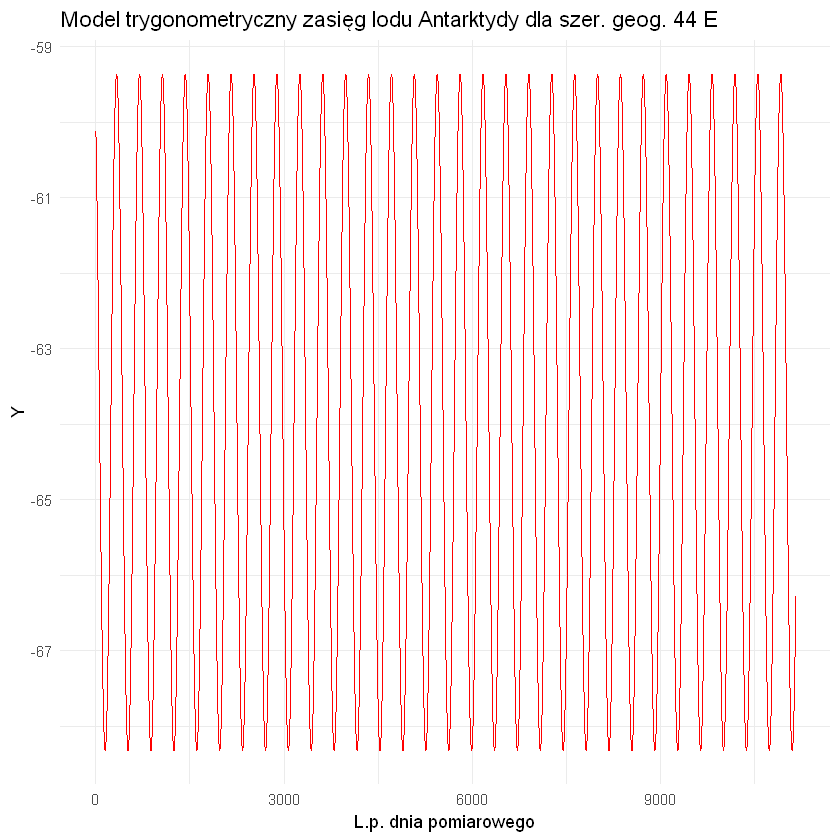

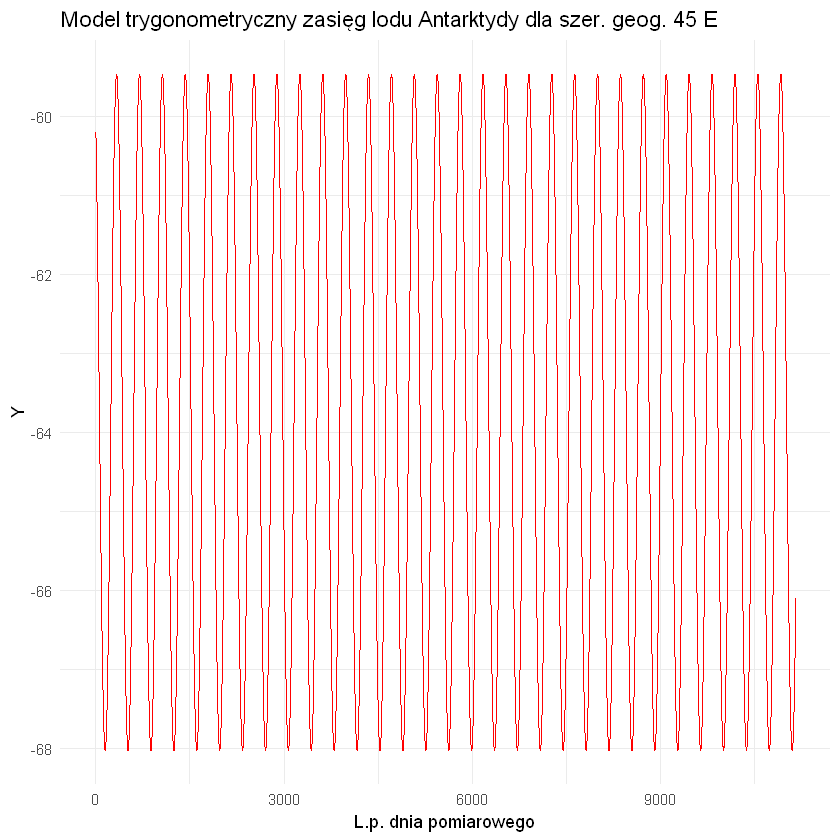

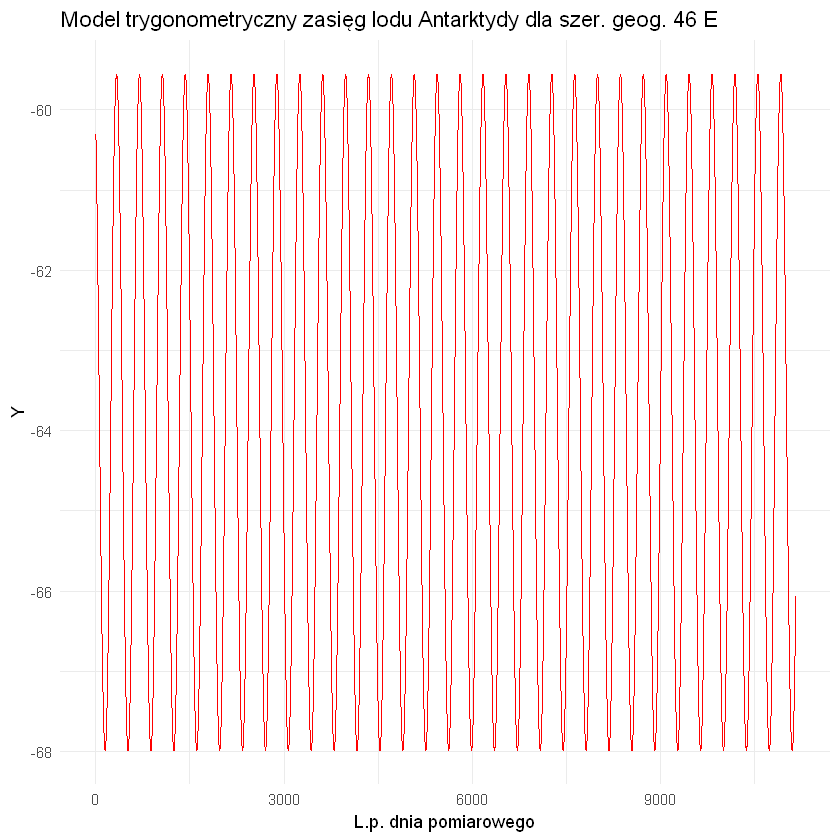

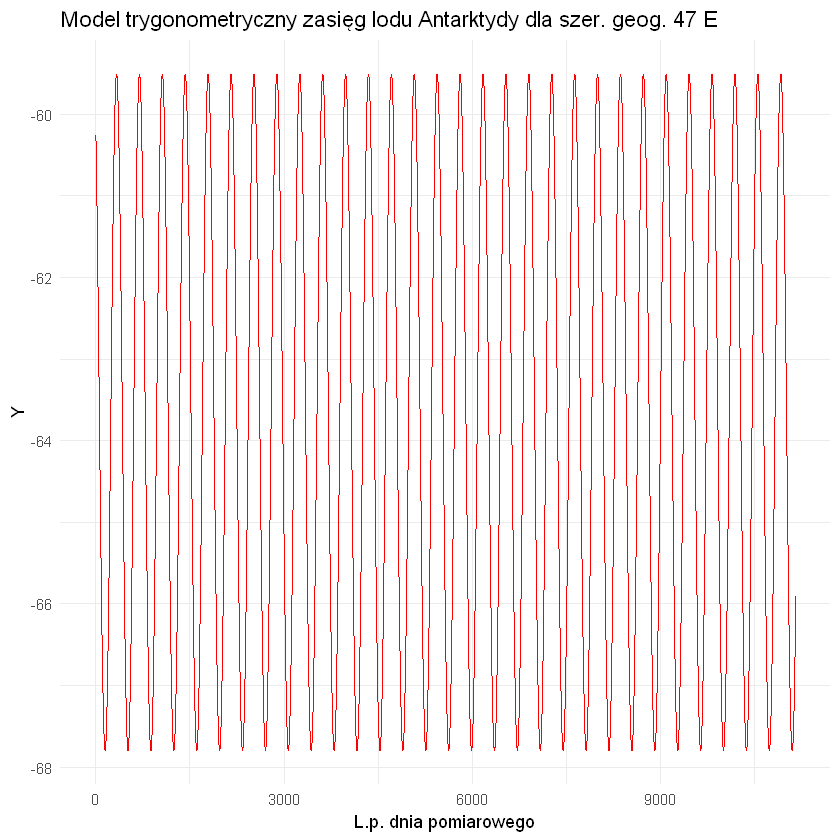

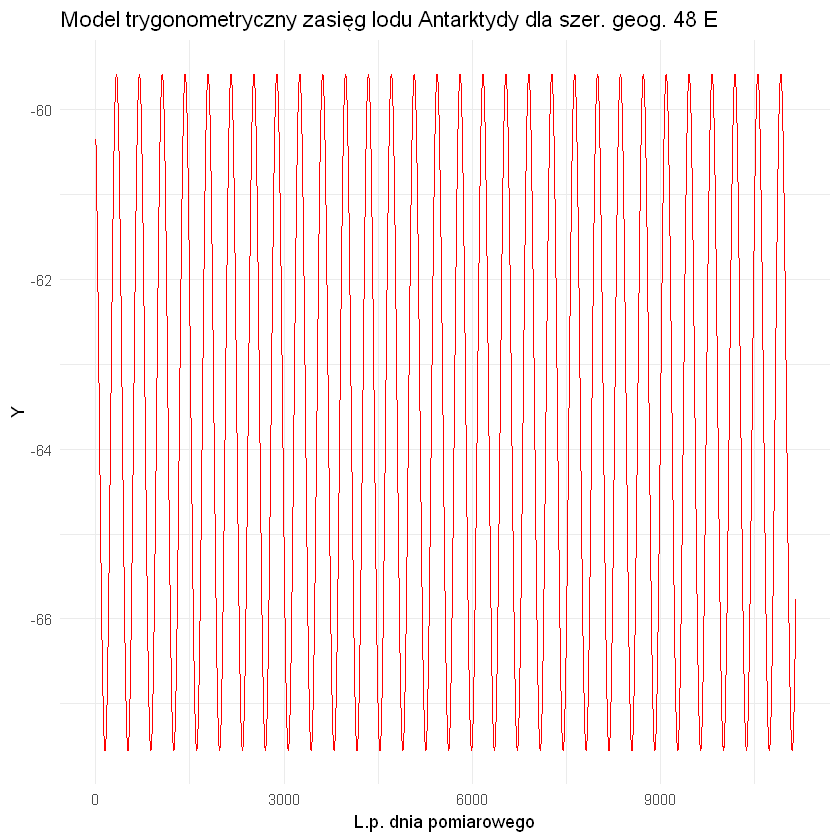

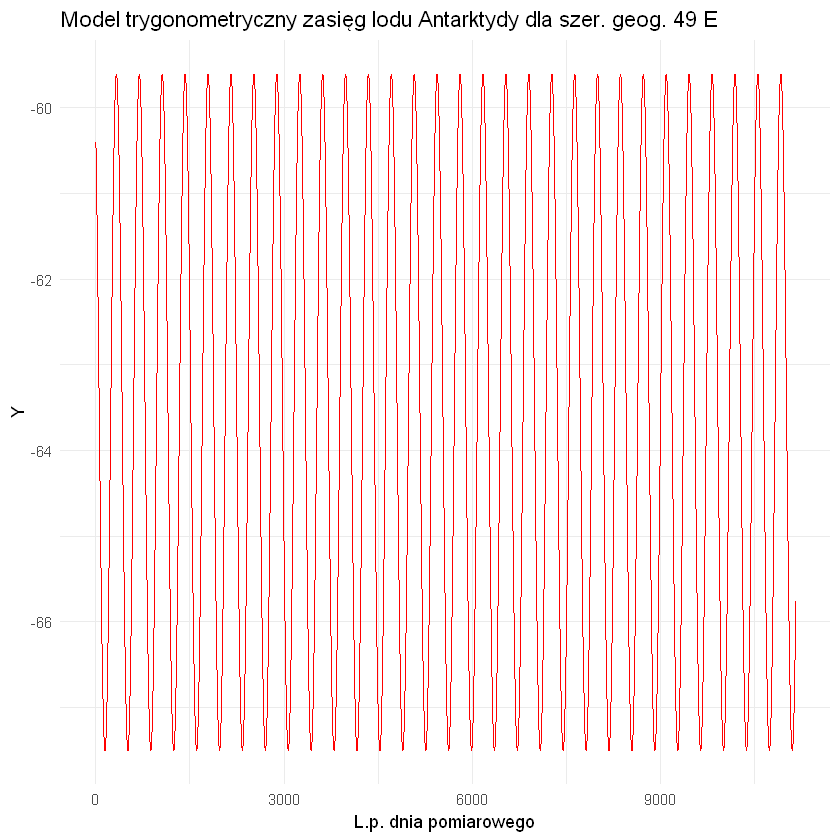

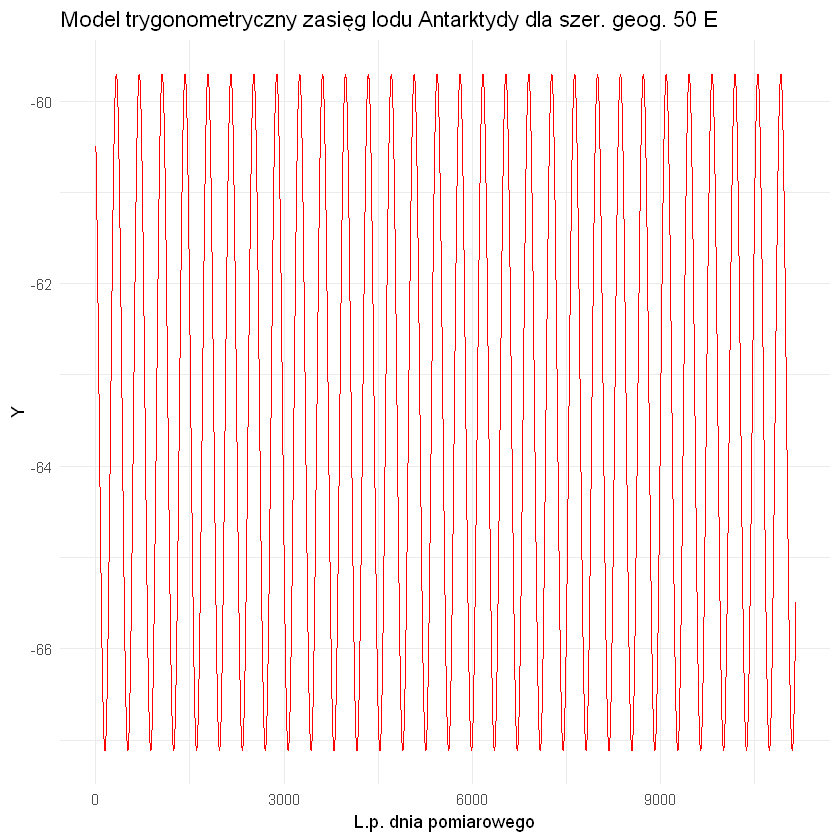

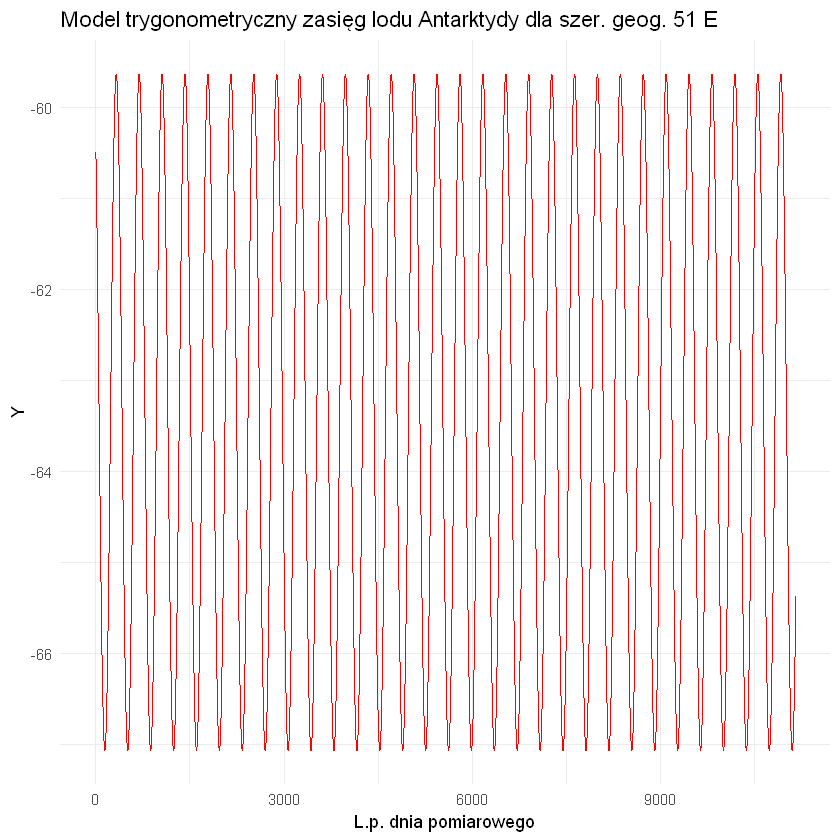

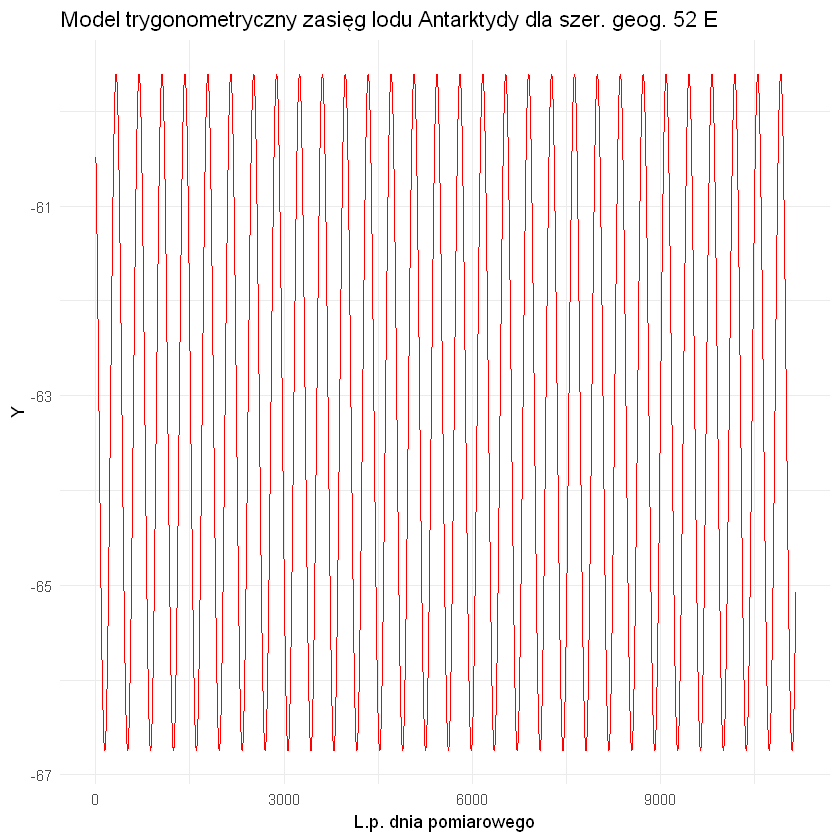

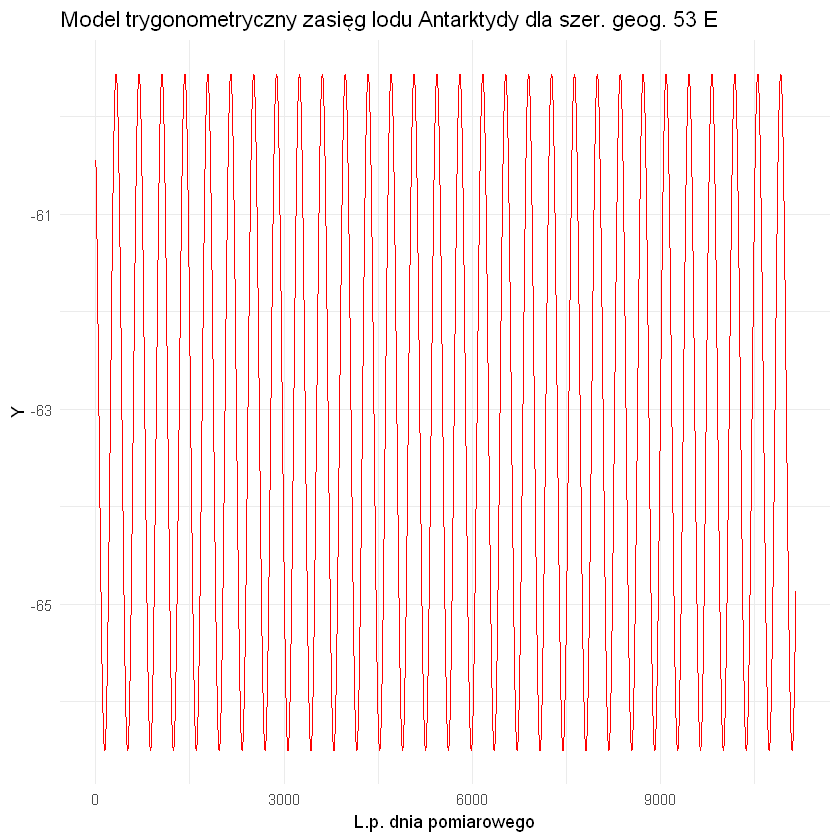

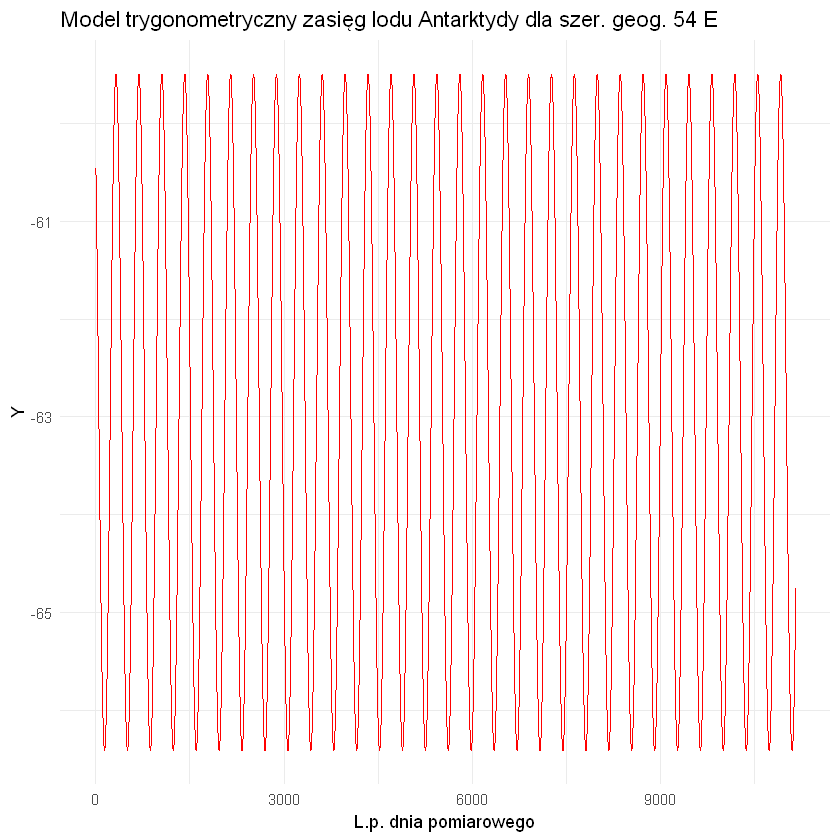

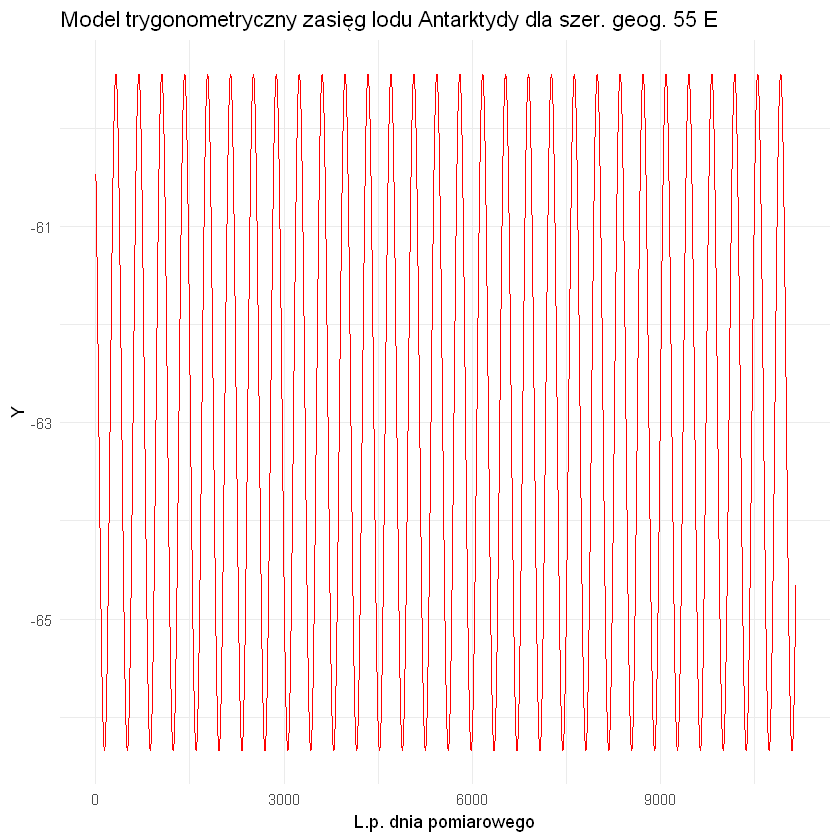

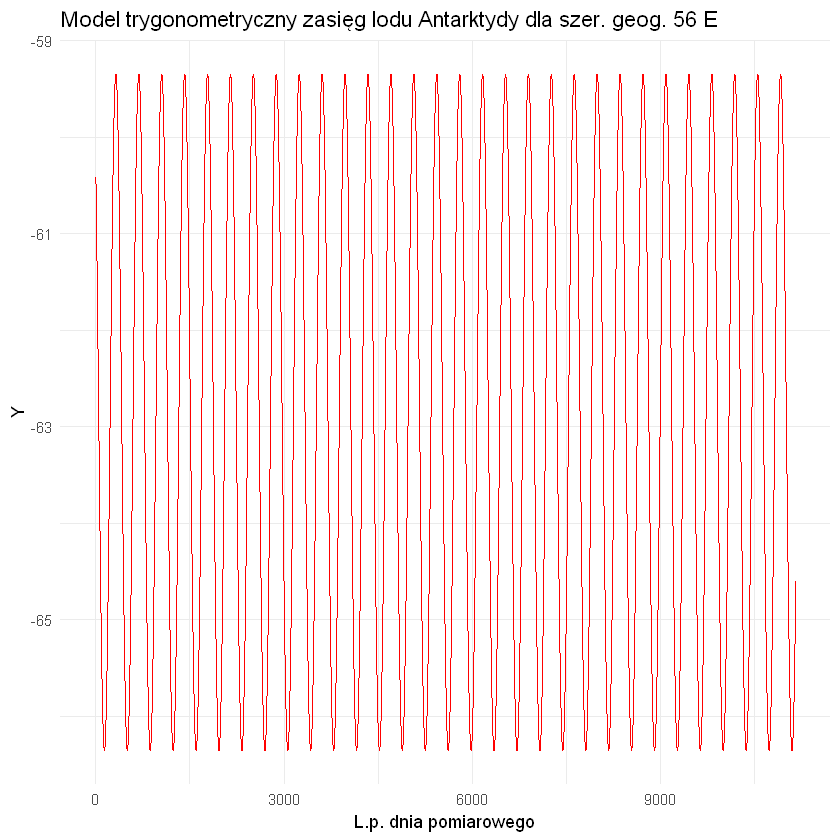

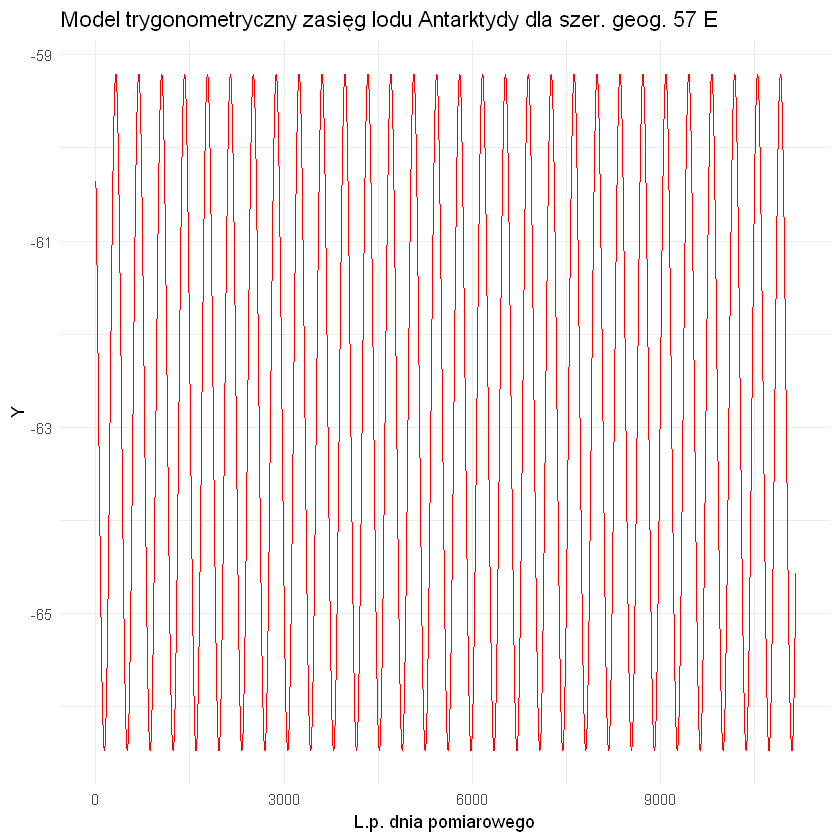

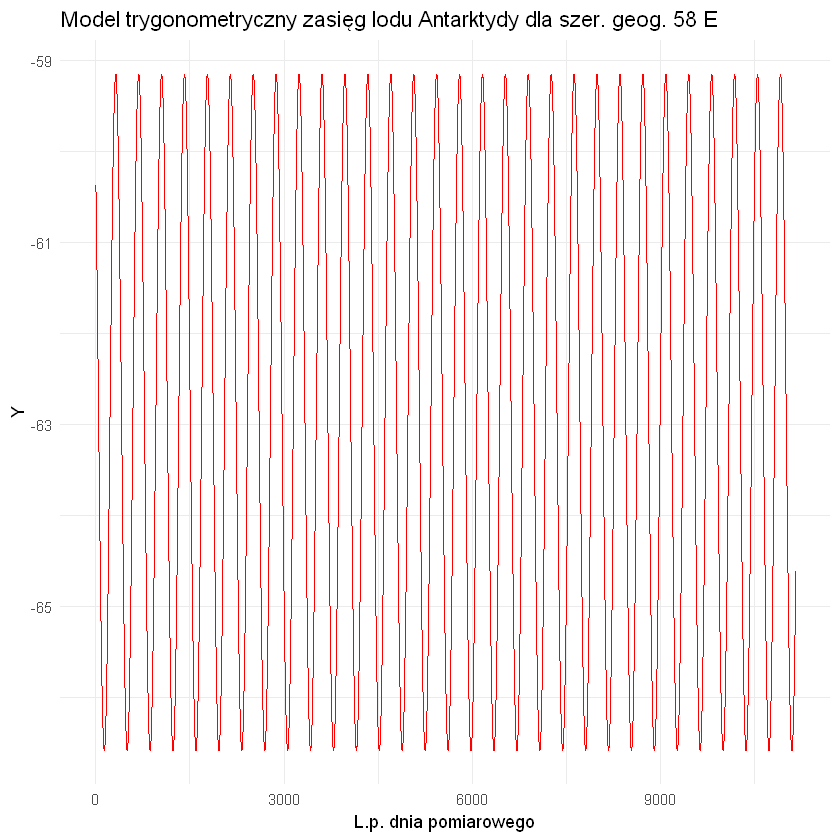

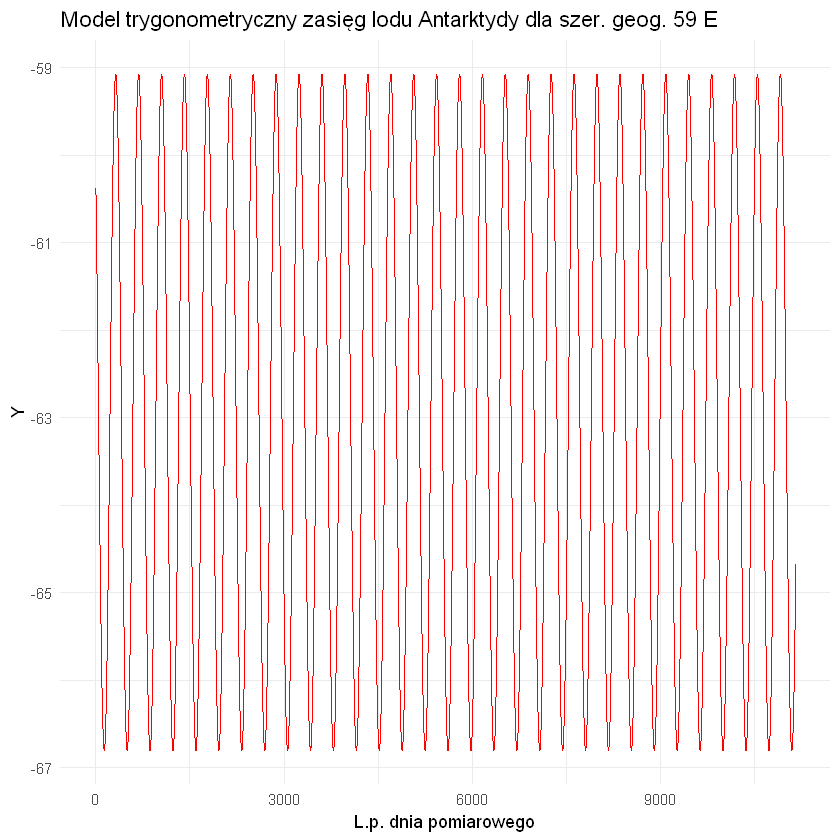

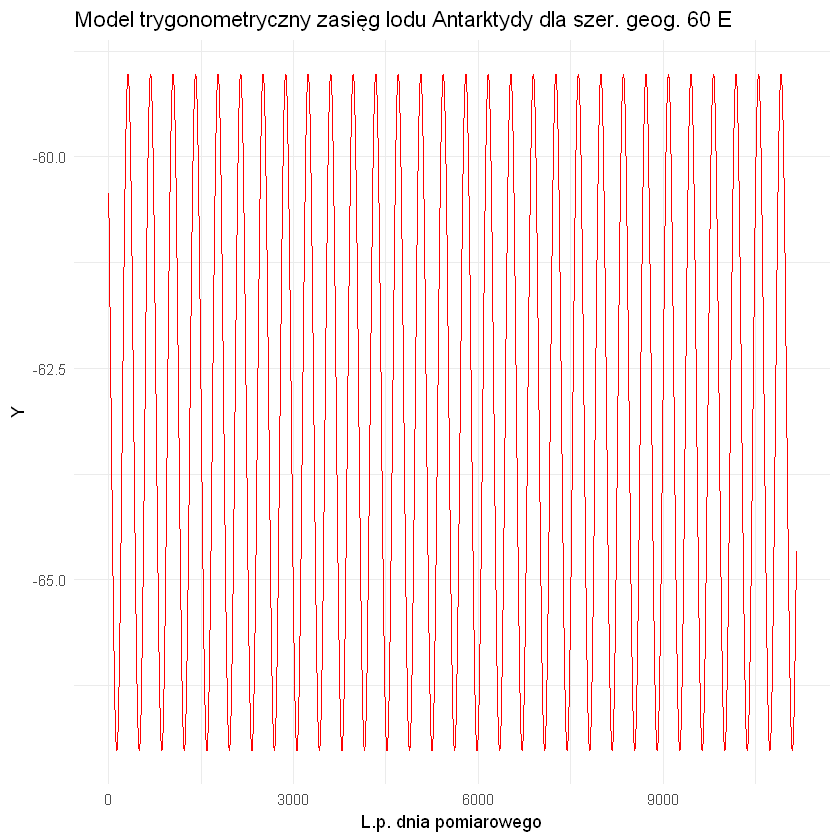

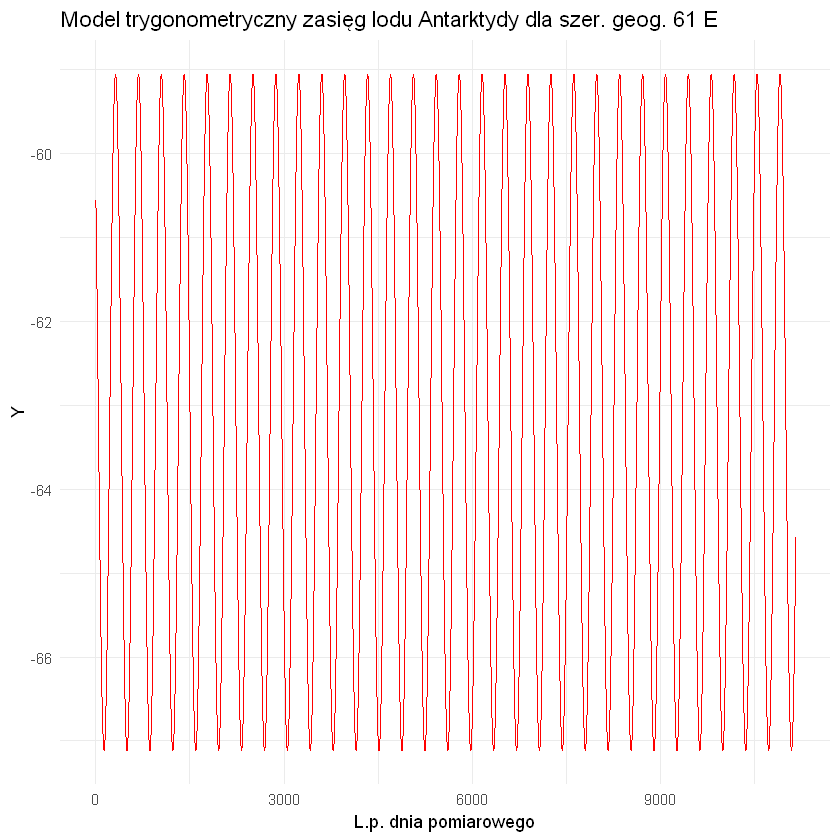

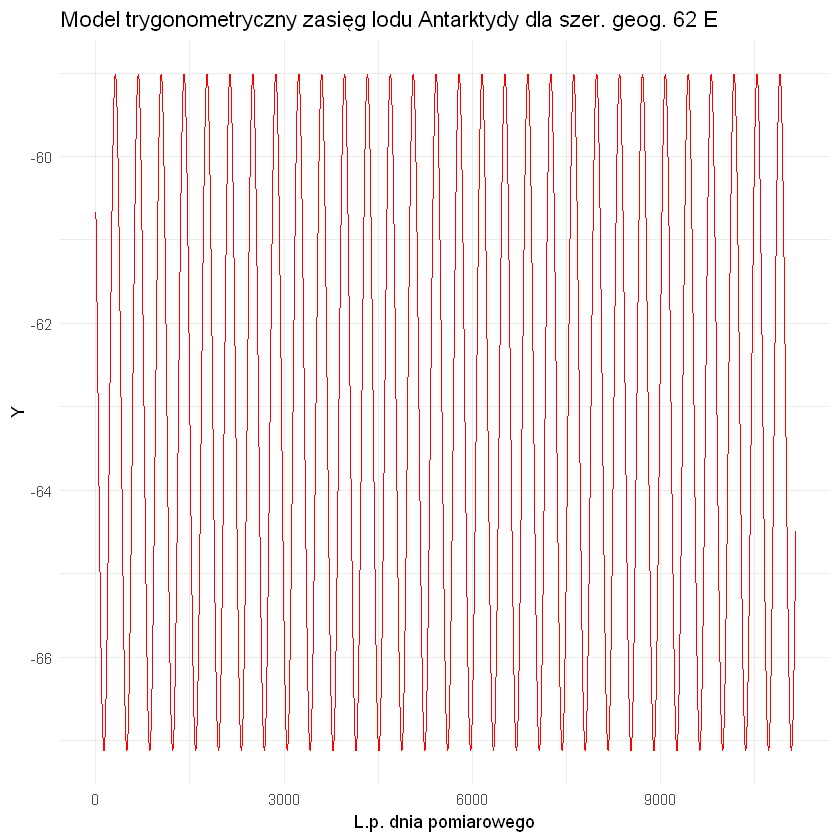

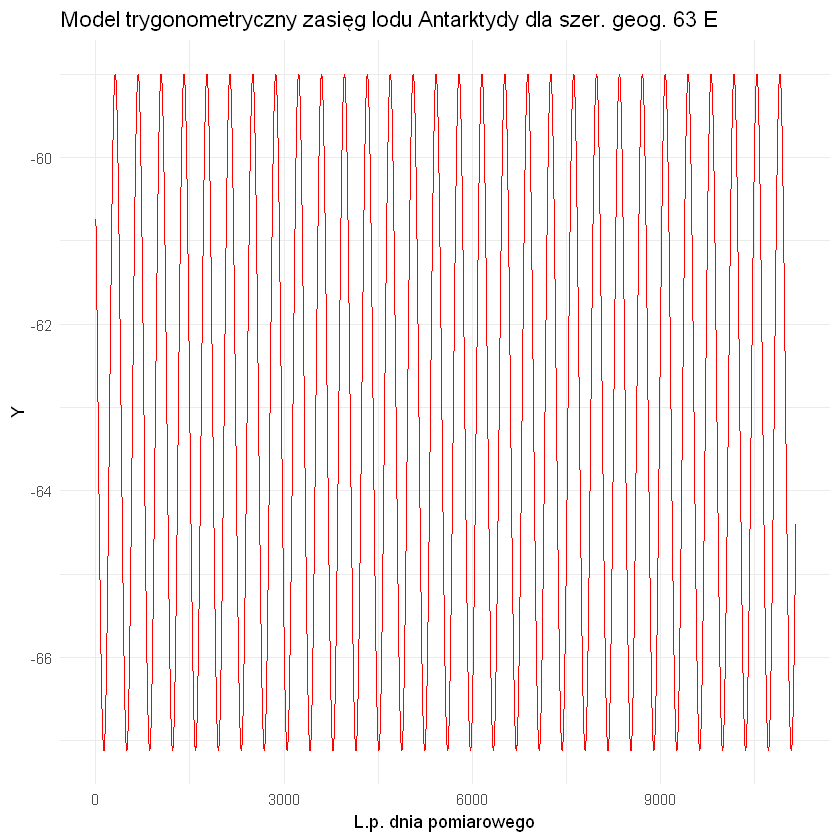

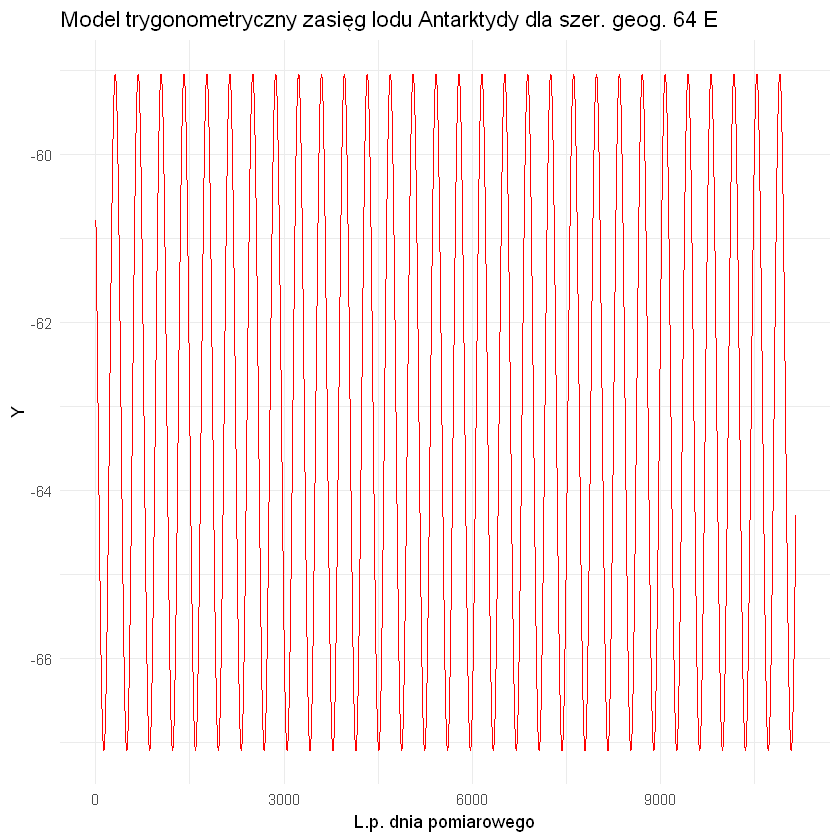

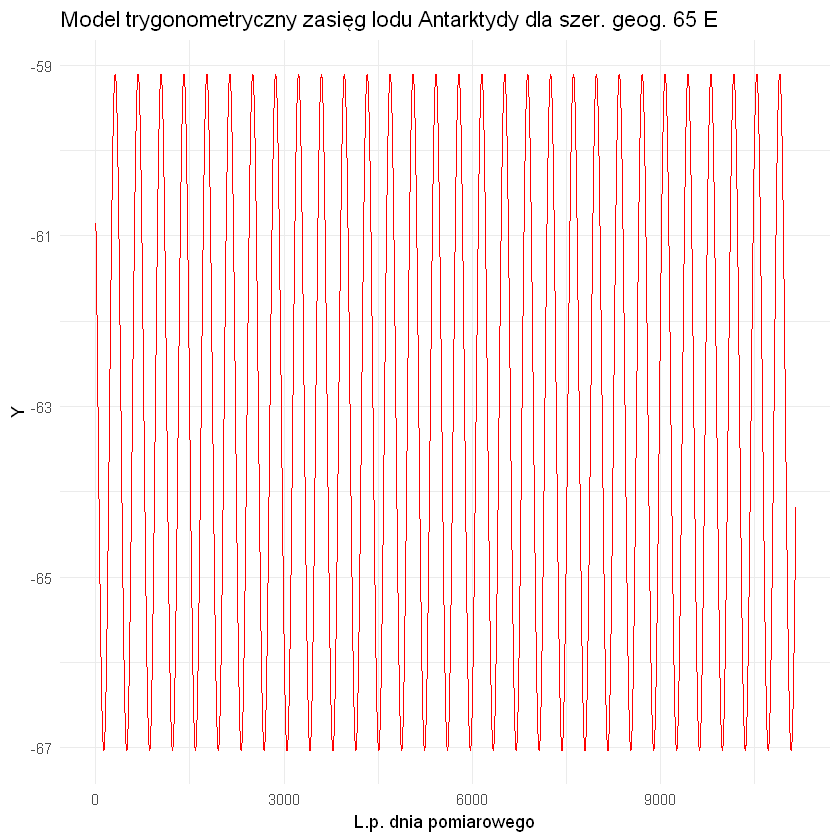

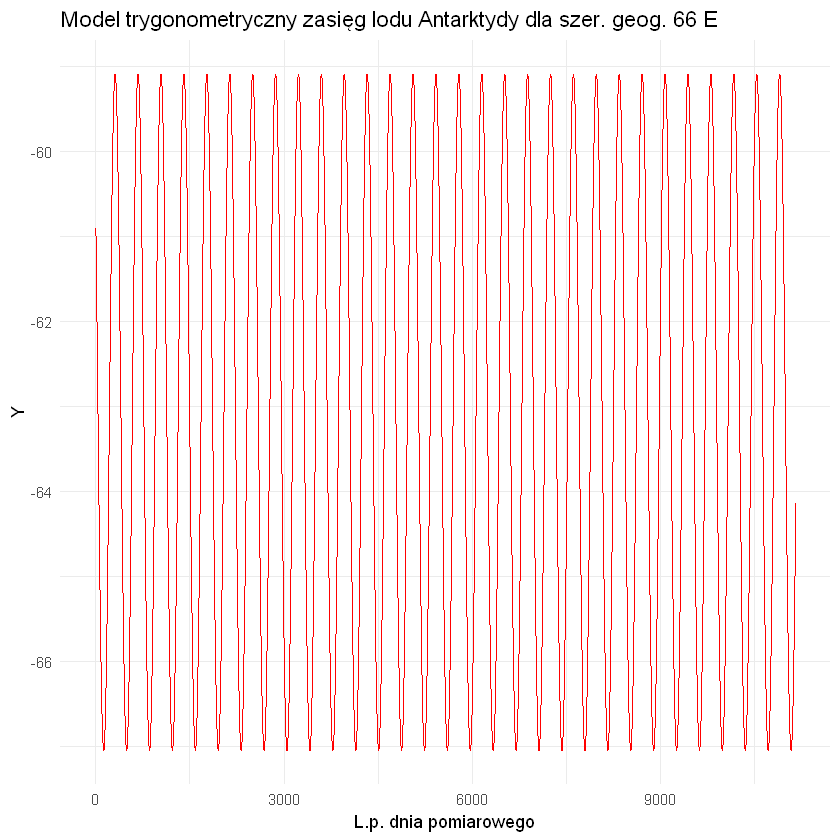

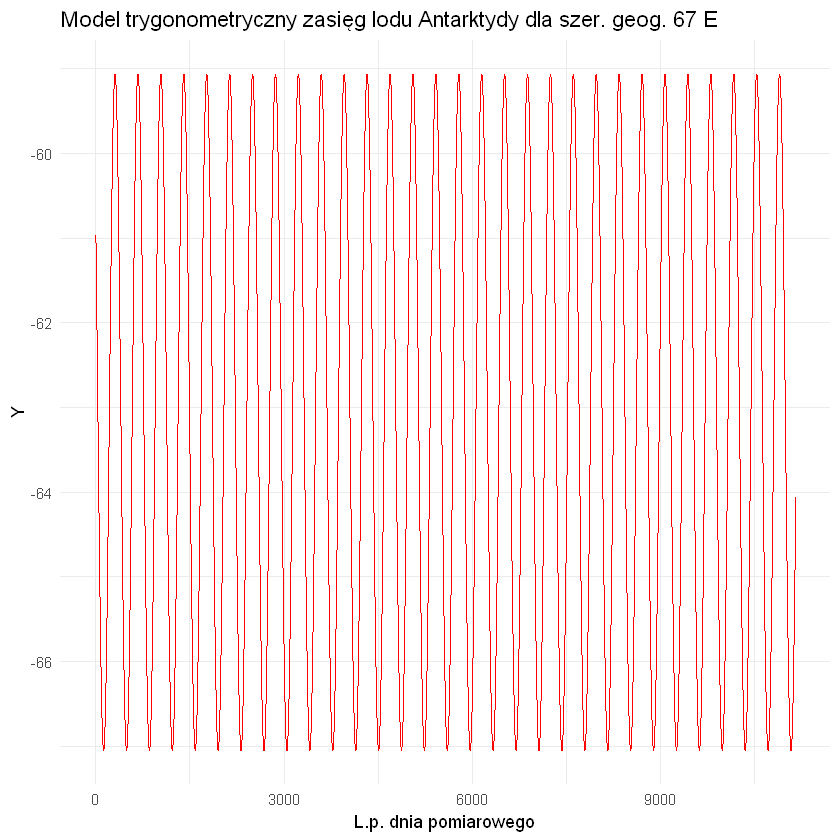

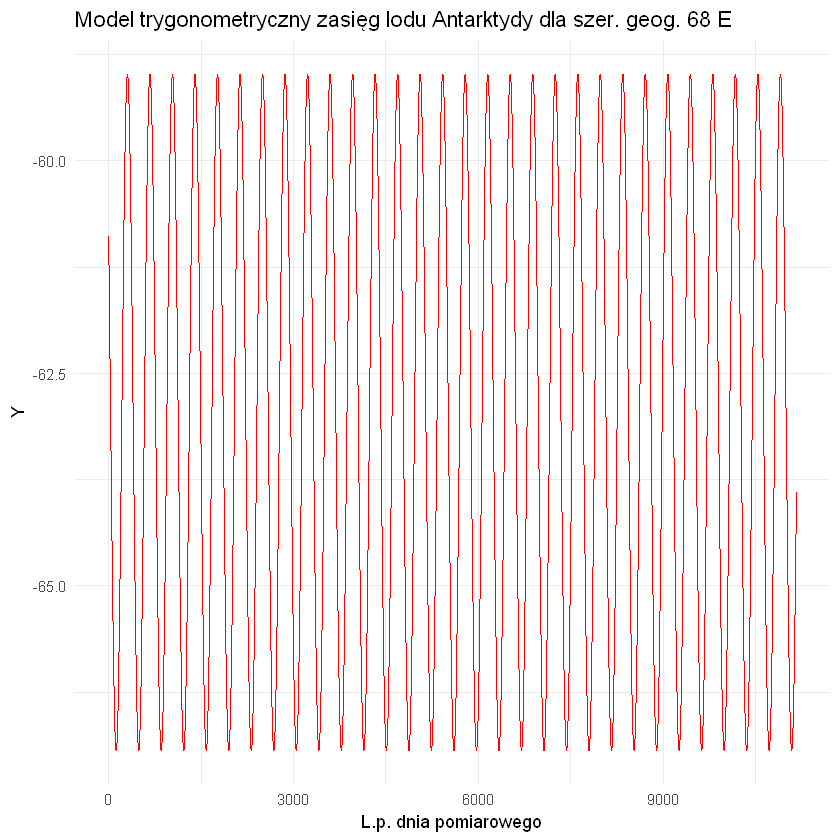

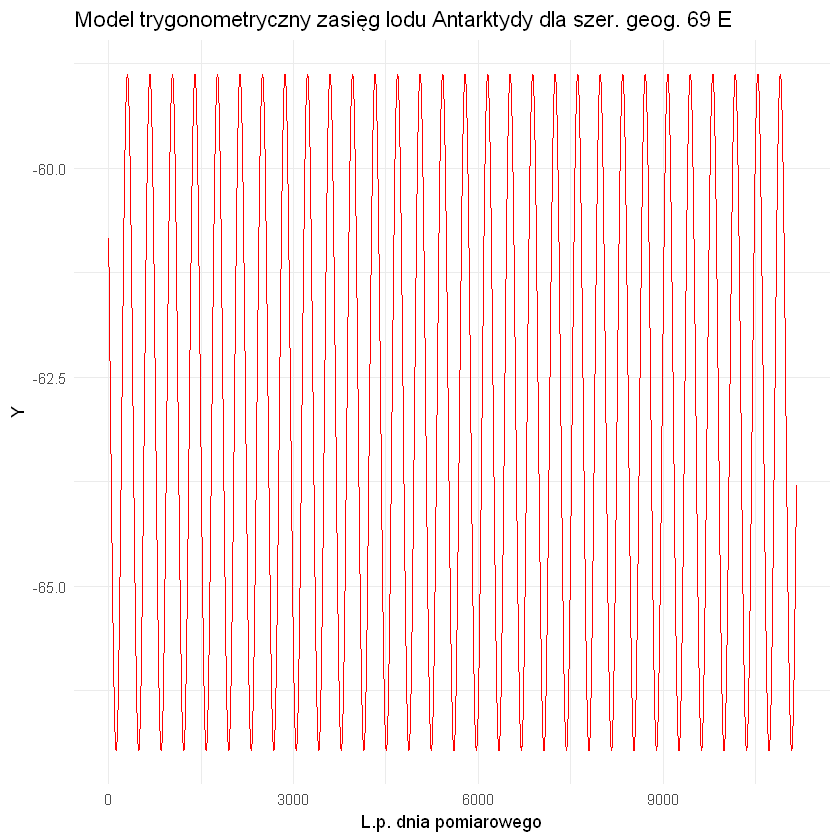

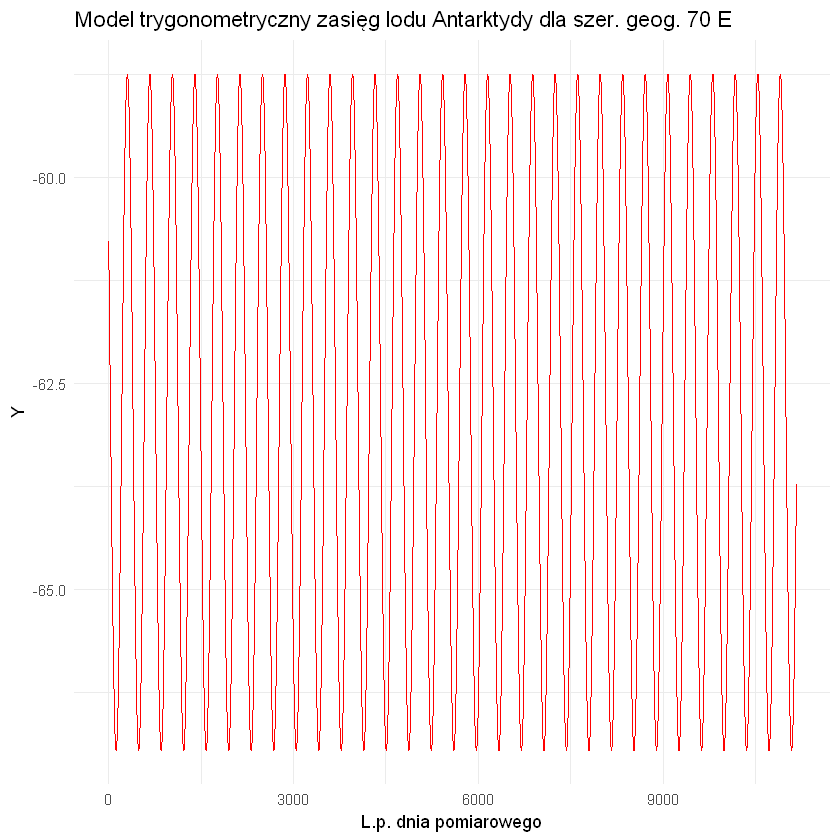

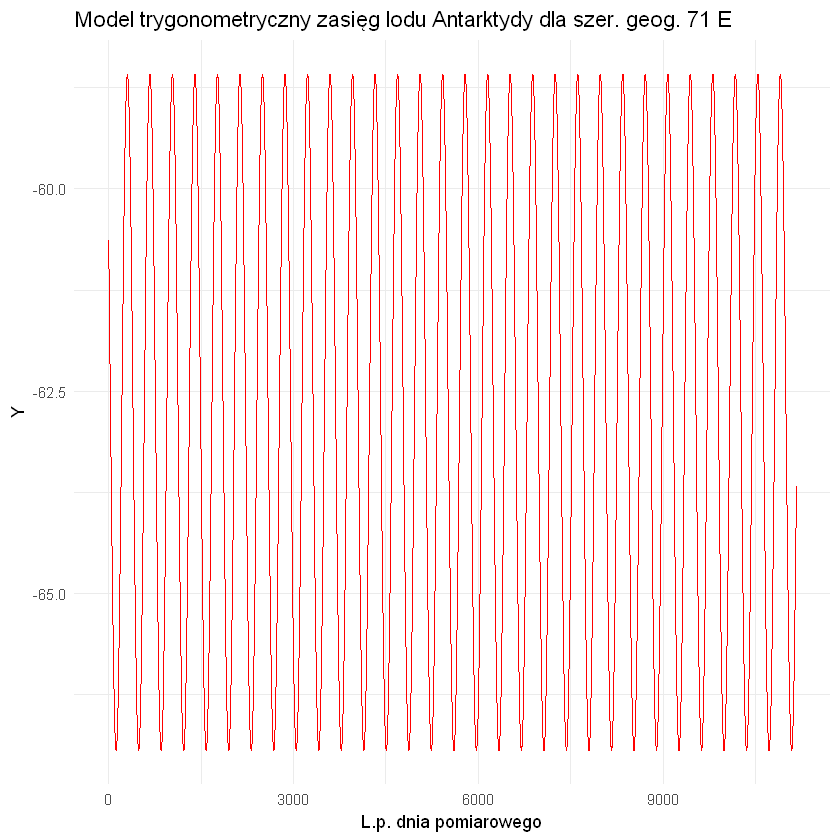

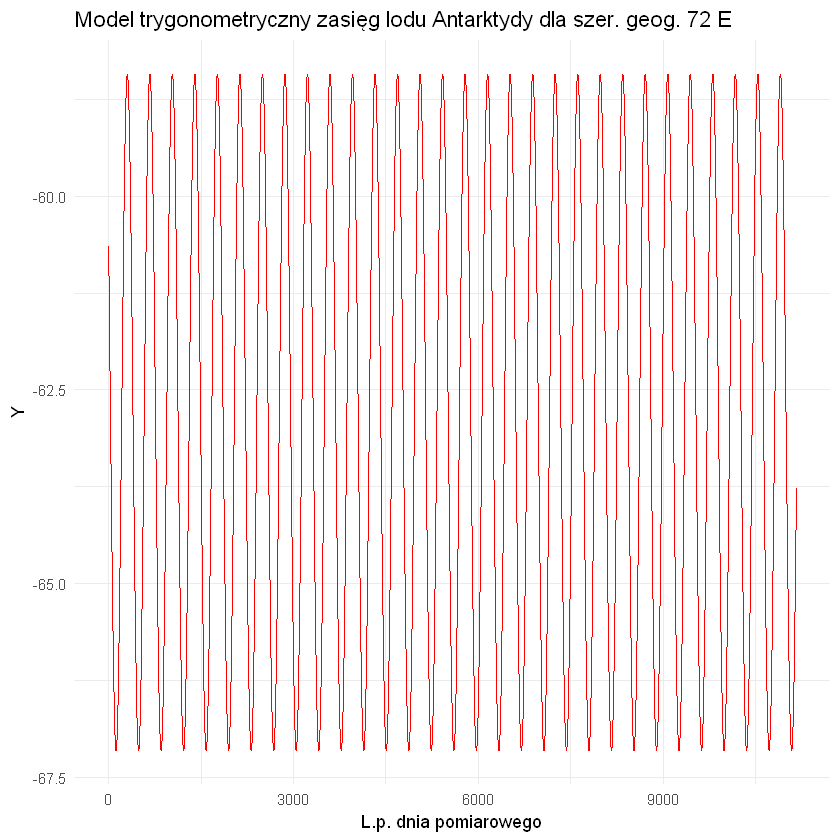

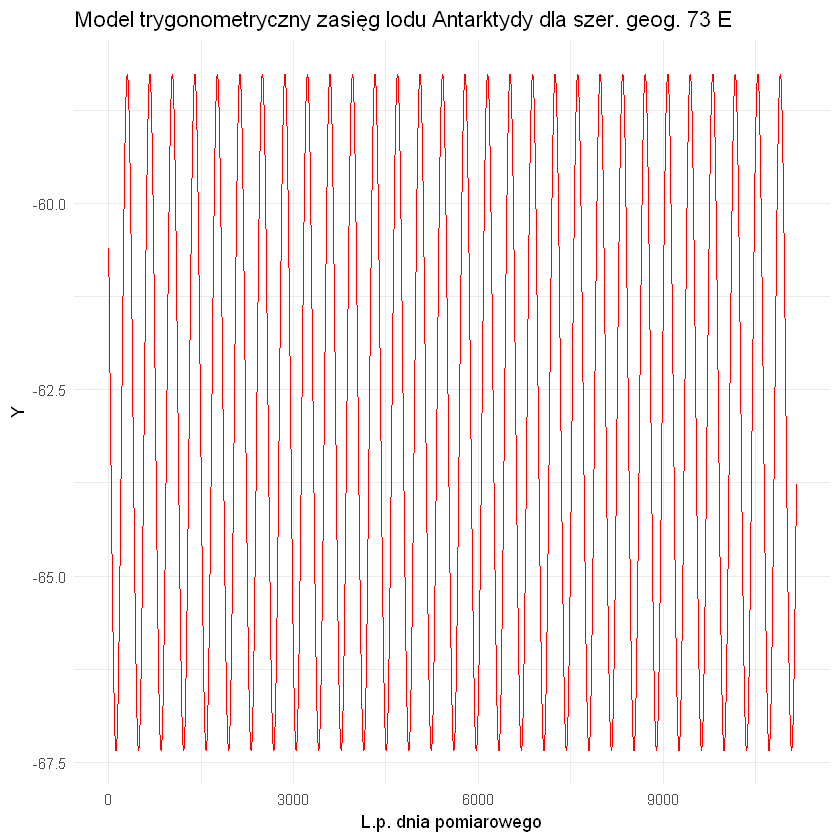

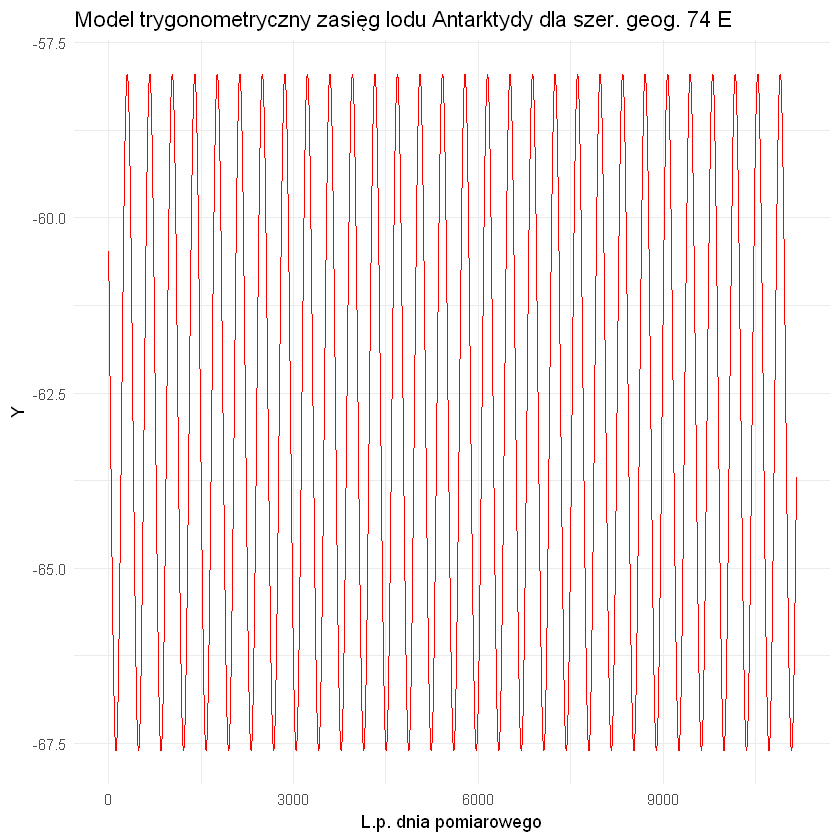

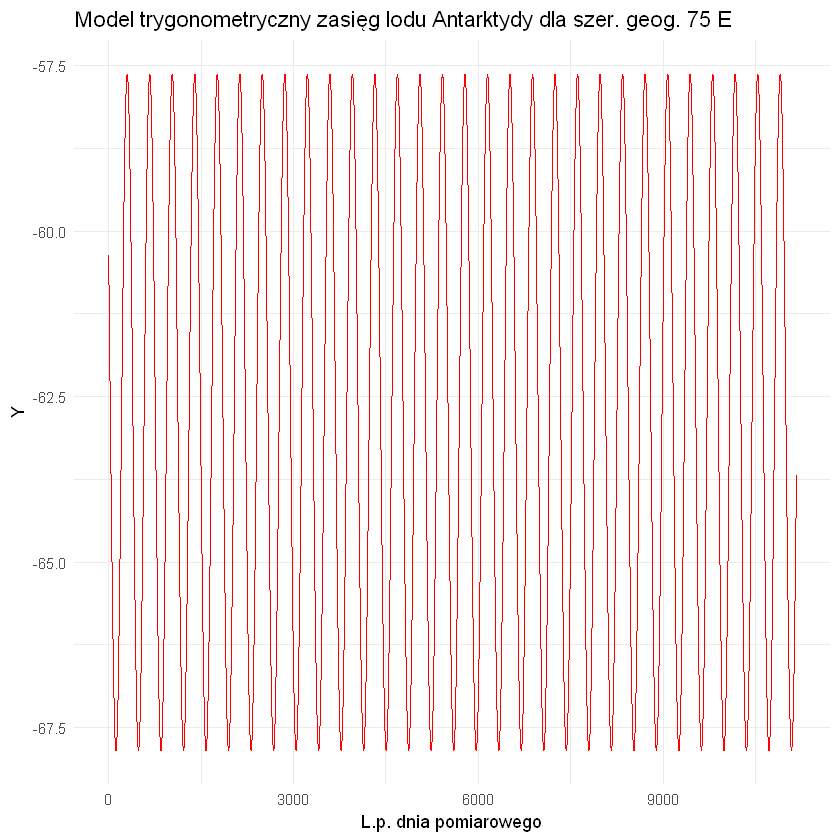

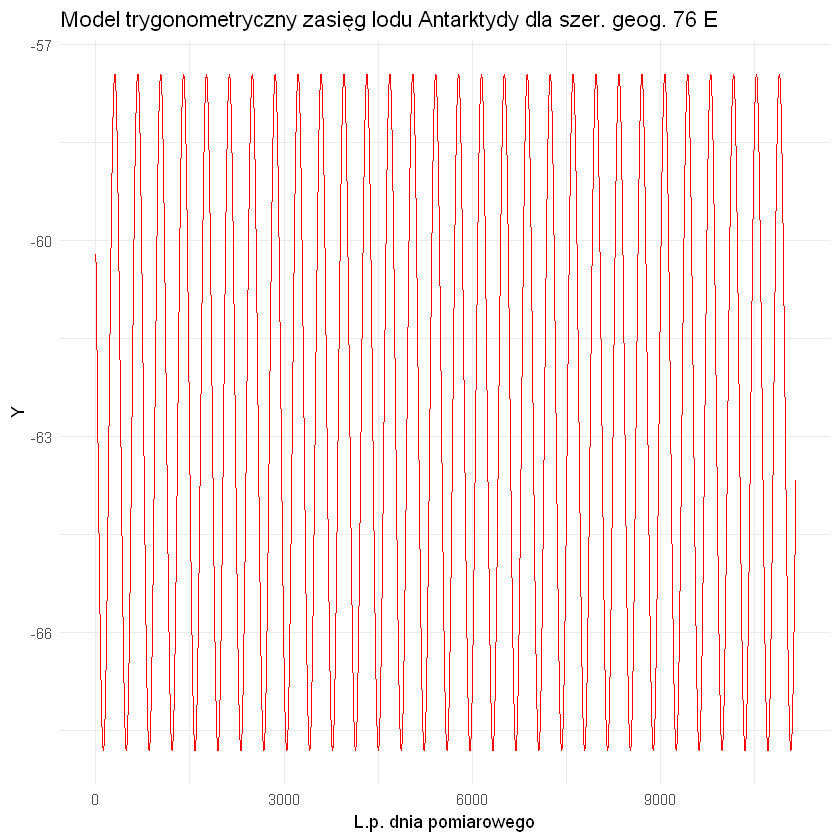

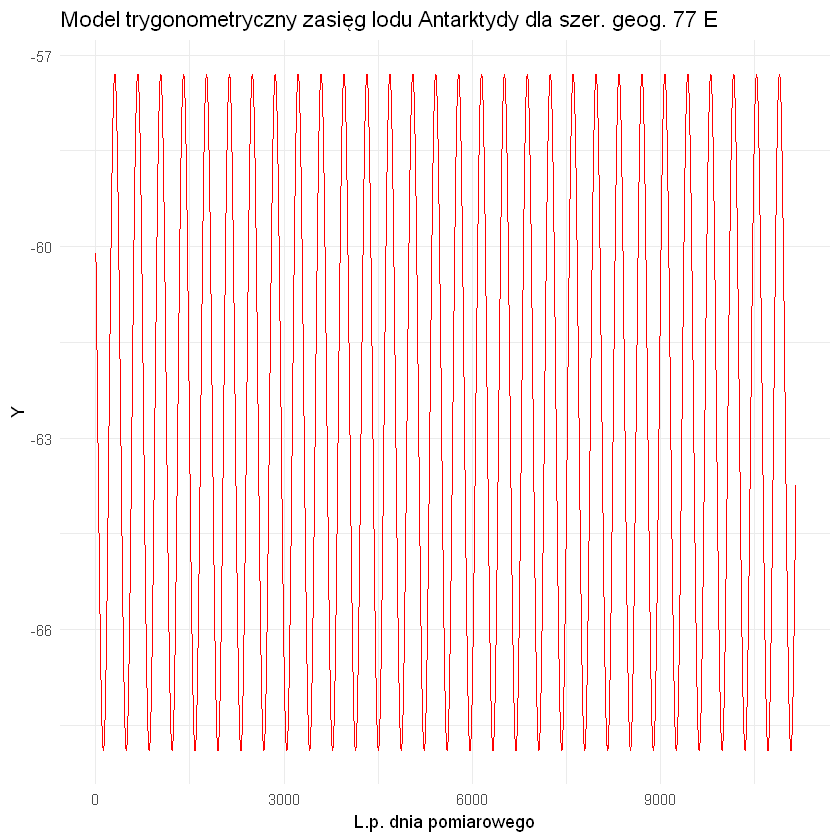

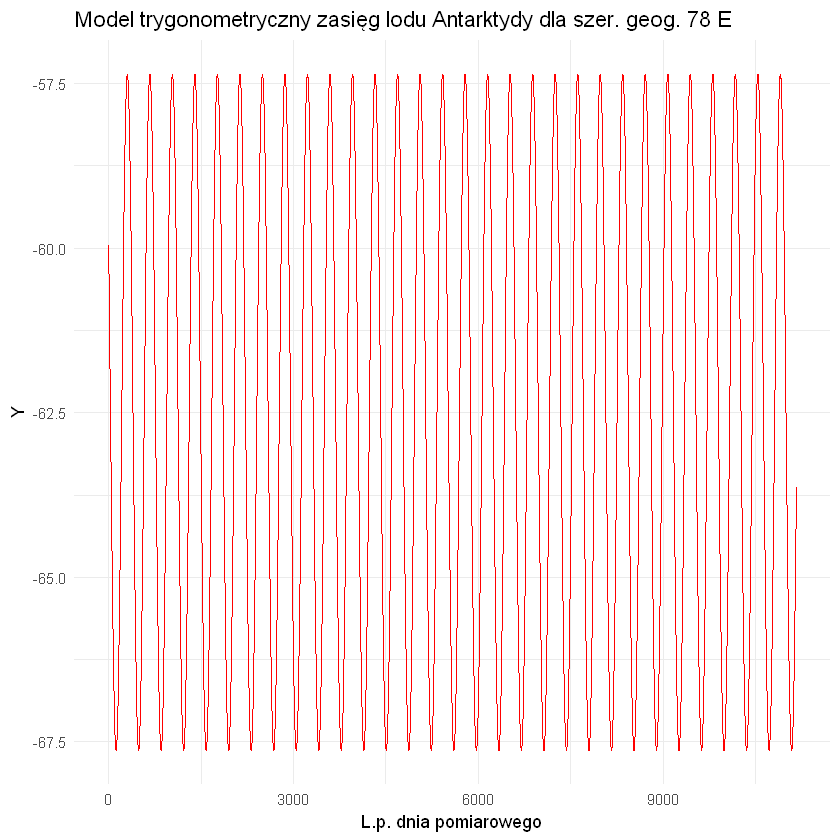

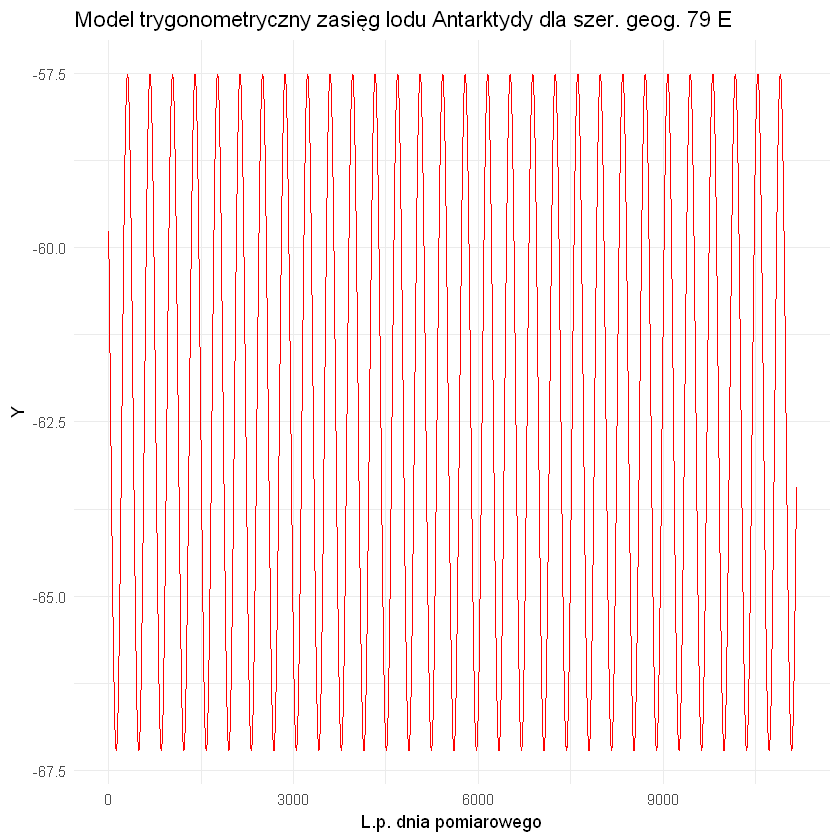

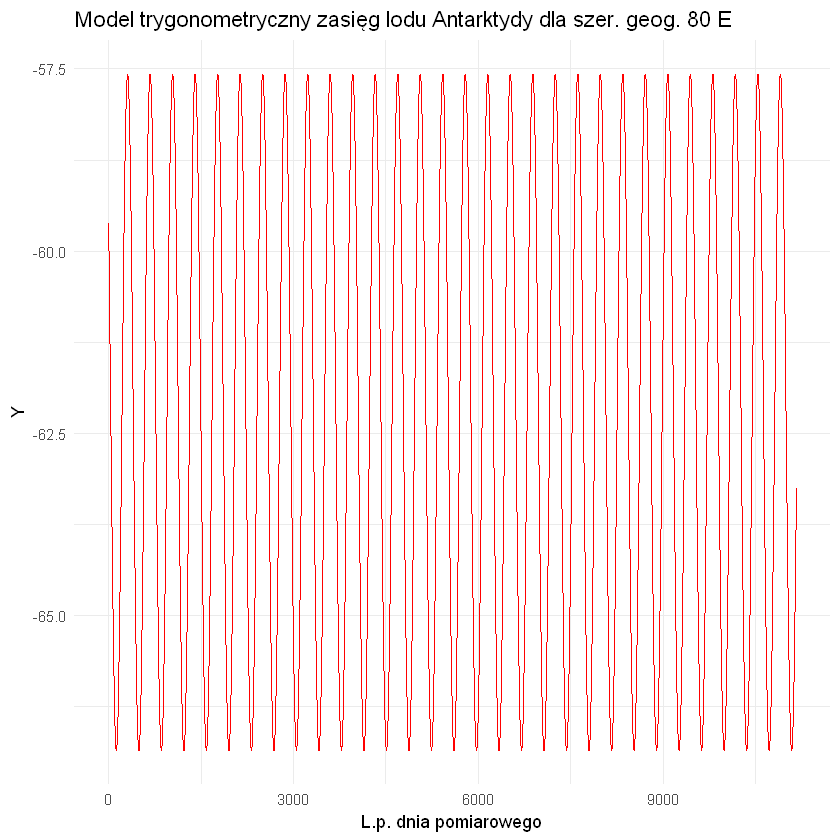

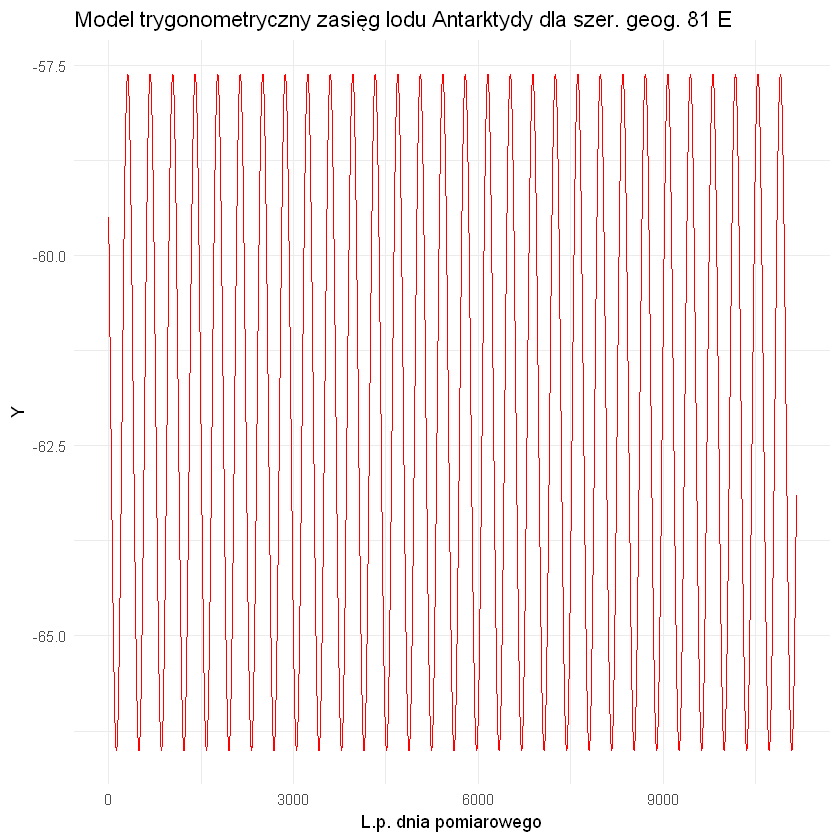

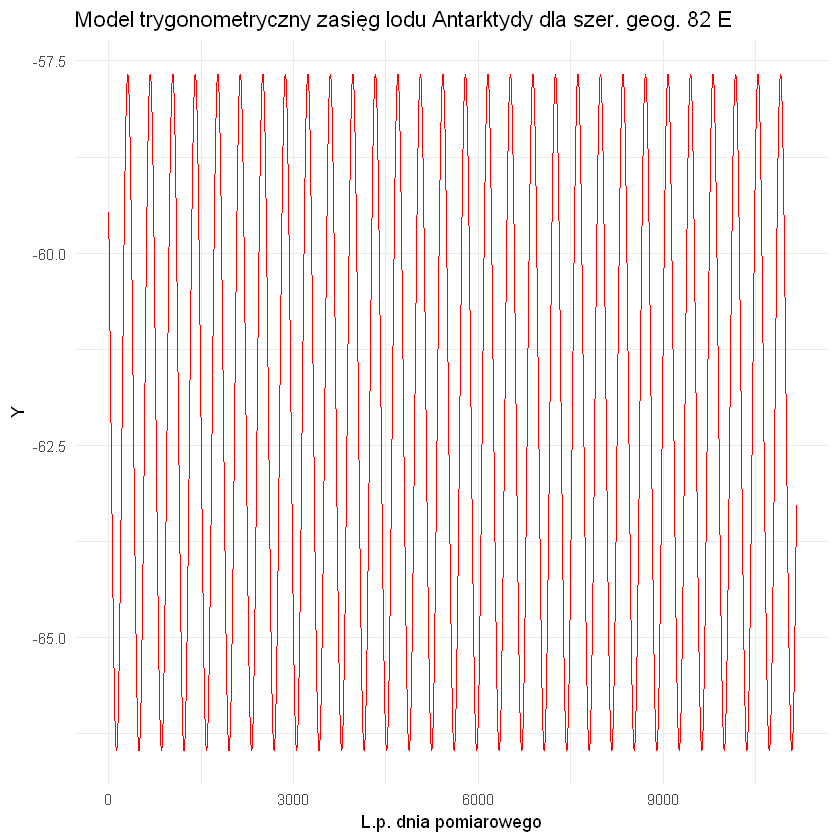

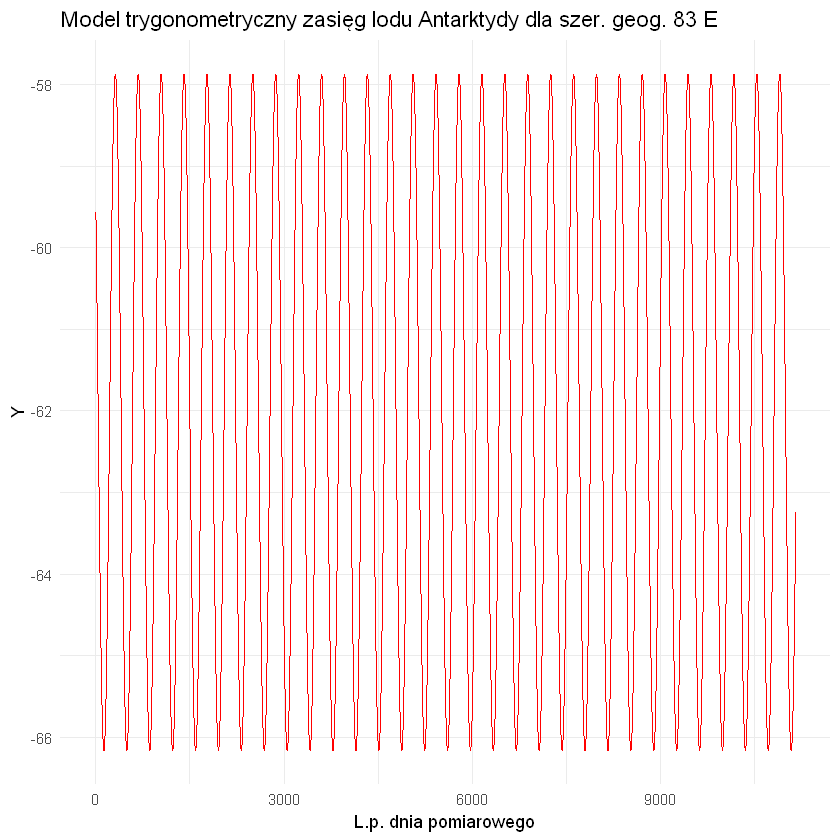

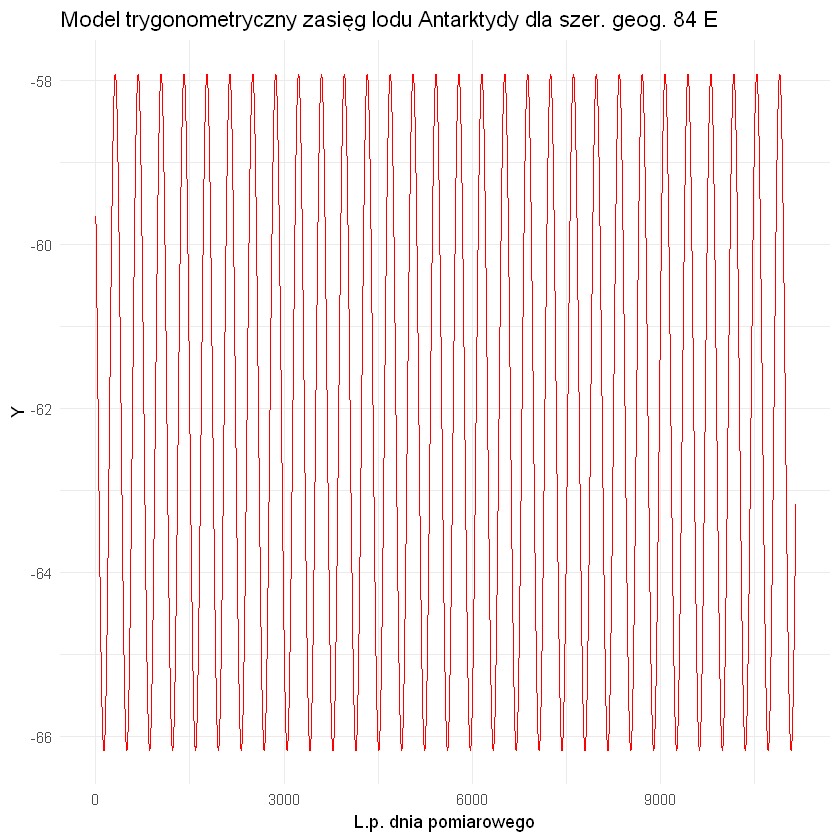

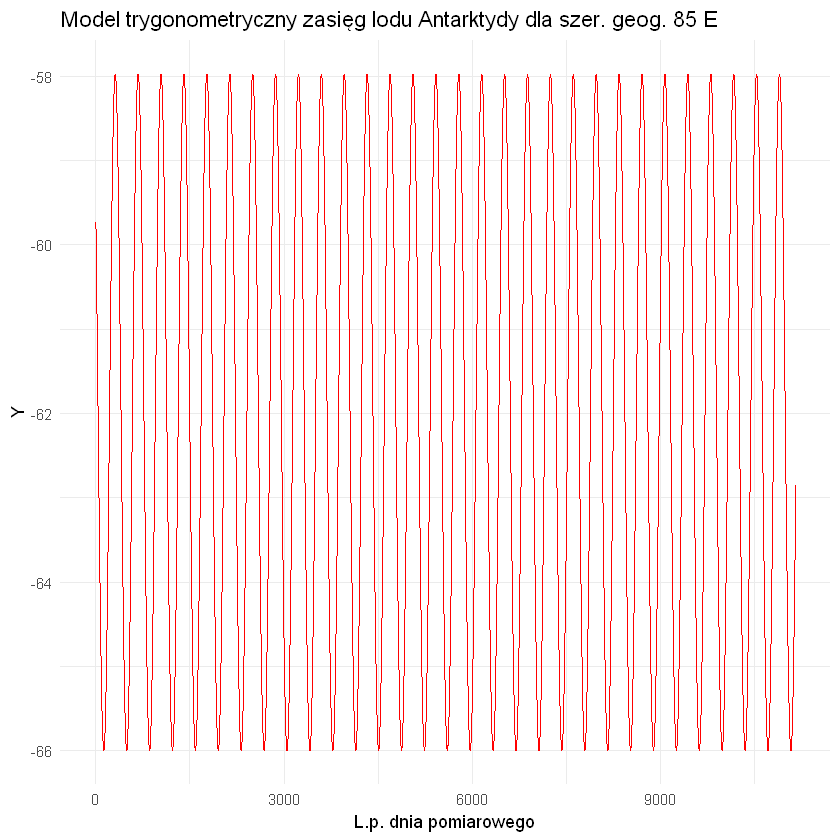

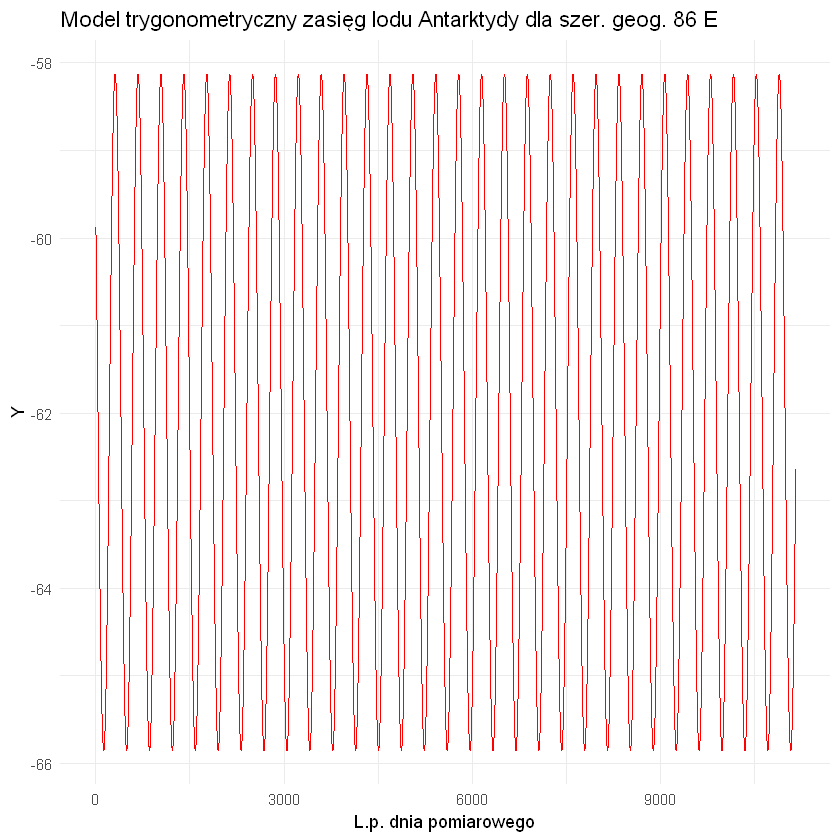

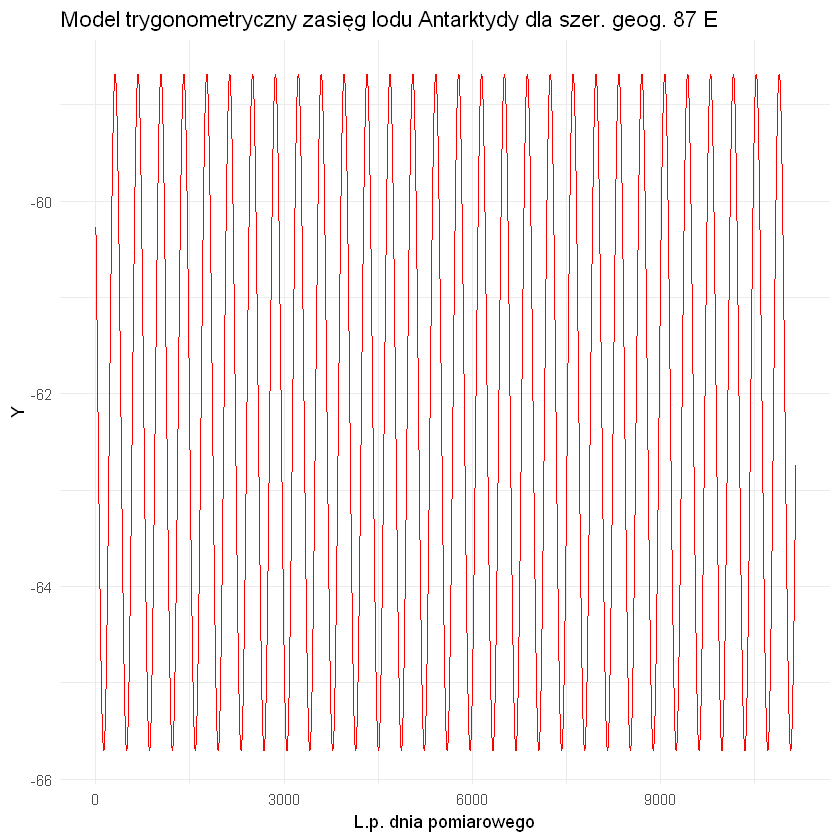

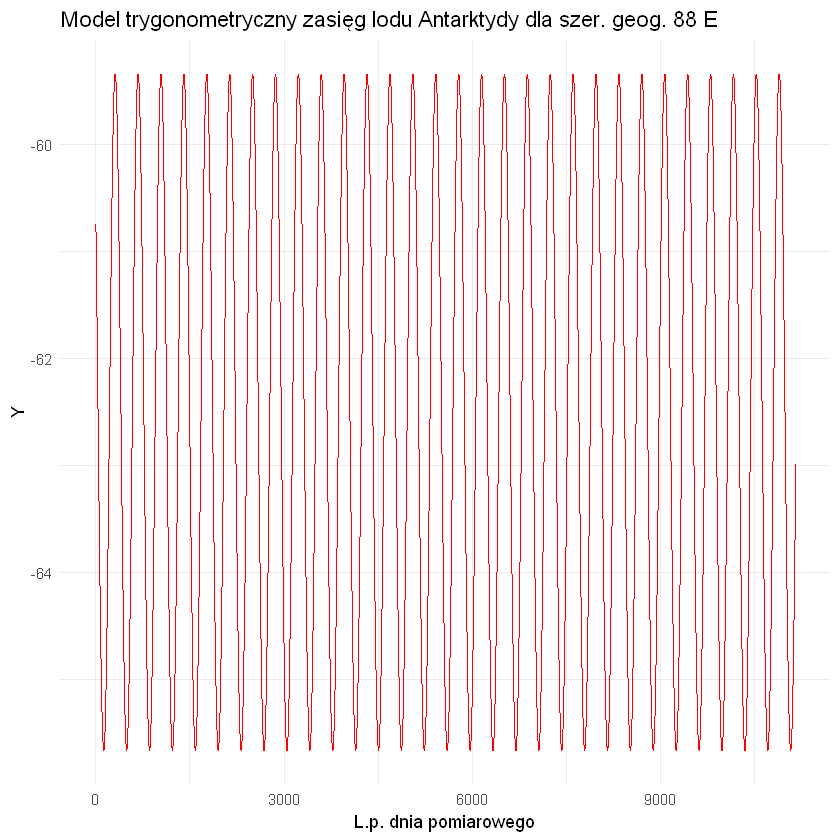

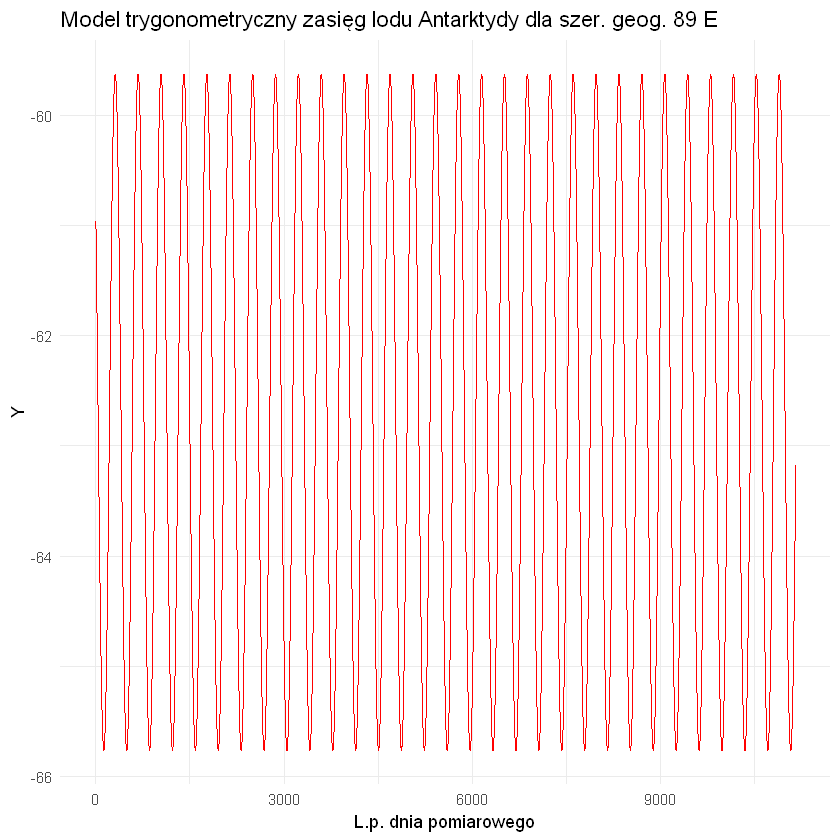

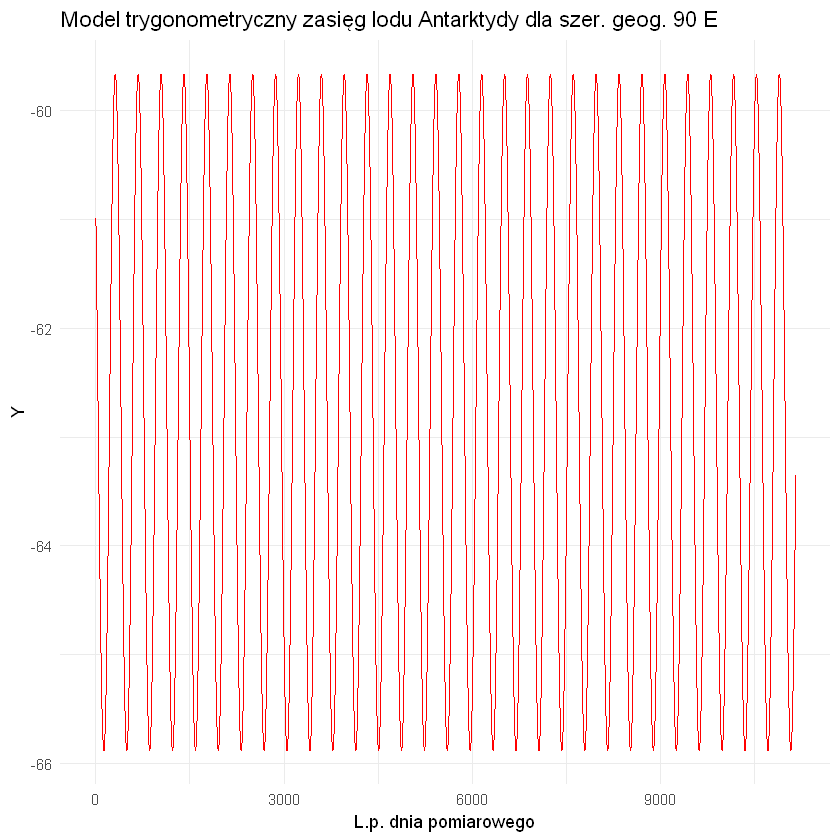

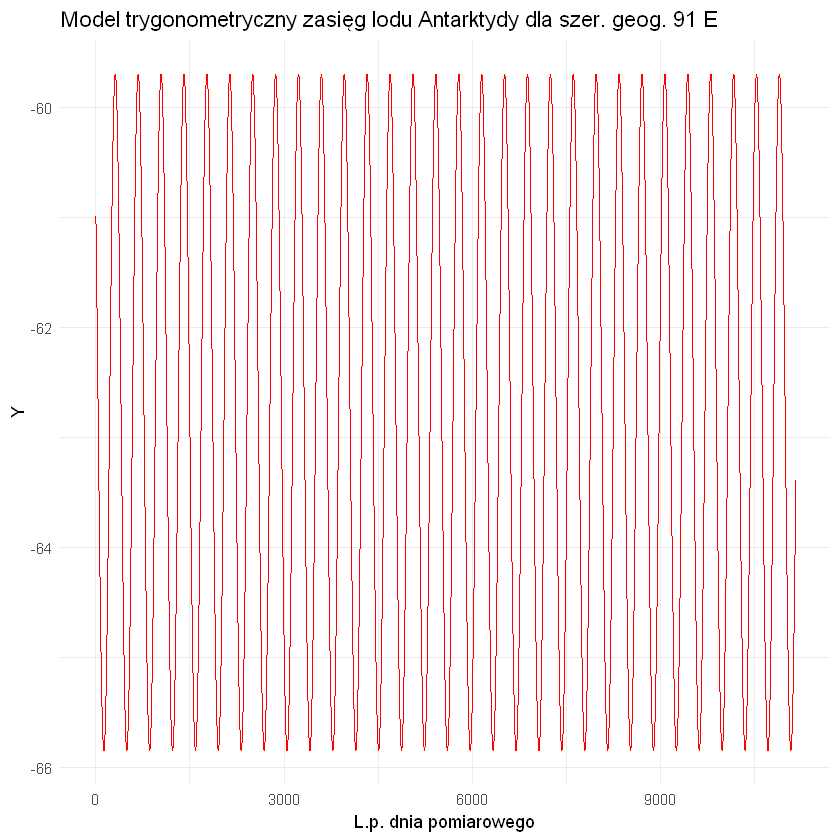

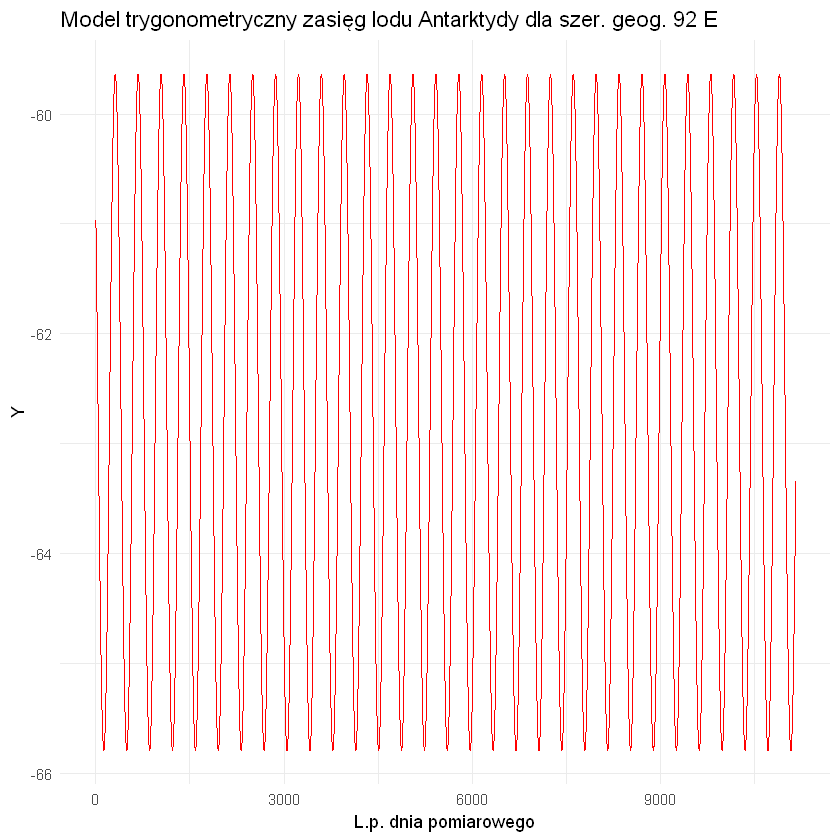

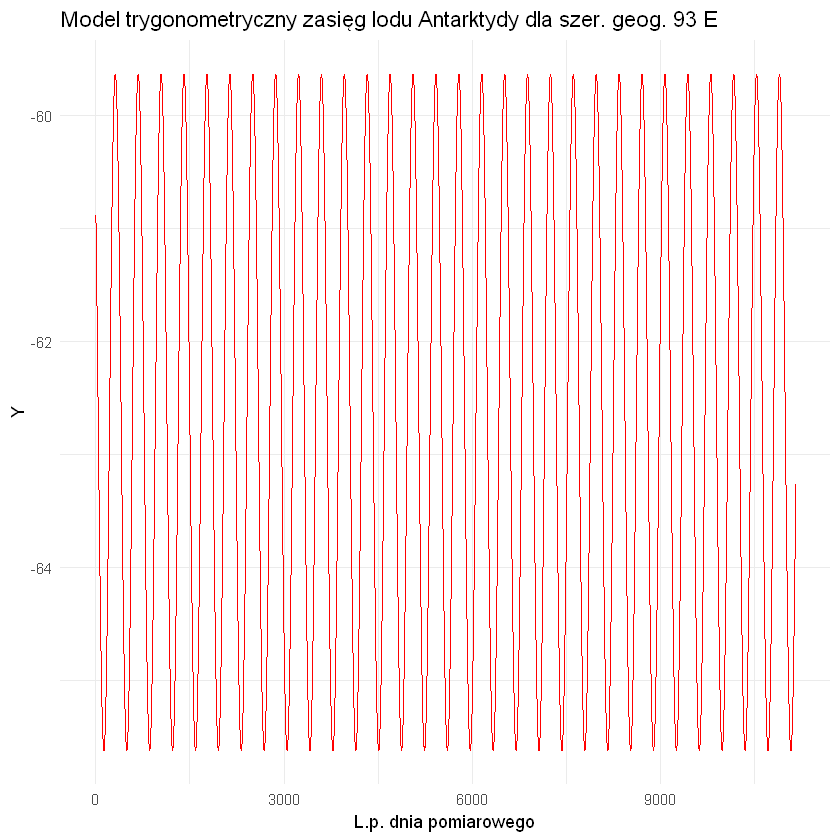

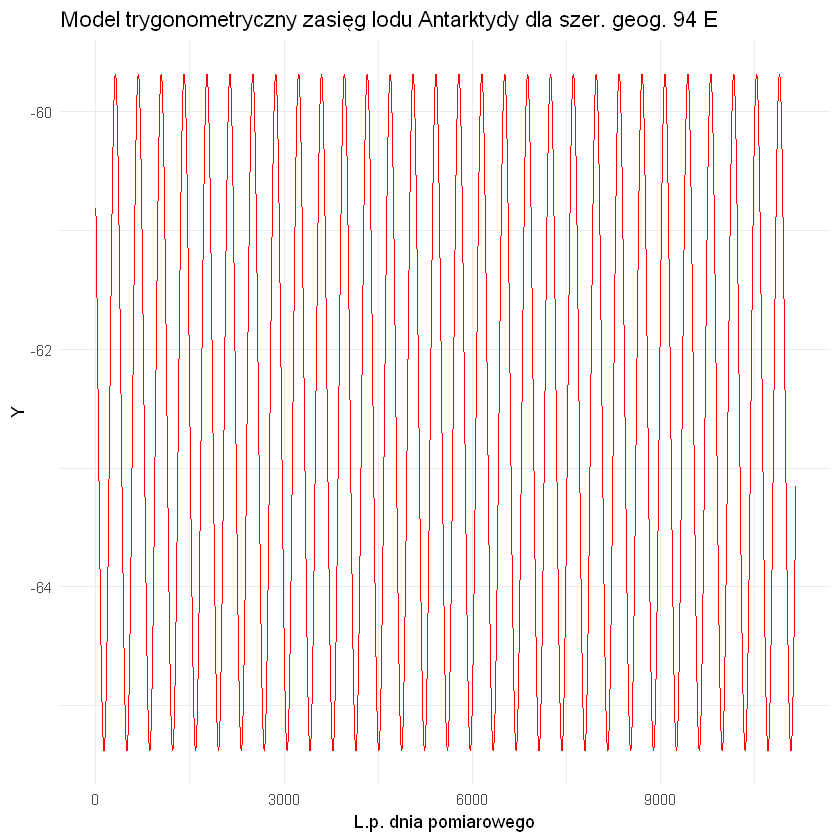

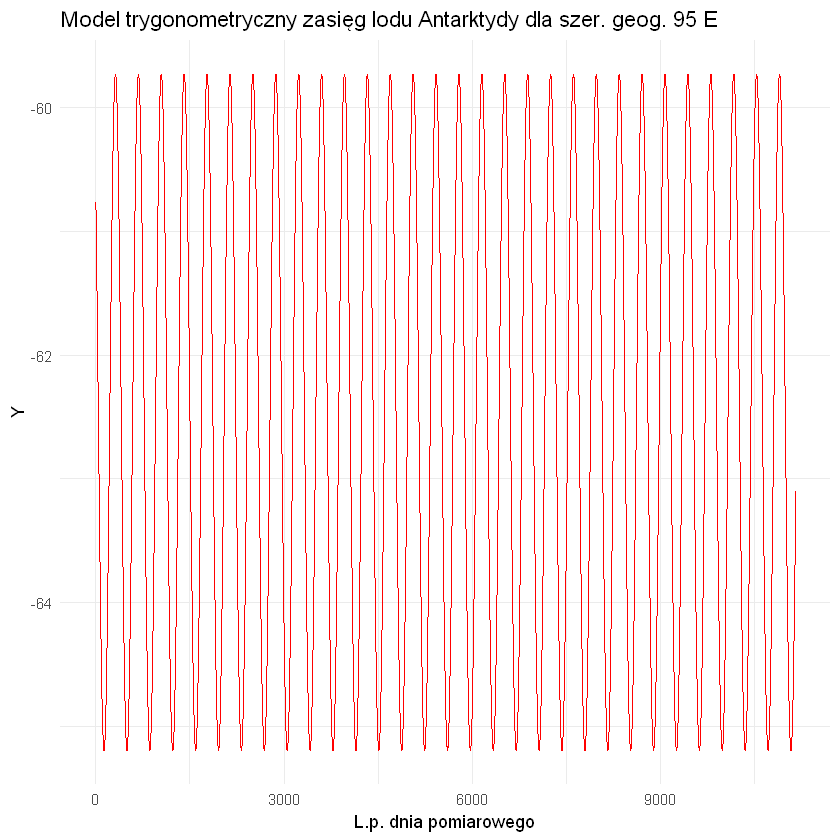

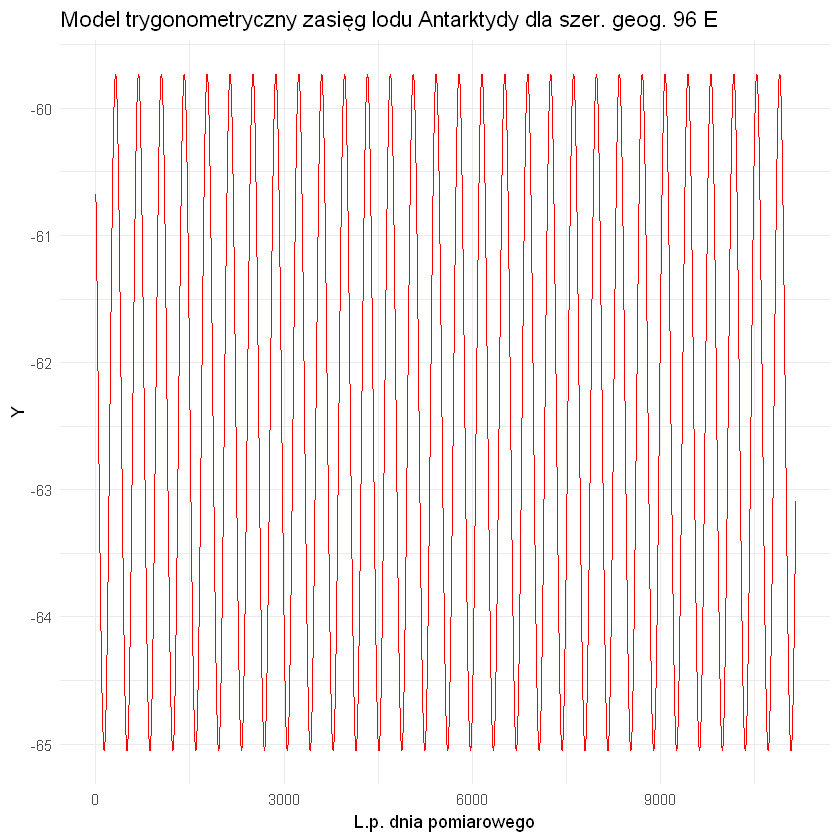

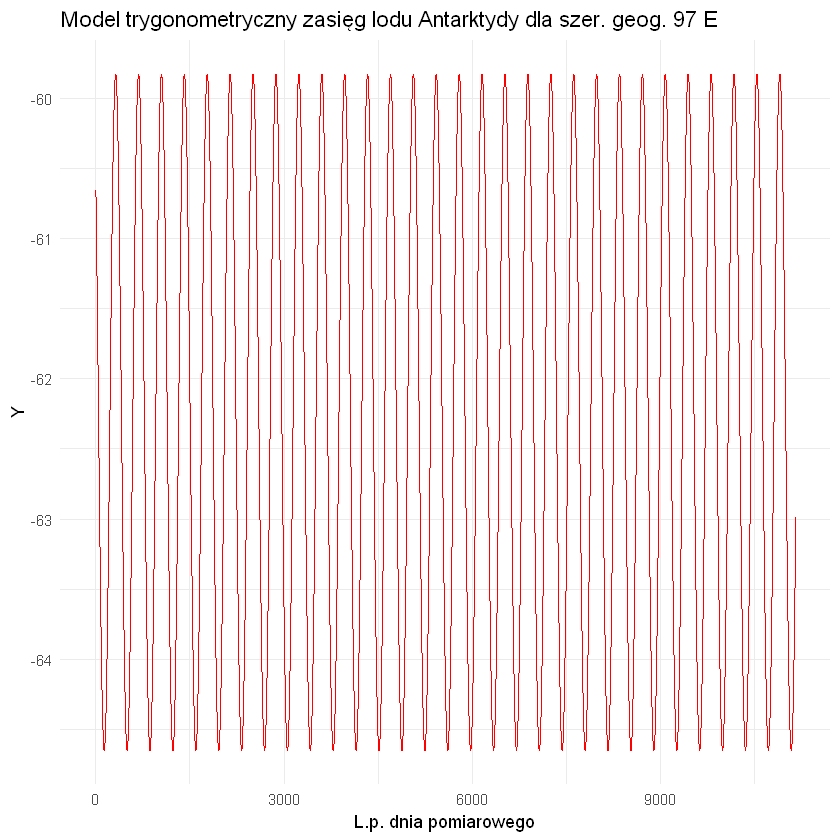

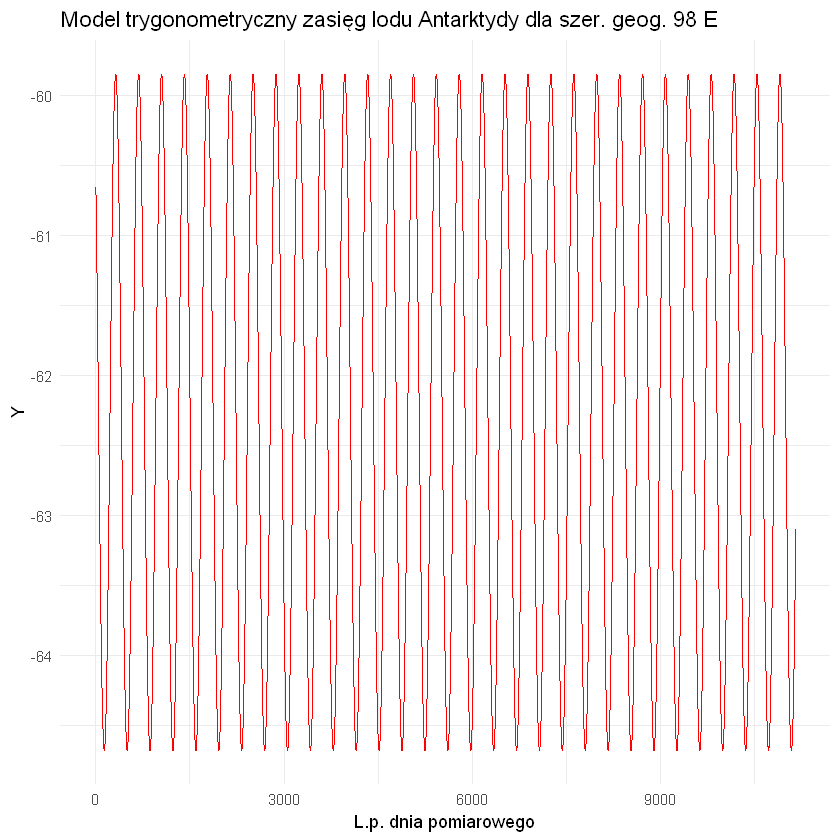

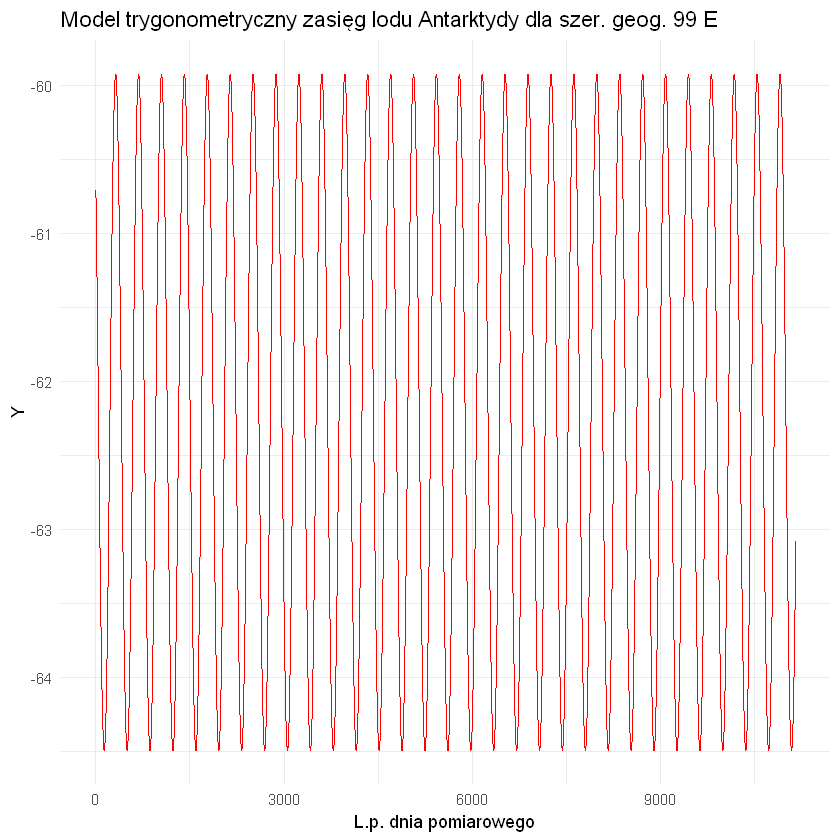

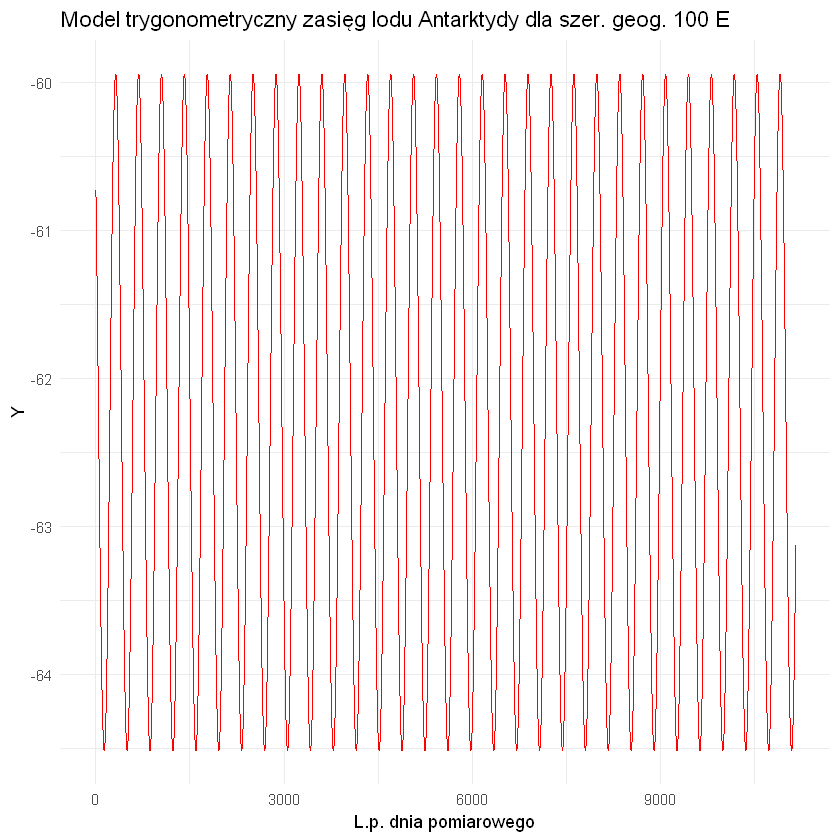

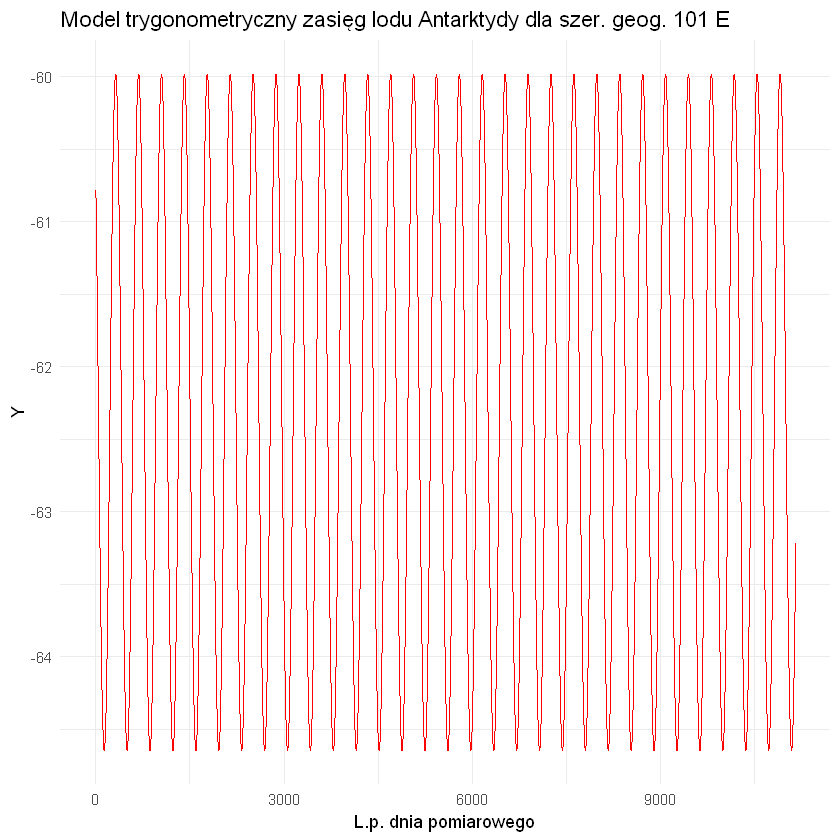

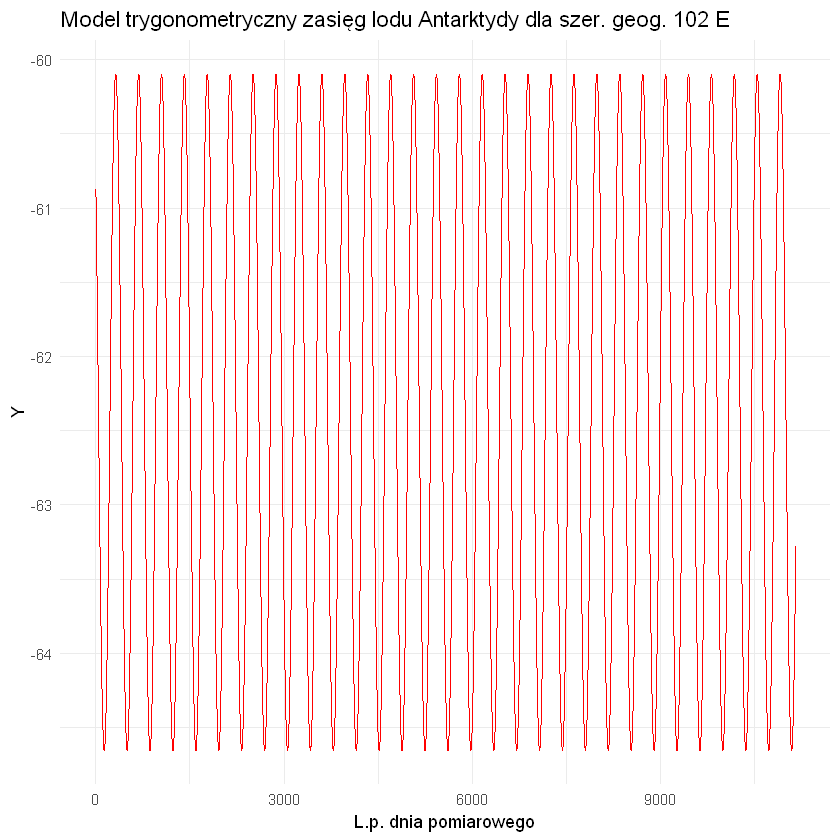

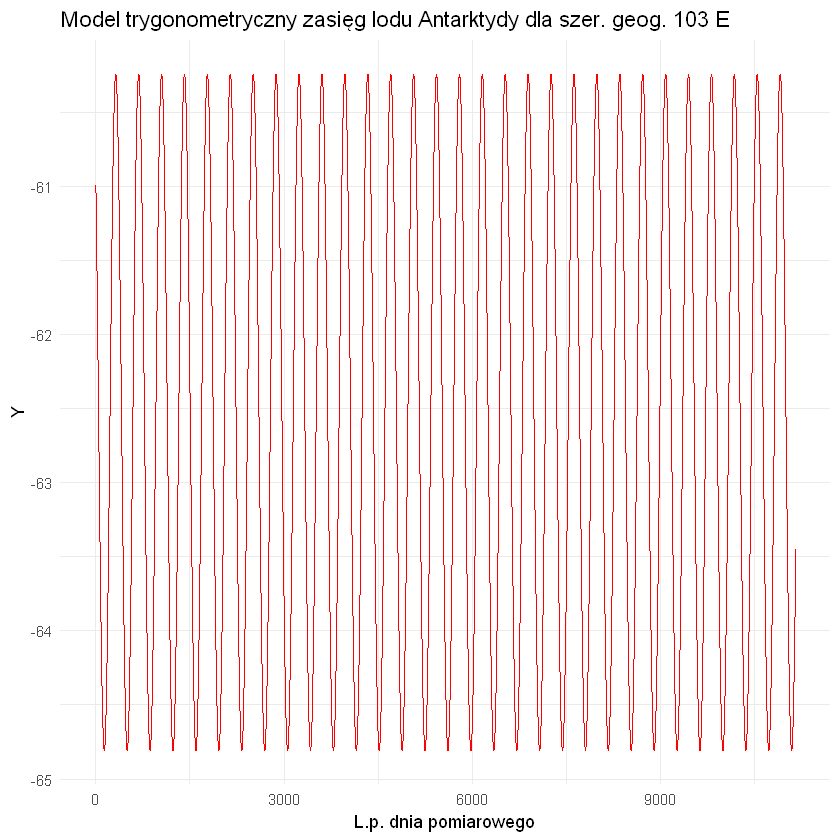

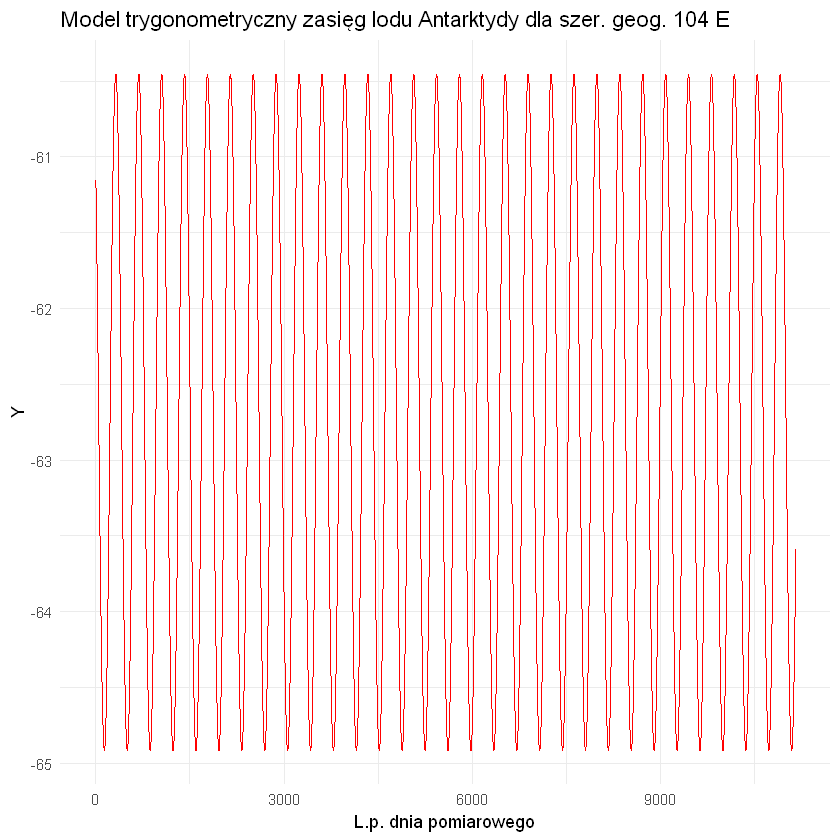

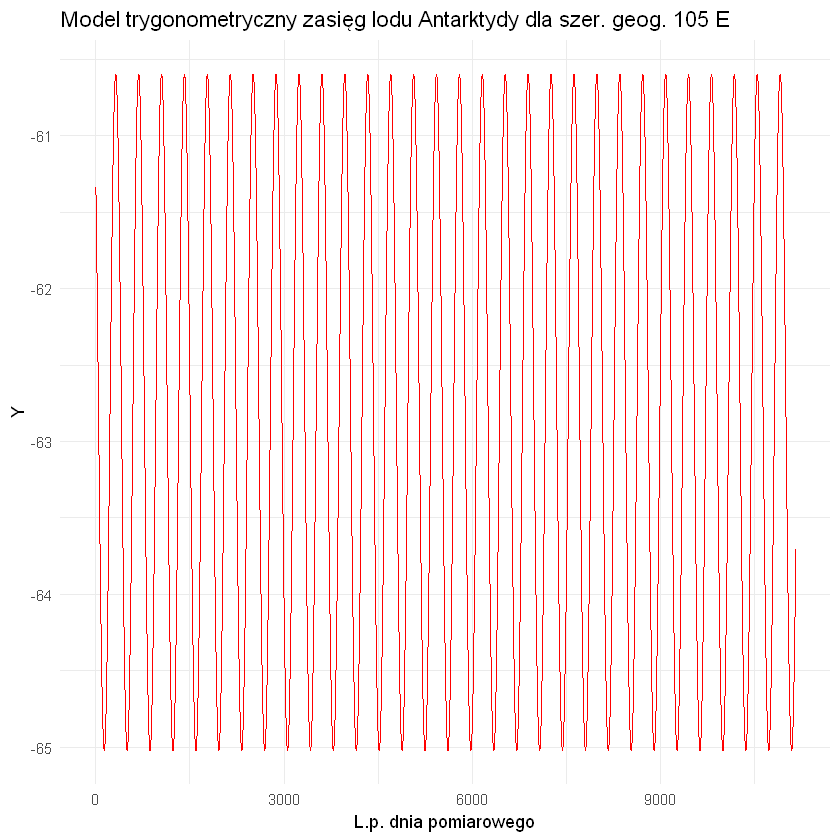

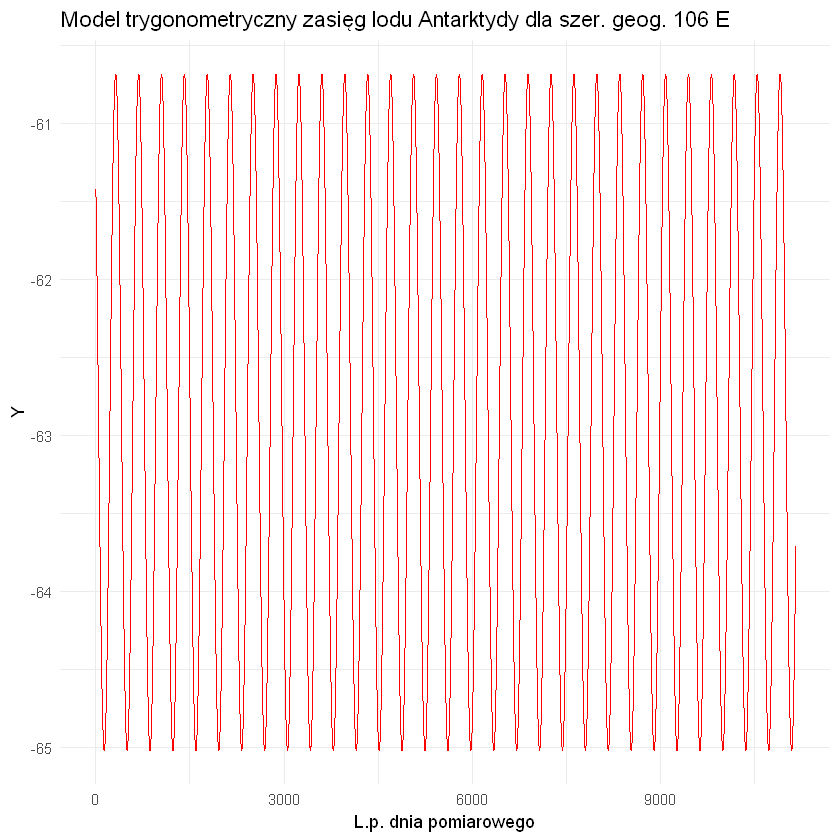

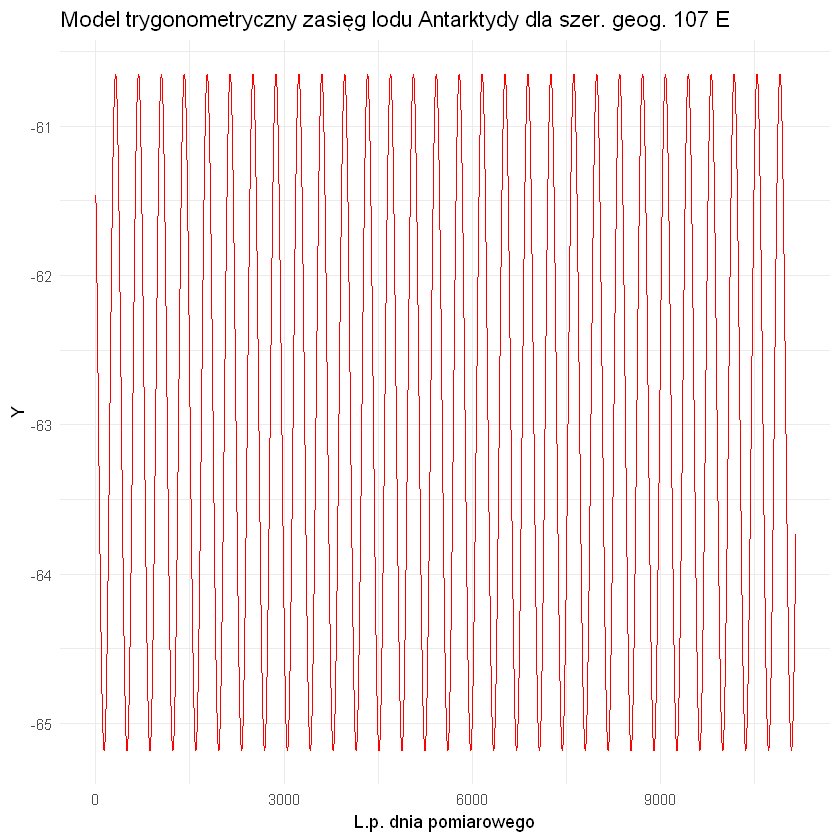

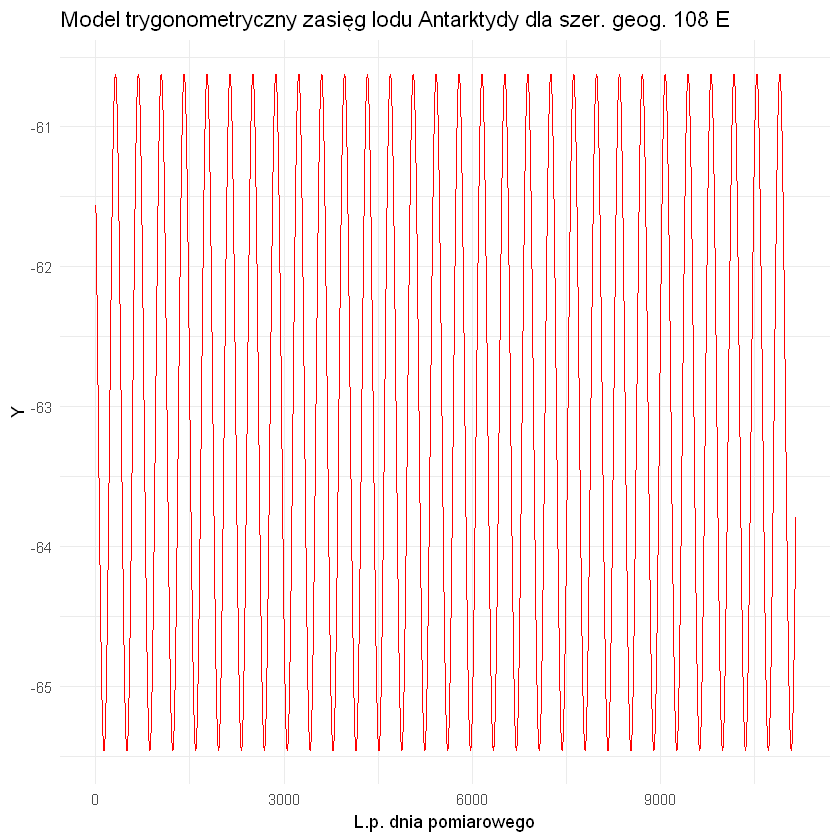

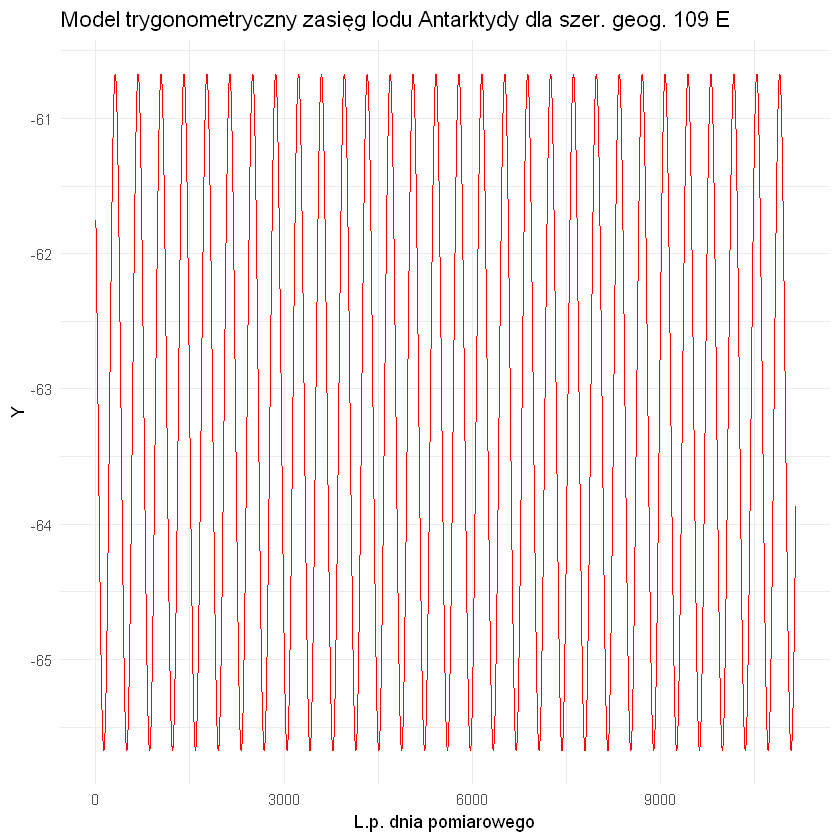

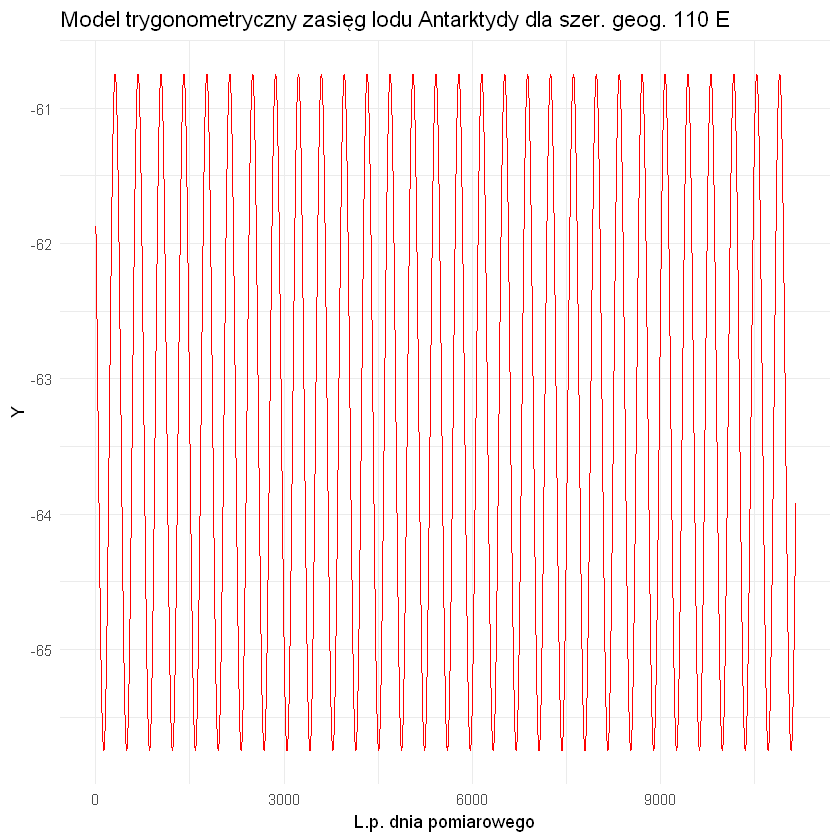

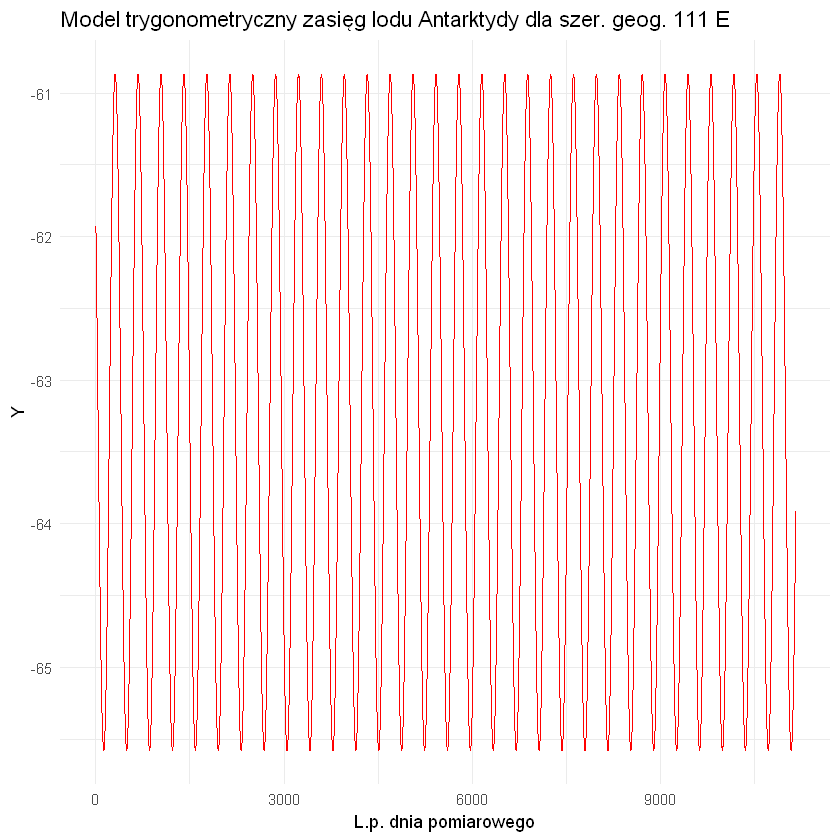

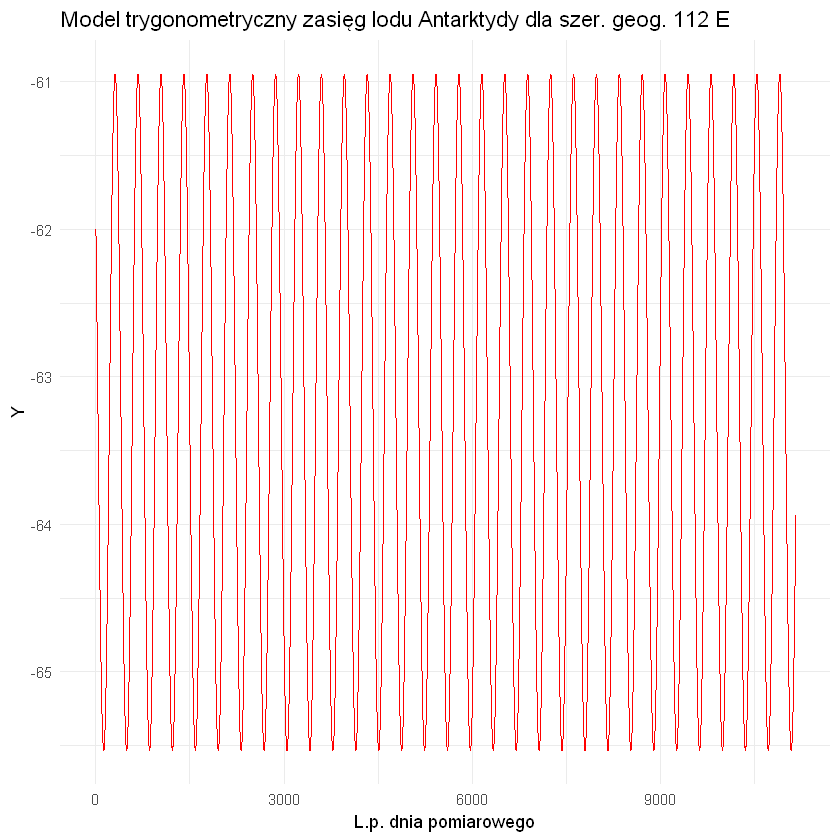

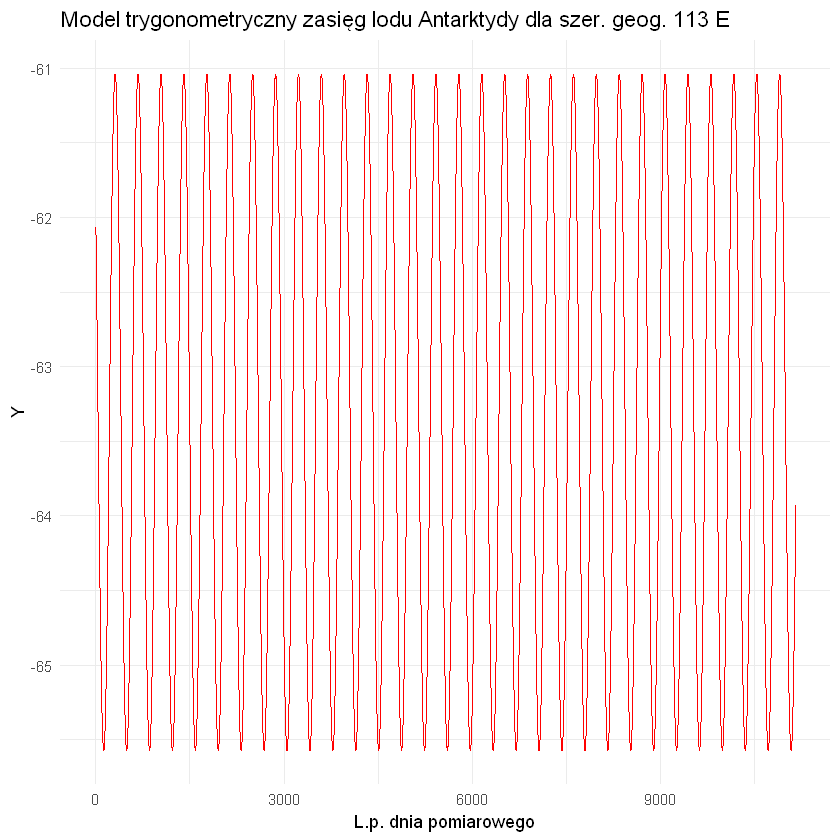

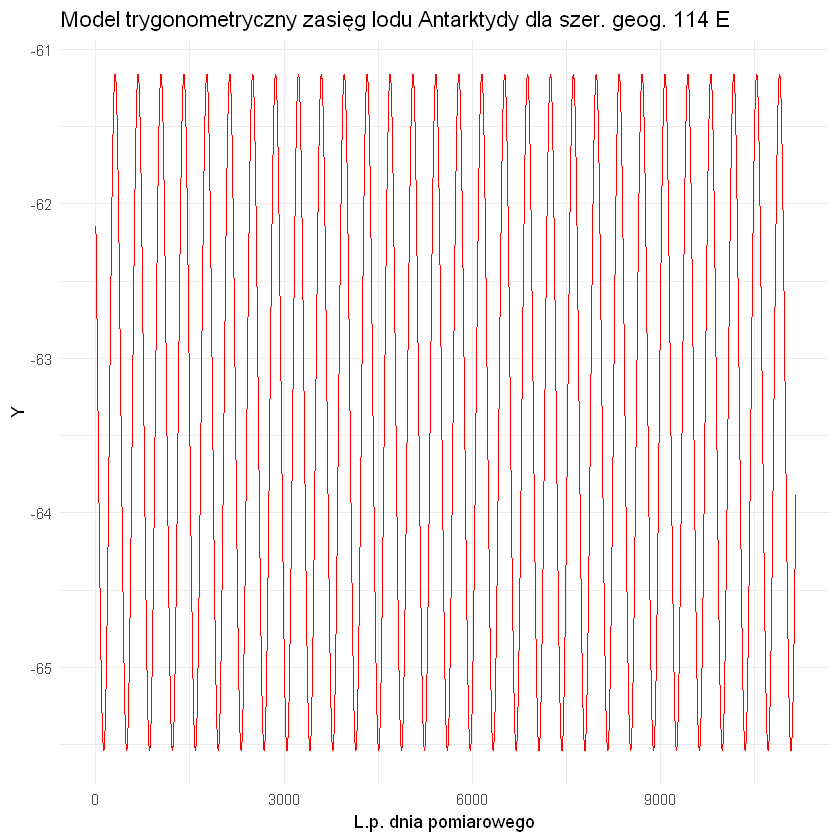

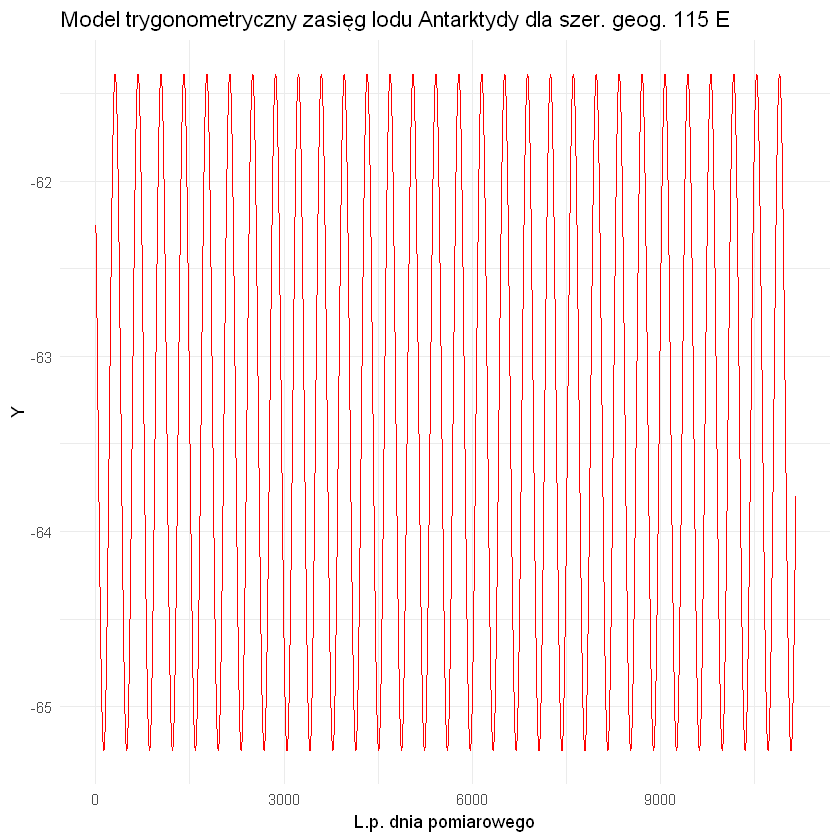

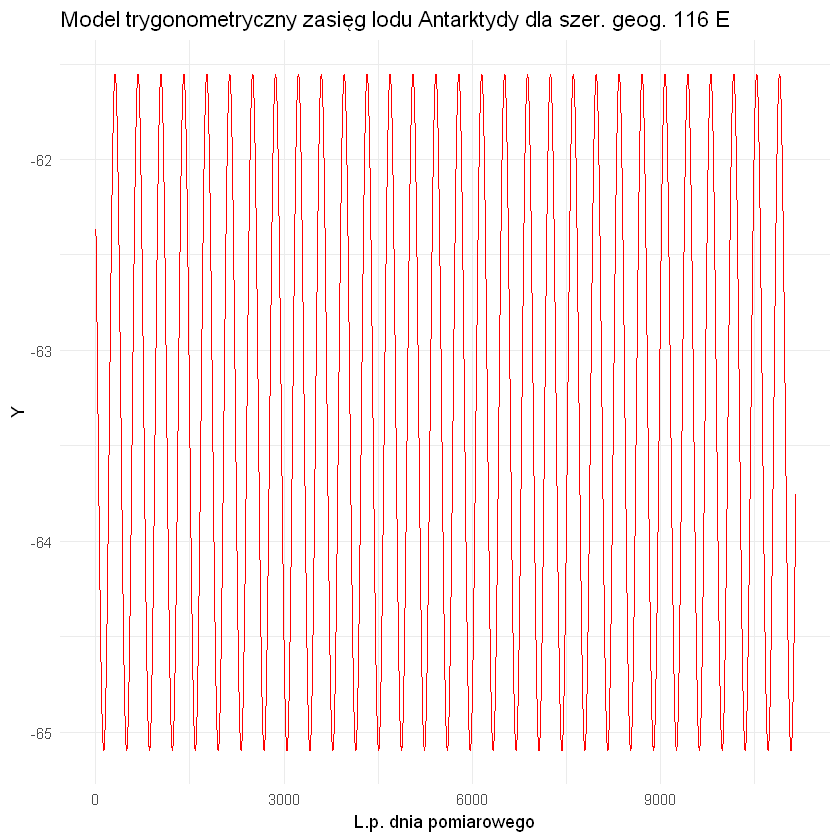

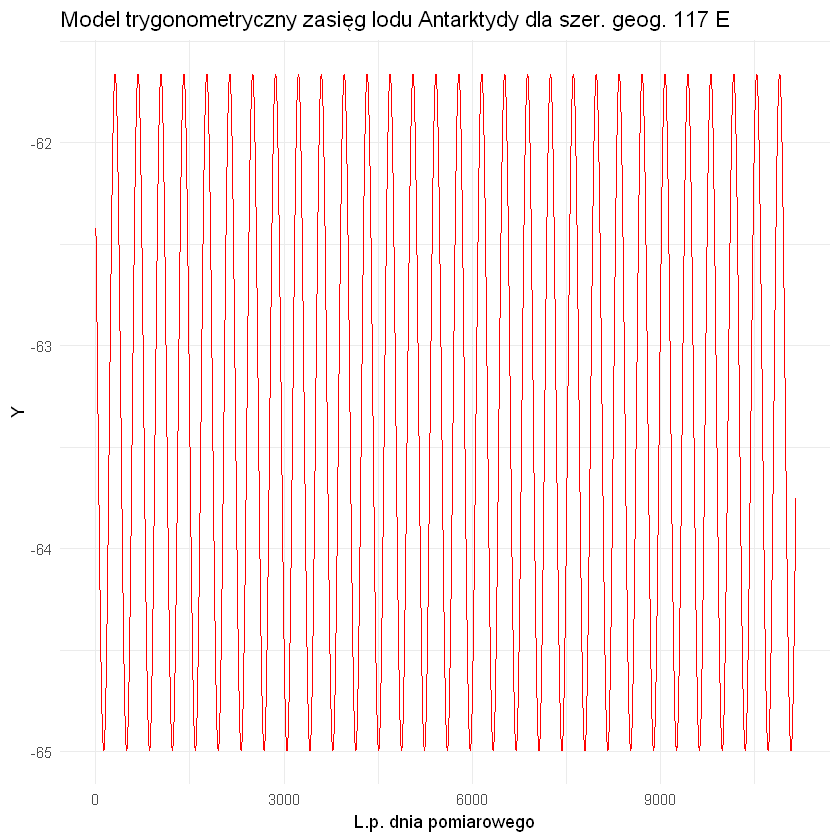

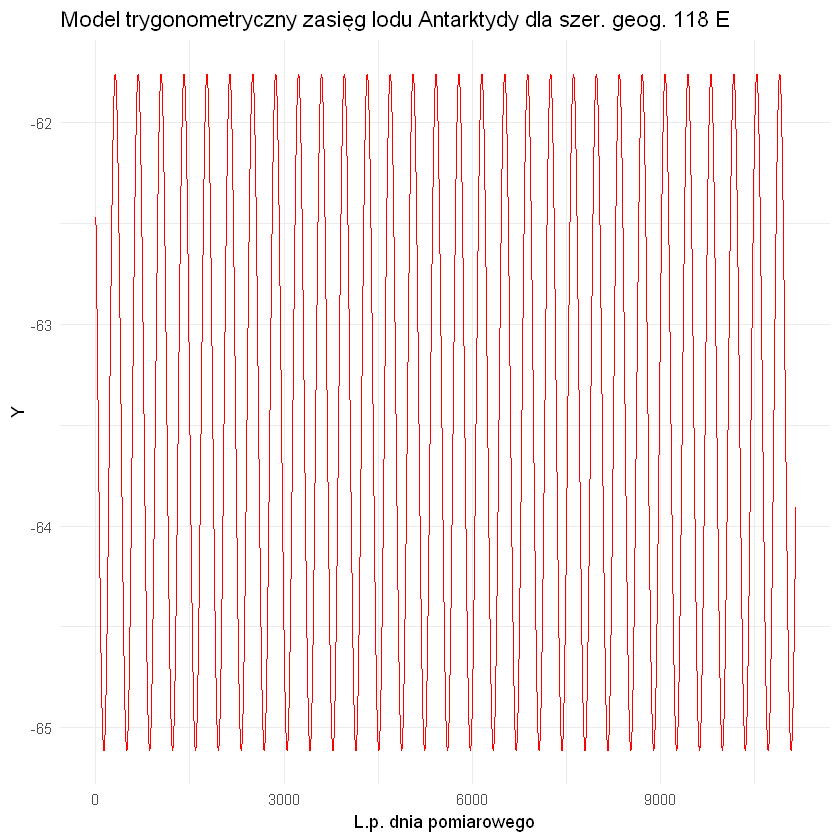

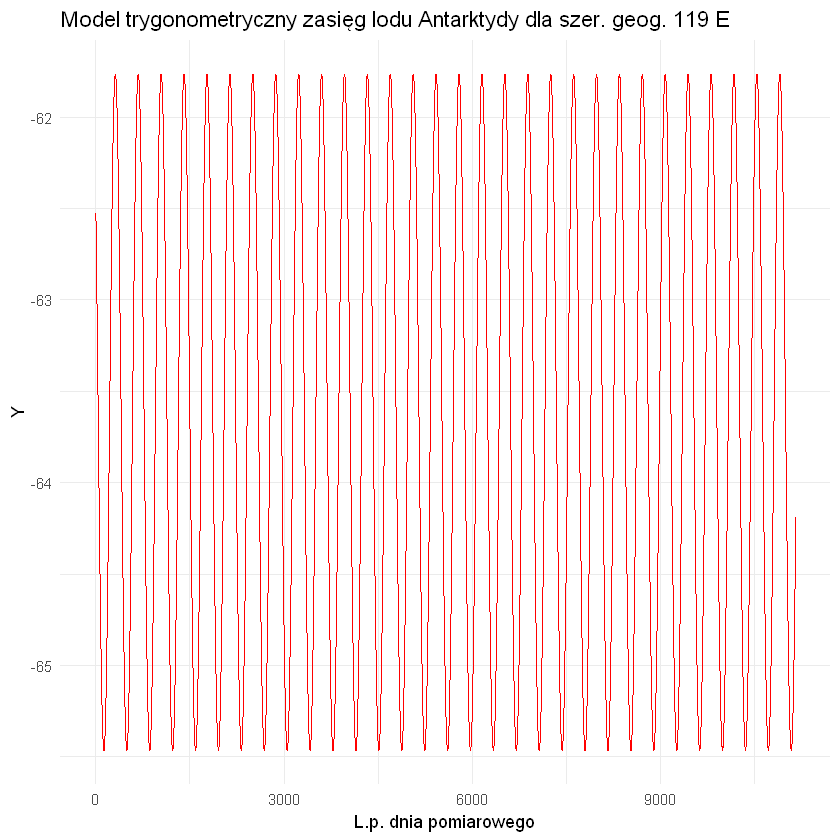

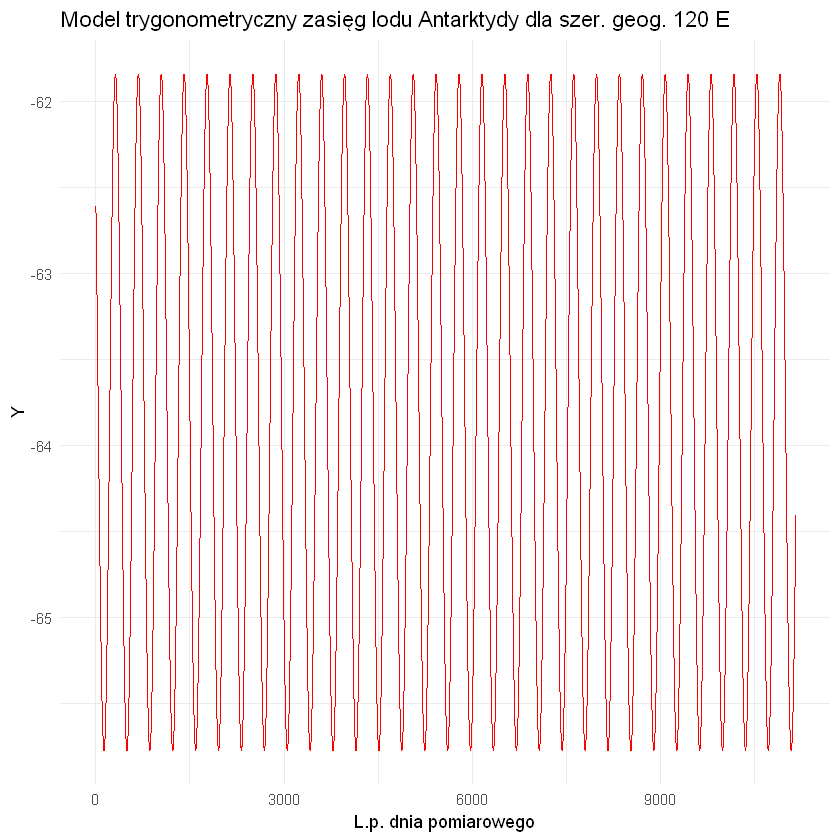

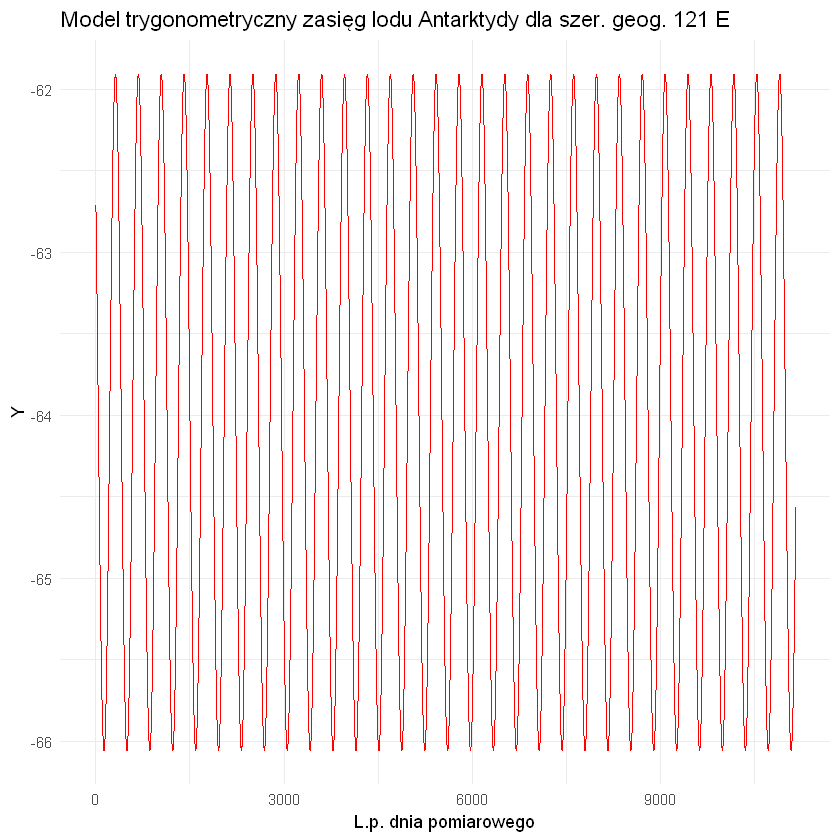

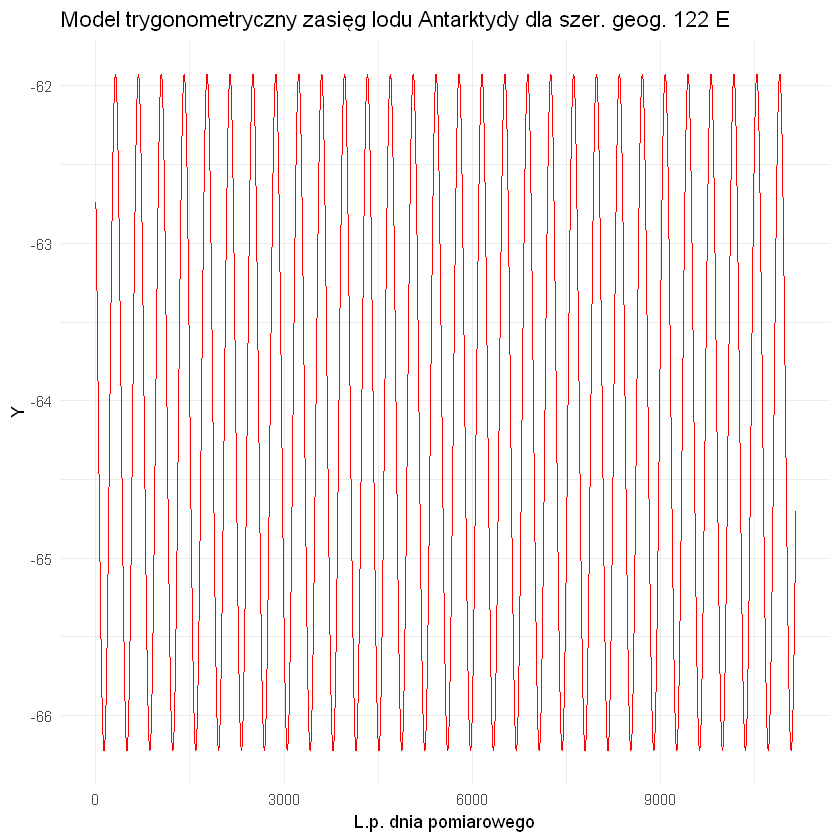

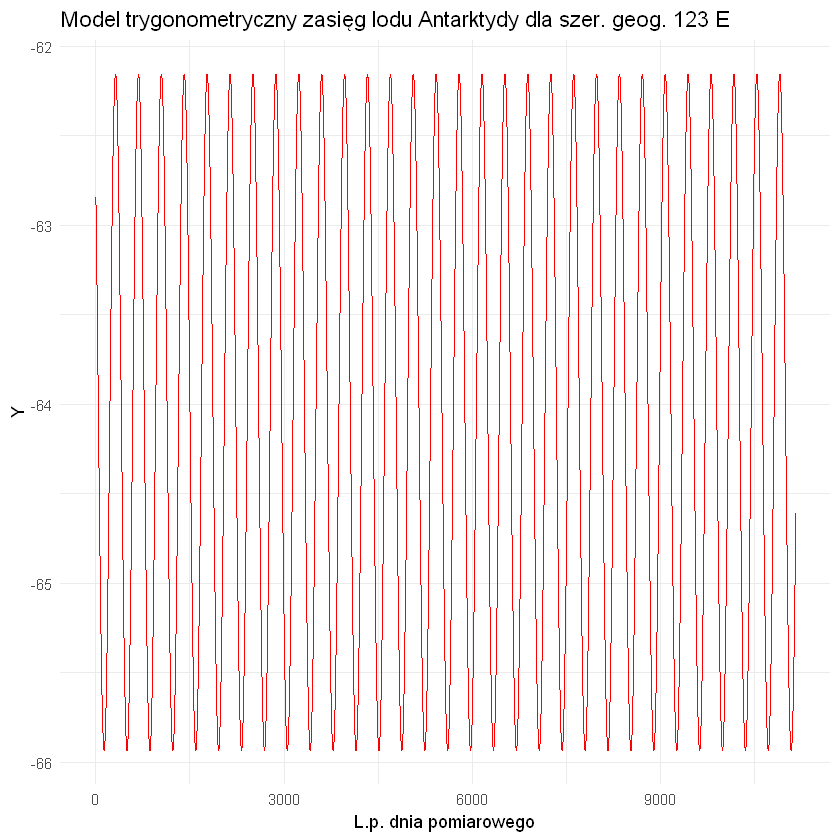

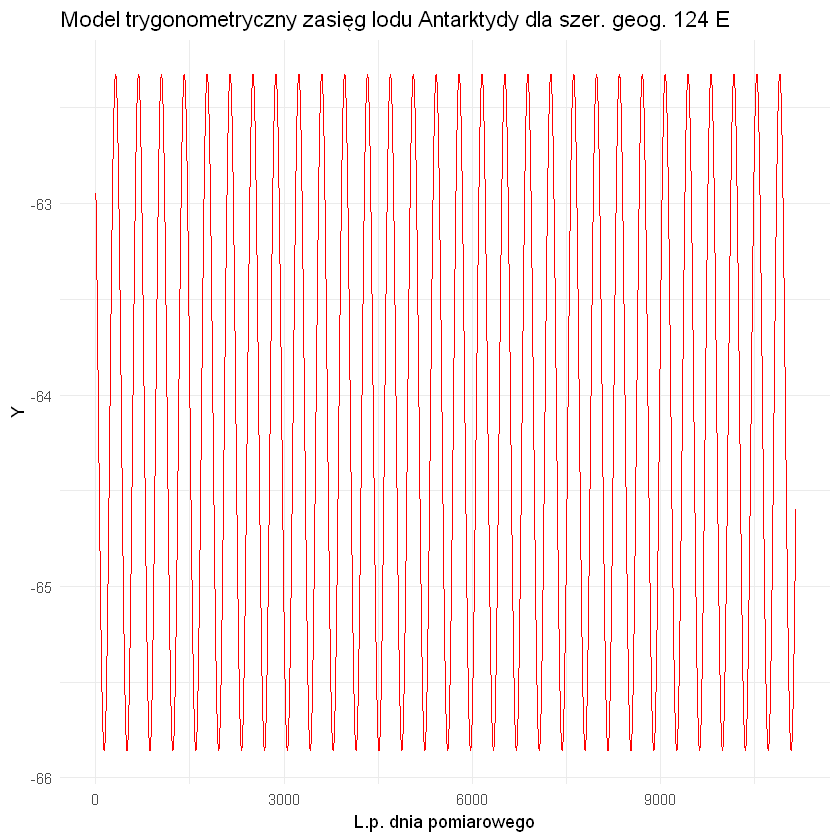

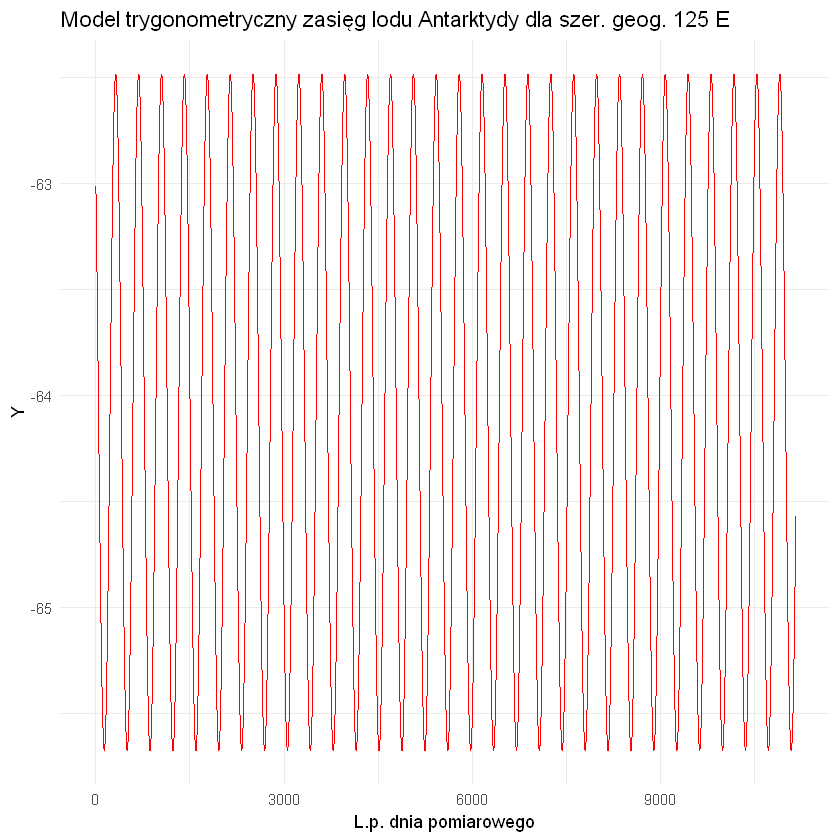

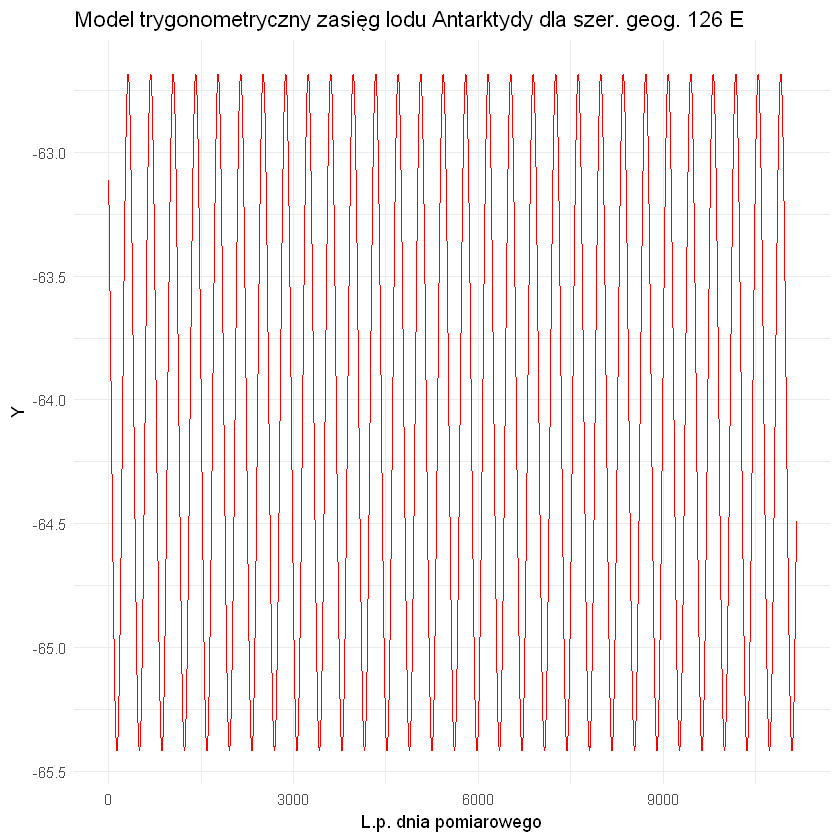

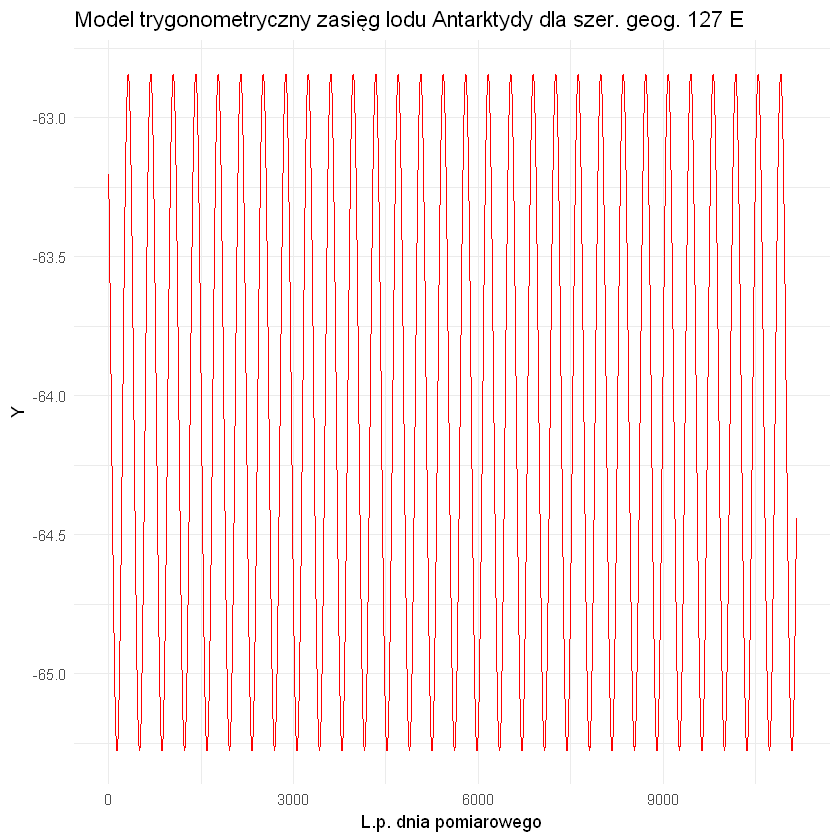

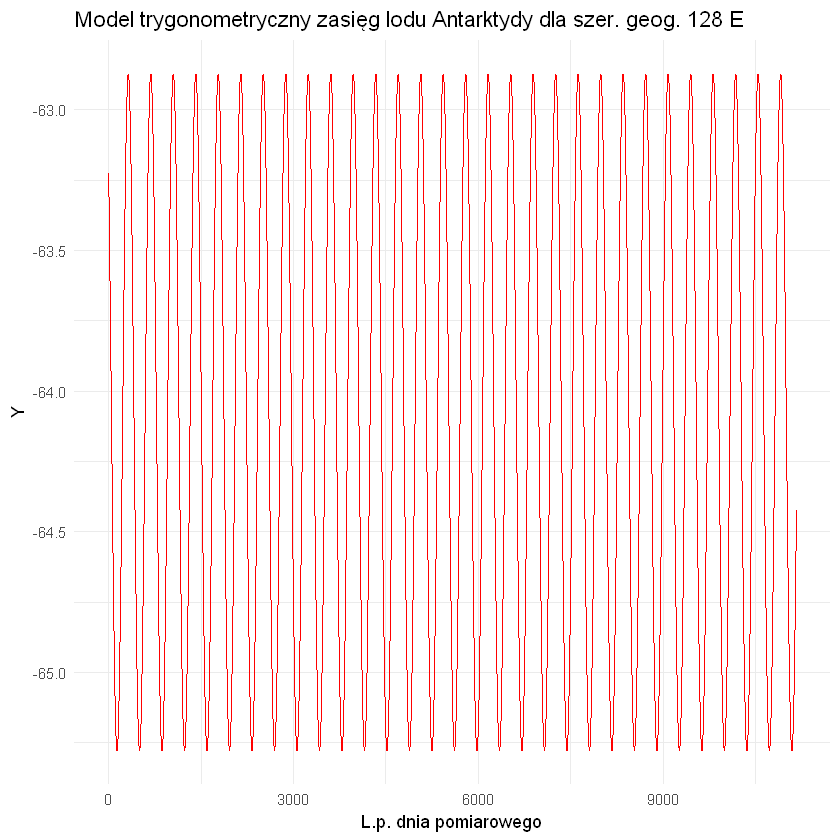

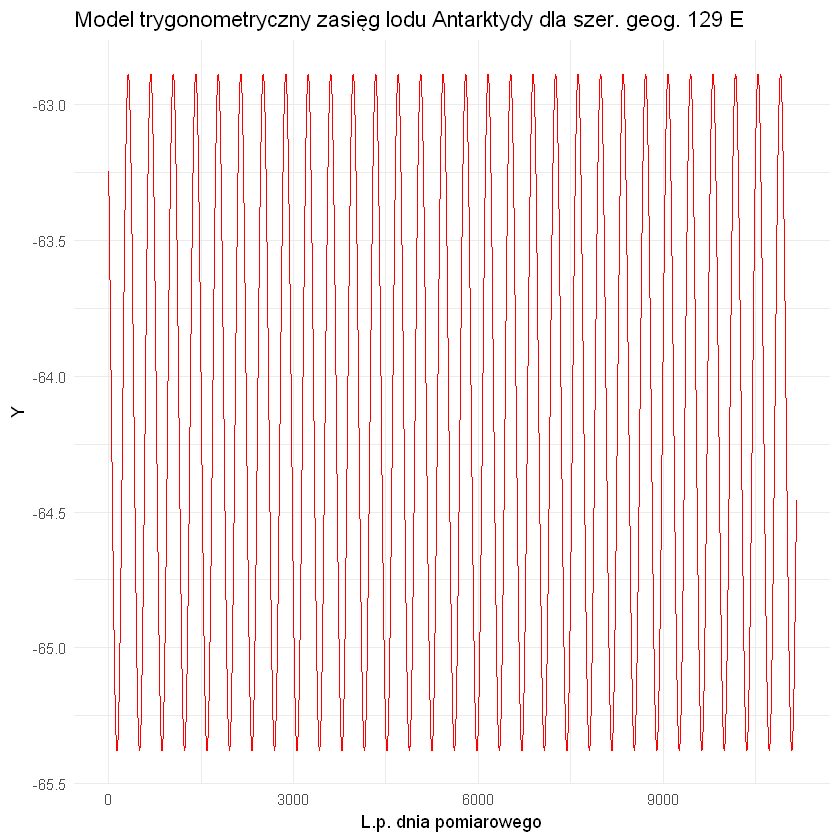

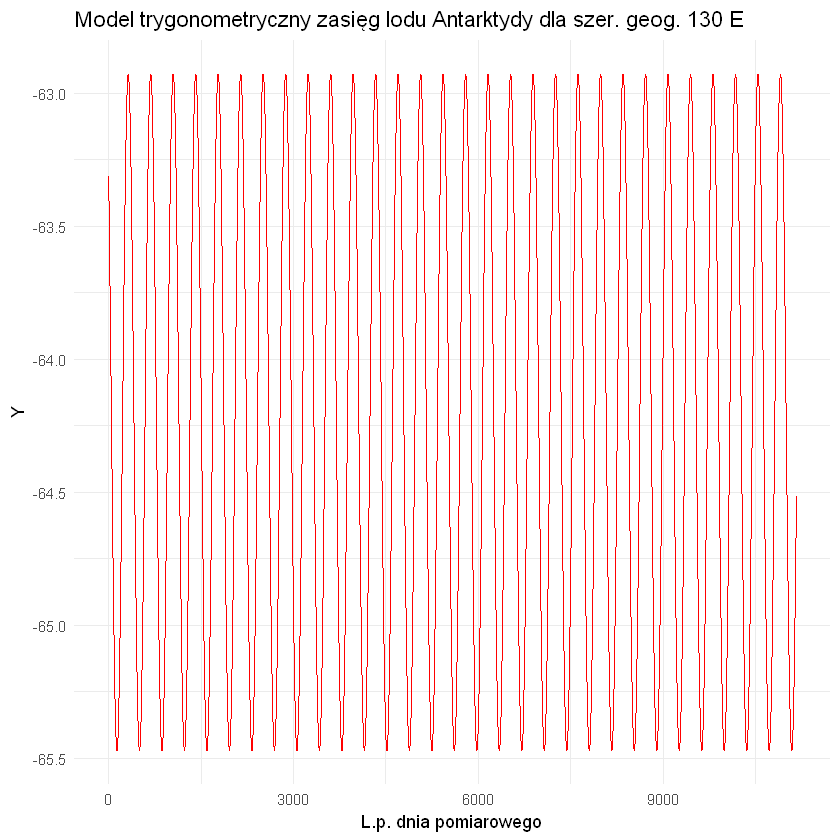

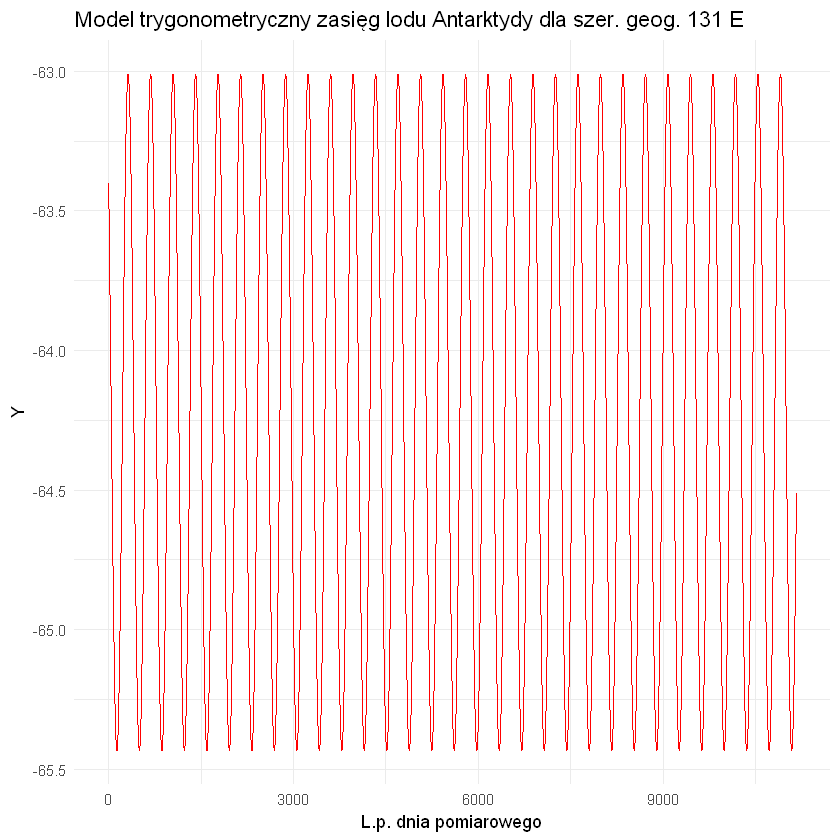

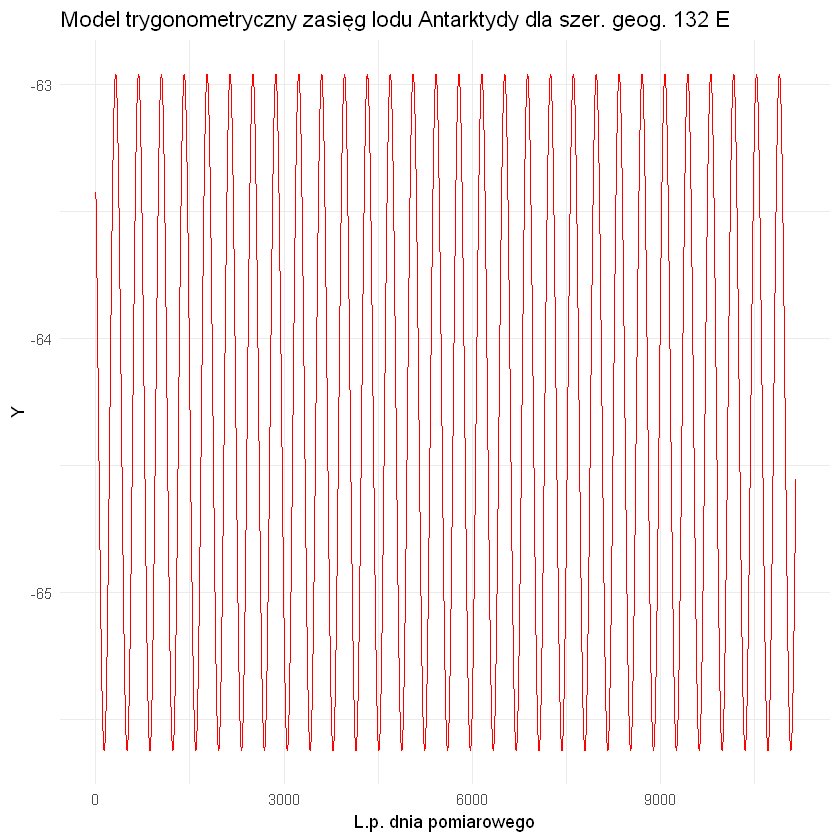

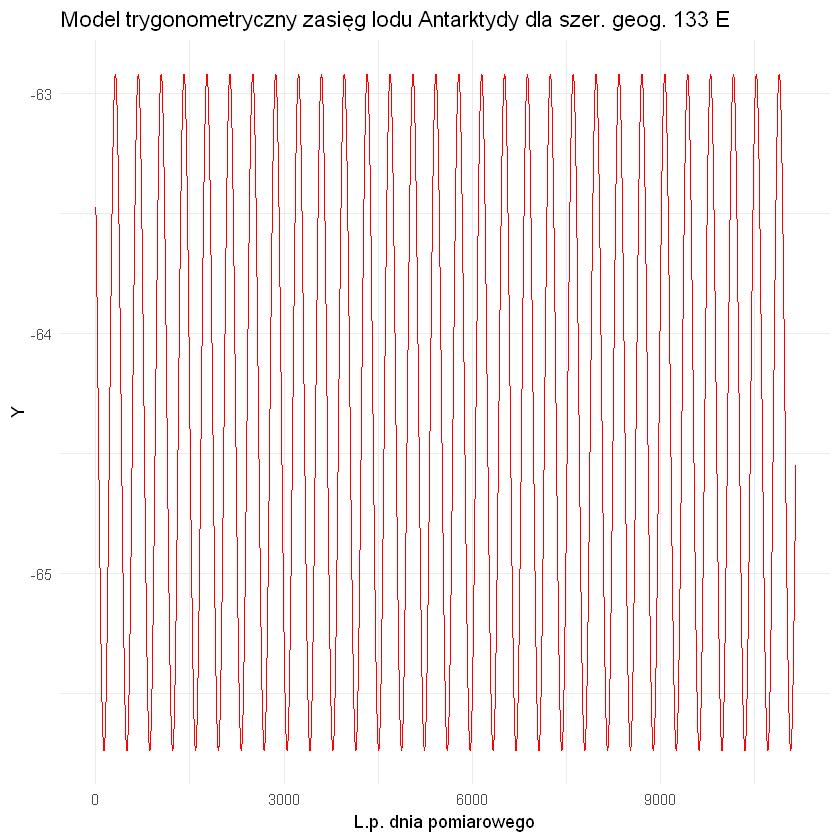

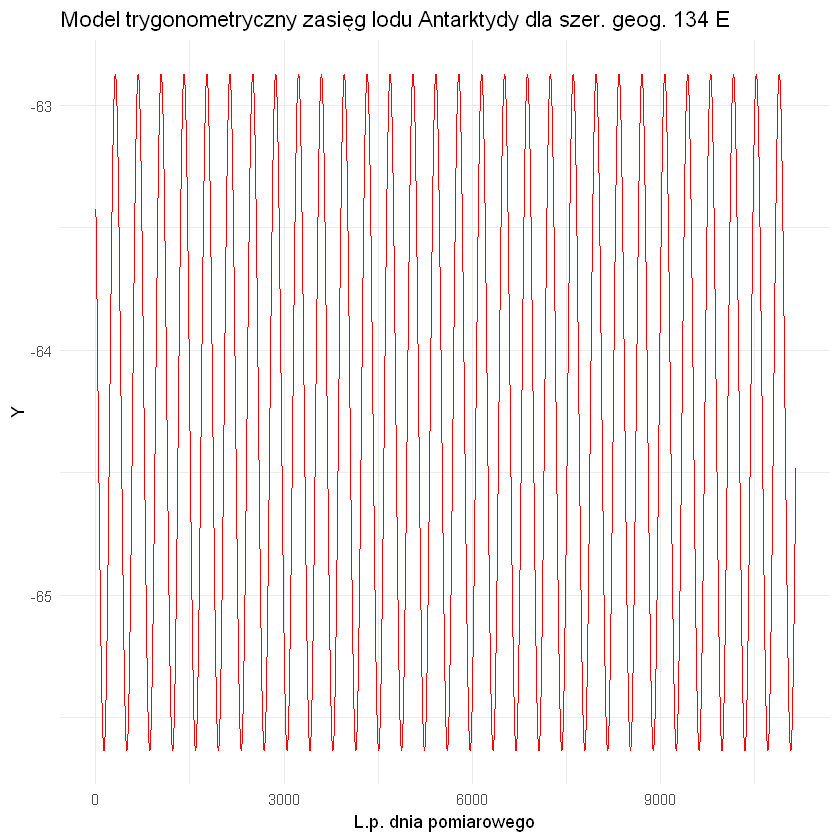

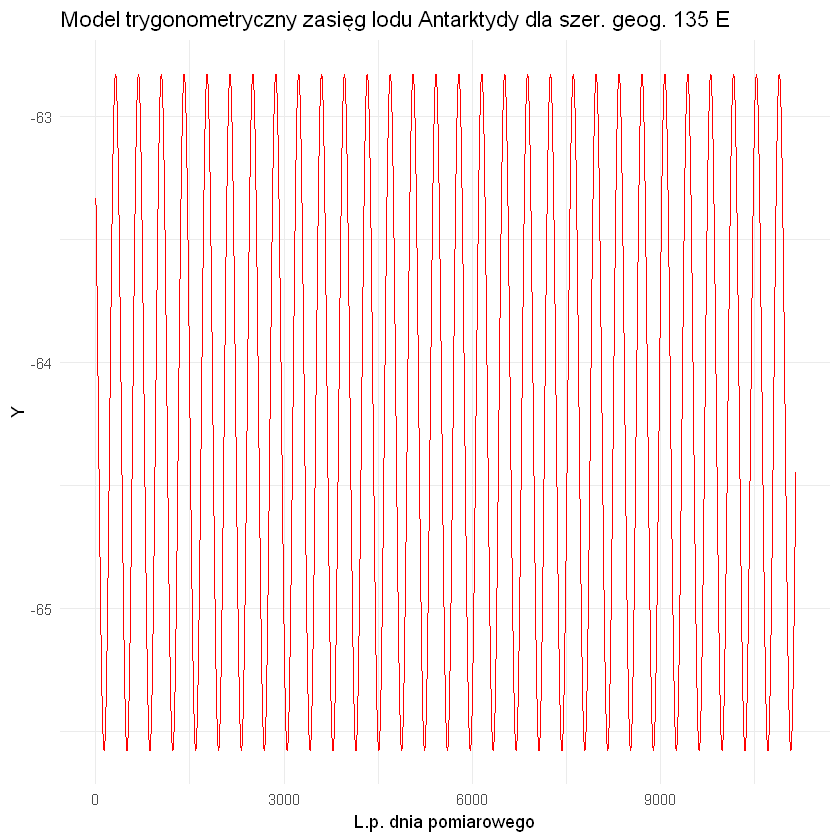

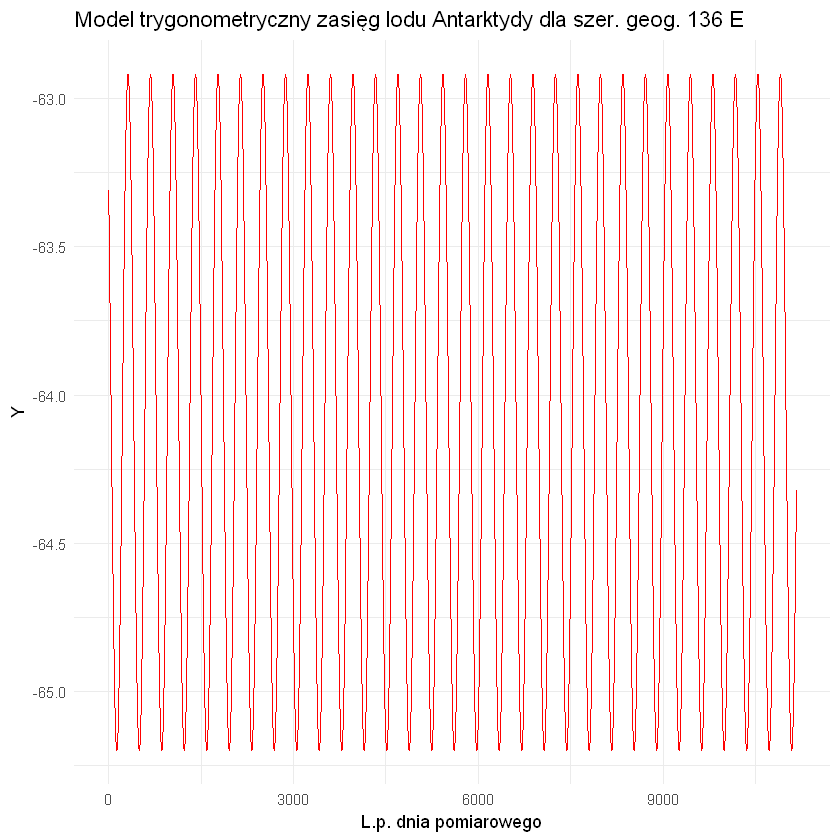

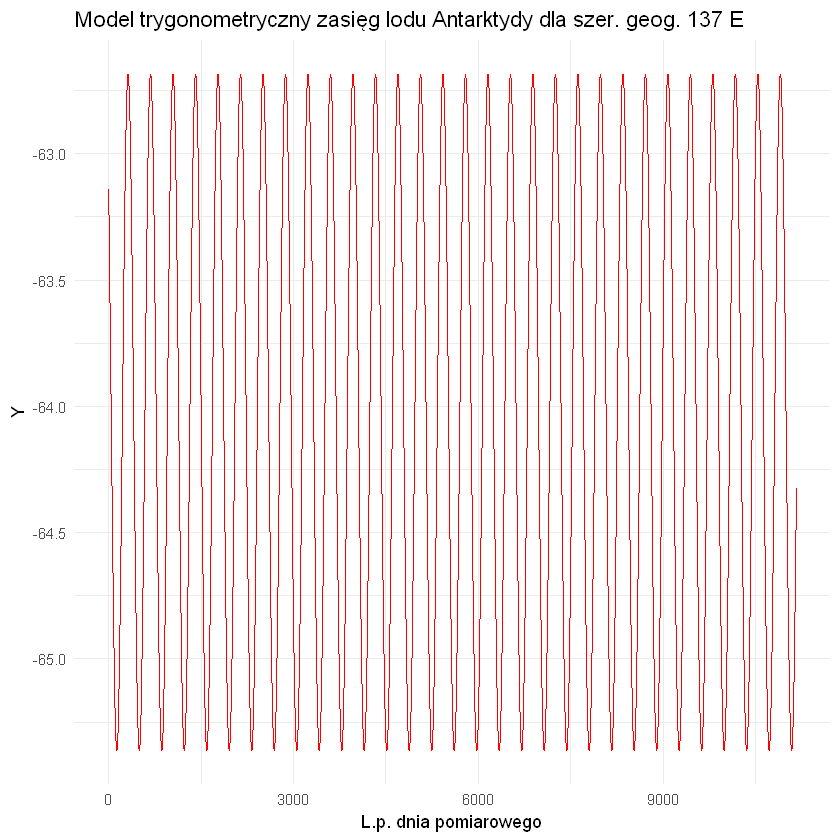

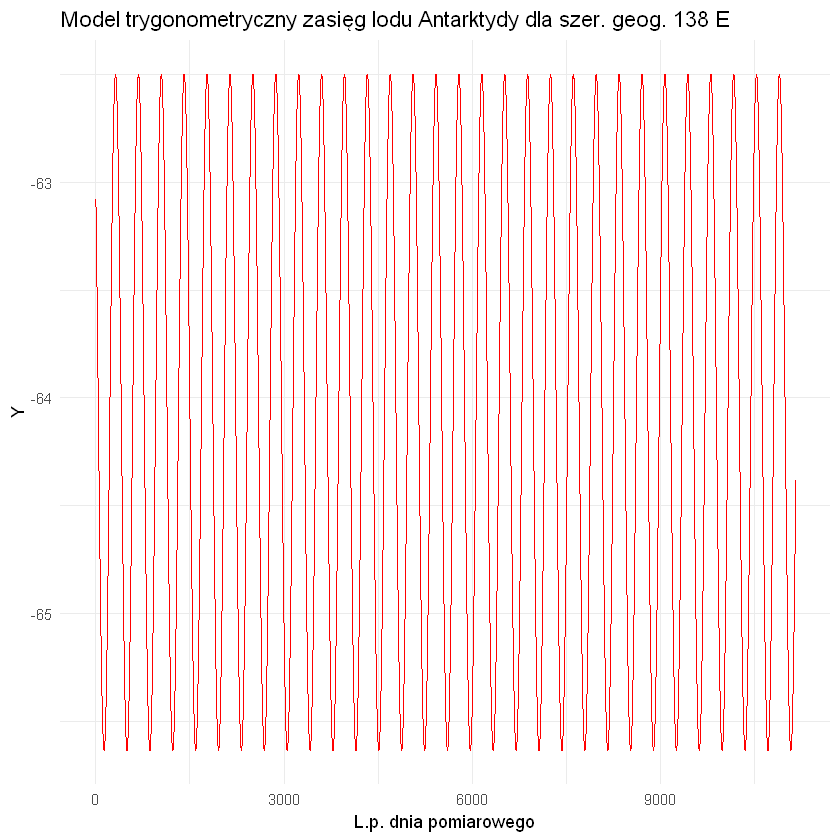

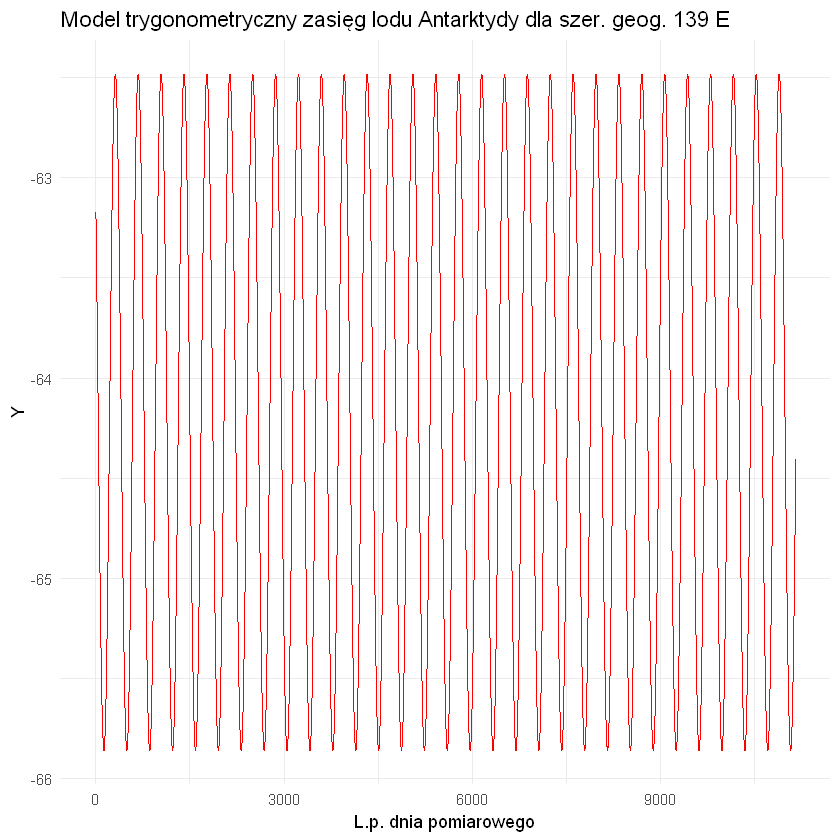

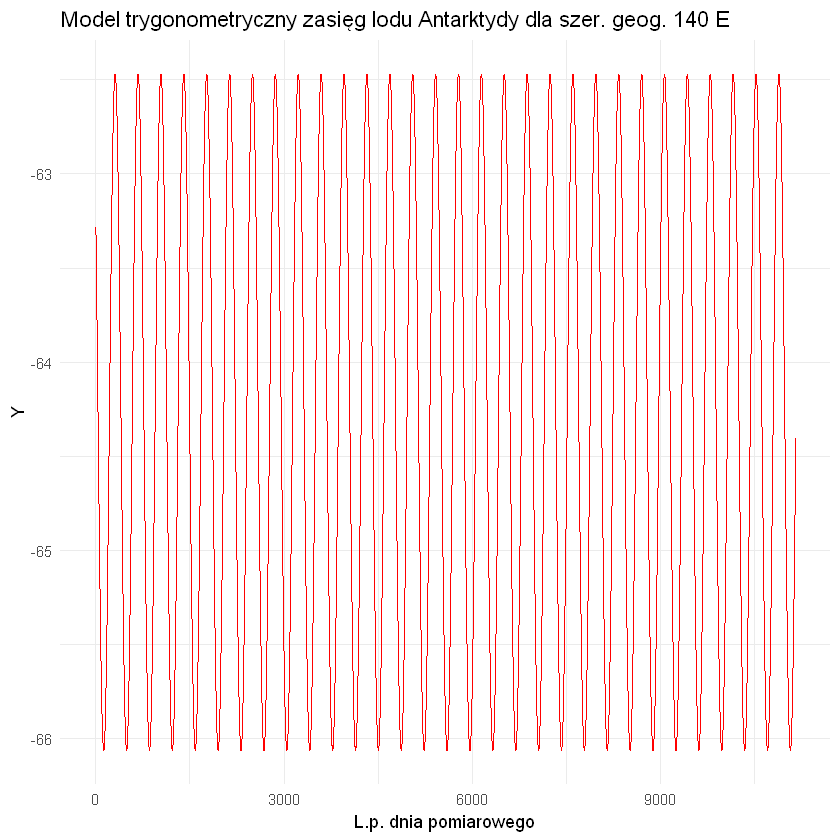

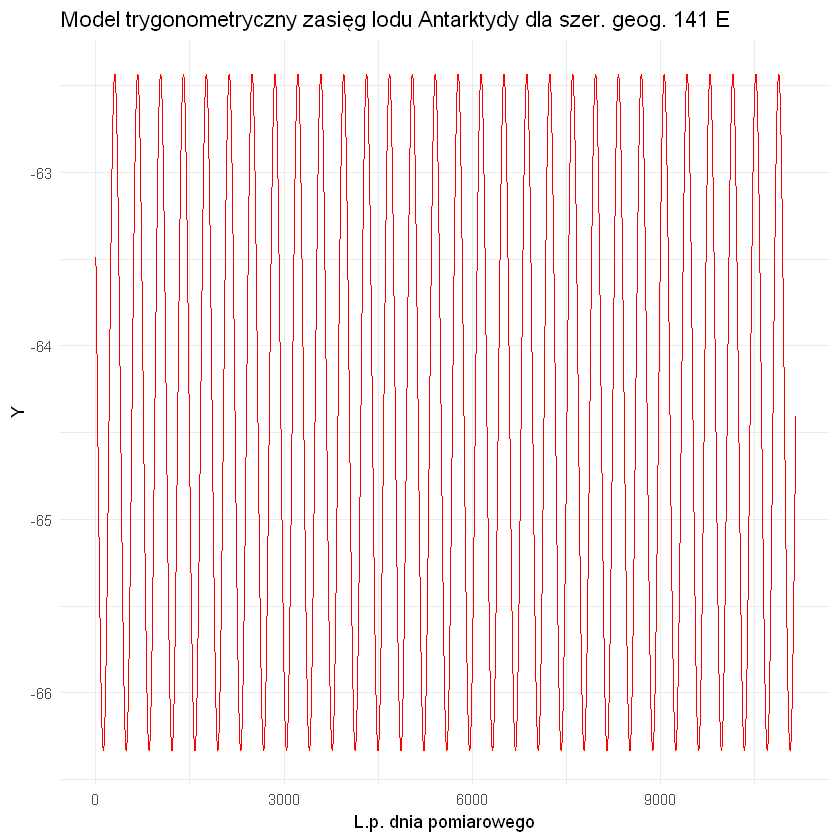

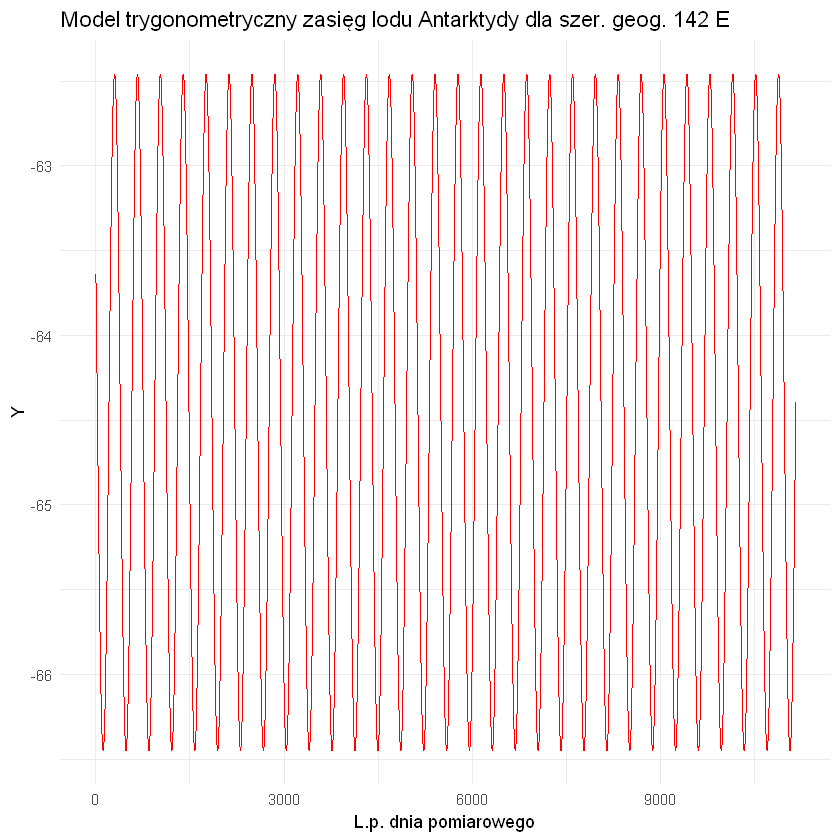

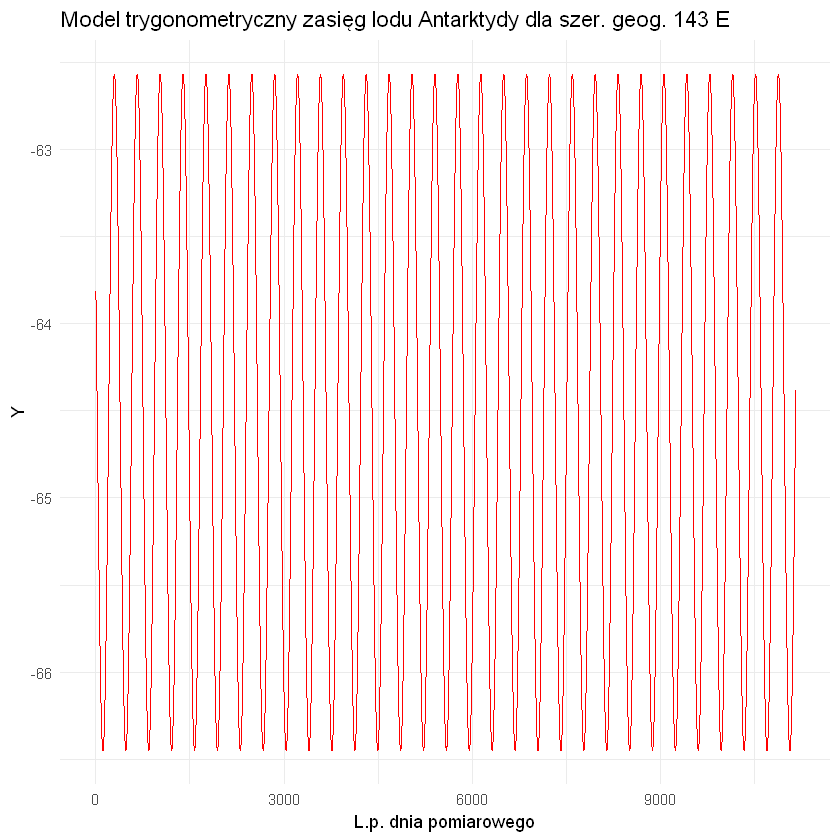

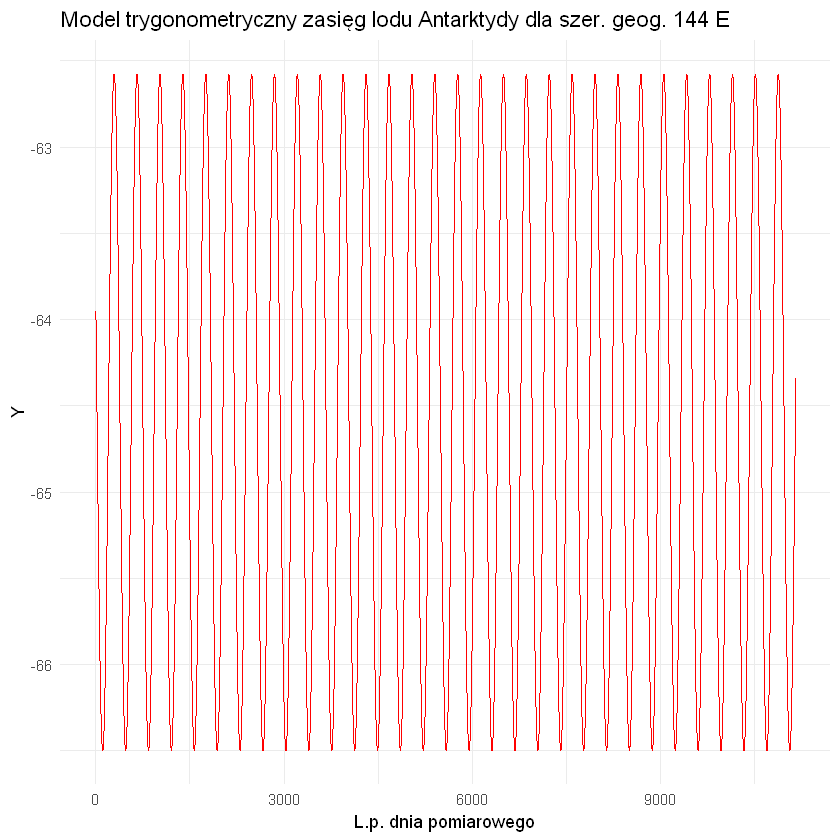

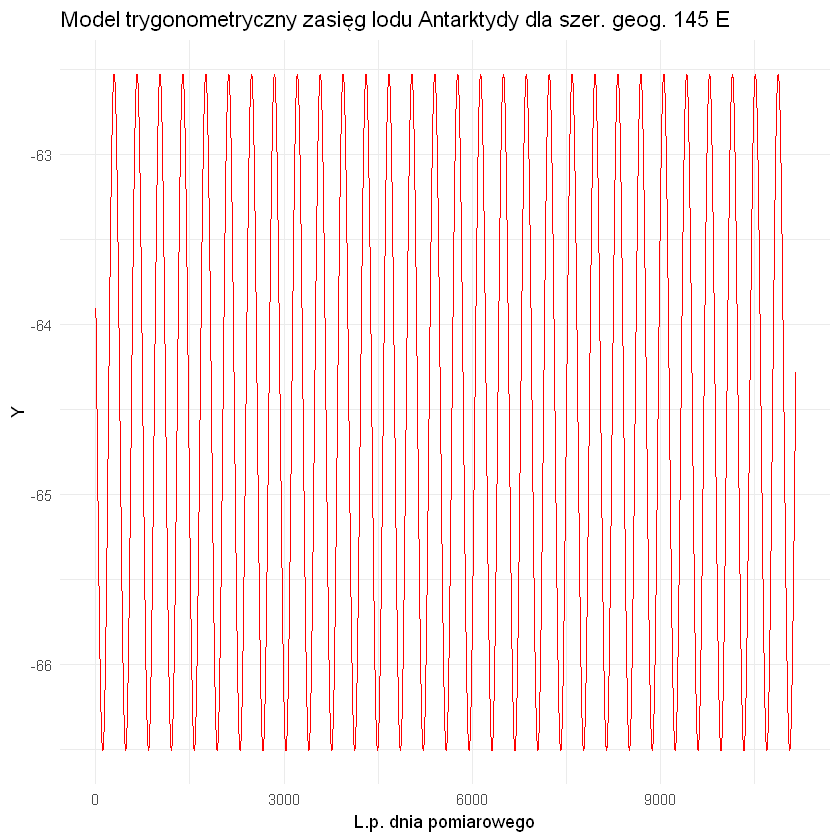

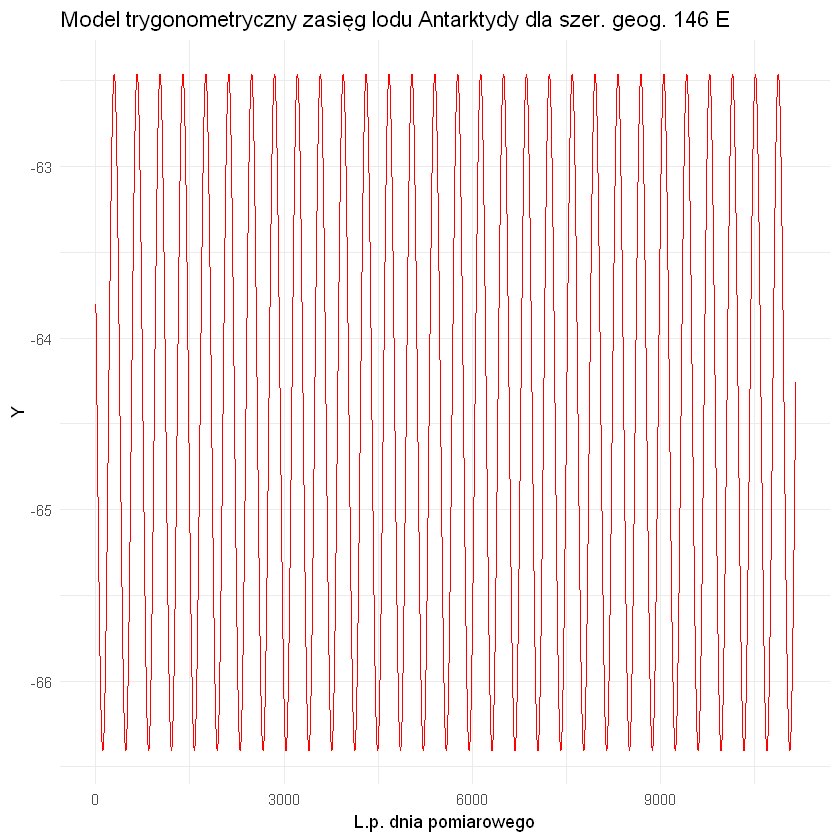

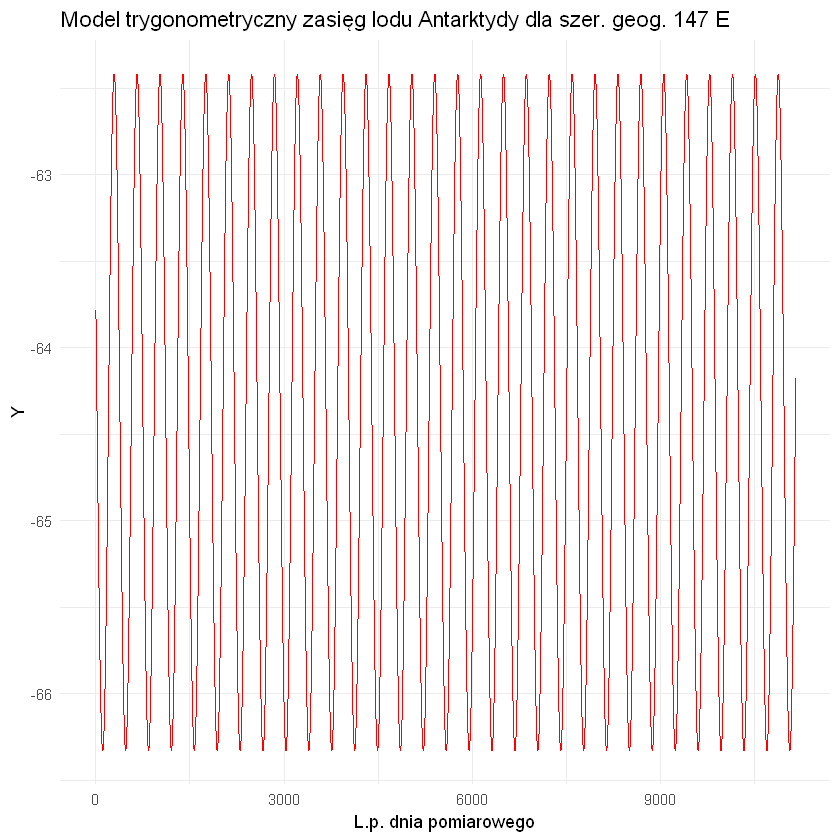

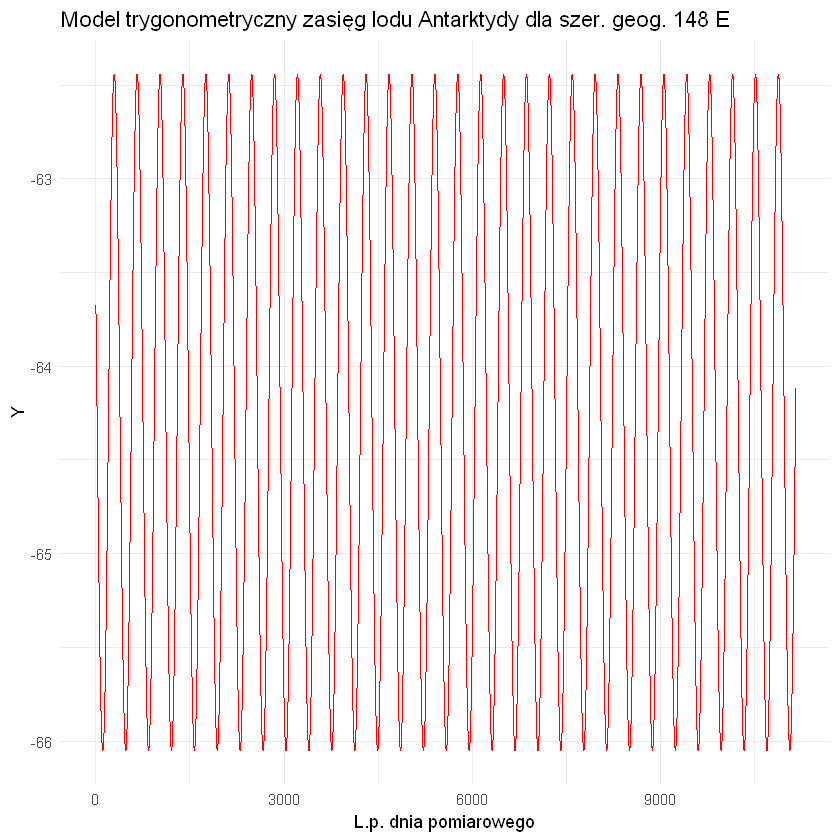

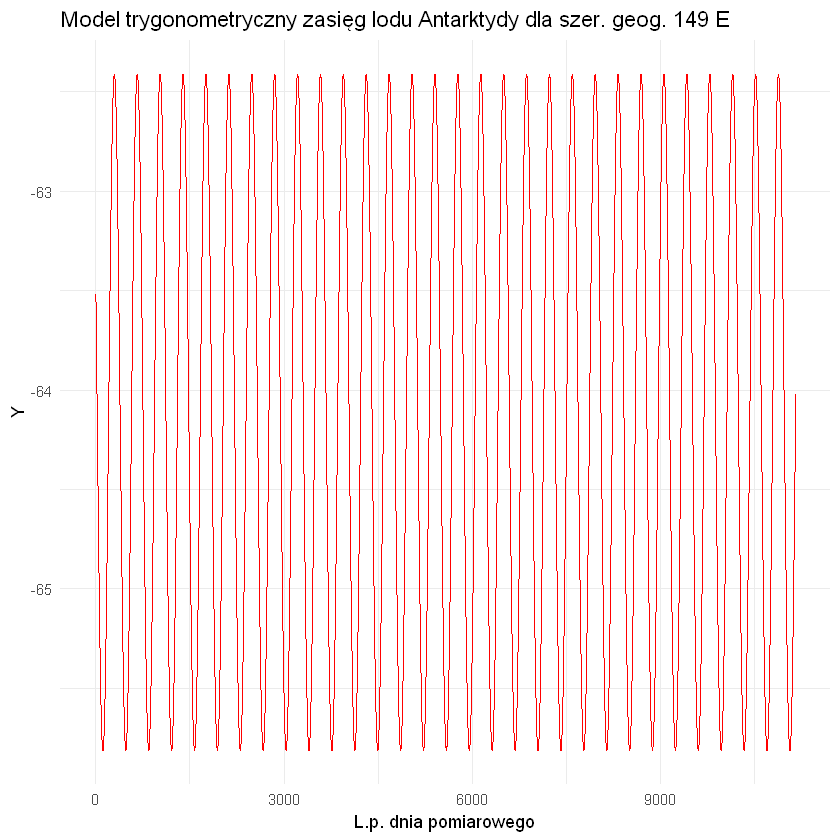

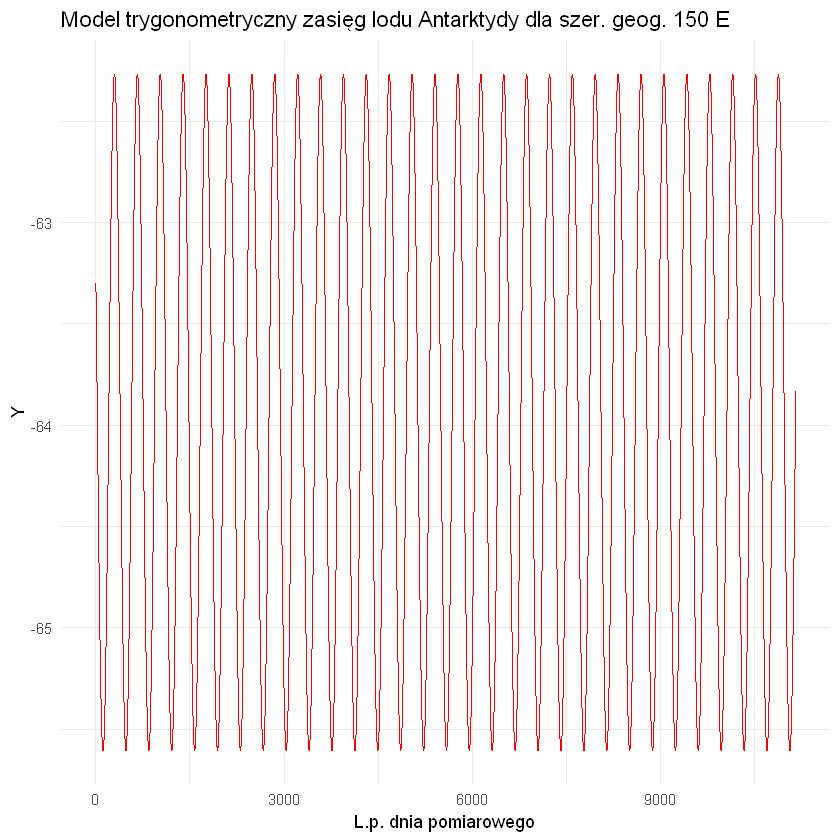

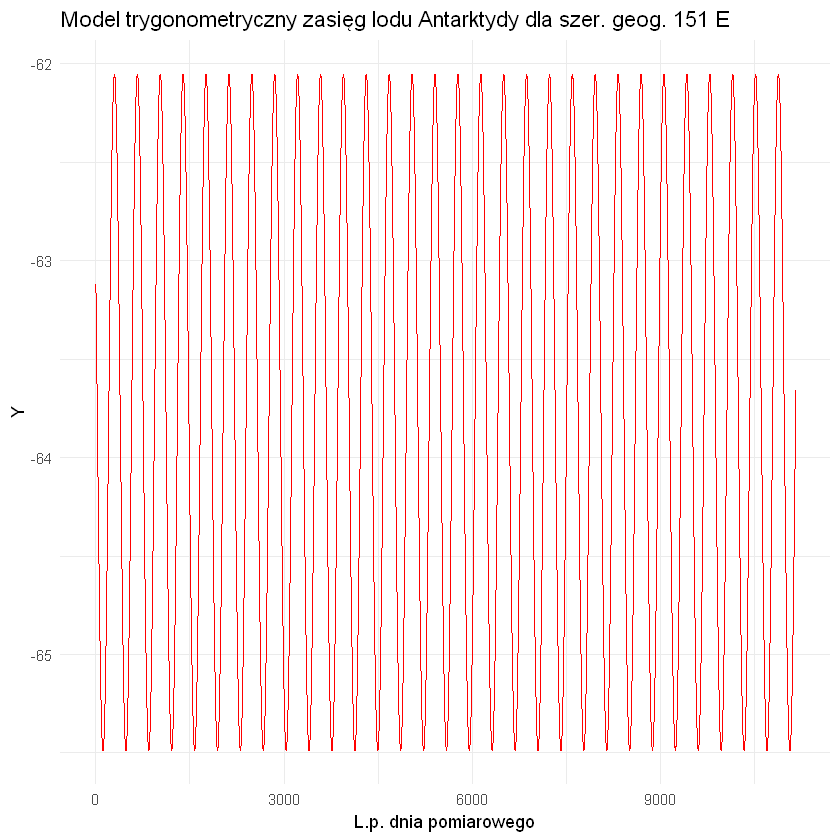

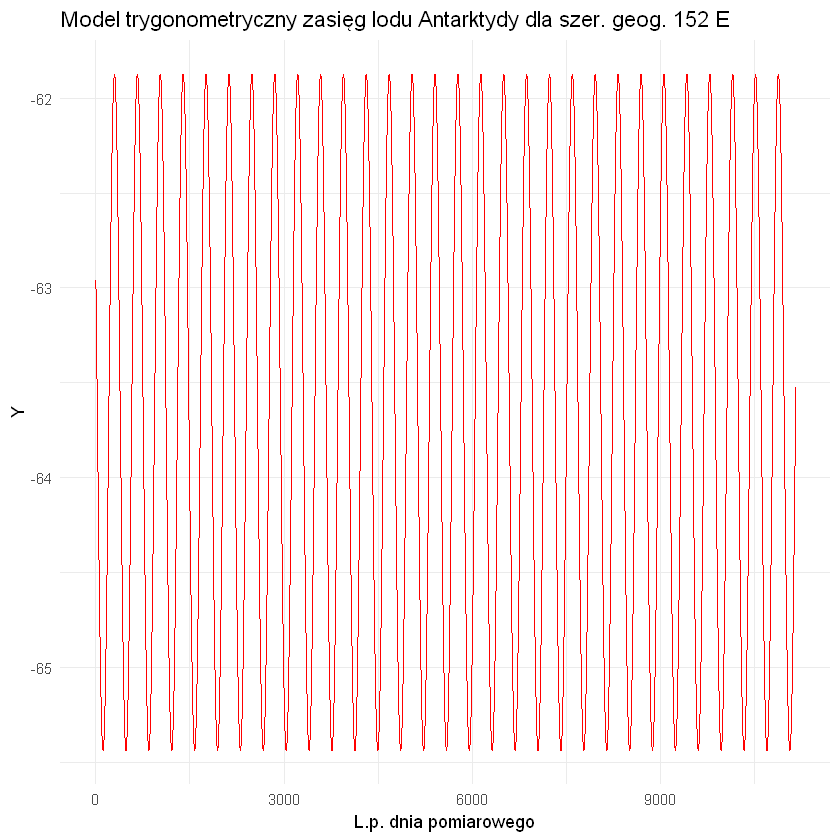

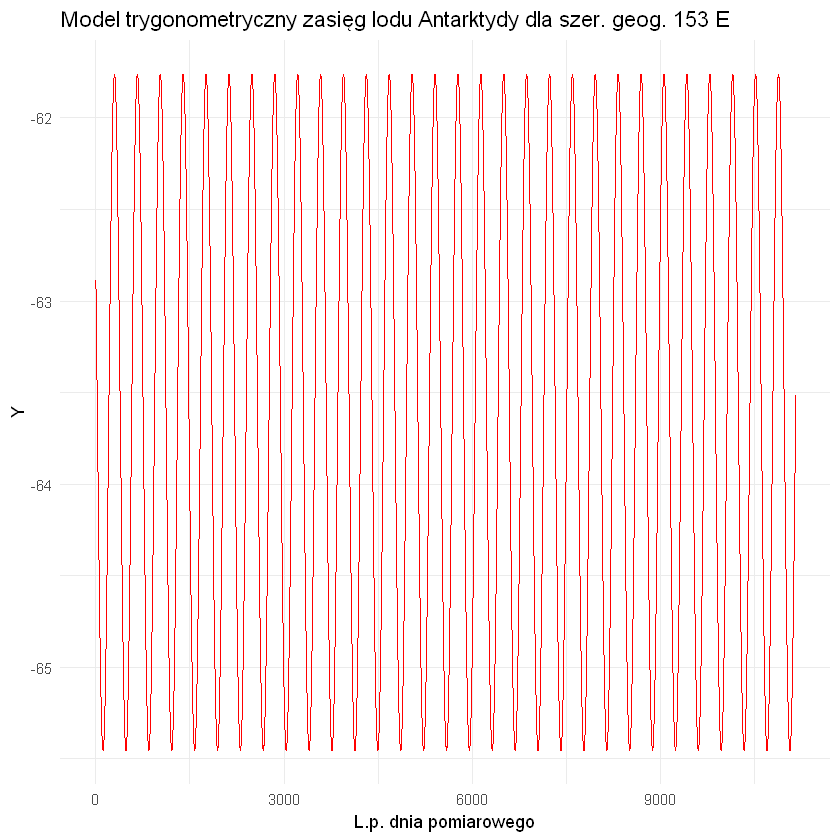

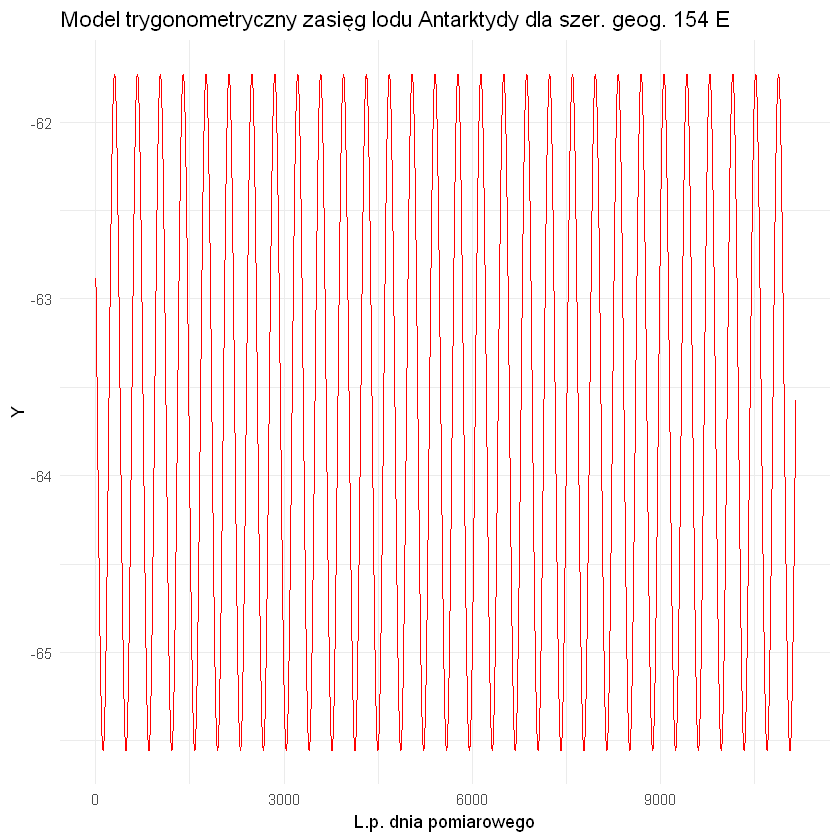

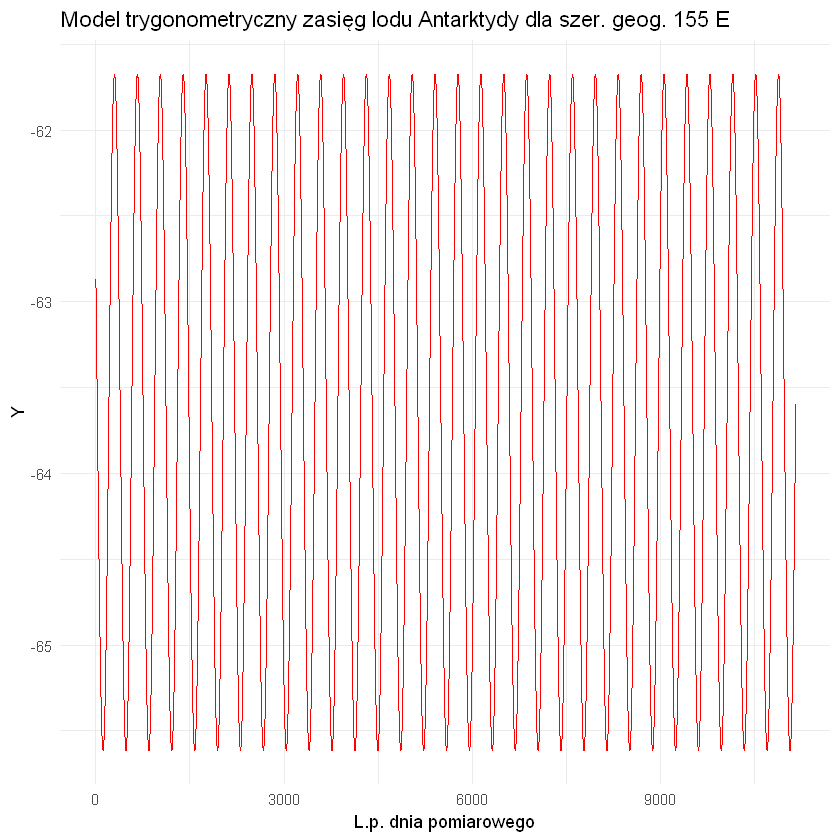

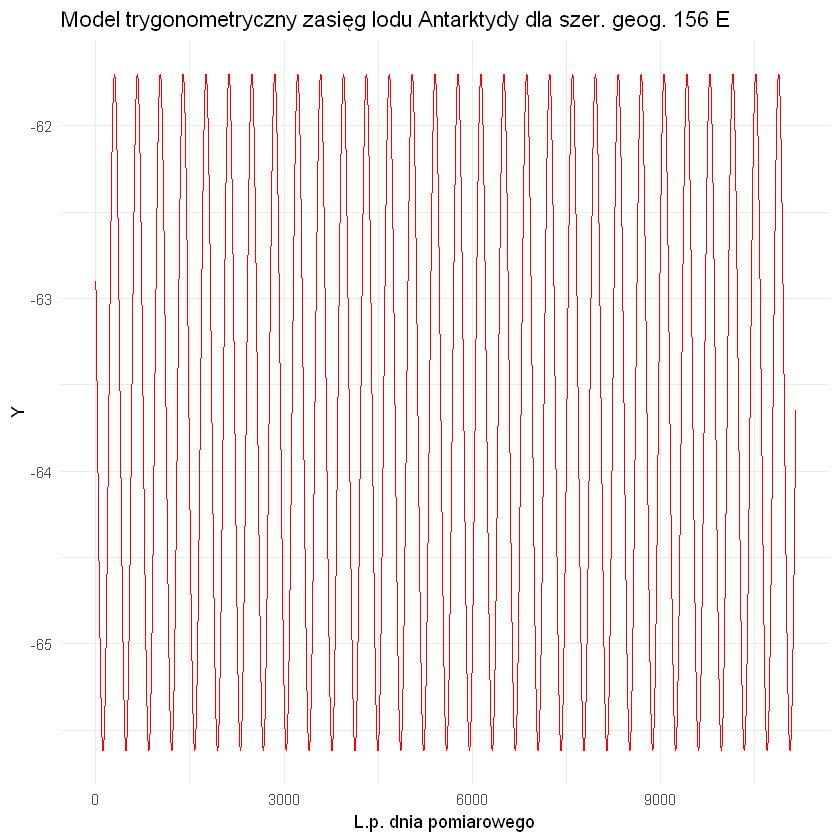

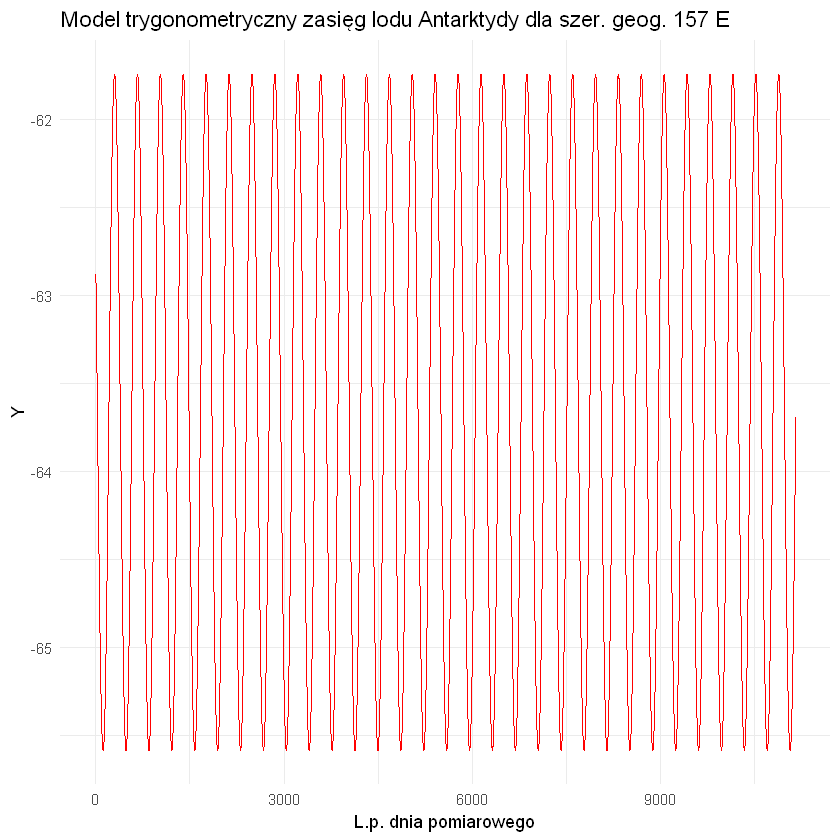

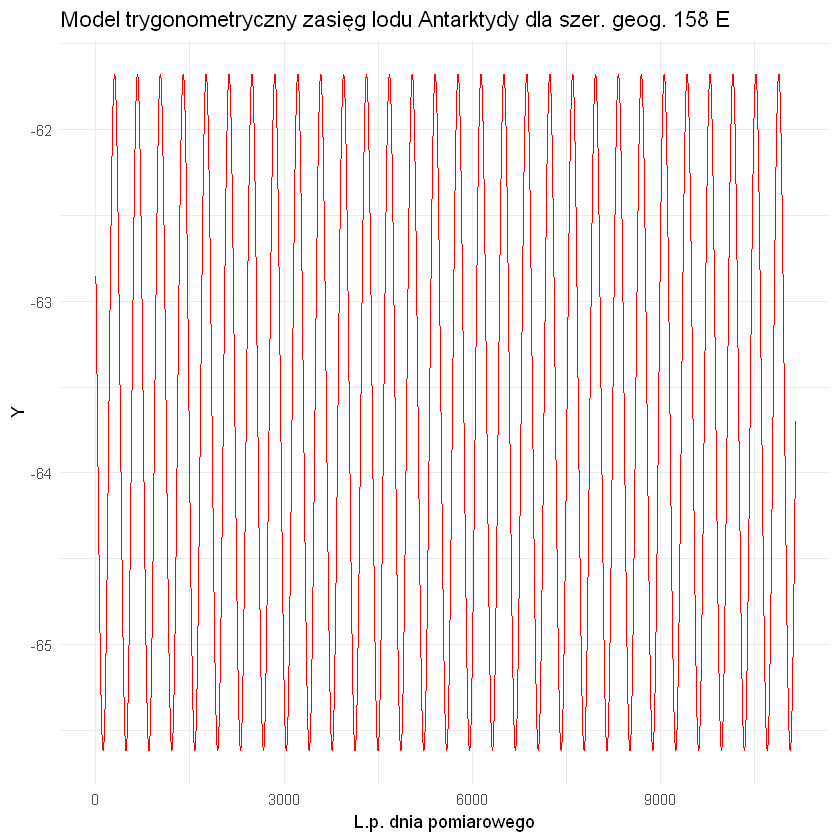

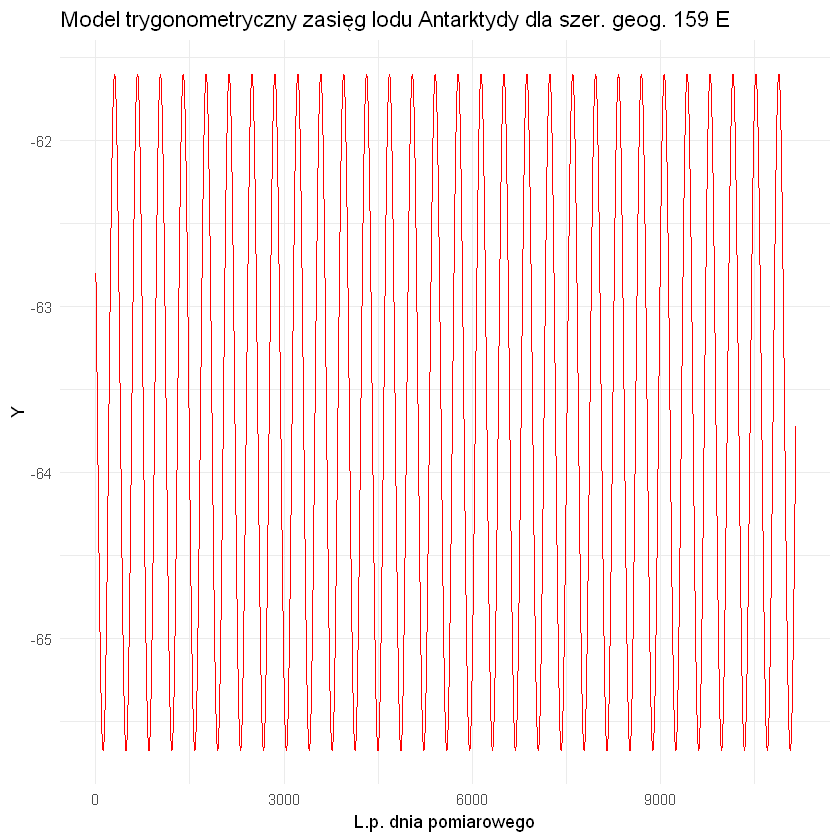

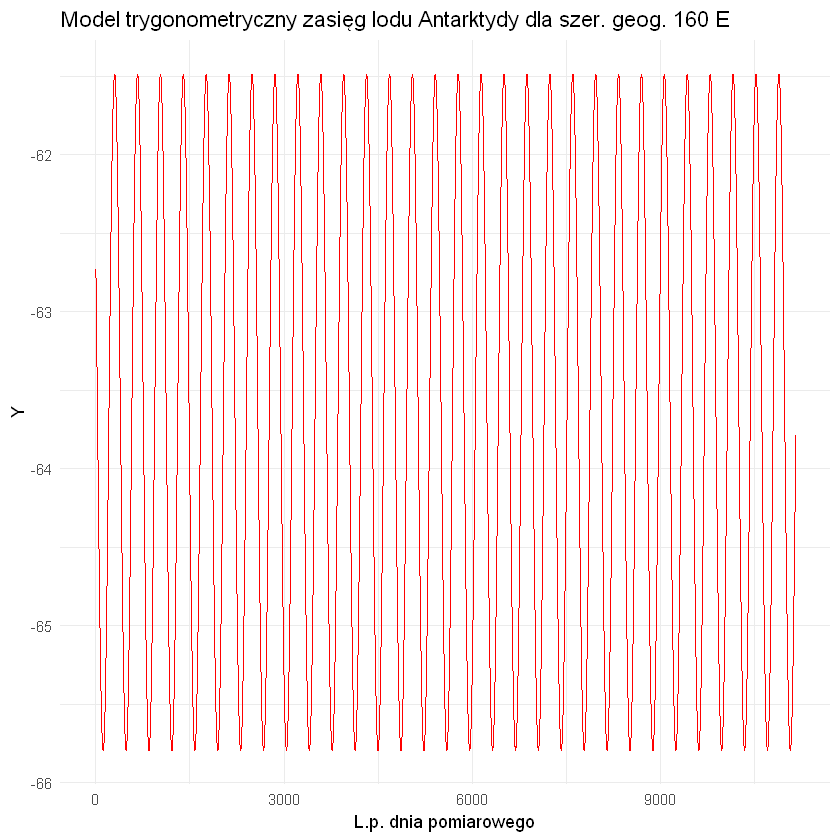

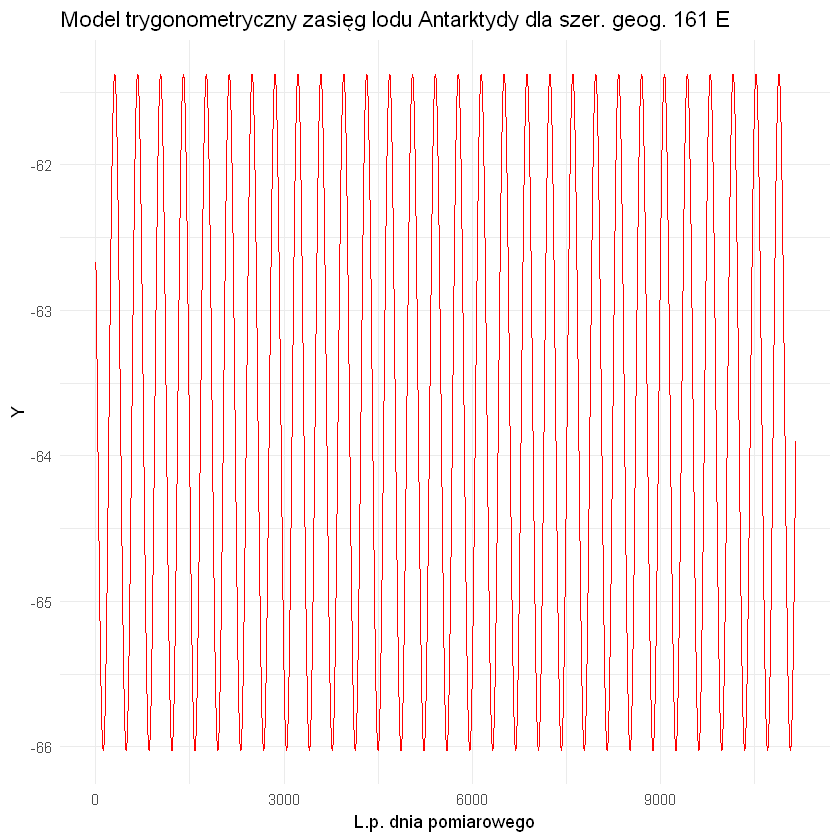

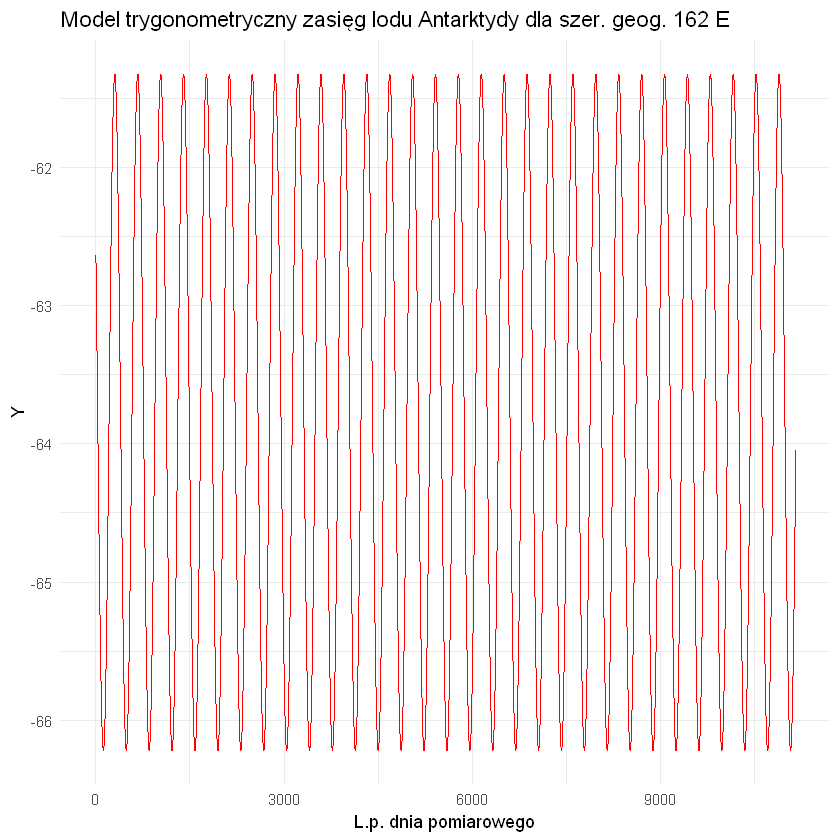

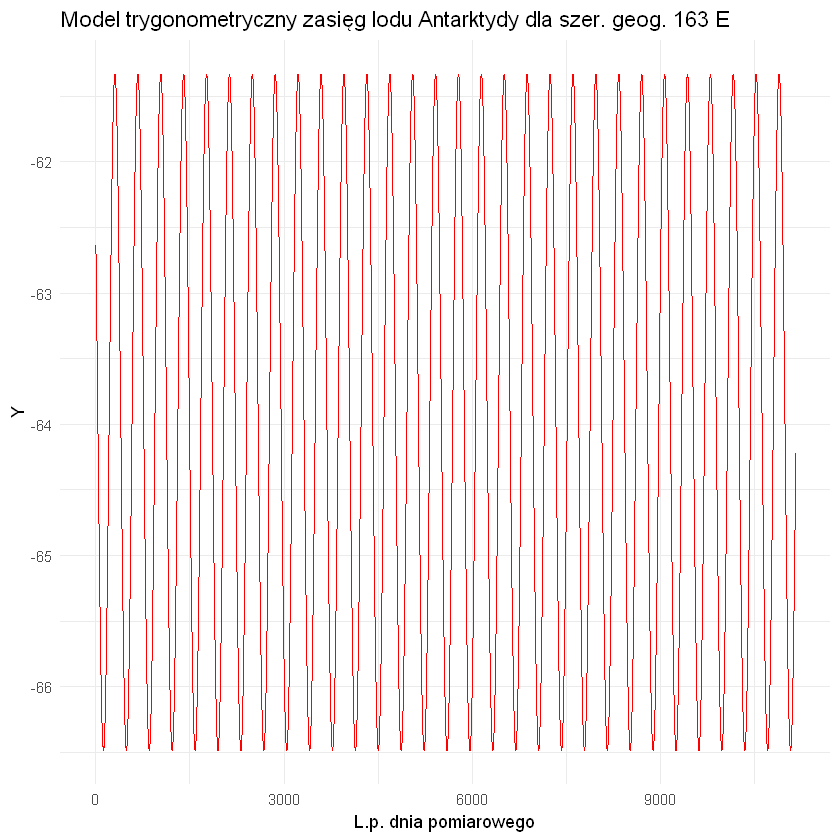

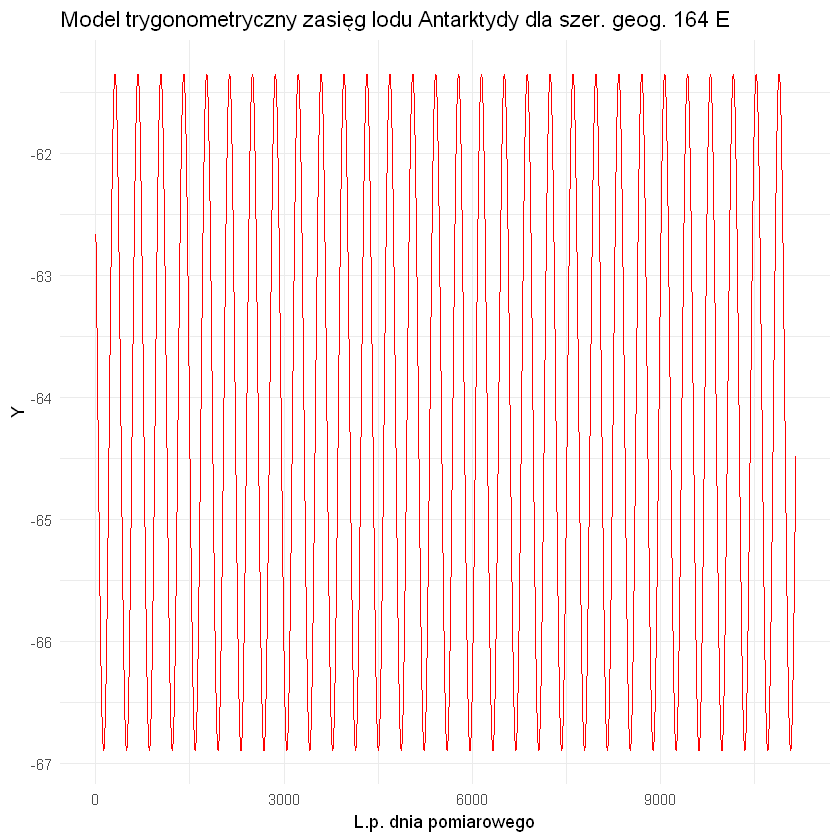

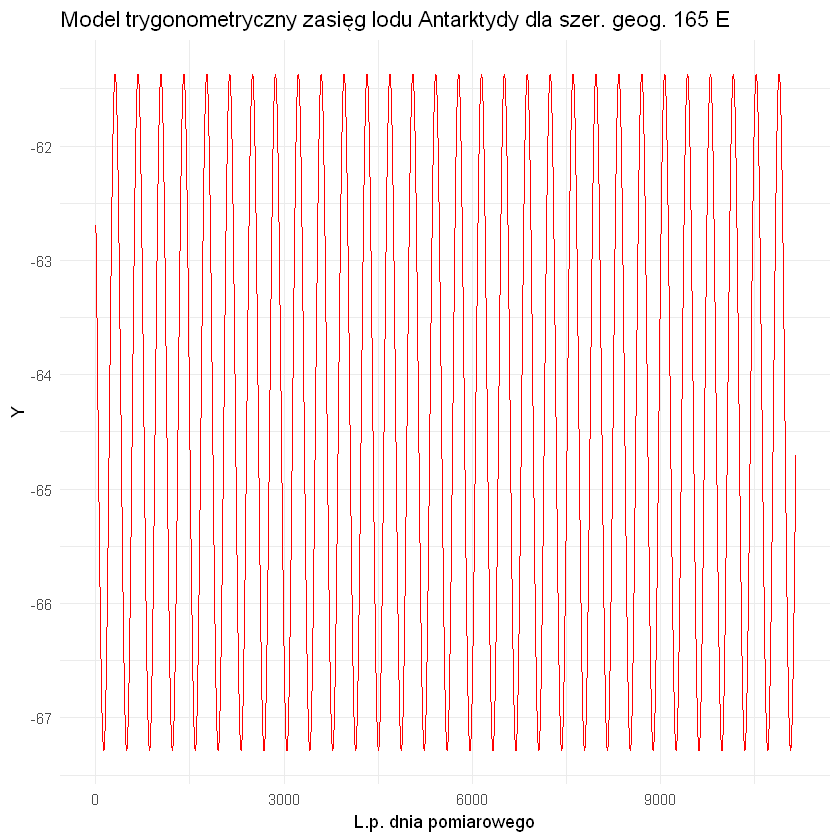

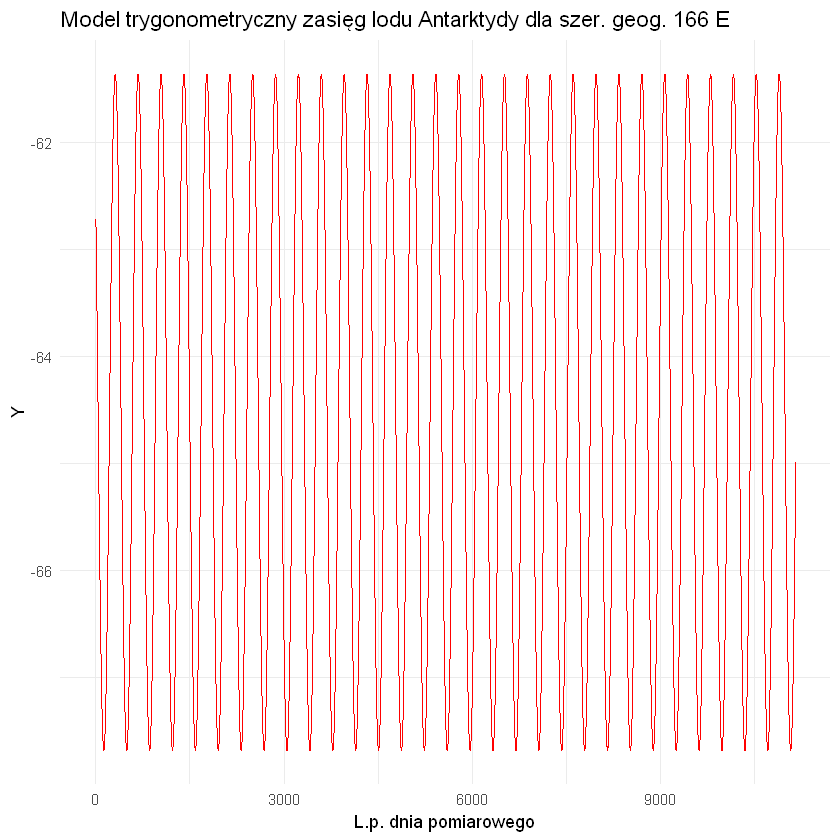

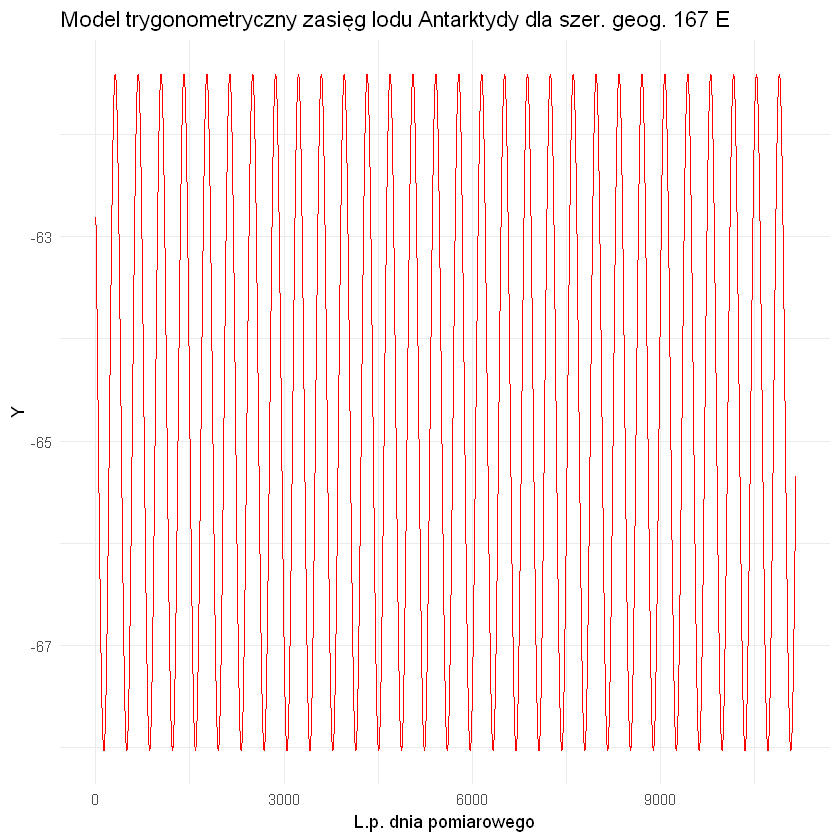

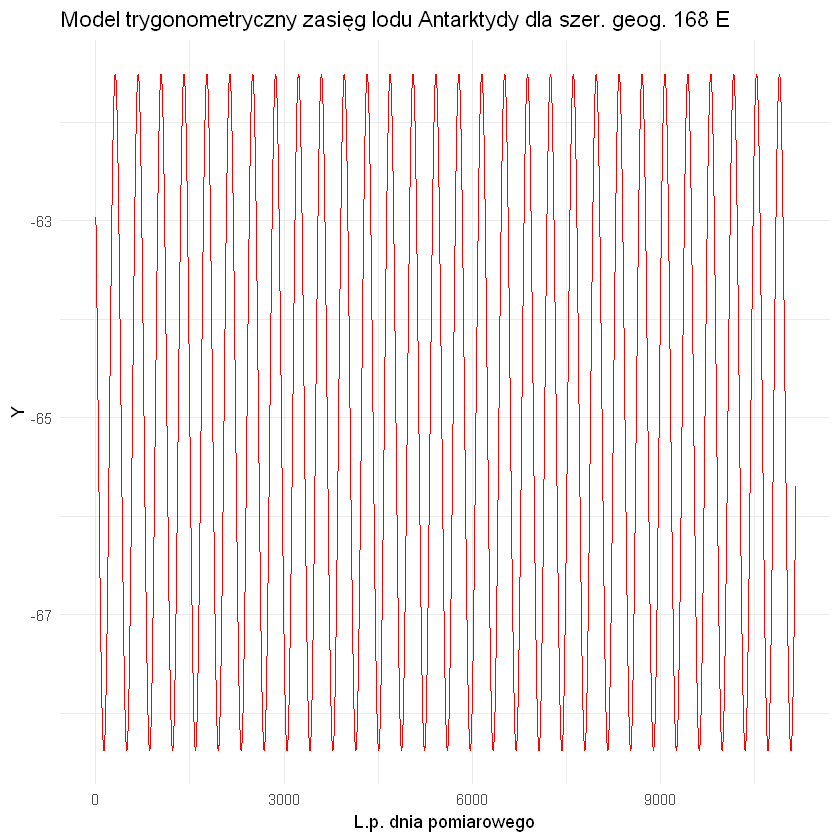

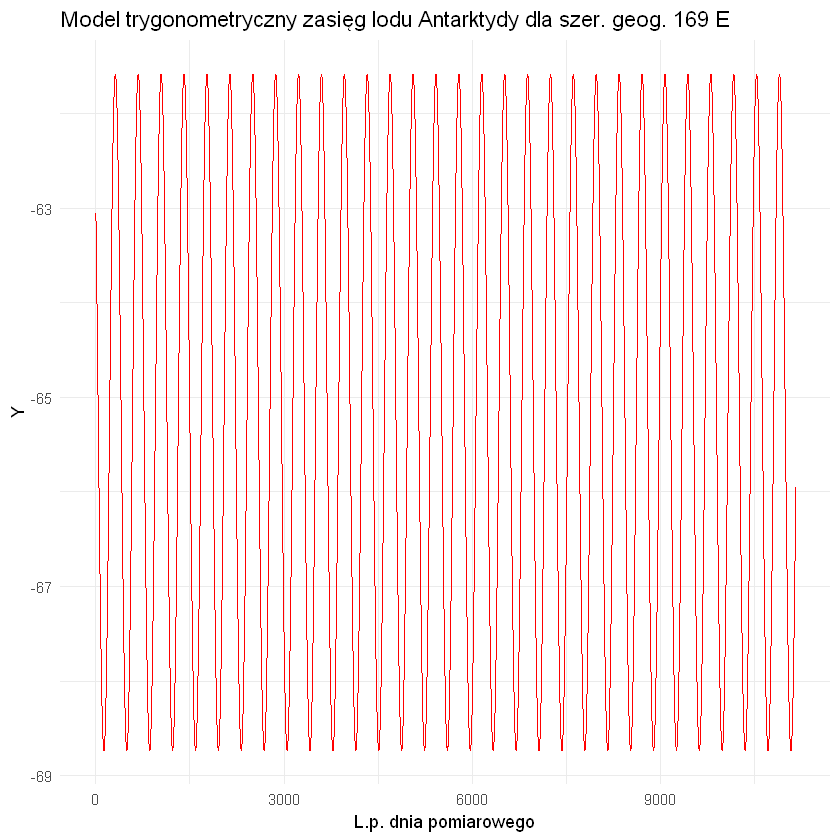

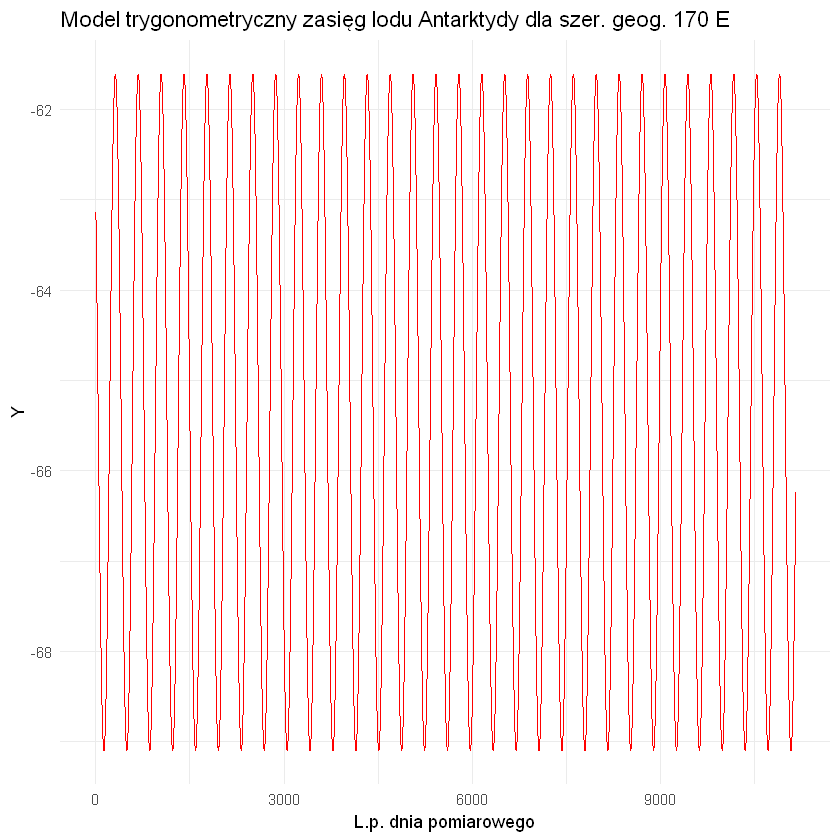

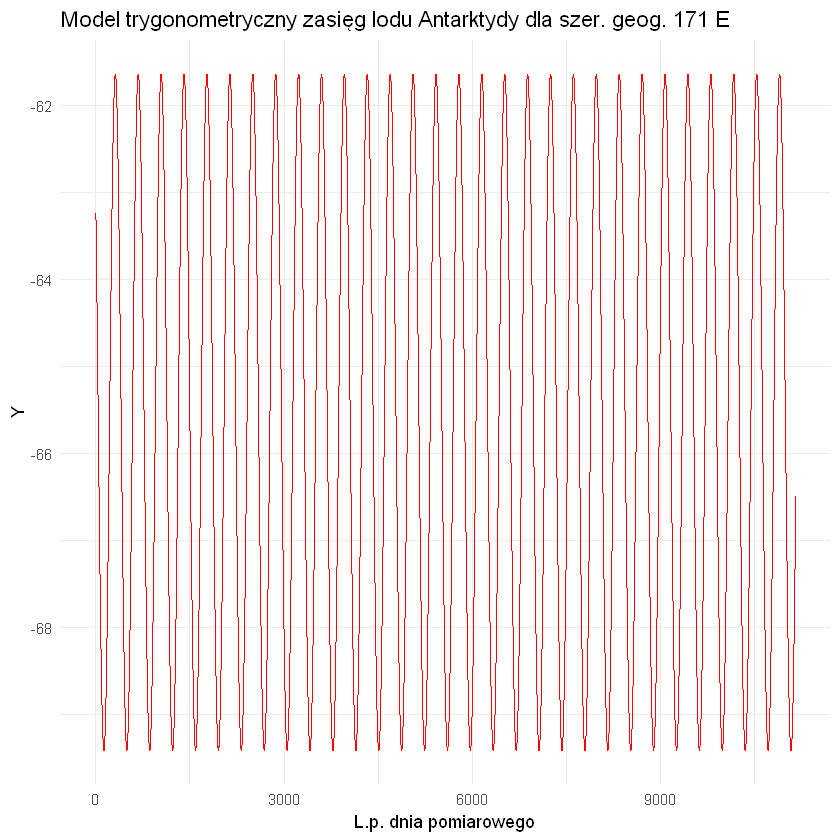

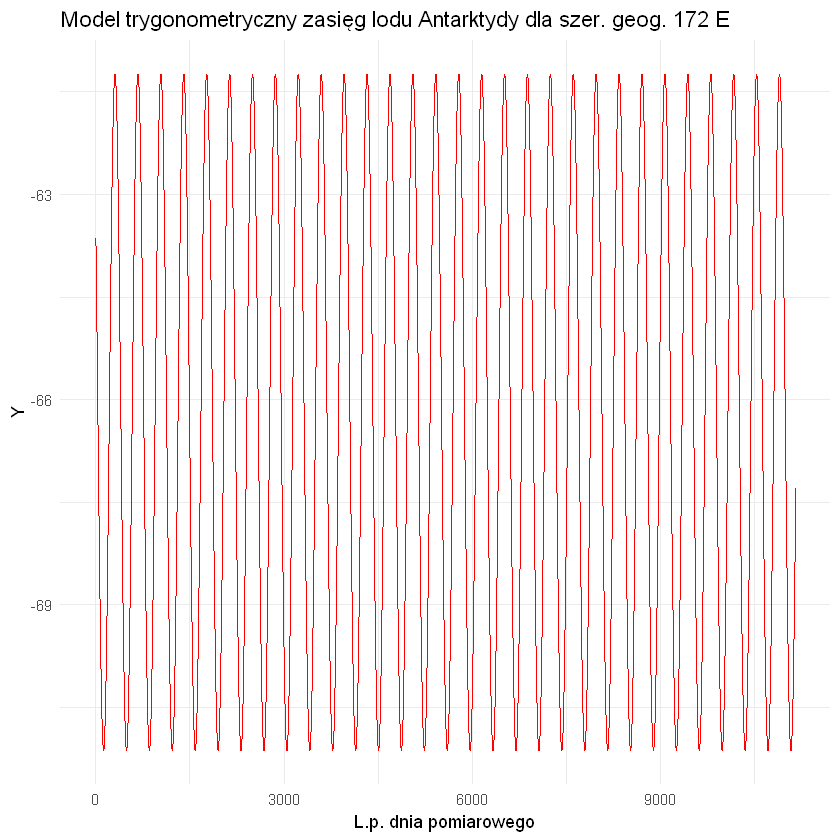

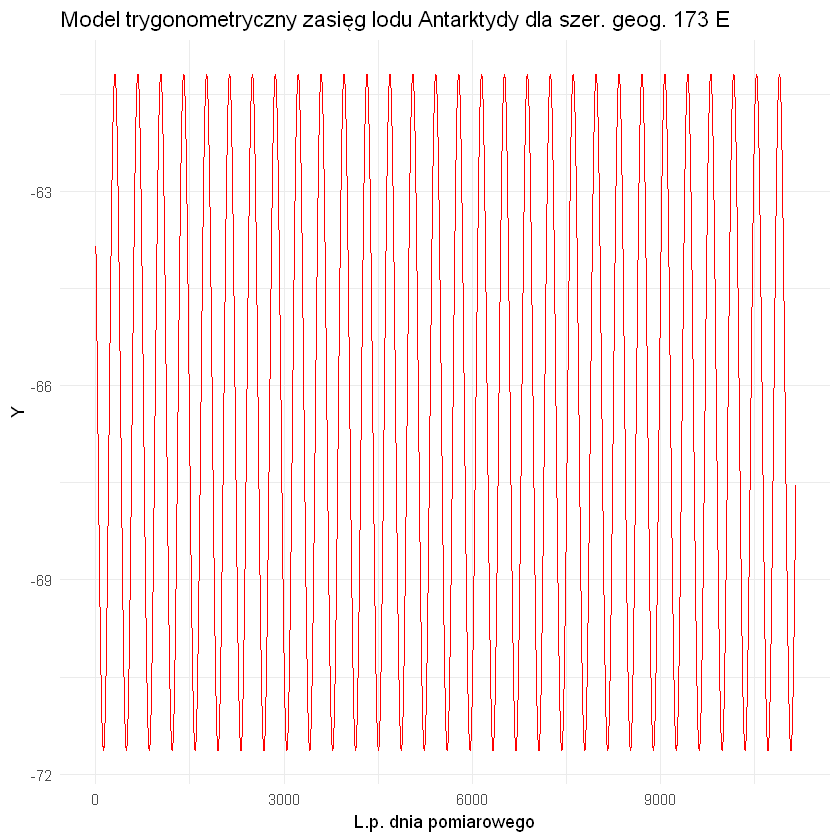

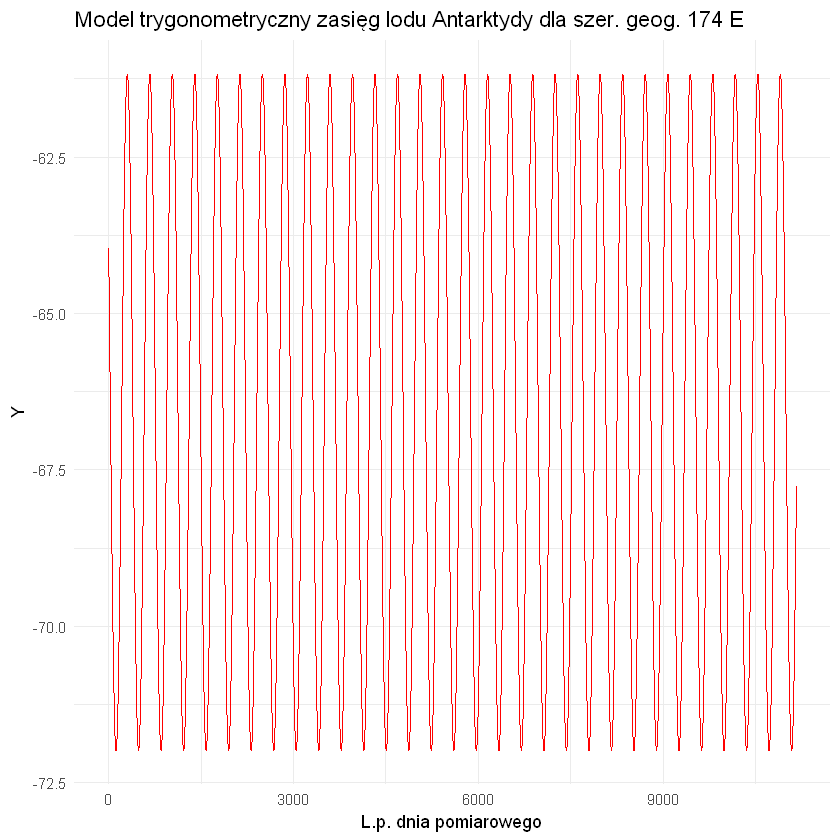

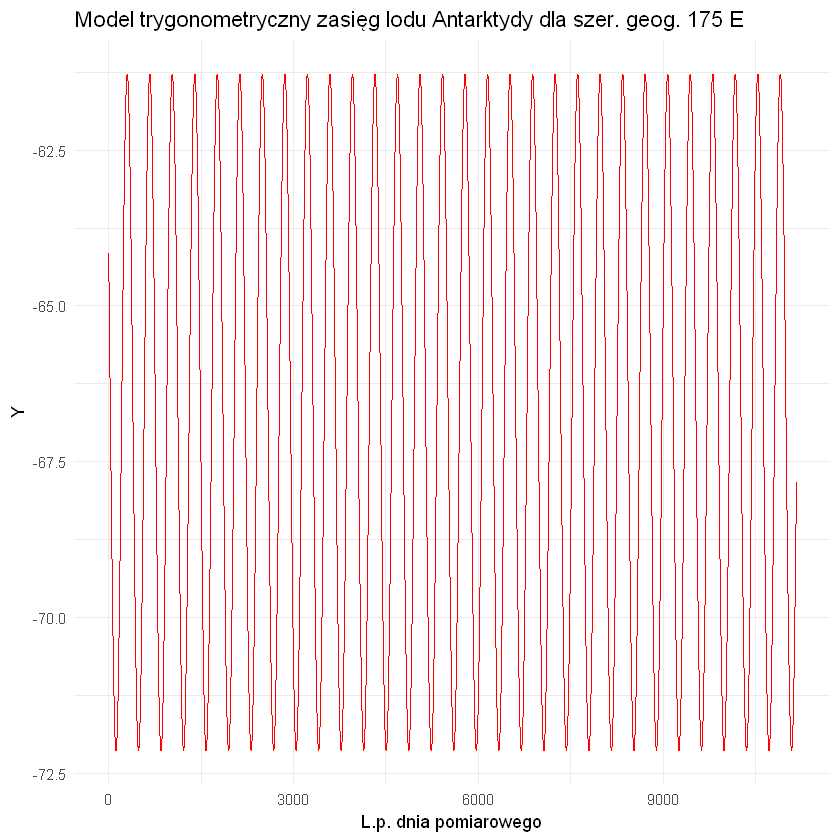

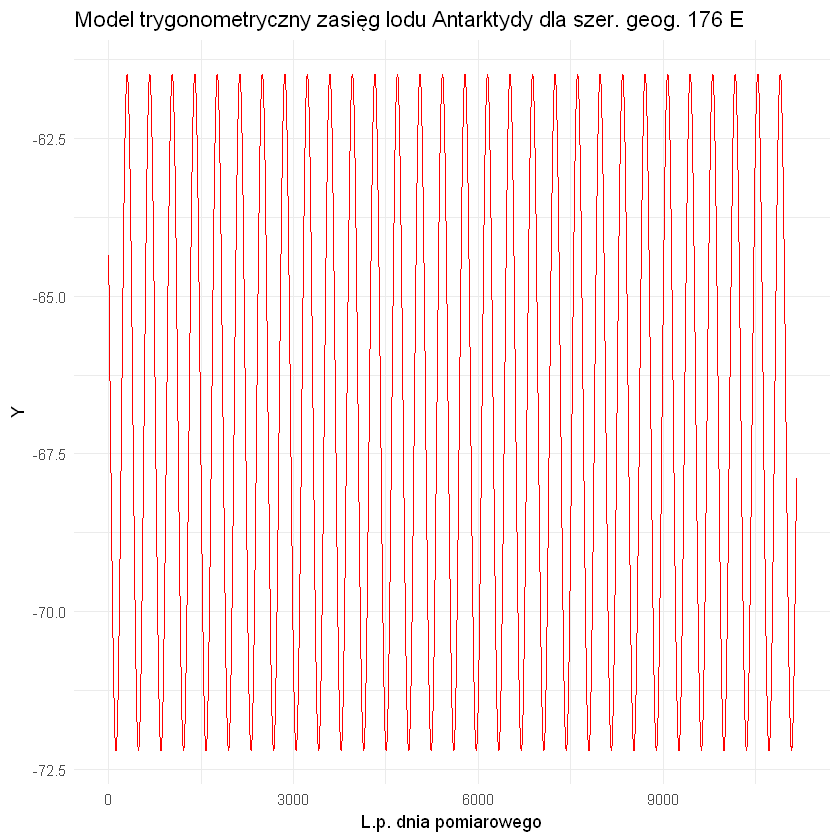

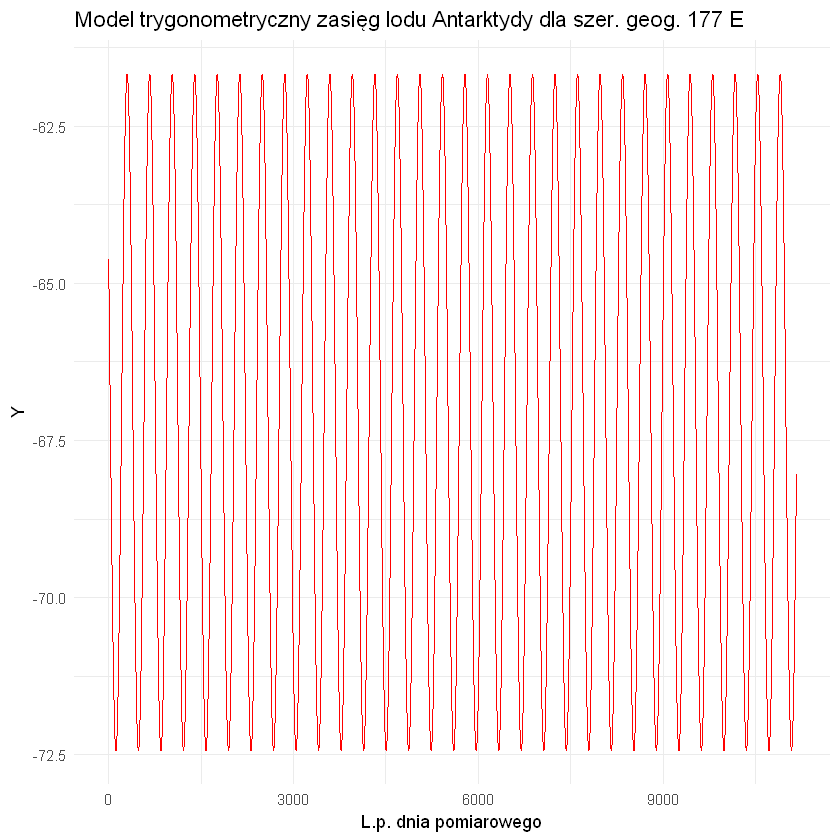

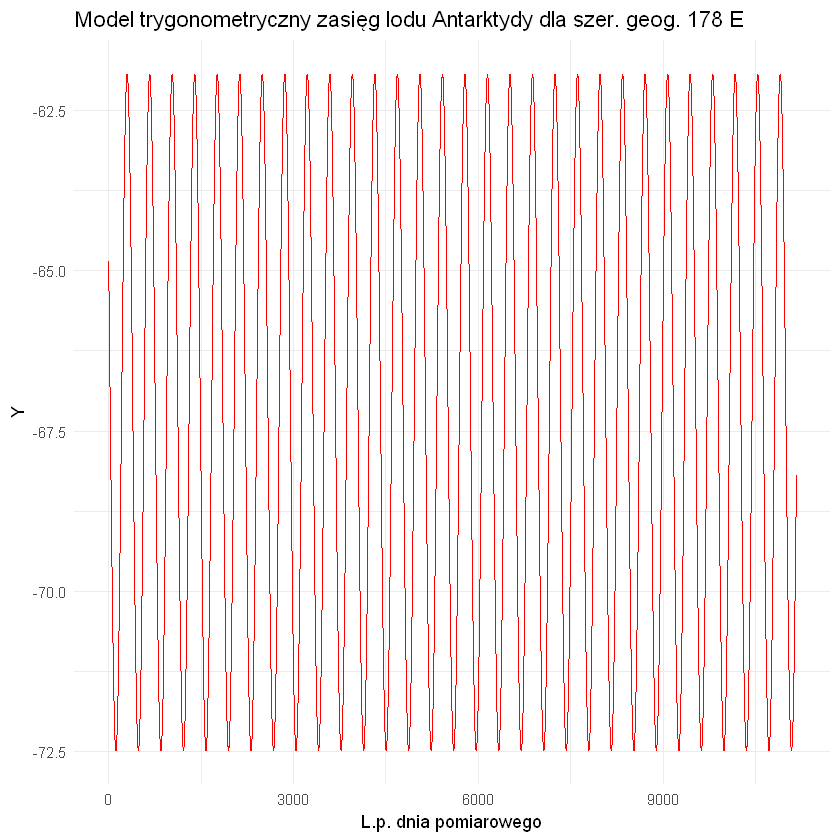

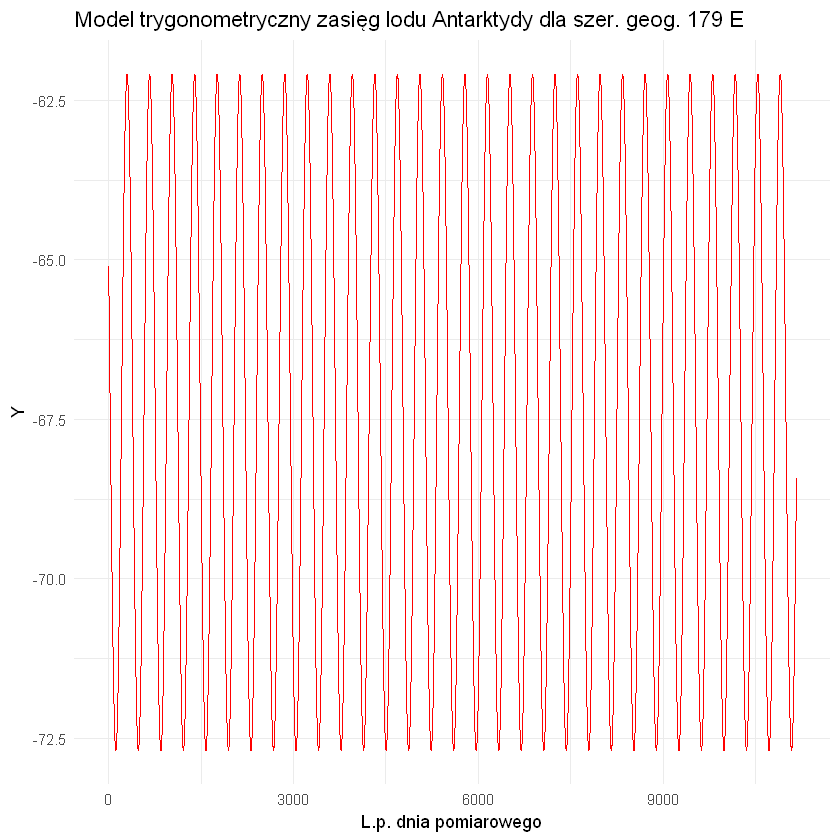

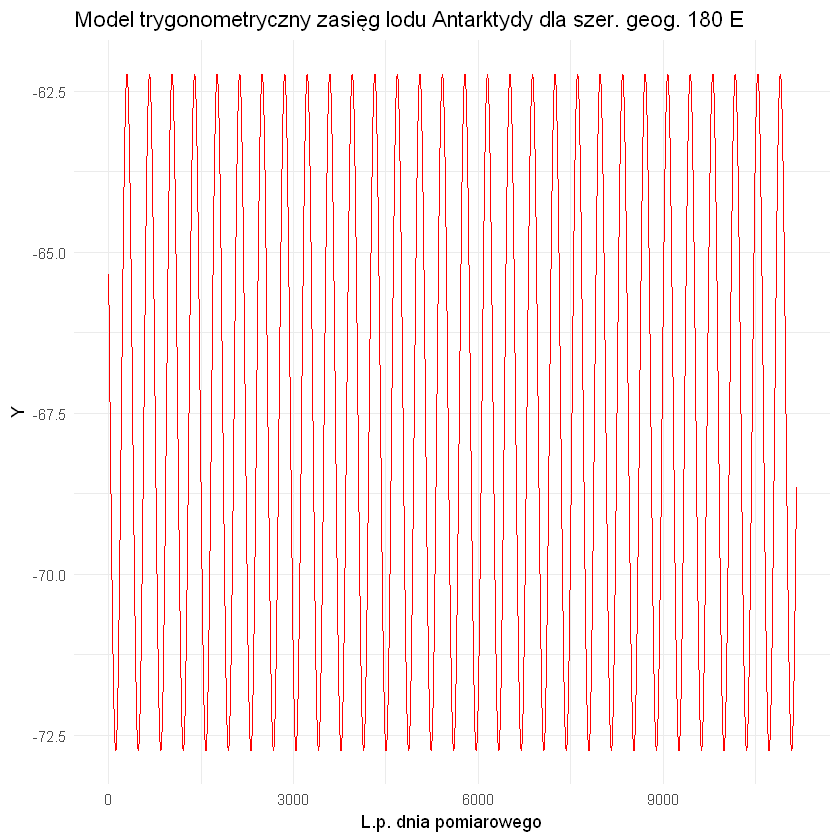

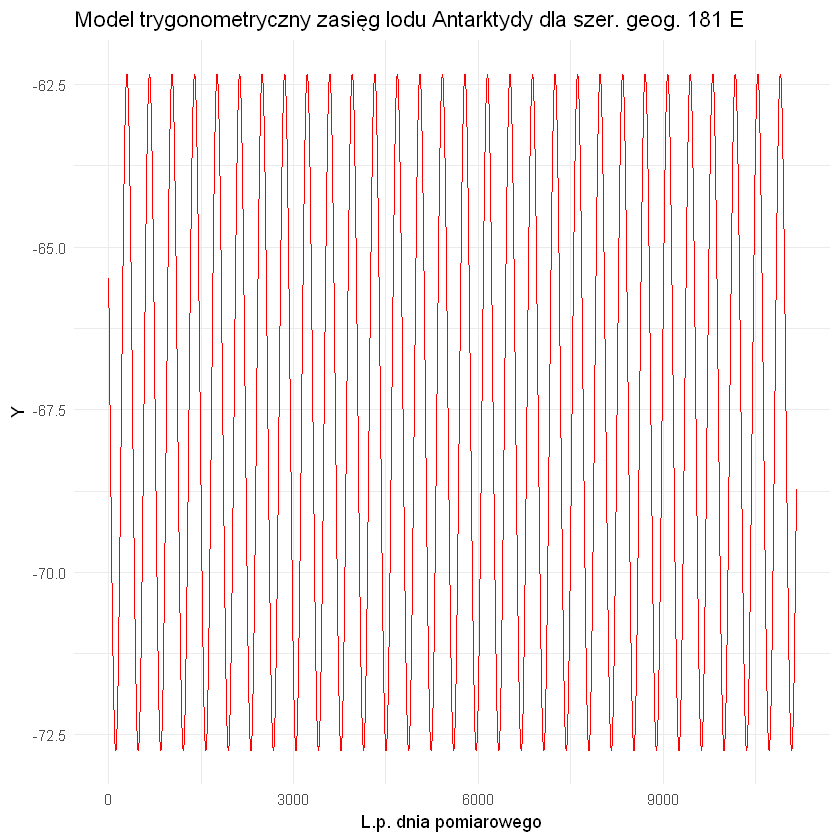

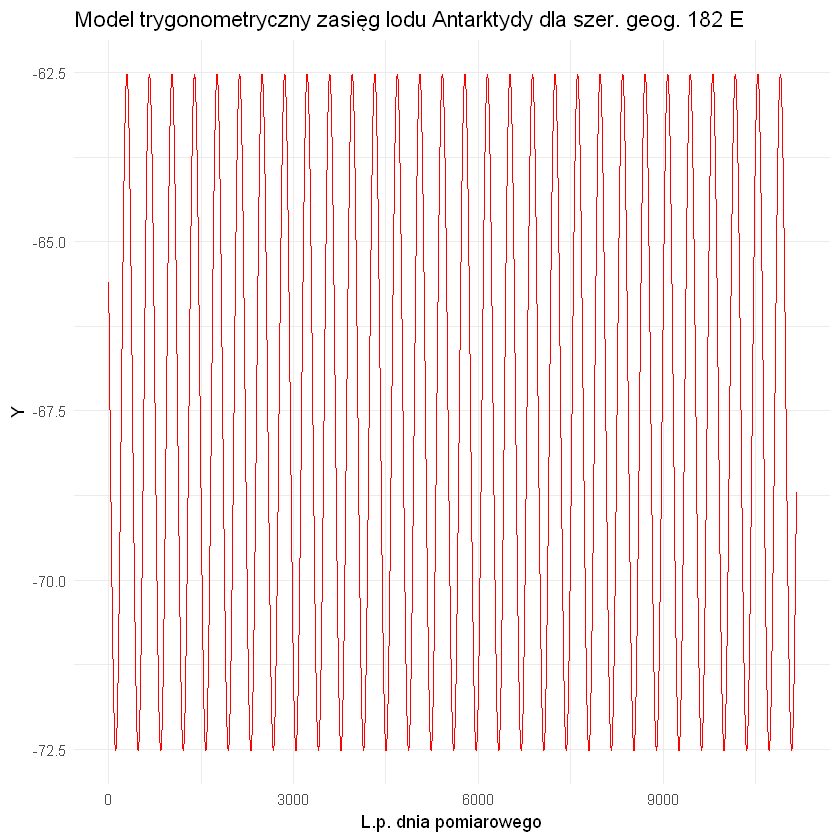

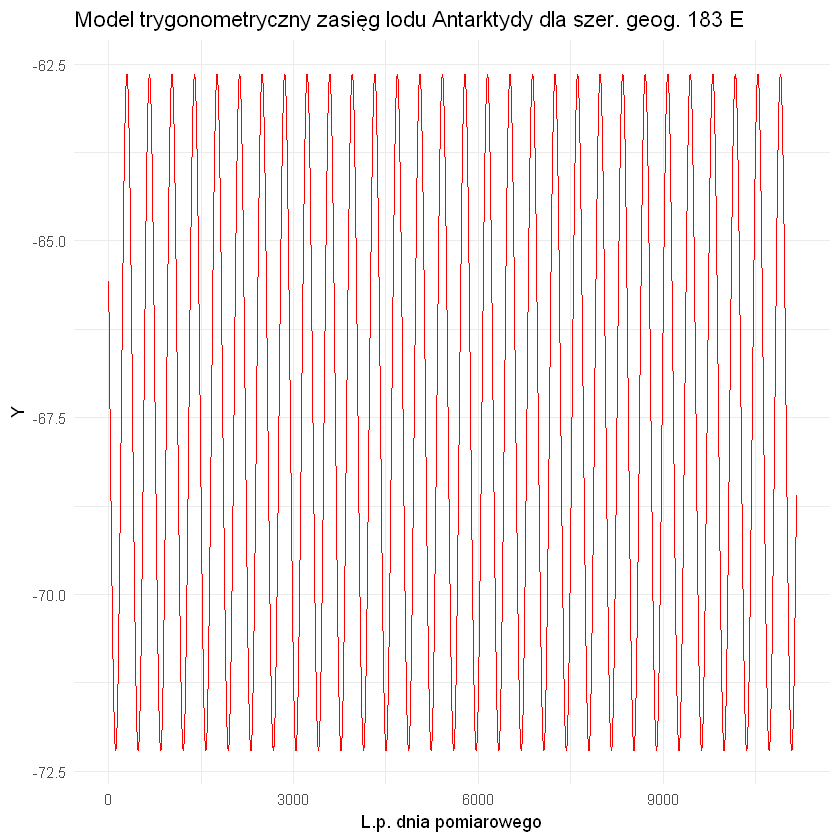

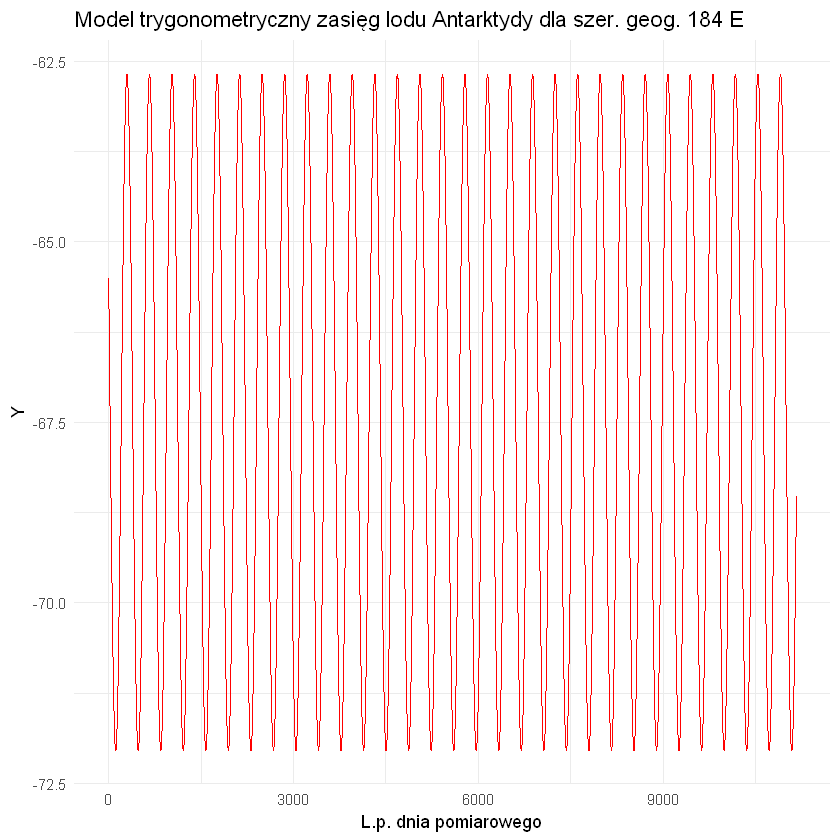

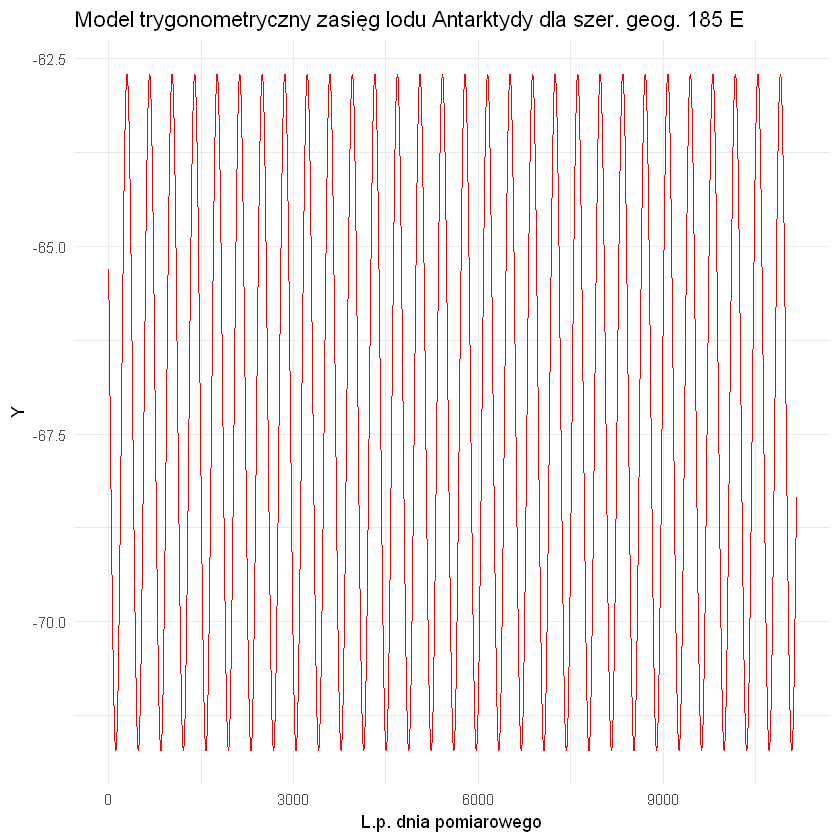

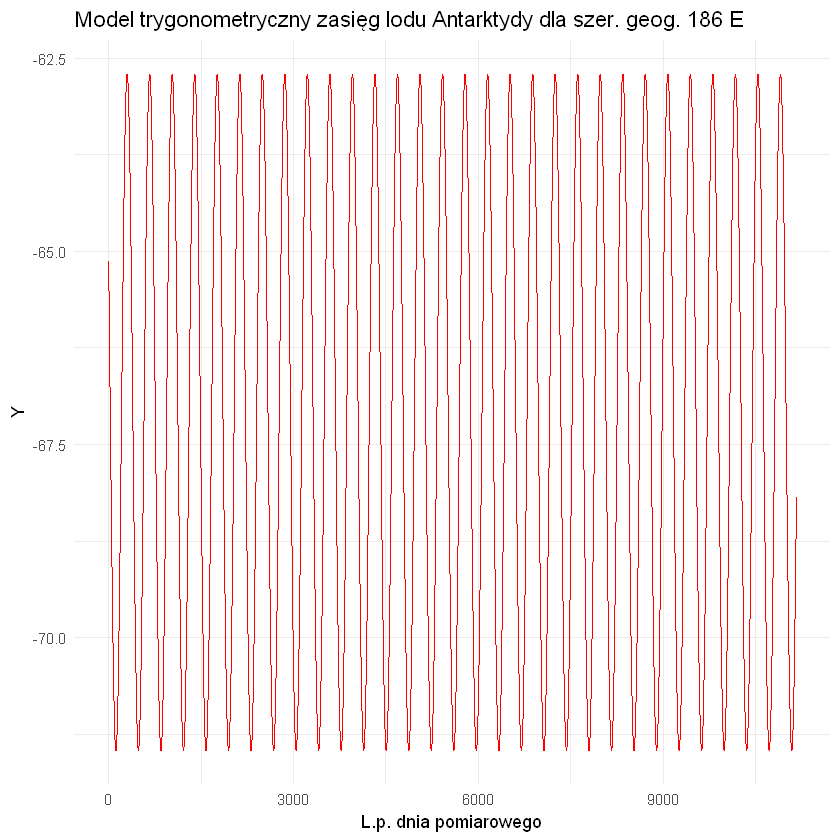

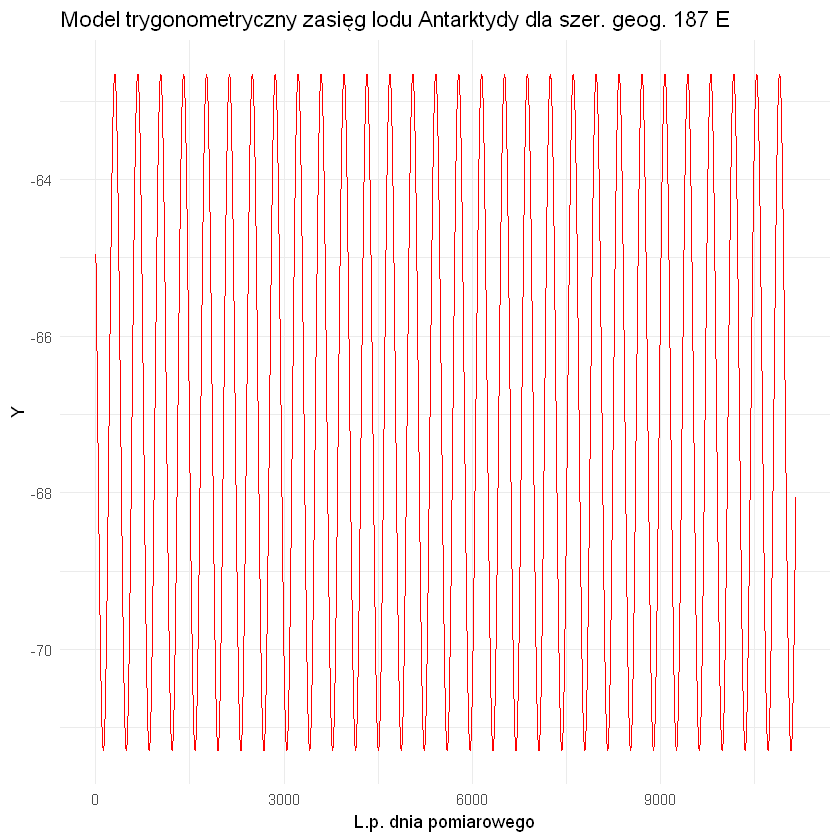

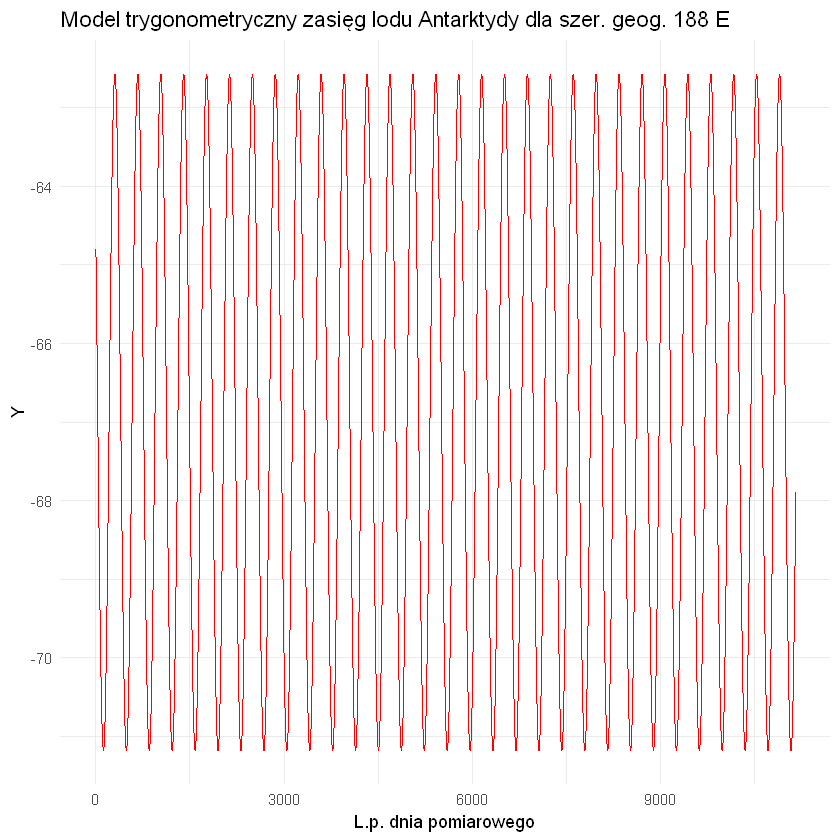

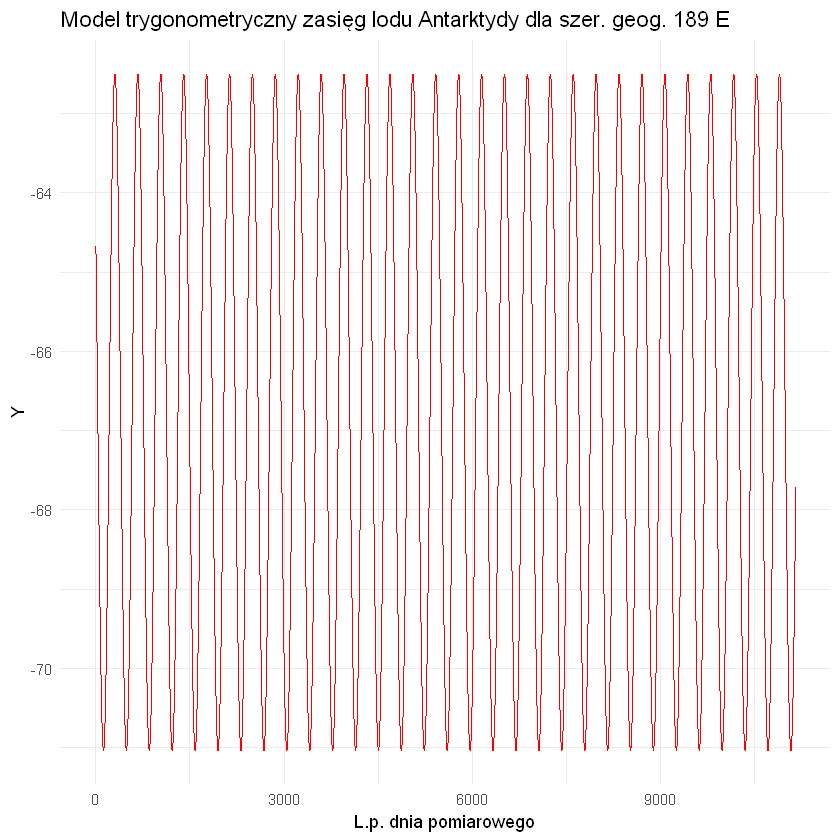

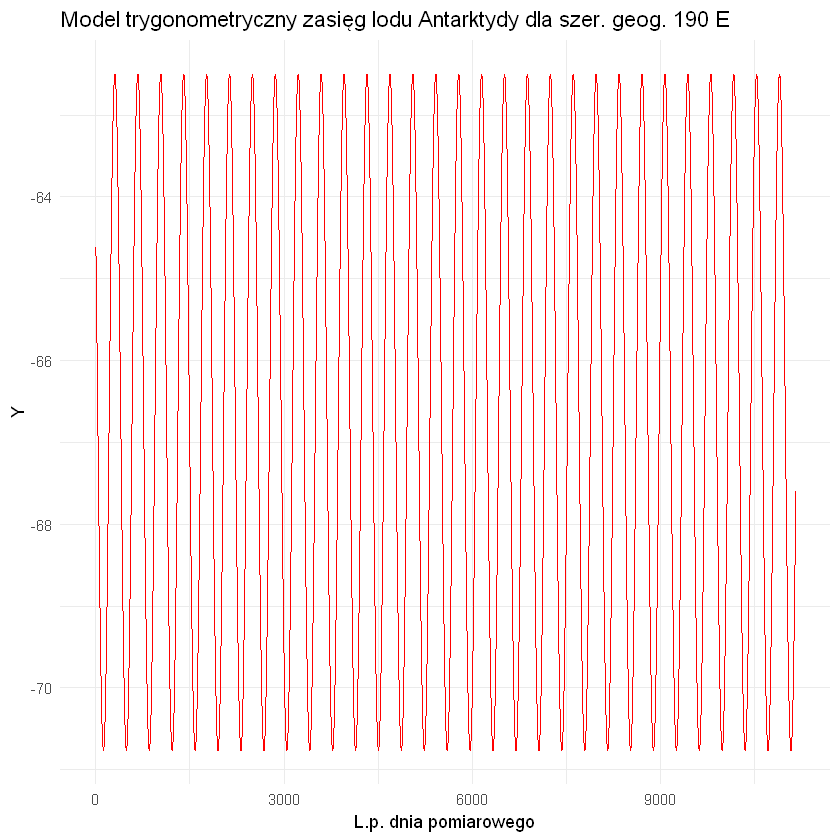

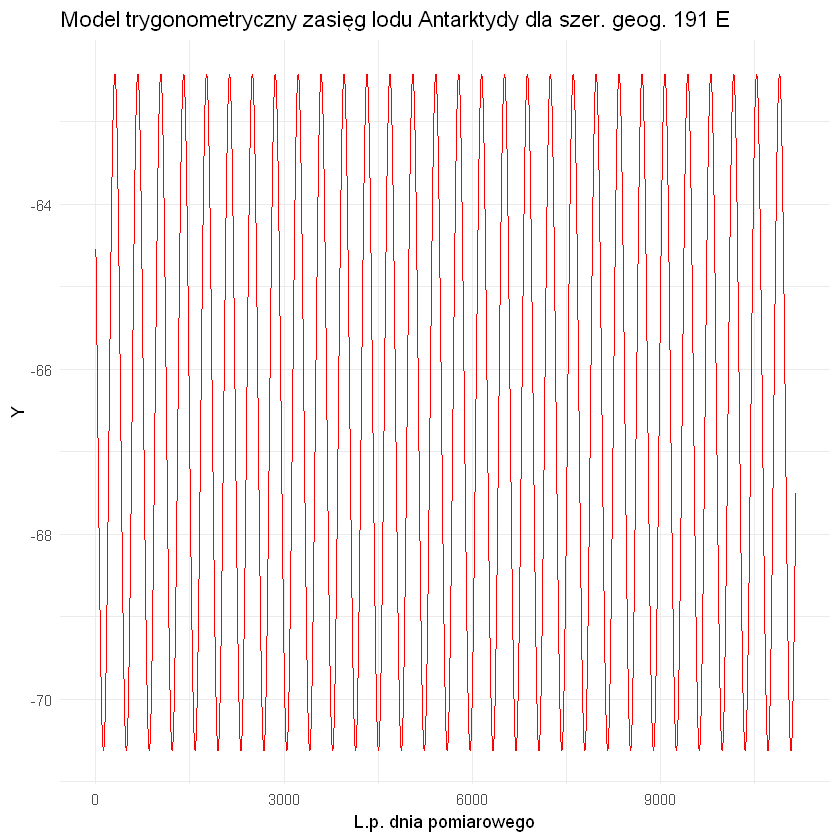

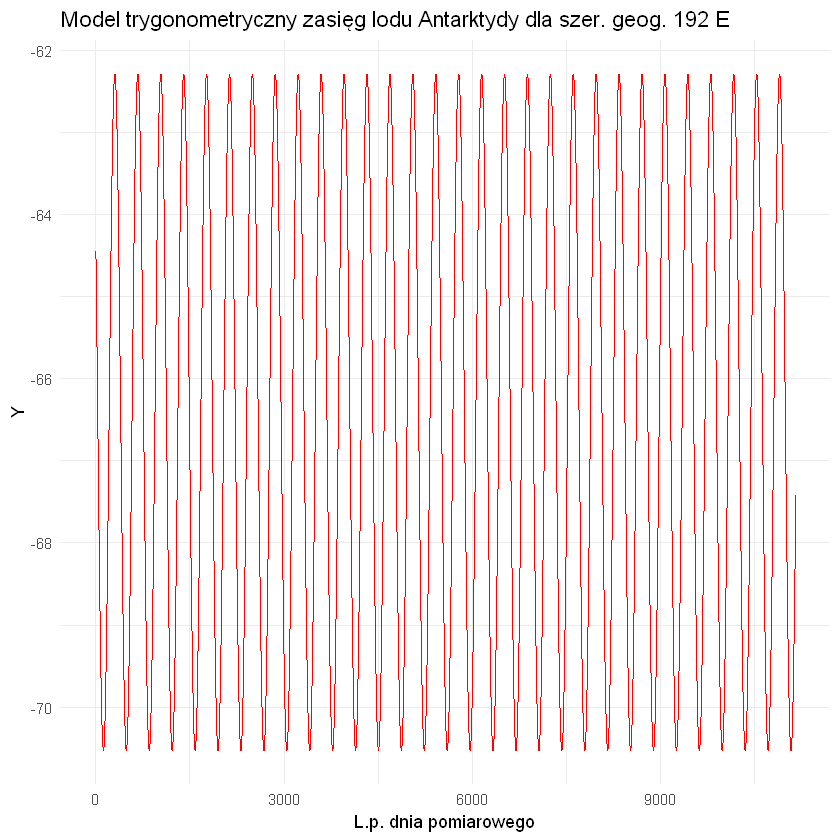

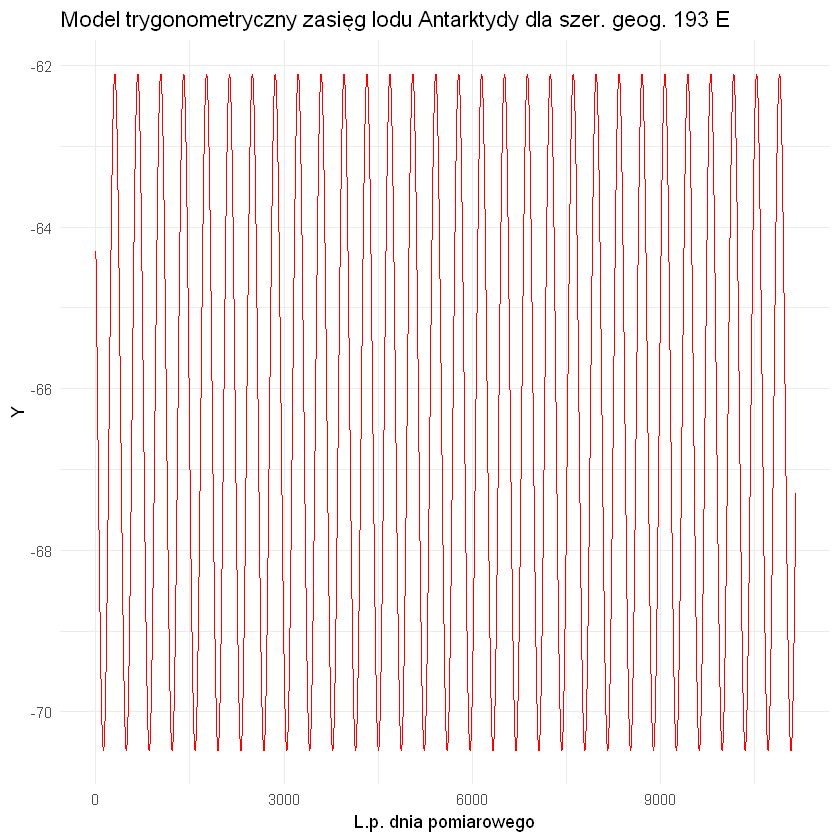

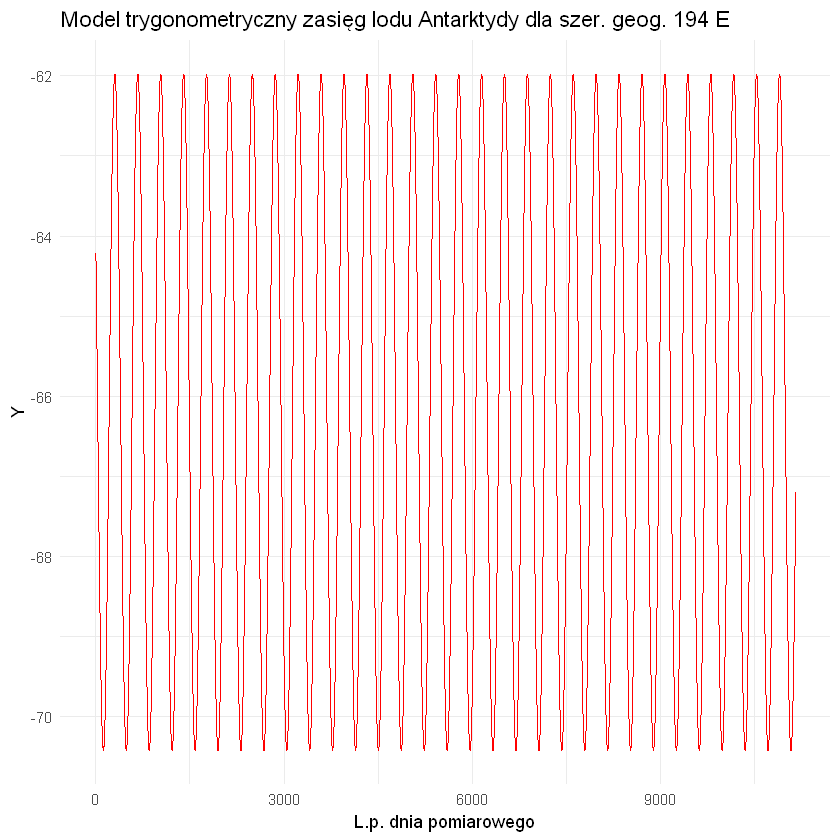

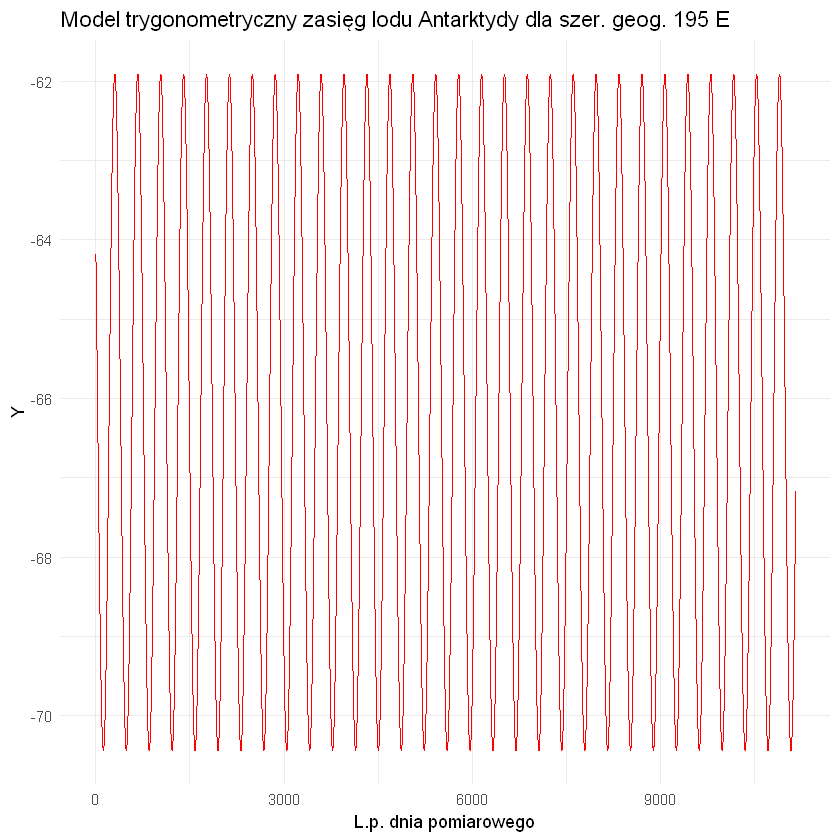

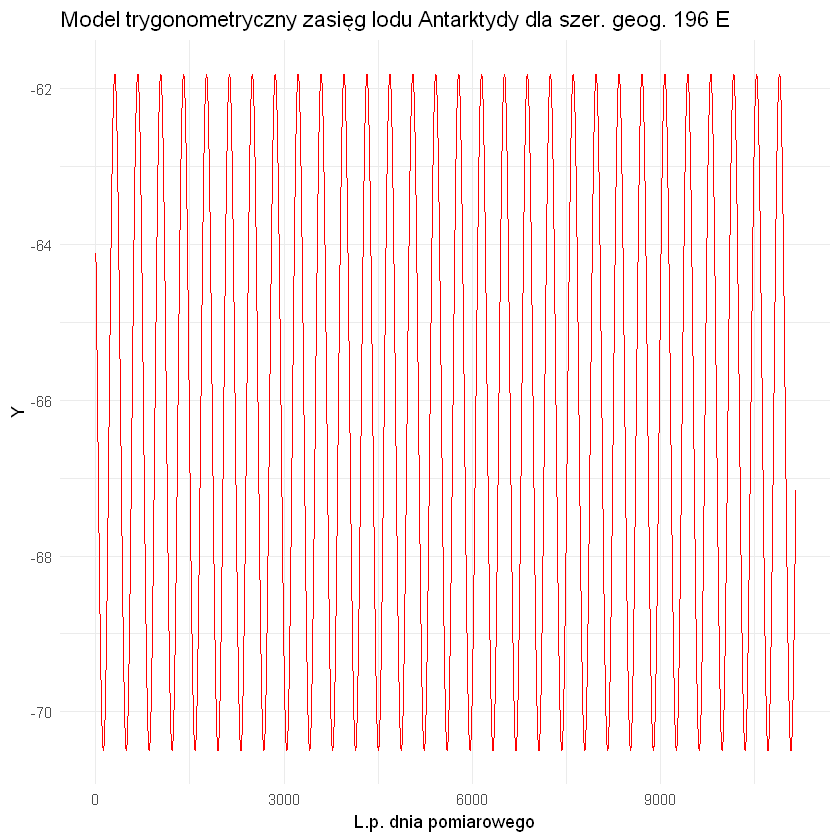

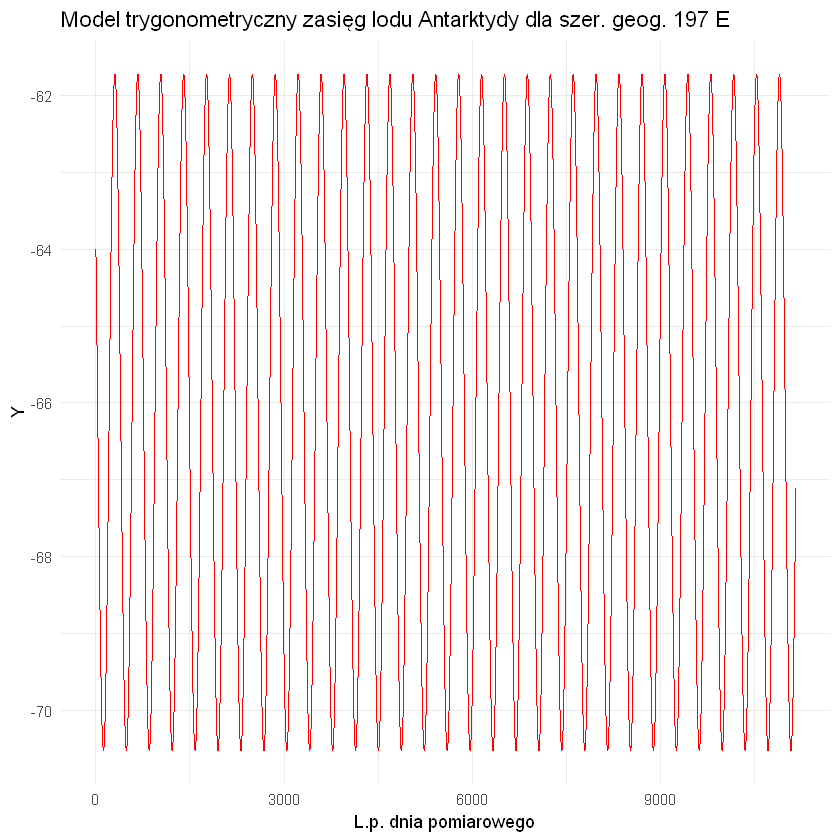

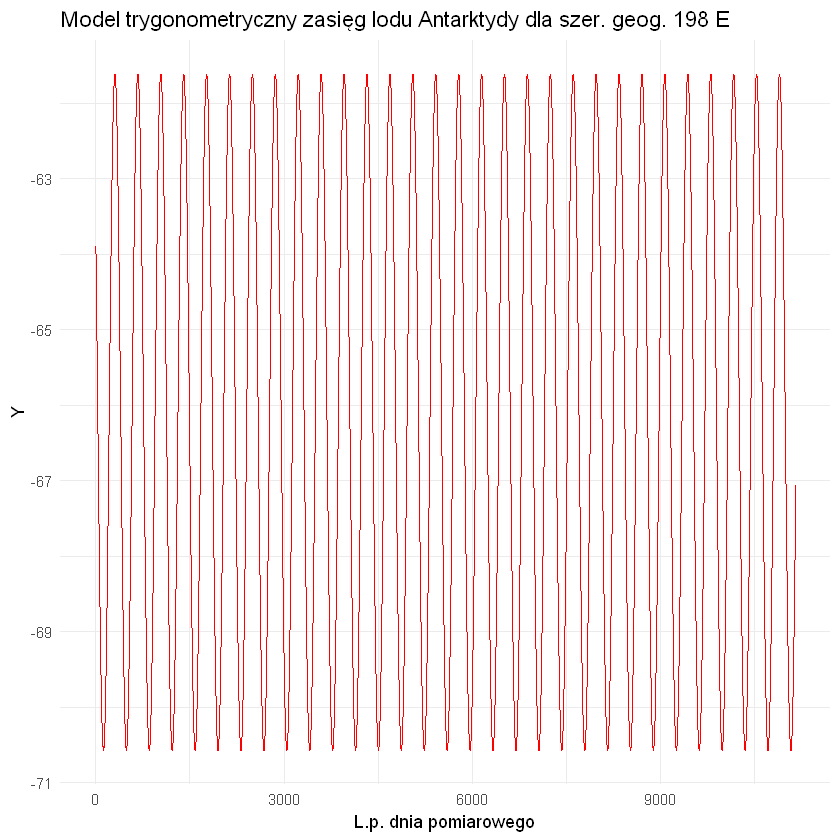

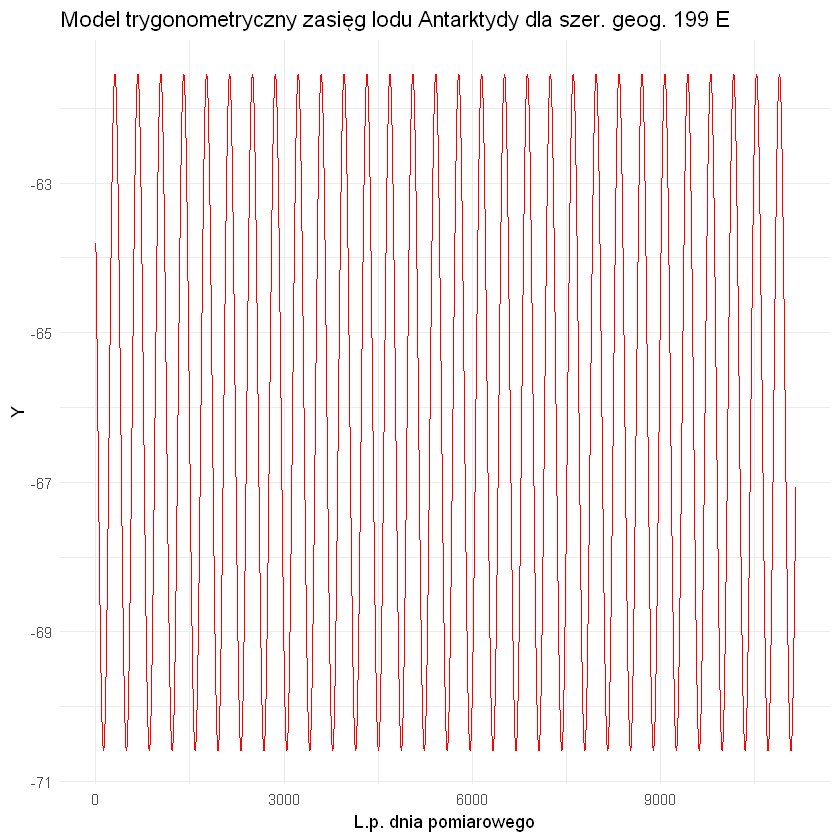

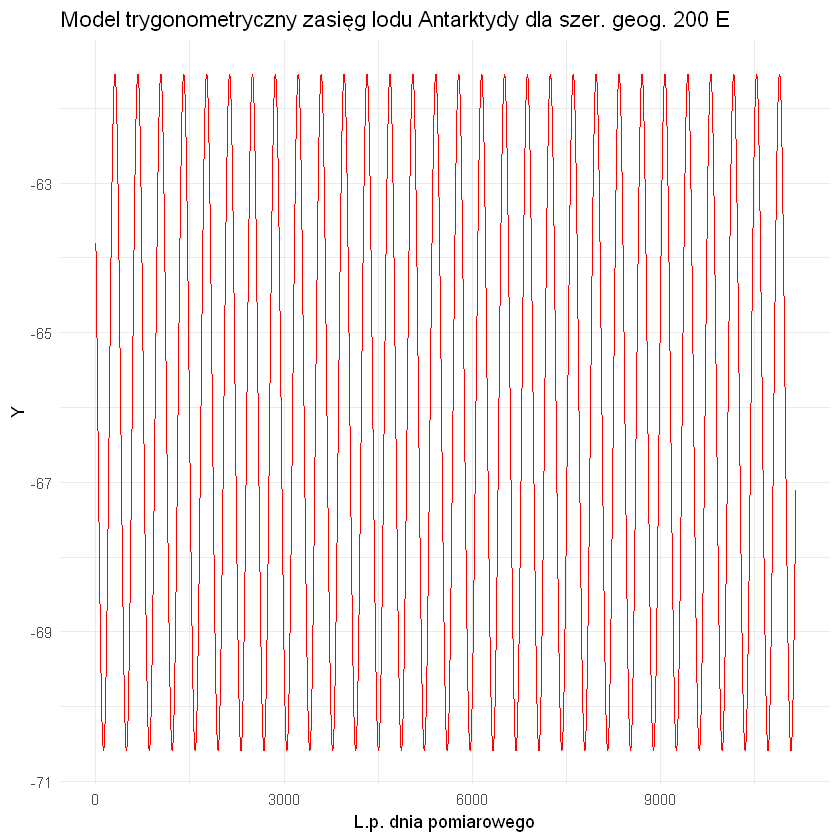

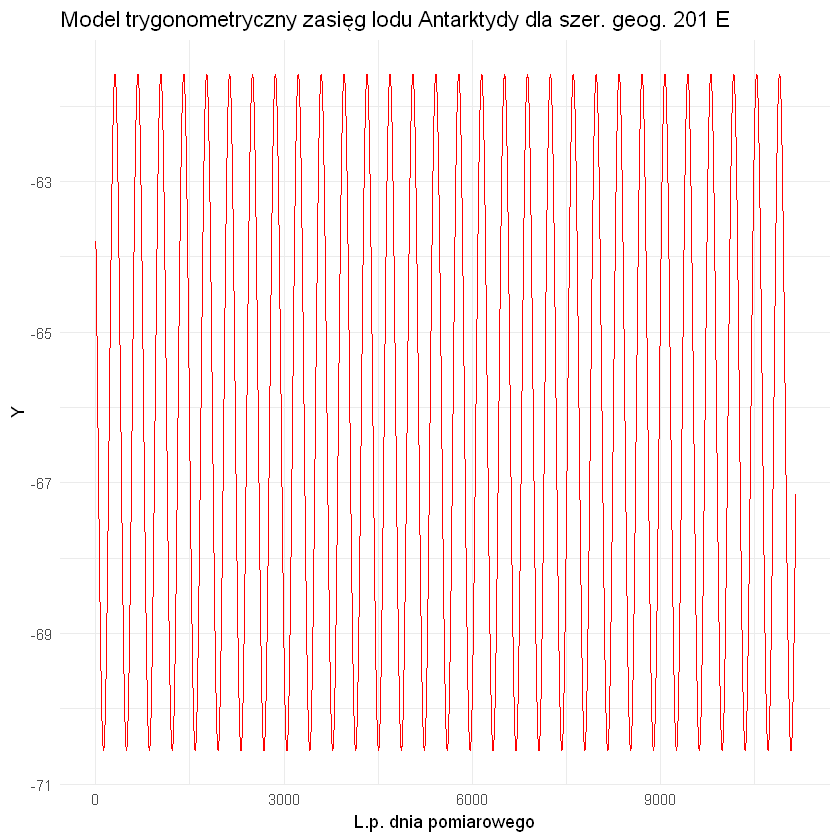

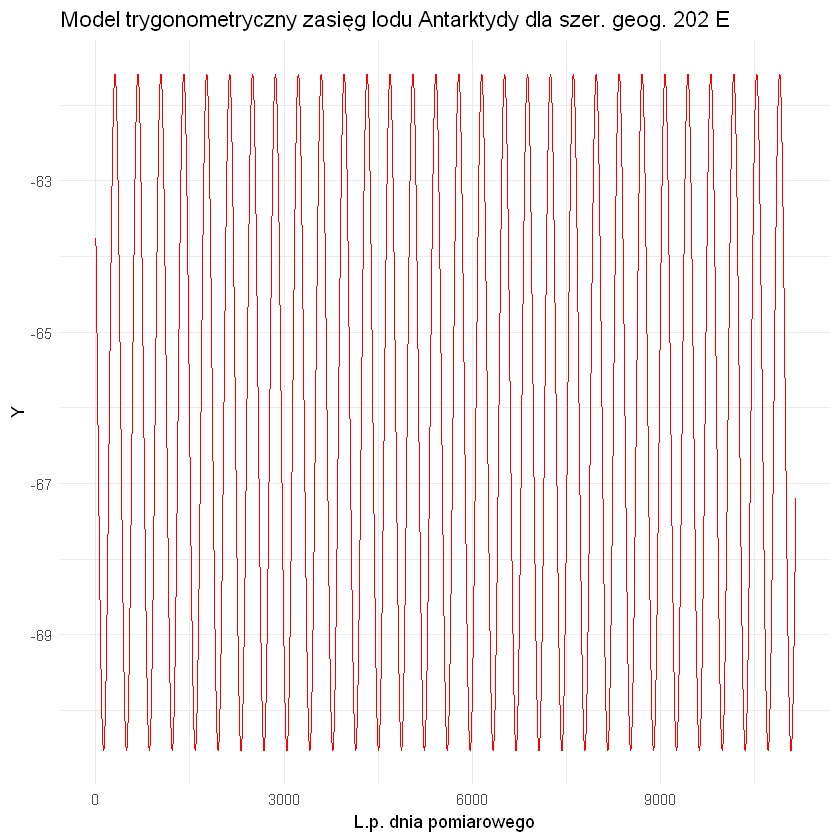

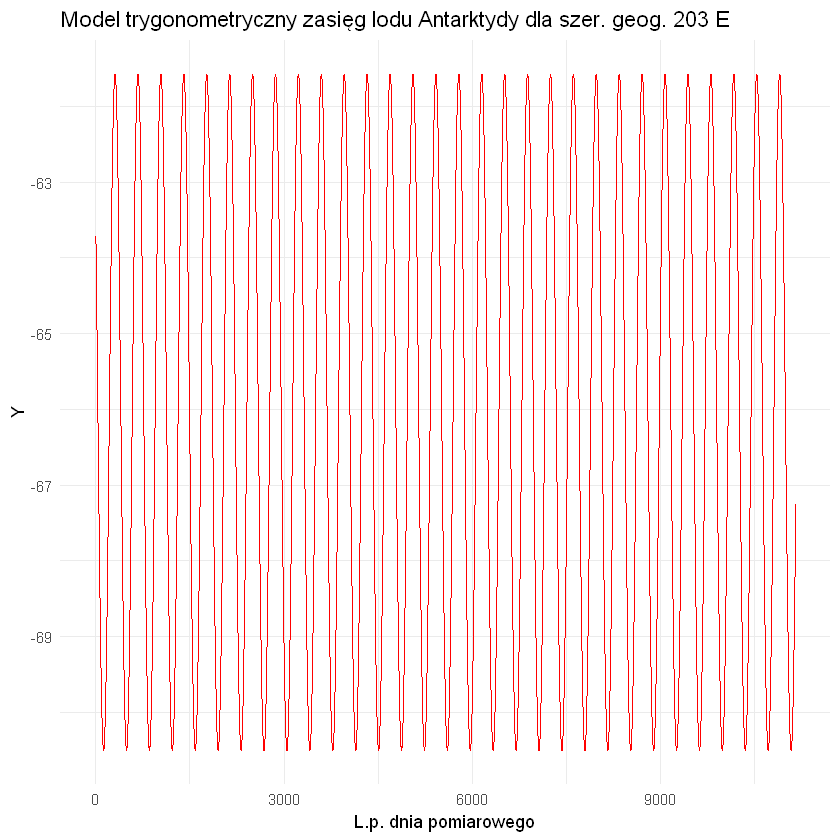

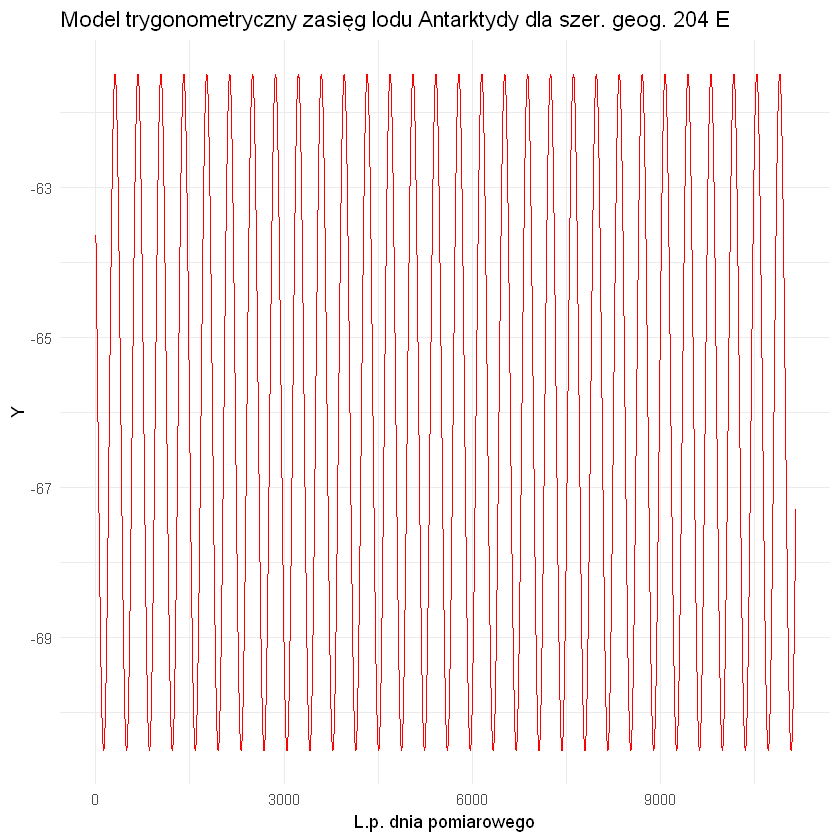

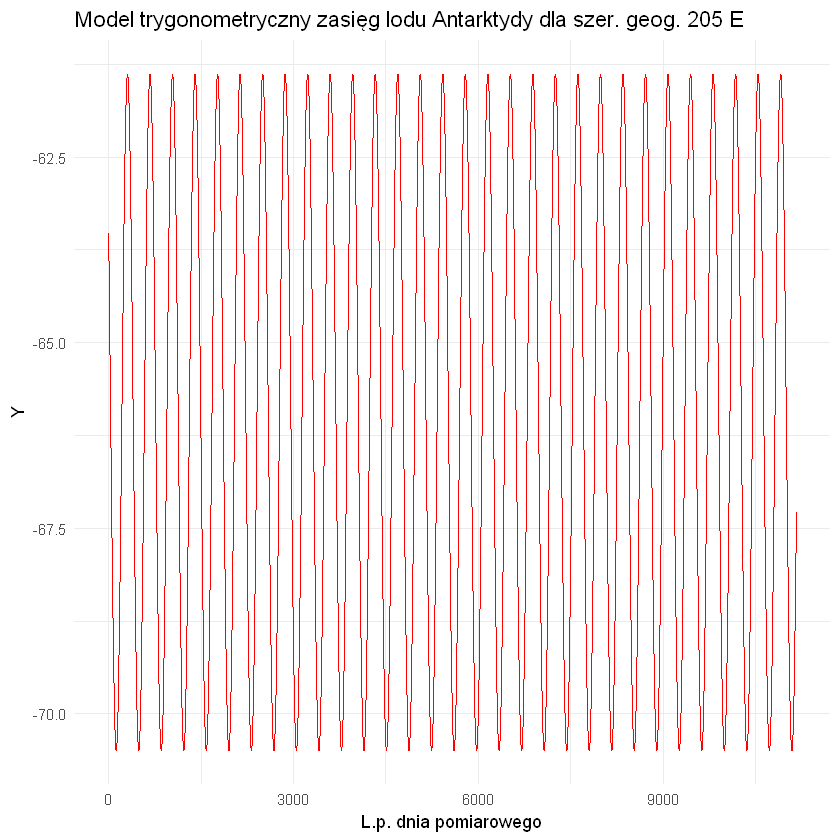

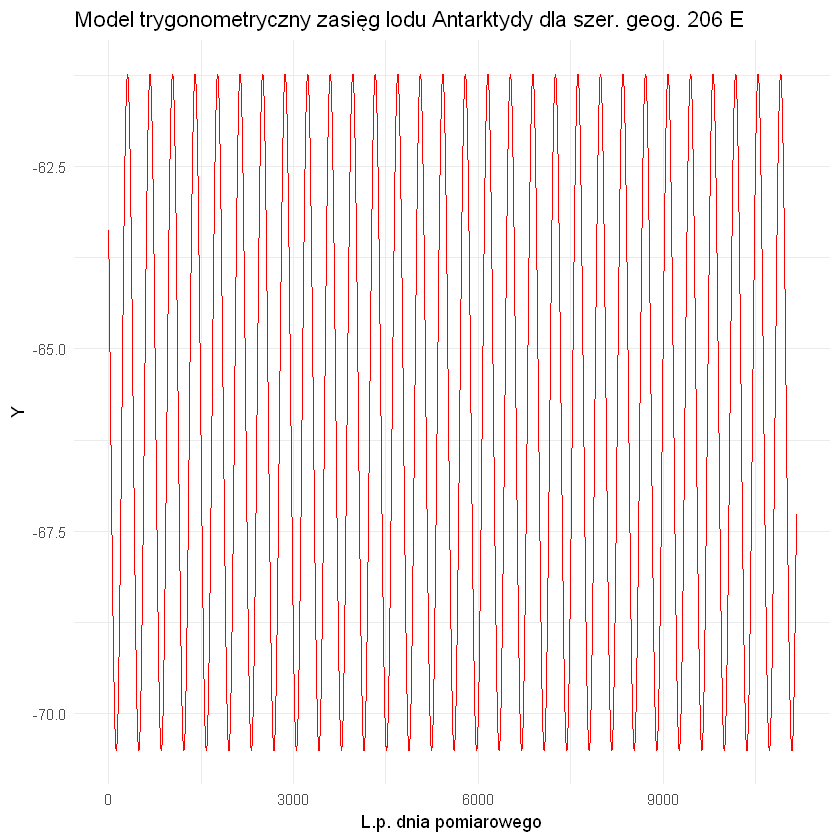

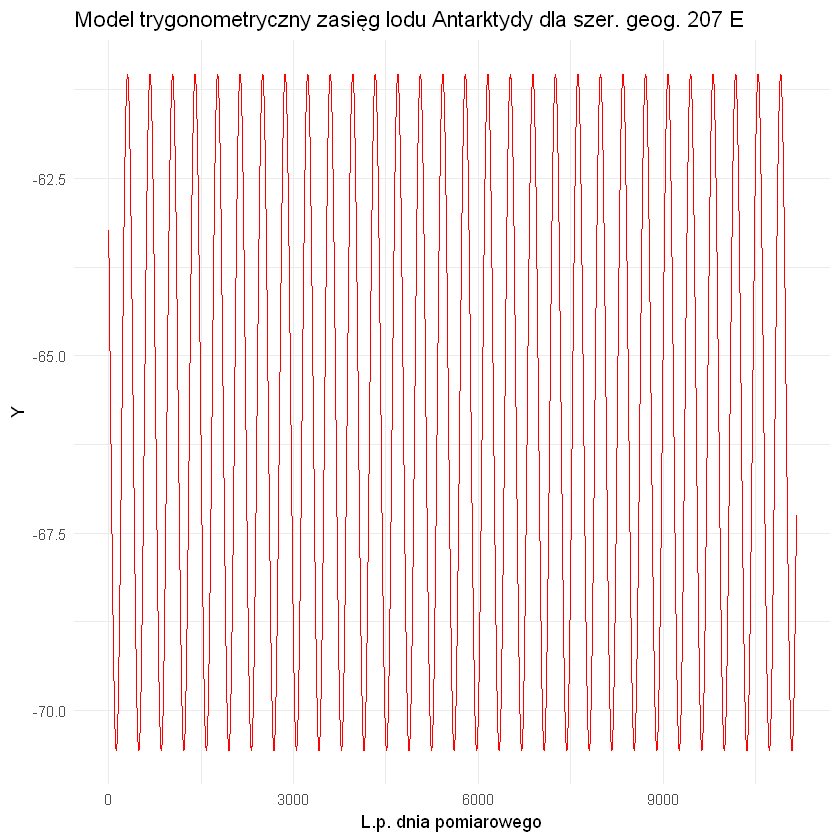

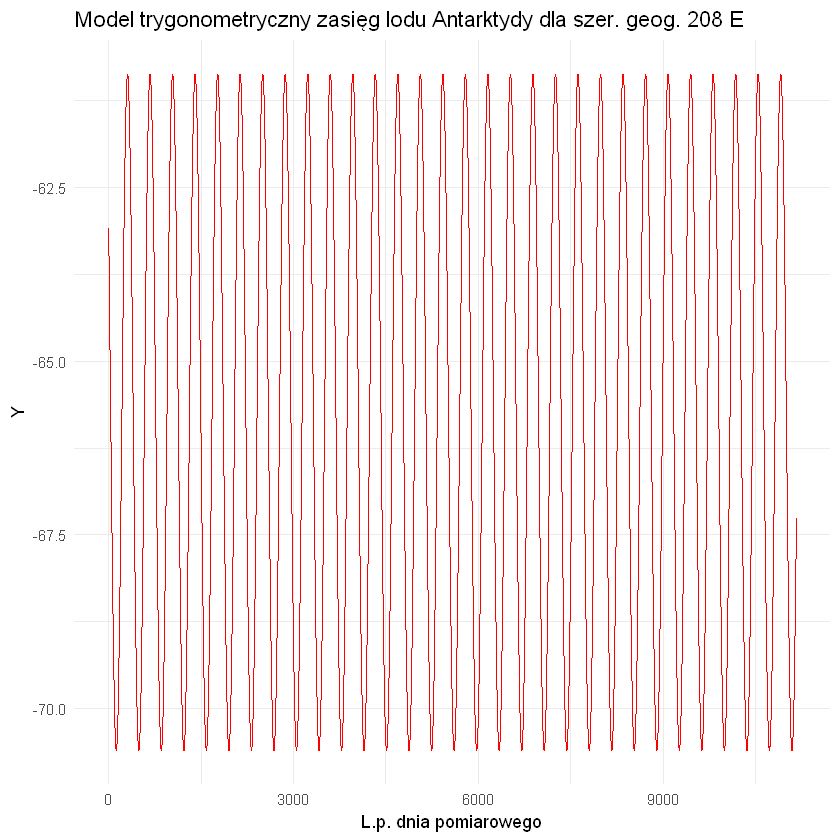

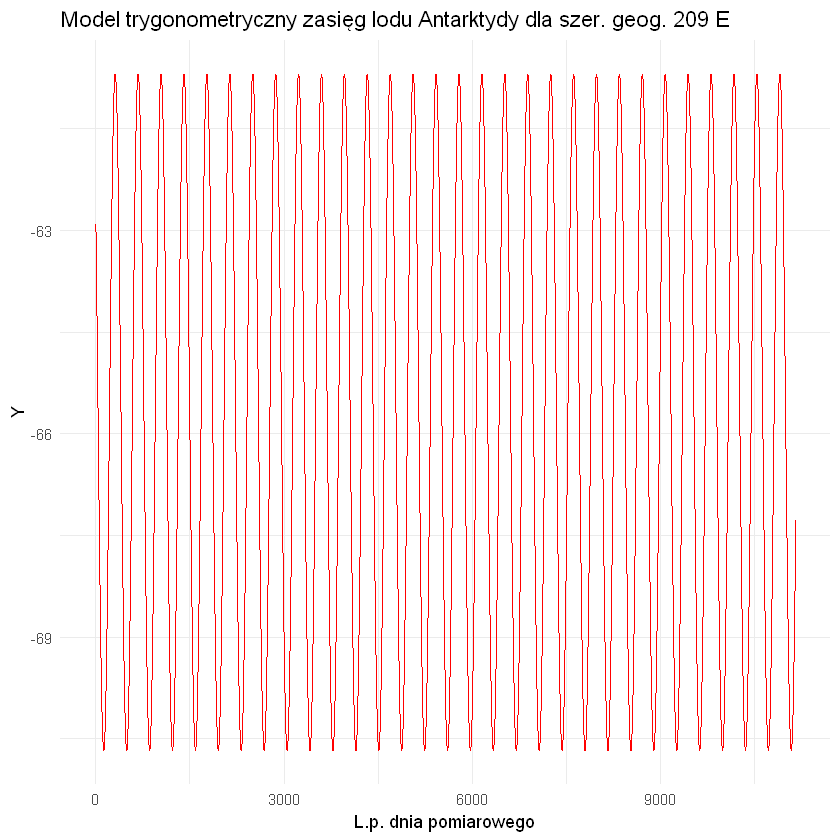

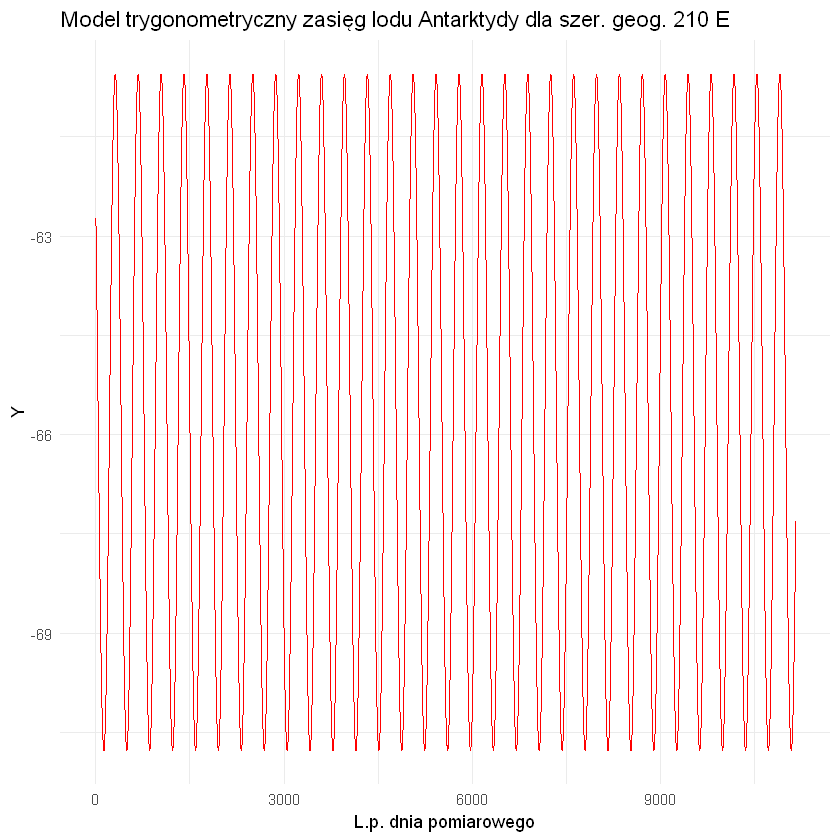

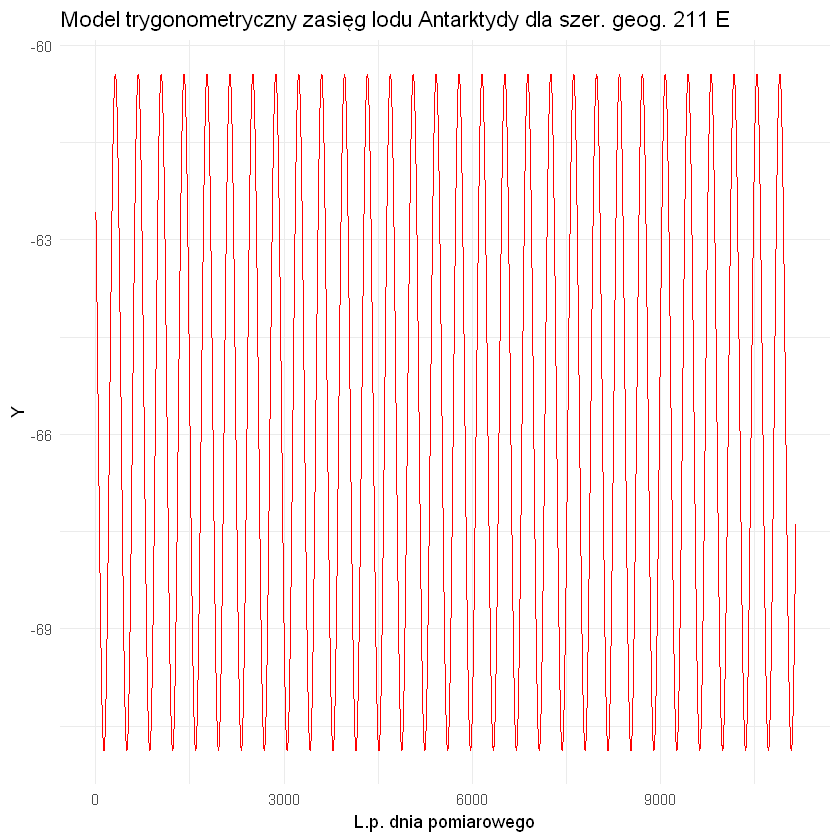

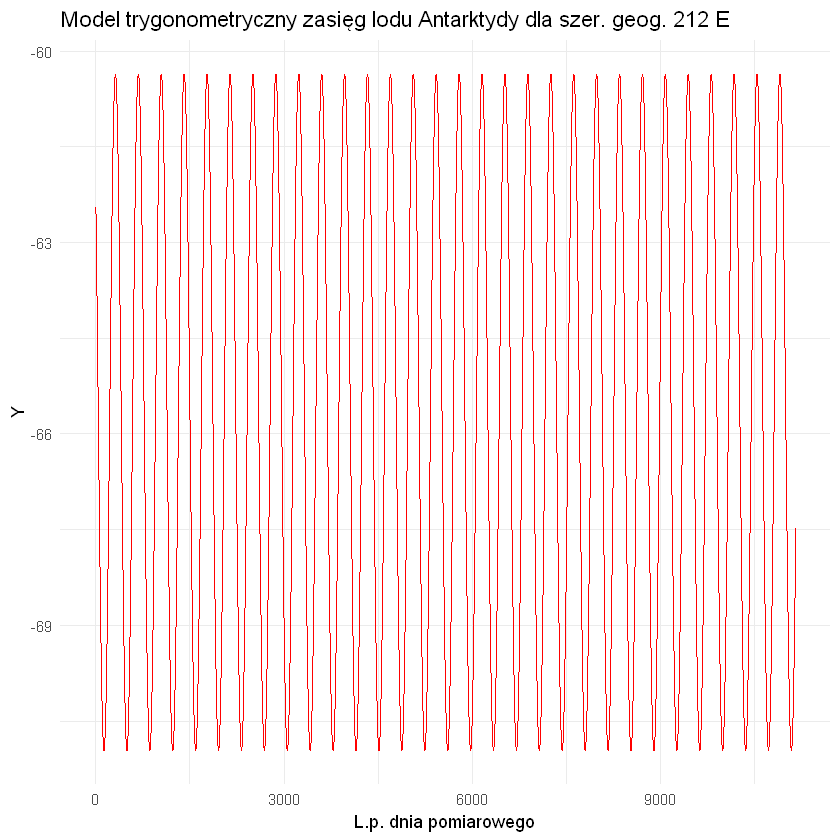

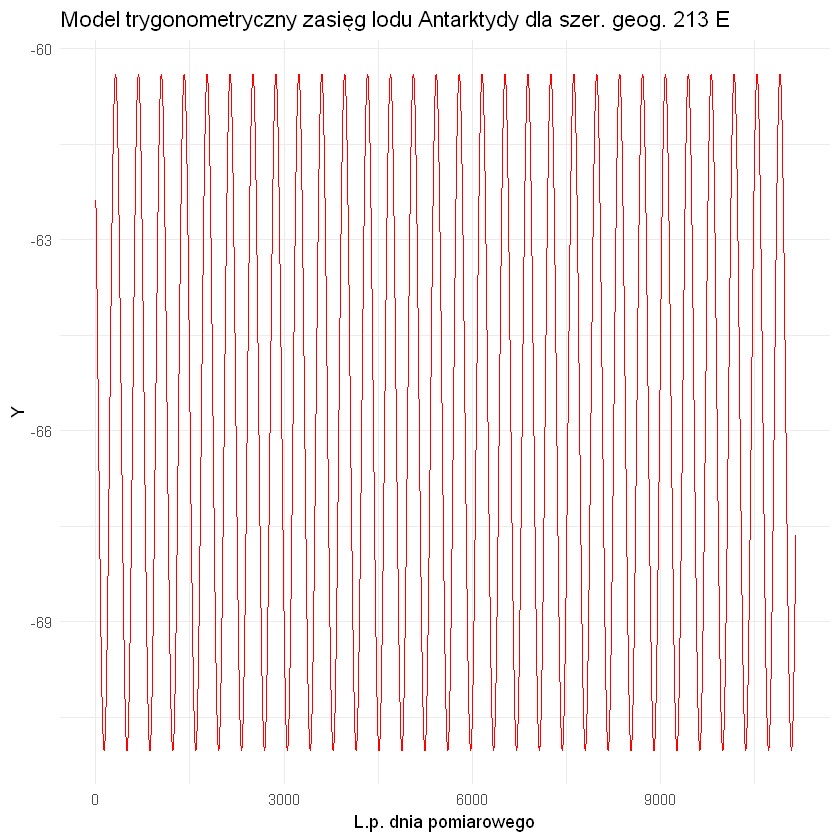

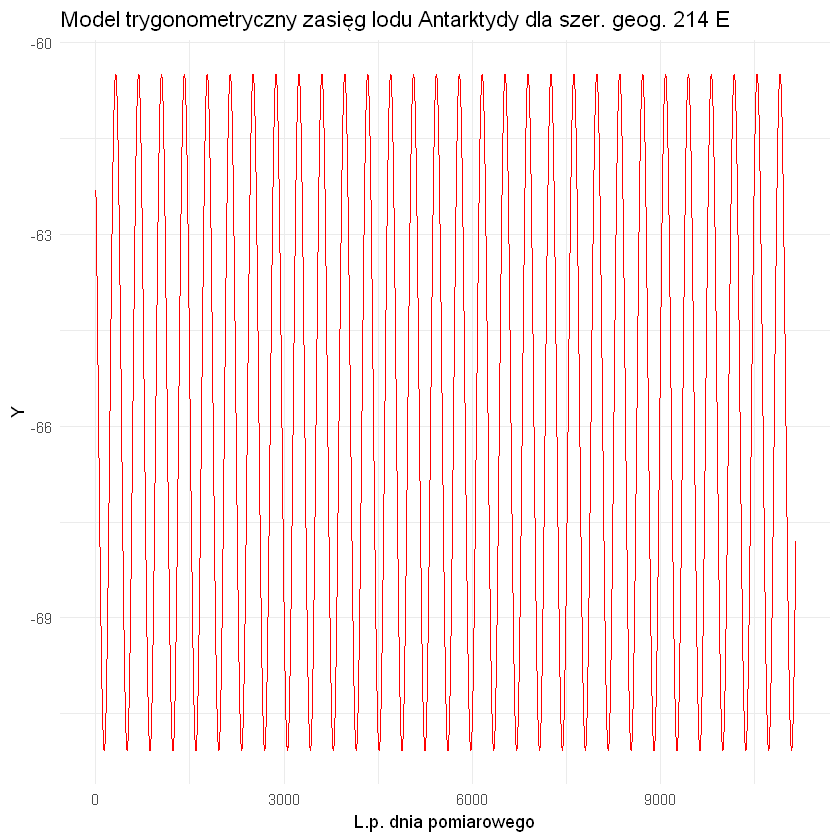

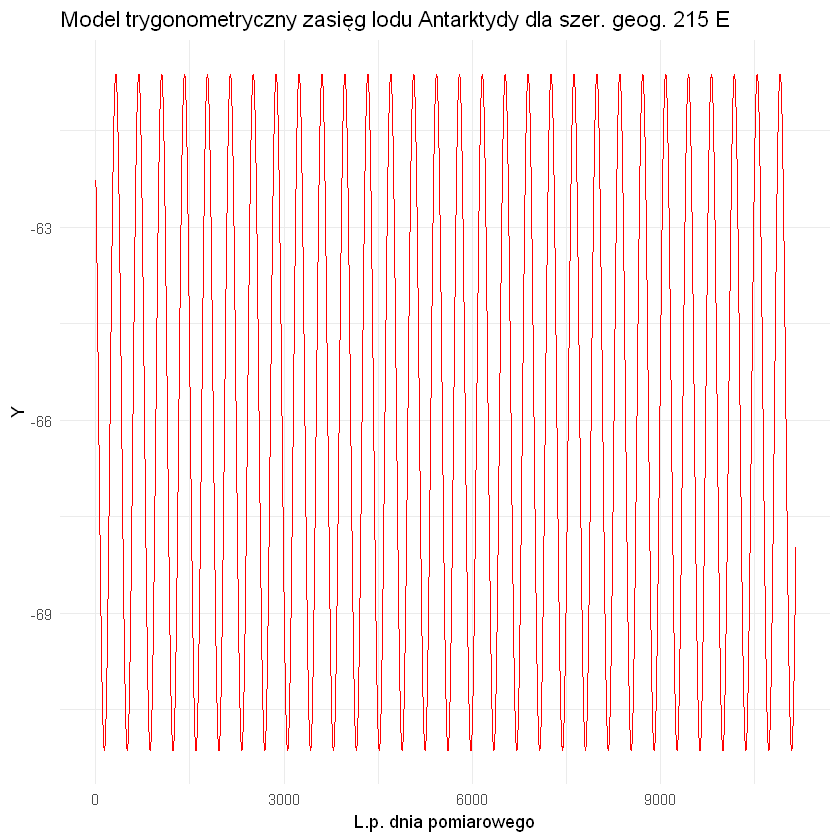

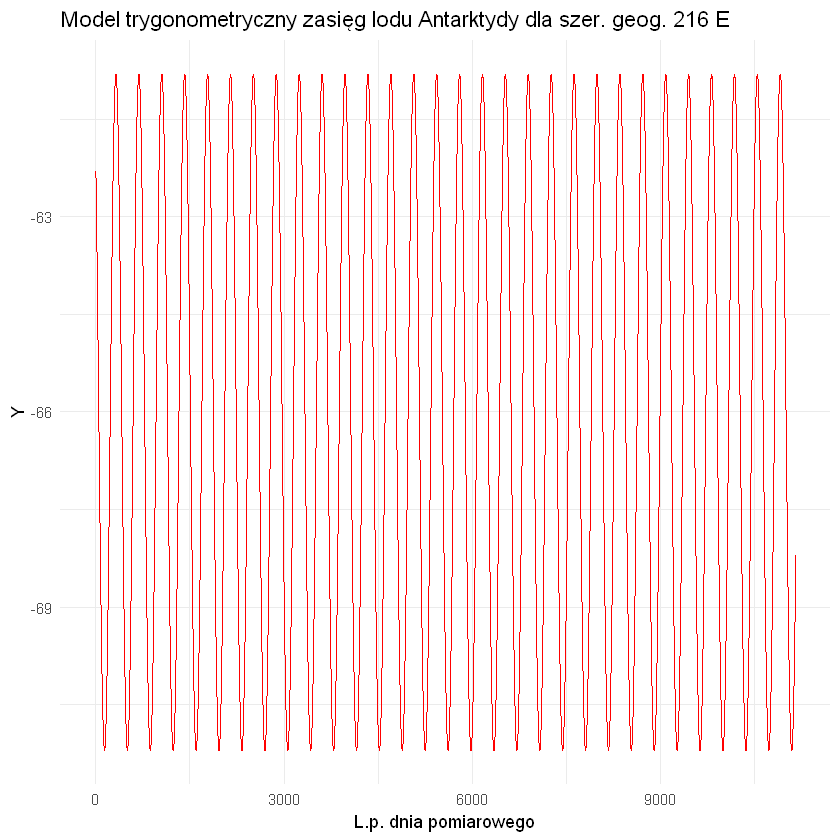

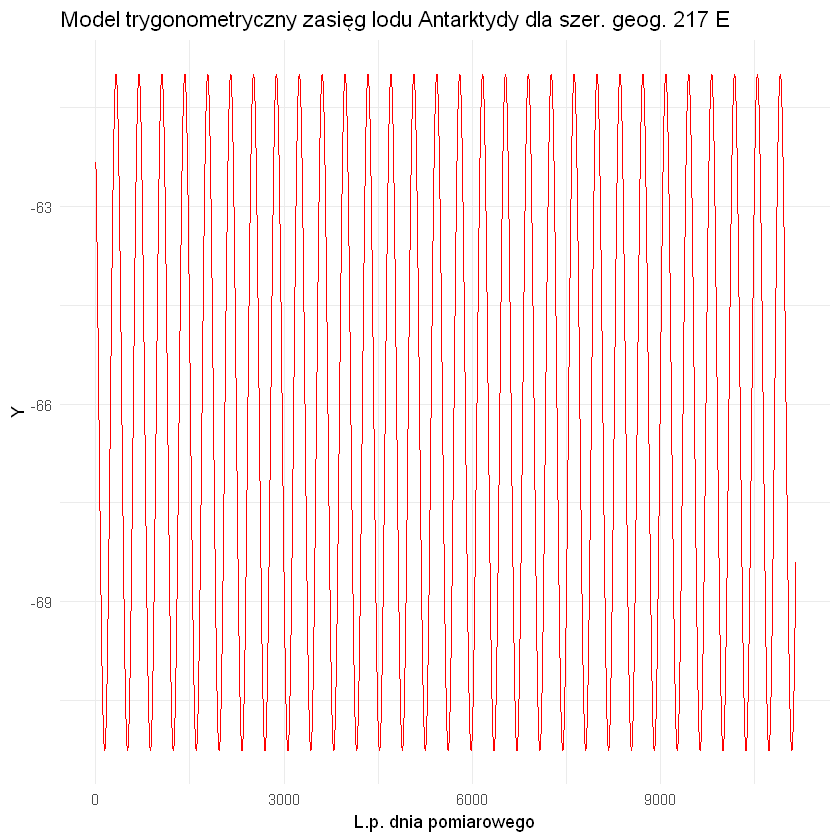

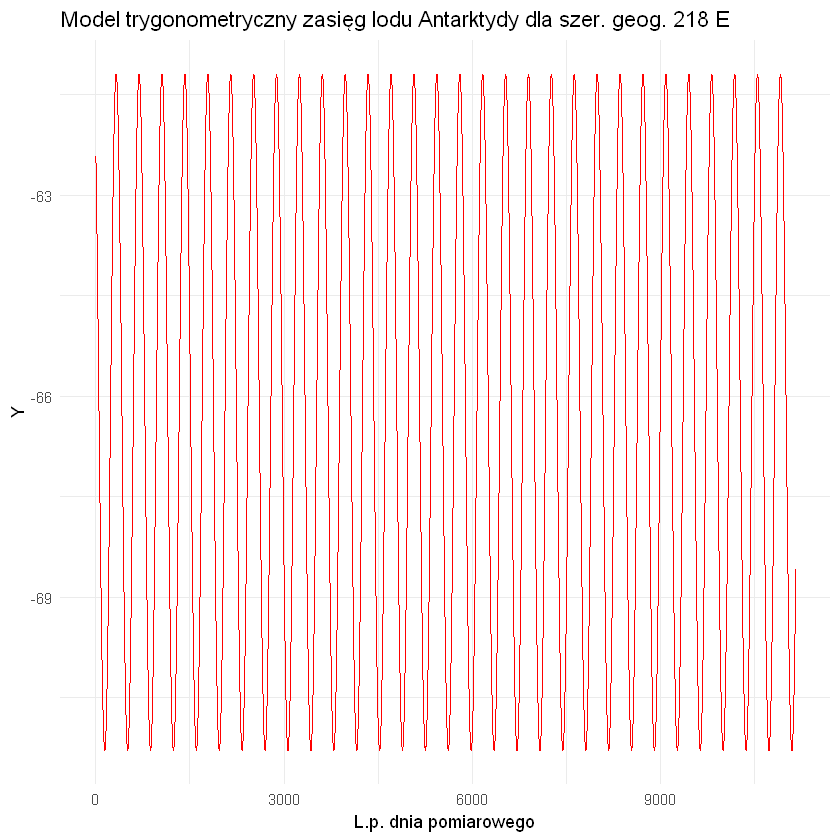

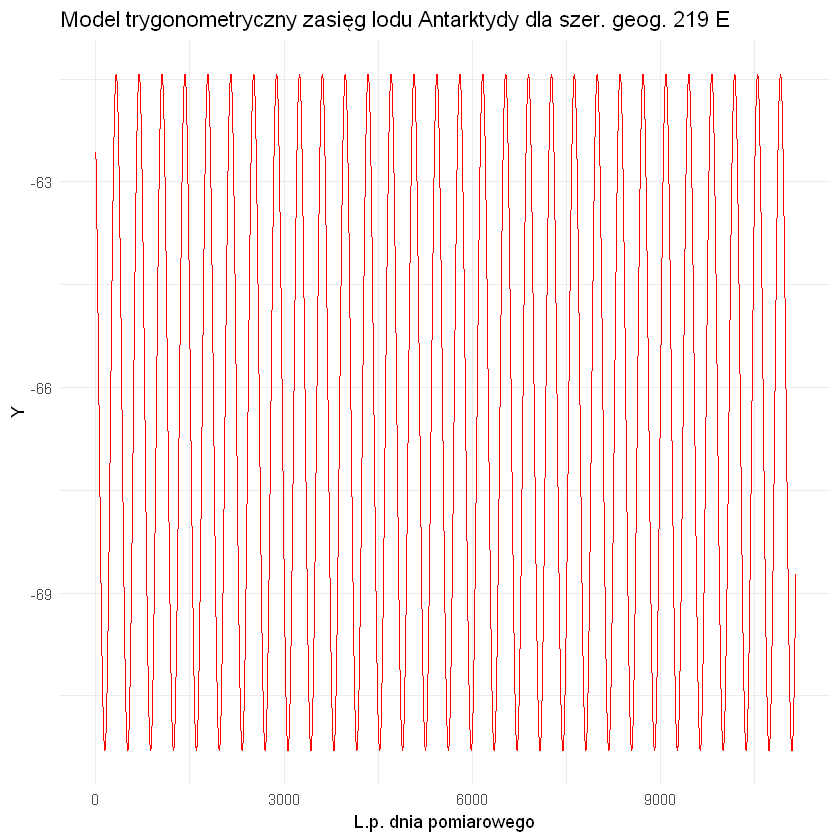

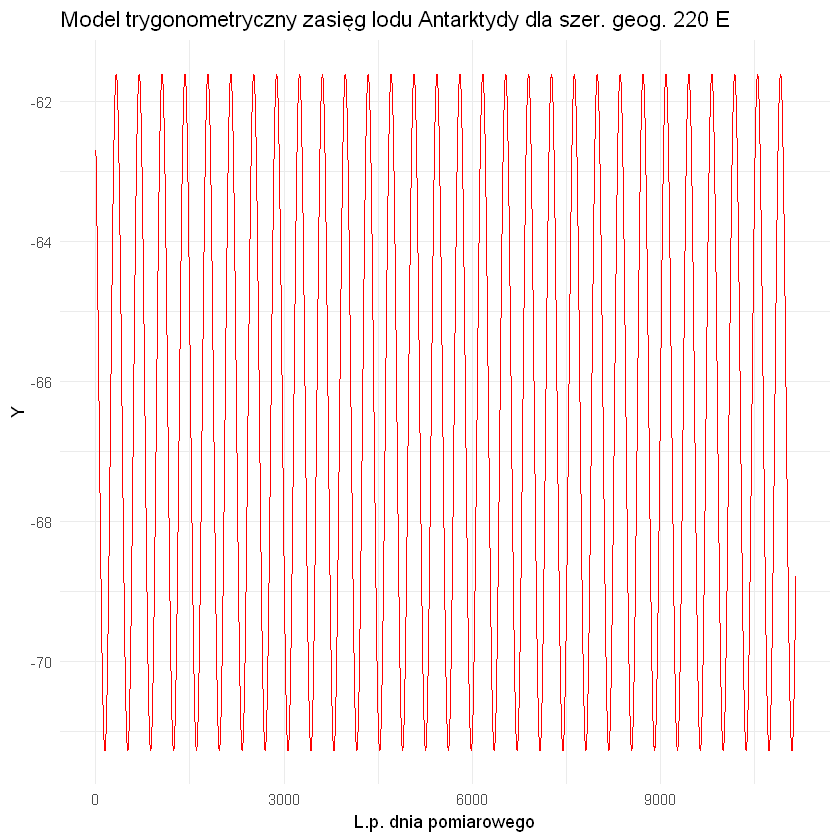

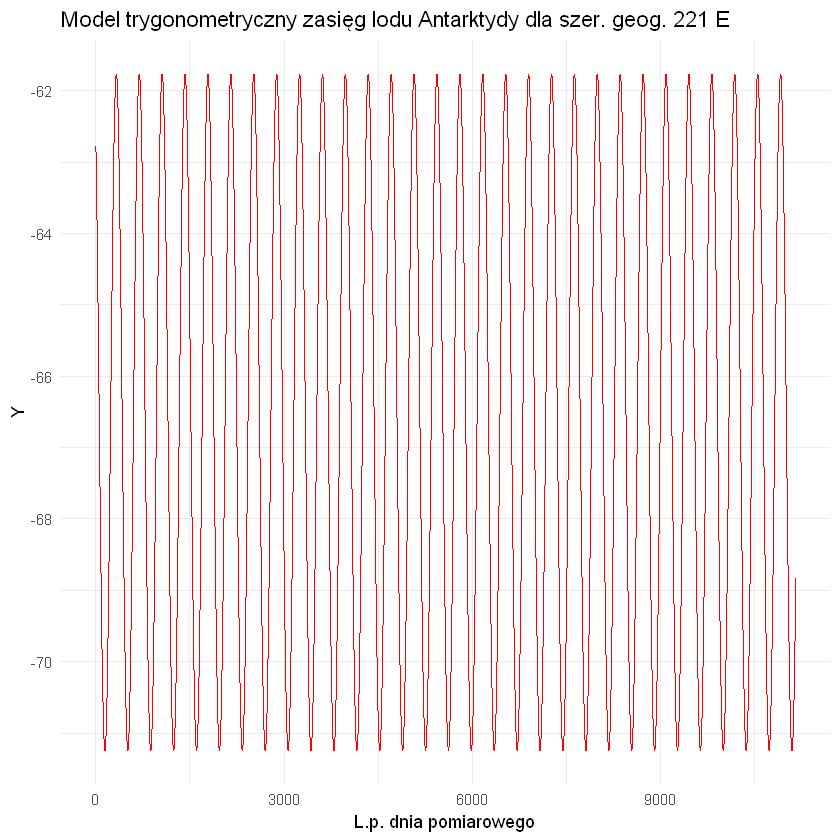

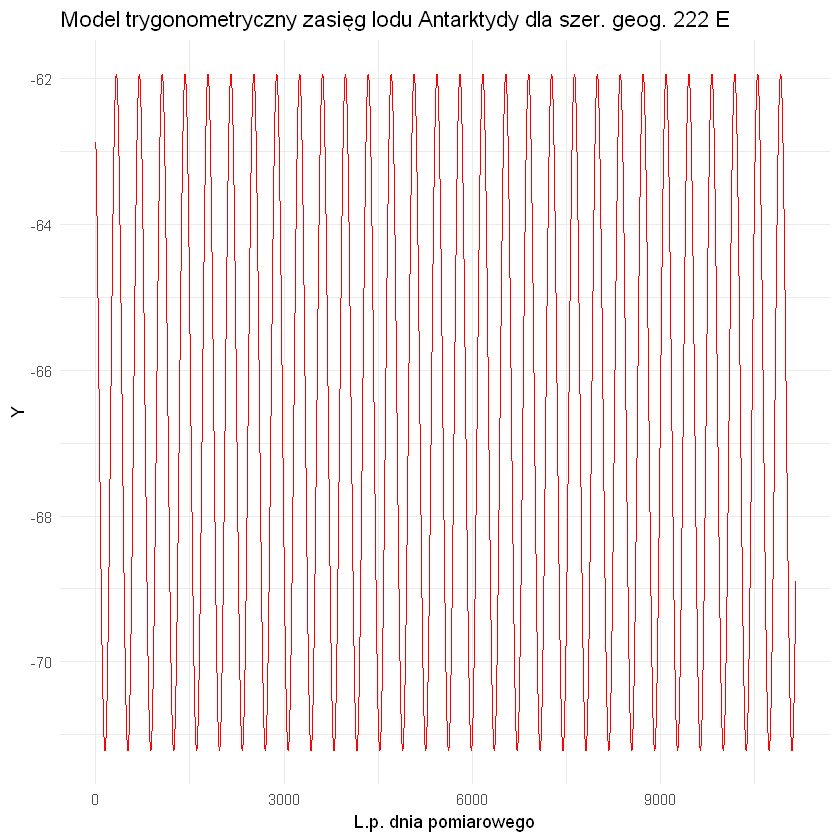

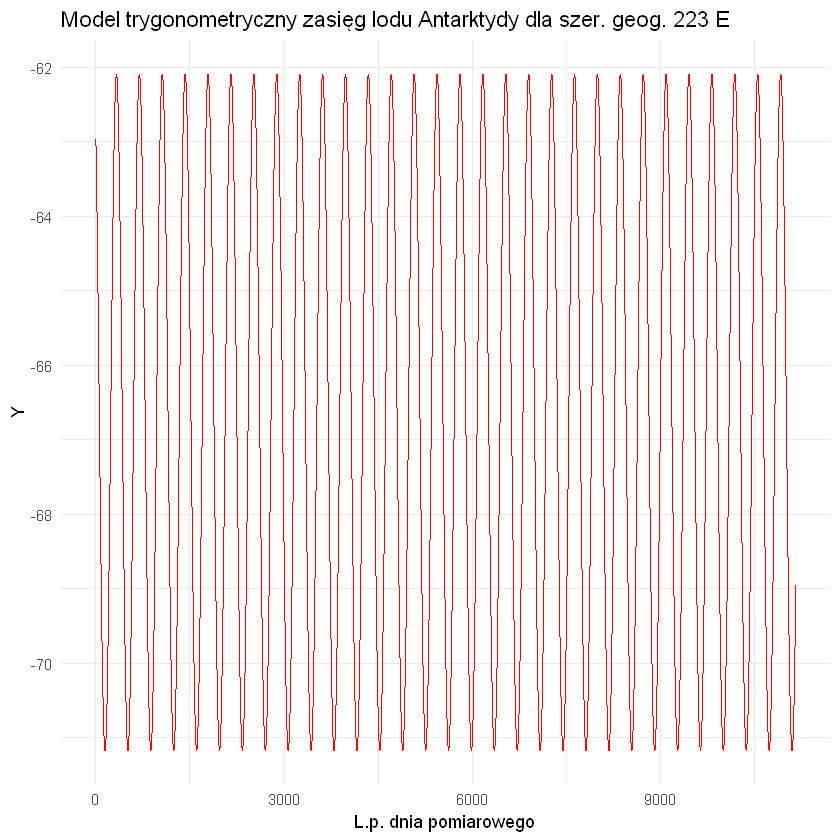

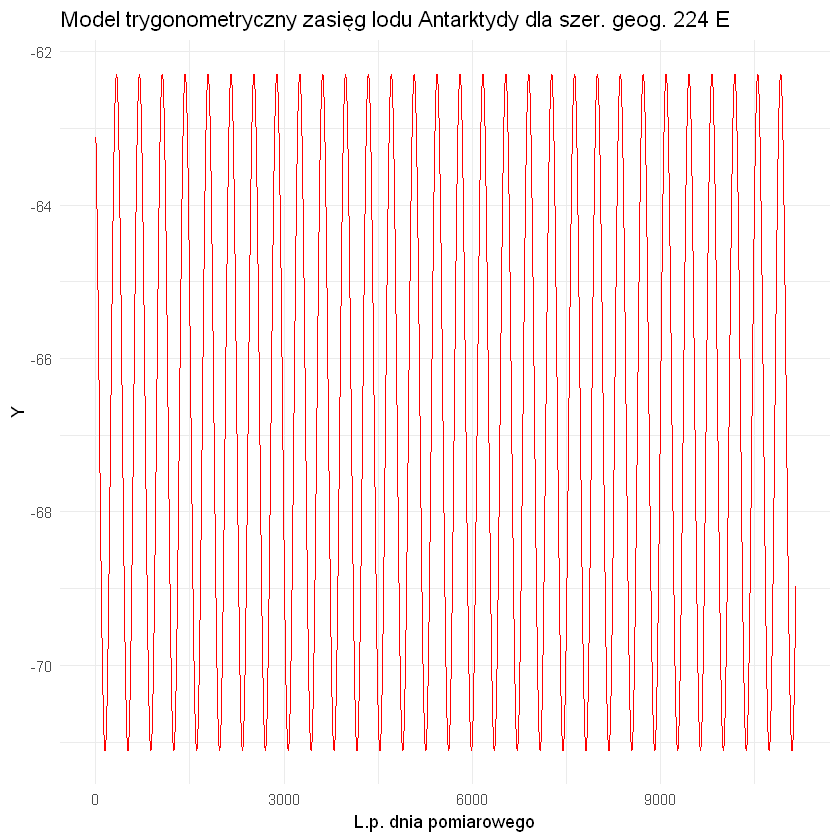

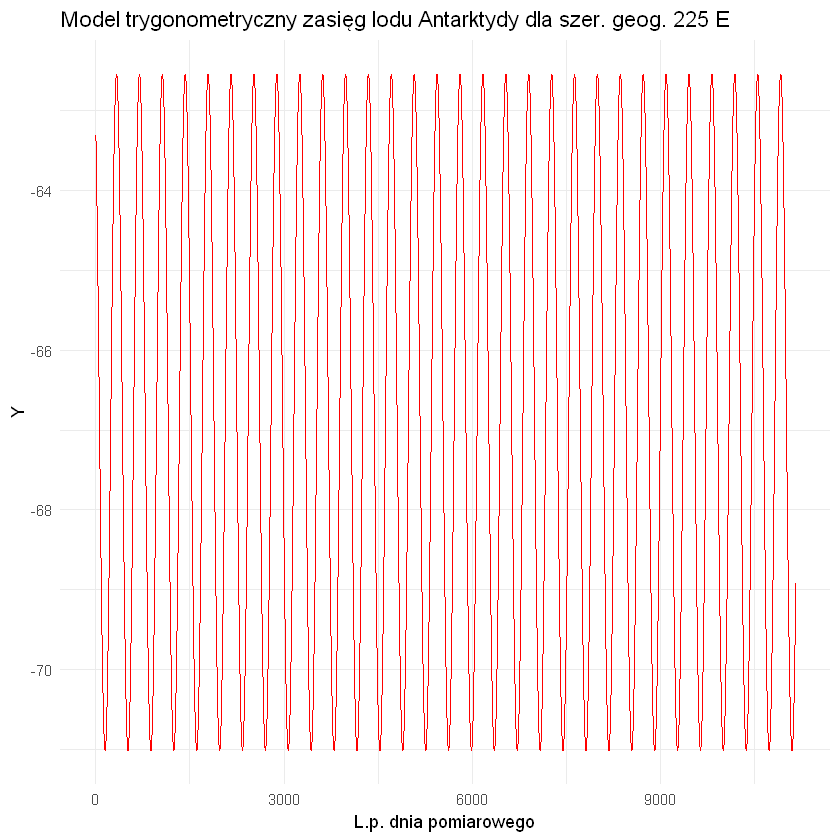

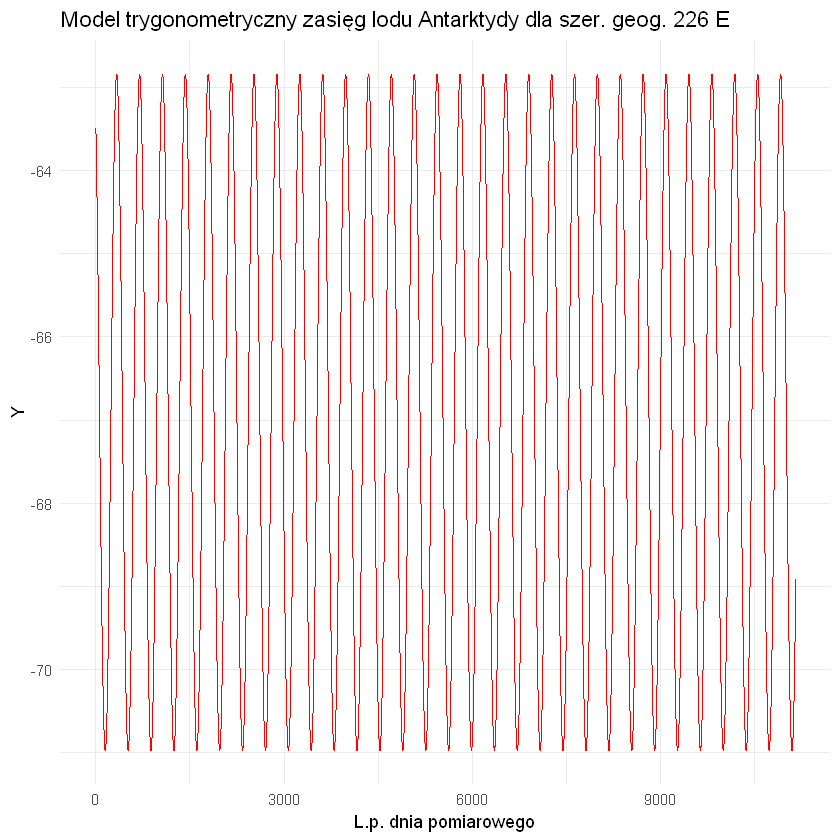

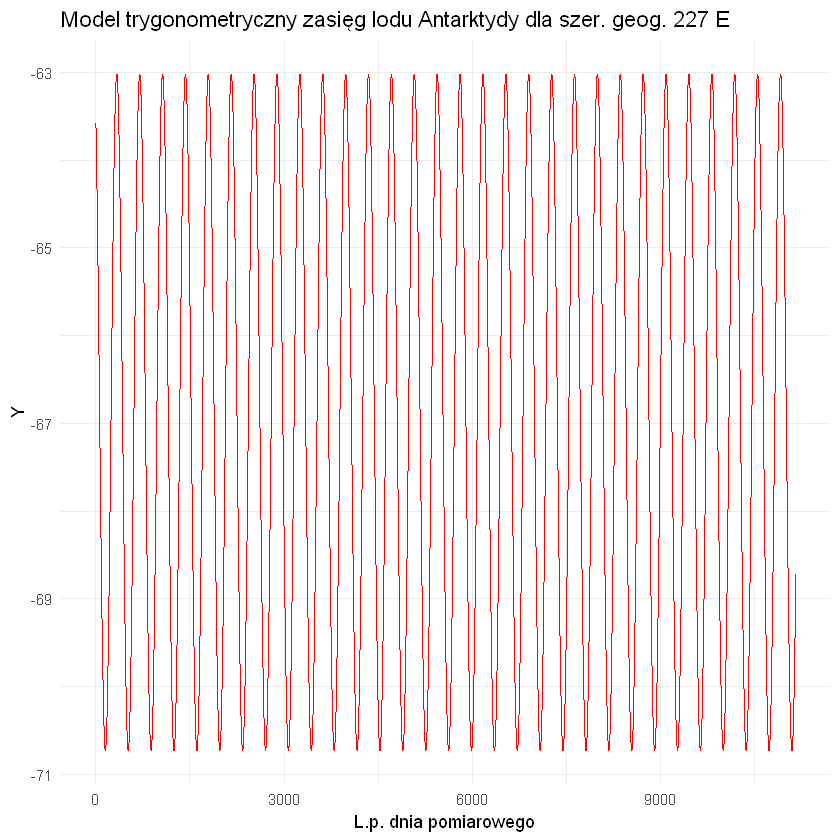

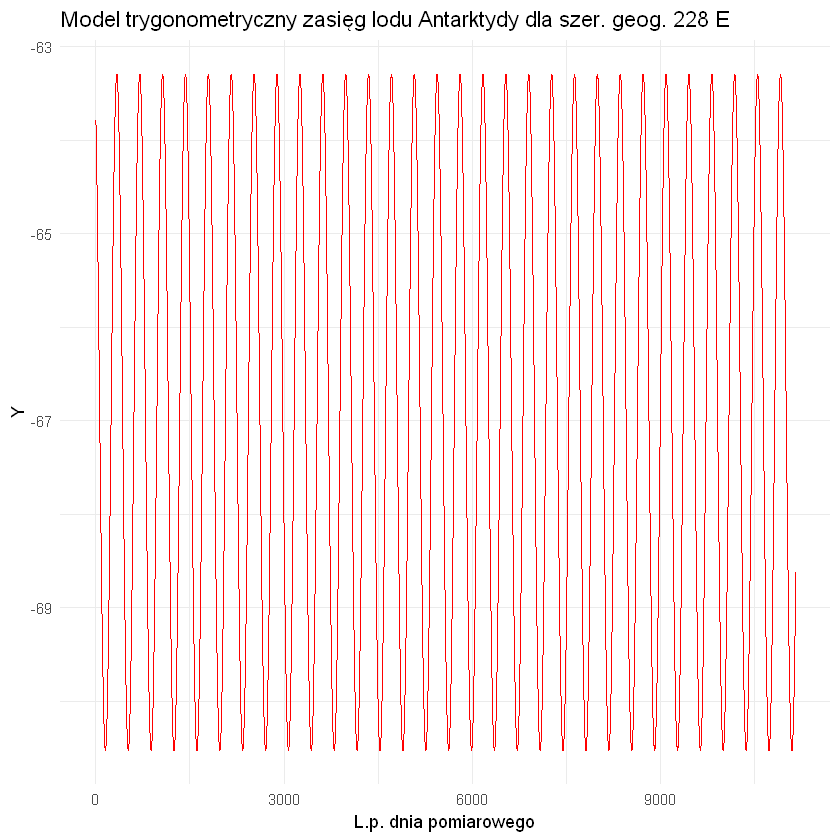

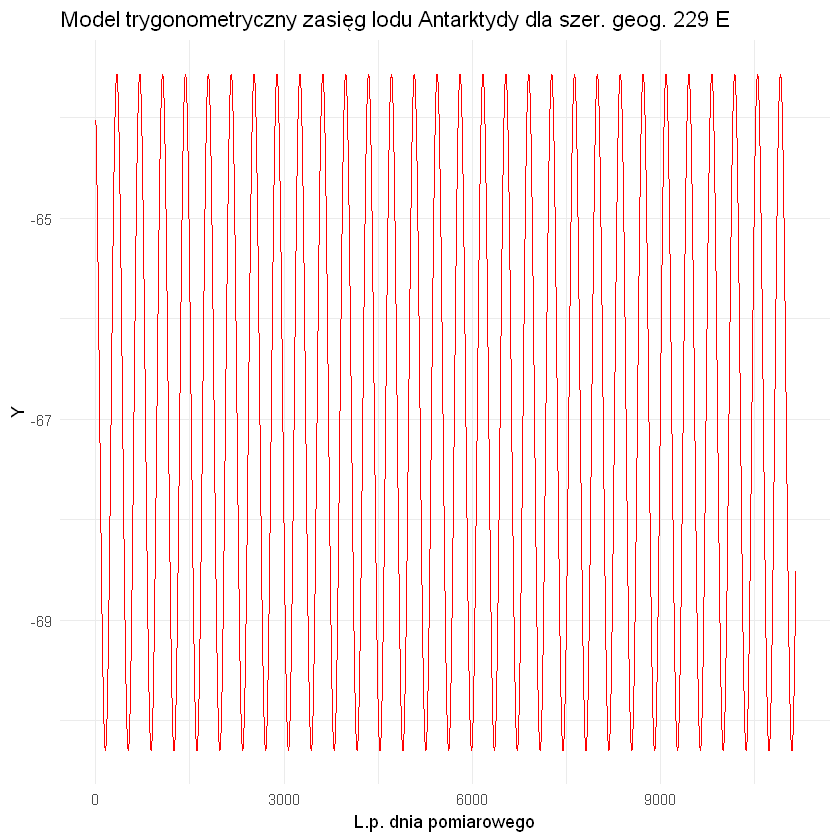

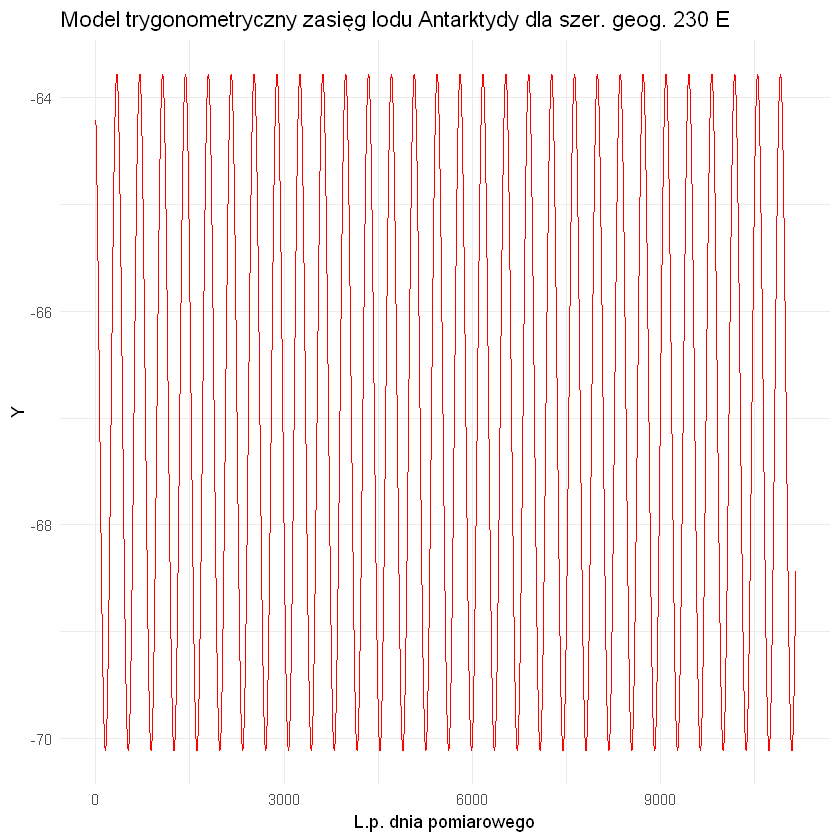

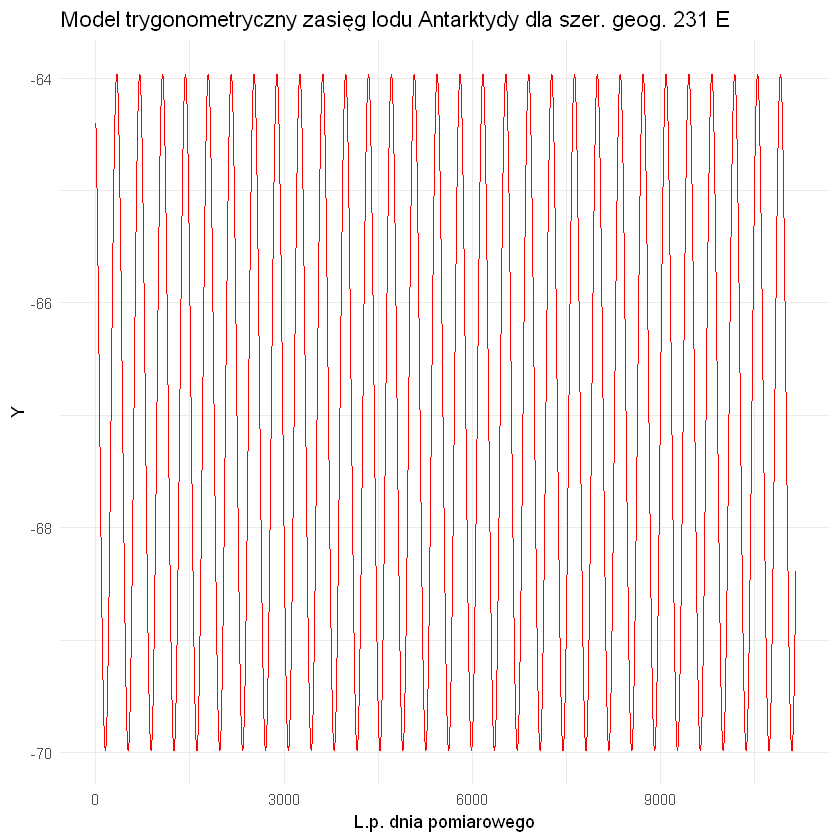

In [90]:
for (i in seq(1, length(model_params), 1)) {
    day <- data$Days
    params <- model_params[[col]]
    ice_extent <- data$params

    X <- seq(min(day), max(day), 1) # nolint: object_name_linter.
    Y <- sine_model( # nolint: object_name_linter.
        X, params["A"], params["B"], params["C"], params["D"]
    )

    col <- names(data)[i + 1]

    a <- round(params["A"], 2)
    b <- round(params["B"], 2)
    c <- round(params["C"], 2)
    d <- round(params["D"], 2)
    # cat(
    #   "Wzór:", col, "y =", a, "sin(", b, "x +", c, ") +", d, "\n"
    # )

    plt <- ggplot() +
        geom_line(aes(x = X, y = Y), color = "red") +
        labs(
            x = "L.p. dnia pomiarowego",
            title = paste(
                "Model trygonometryczny zasięg lodu Antarktydy dla szer. geog.",
                i - 1, "st. E"
            )
        ) +
        theme_minimal()

    print(plt)
}

In [77]:
min_lim <- max(daily_ice_edge$longitude_0E, na.rm = TRUE)
max_lim <- min(daily_ice_edge$longitude_0E, na.rm = TRUE)
rng <- abs(max_lim - min_lim)
percent <- 100
err <- abs(ice_extent - Y) / rng * percent
cat("Błąd względny dla szer. geog. 0E:\n")
cat("Minimalny:", round(min(err, na.rm = TRUE), 2), "%\n")
cat("Maksymalny:", round(max(err, na.rm = TRUE), 2), "%\n")
cat("Średnio:", round(mean(err, na.rm = TRUE), 2), "%\n")
cat("Mediana:", round(median(err, na.rm = TRUE), 2), "%\n")

Warning message in ice_extent - Y:
"długość dłuszego obiektu nie jest wielokrotnością długości krótszego obiektu"


Błąd względny dla szer. geog. 0E:
Minimalny: 0.01 %
Maksymalny: 103.6 %
Średnio: 56.75 %
Mediana: 64.2 %
